In [1]:
# This notebook is for generating the images for a blog post.

# Medium version: https://medium.com/swlh/visualizing-the-geometric-and-harmonic-means-e8b9c5a818ae

# repo: https://github.com/Persola/visualize-generalized-means

In [2]:
from itertools import chain, repeat
import re
from math import floor, tan, pi
import os
import glob

import numpy as np
from scipy.stats import hmean
from matplotlib import rcParams, colors, pyplot as plt
from PIL import Image
import tqdm

In [3]:
for subdir in (
    'generated_visuals',
    'generated_visuals/special_case_plots',
    'generated_visuals/animation_frames',
    'generated_visuals/animations'
):
    if not os.path.exists(subdir):
        os.mkdir(subdir)

In [4]:
def values_grid(funk, range):
    '''Returns a 2D grid of values from given function when fed all 2-tuples of numbers in given range'''
    x_vals, y_vals = list(range), list(range)

    grid = []
    for x in x_vals:
        row = []
        for y in y_vals:
            row.append(funk(x, y))
        grid.append(row)
    return grid

In [5]:
def plot_mean(
    funk,
    _range=np.arange(10**-4, 4, 0.01),
    p_label='',
    continuous=False,
    all_ticks=False,
    save_file=False    
):
    '''
        Plots the result of a function taking two numerical arguments.
        x and y are the two arguments, the color is the result (lighter is higher).
    '''
    values = values_grid(funk, _range)
    
    rcParams['figure.dpi'] = 80
    rcParams['font.family'] = 'sans-serif'
    figure, ax = plt.subplots(figsize=(6, 4.8))
    plt.subplots_adjust(top=1.0, bottom=0.0, left=0.15, right=0.95)
    if continuous:
        kwargs= {
            'cmap': 'gray'
        }
    else:
        kwargs= {
            'cmap': 'gray',
            'norm': colors.BoundaryNorm(
                boundaries=np.arange(-0.125, 4.25, 0.25),
                ncolors=250
            )
        }

    im = plt.imshow(values, **kwargs)
    ax.invert_yaxis()
    if all_ticks and not continuous:
        cbar = plt.colorbar(
            fraction=0.03,
            aspect=24,
            pad=0.1
        )
    else:
        cbar = plt.colorbar(
            fraction=0.03,
            aspect=12,
            pad=0.1
        )
    ax.tick_params(axis='x', labelsize=14, width=1, length=5, pad=6)
    ax.tick_params(axis='y', labelsize=14, width=1, length=4.5, pad=4)
    if all_ticks:
        ax.set_xticks(np.arange(0, 5) * 100)
        ax.set_yticks(np.arange(0, 5) * 100)
        ax.set_xticklabels(range(0, 5), rotation=0)
        ax.set_yticklabels(range(0, 5))
        if continuous:
            cbar.set_ticks([0, 1, 2, 3, 3.99])
            cbar.ax.set_yticklabels(range(0, 5))
        else:
            cbar.set_ticks(np.arange(0, 4.25, 0.25))
            cbar.ax.set_yticklabels(np.arange(0, 4.25, 0.25))
    else:
        ax.set_xticks([-0.5, 400]) # set ticks to zero instead of middle of first color square
        ax.set_yticks([-0.5, 400])
        ax.set_xticklabels(['0', ''], rotation=0)
        ax.set_yticklabels(['0', ''])
        ax.figure.text(0.107, 0.922, '𝑥', family='serif', fontsize=16) # hack in tick labels in different font
        ax.figure.text(0.838, 0.01, '𝑥', family='serif', fontsize=16) # "
        cbar.set_ticks([0, 4])
        cbar.ax.set_yticklabels(['0', ''], fontsize=14)
        ax.figure.text(0.965, 0.655, '𝑥', family='serif', fontsize=16) # hack in colorbar labels in different font

    ax.figure.text(0.17, 0.95, p_label, family='monospace', fontsize=18) # label with p value
    if save_file:
        ax.figure.savefig(save_file)
    plt.show()
    plt.close(figure)

In [6]:
# Generate special case plots

In [7]:
def arithmetic_mean(a, b):
    return (a + b) / 2

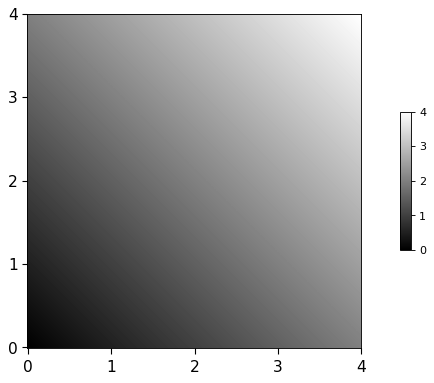

In [8]:
plot_mean(
    arithmetic_mean,
    continuous=True,
    all_ticks=True,
    save_file='generated_visuals/special_case_plots/01_arithmetic_mean_continuous_max_4.png'
)

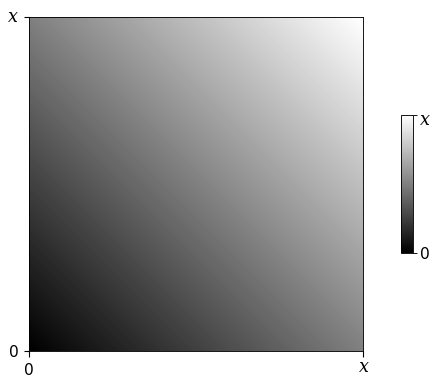

In [9]:
plot_mean(
    arithmetic_mean,
    continuous=True,
    save_file='generated_visuals/special_case_plots/02_arithmetic_mean_continuous_max_x.png'
)

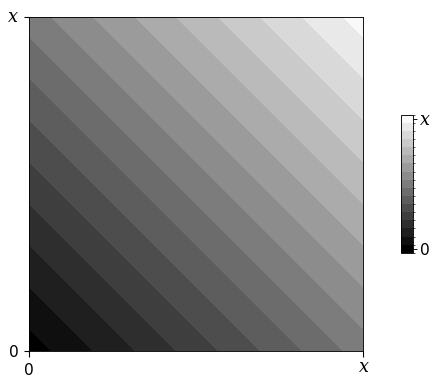

In [10]:
plot_mean(
    arithmetic_mean,
    save_file='generated_visuals/special_case_plots/03_arithmetic_mean.png'
)

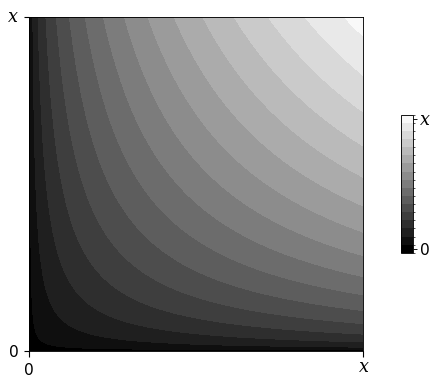

In [11]:
def geometric_mean(a, b):
#     return (a * b)**2 # doesn't work
    tiny = 10**-10
    huge = 1/tiny
    return ((a**tiny + b**tiny) / 2)**(huge) # approximation

plot_mean(
    geometric_mean,
    save_file='generated_visuals/special_case_plots/04_geometric_mean.png'
)

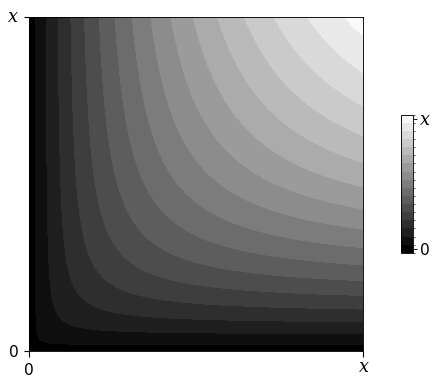

In [12]:
def harmonic_mean(a, b):
    return hmean([a, b])

plot_mean(
    harmonic_mean,
    save_file='generated_visuals/special_case_plots/05_harmonic_mean.png'
)

In [13]:
def create_p_mean(p):
    def p_mean(a, b):
        return ((a**p + b**p)/2)**(1/p)
    return p_mean

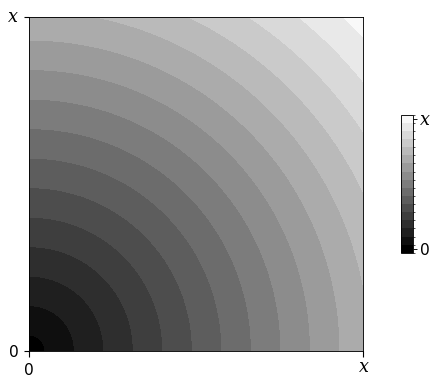

In [14]:
# quadratic mean
plot_mean(
    create_p_mean(2),
    save_file='generated_visuals/special_case_plots/07_quadratic_mean.png'
)

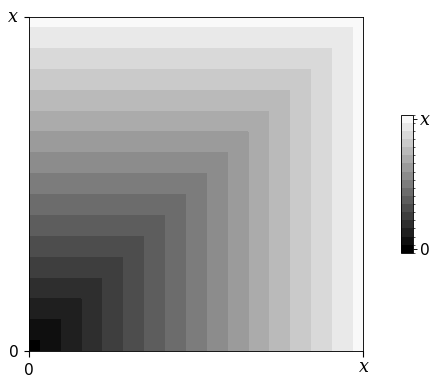

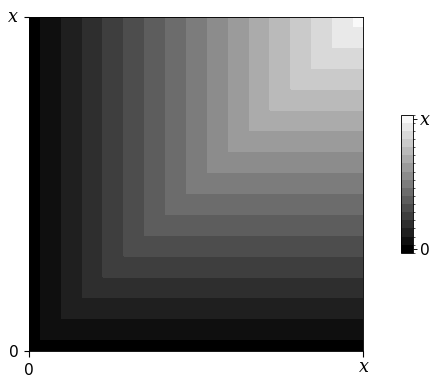

In [15]:
plot_mean(
    max,
    save_file=f'generated_visuals/special_case_plots/08_maximum.png'
)

plot_mean(
    min,
    save_file=f'generated_visuals/special_case_plots/06_minimum.png'
)

In [16]:
# Generate animations

# 'ps' = plural of p

In [17]:
# this algorithm controls the rate at which p changes for the whole range animation
# we need to slow down around one so the change in curvature is visible
WHOLE_RANGE_PS = [
    tan(pi * 10**-2 * 2**-1 * 0.6 * x)**2 * abs(x)/x * 2**3 + 1
    for x
    in np.arange(-151, 153, 2)
]

# animations' names, frame p values, and per-frame durations (seconds)
# p must never be zero
ANIMATIONS = {
    'arith_to_harm': {
        'frame_ps': np.arange(-1, 1 + 2/99, 2/99)[::-1],
        'durations': list(chain(
            [1/2],
            repeat(
                1/60,
                len(np.arange(-1, 1 + 2/99, 2/99)) - 2
            ),
            [1/2]
        ))
    },
    'harm_to_min': {
        'frame_ps': [
            -(x**3 / (2**15)) - 1
            for x
            in np.arange(0, 120)
        ],
        'durations': list(chain(
            [1/2],
            repeat(
                1/60,
                len(np.arange(0, 120)) - 1
            )
        ))
    },
    'arith_to_quad': {
        'frame_ps': np.arange(1, 2.008, 0.008),
        'durations': list(chain(
            [1/2],
            repeat(
                1/60,
                len(np.arange(1, 2.008, 0.008)) - 2
            ),
            [1/2]
        ))
    },
    'quad_to_max': {
        'frame_ps': [
            (x**3 / (2**15)) + 2
            for x
            in np.arange(0, 120)
        ],
        'durations': list(chain(
            [1/2],
            repeat(
                1/60,
                len(np.arange(0, 120)) - 1
            )
        ))
    },
    'whole_range': {
        'frame_ps': WHOLE_RANGE_PS + WHOLE_RANGE_PS[-2:0:-1], # loop it
        'durations': list(repeat(
            1/60,
            len(WHOLE_RANGE_PS) * 2 - 2
        ))
    }
}

In [18]:
# plot frames across p

([], [])

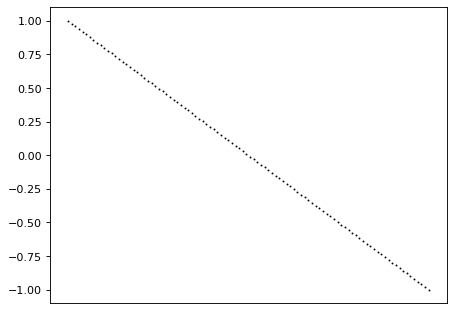

In [19]:
fig = plt.scatter(
    range(0, len(ANIMATIONS['arith_to_harm']['frame_ps'])),
    ANIMATIONS['arith_to_harm']['frame_ps'],
    color='black',
    s=1/2
)
plt.xticks([])

([], [])

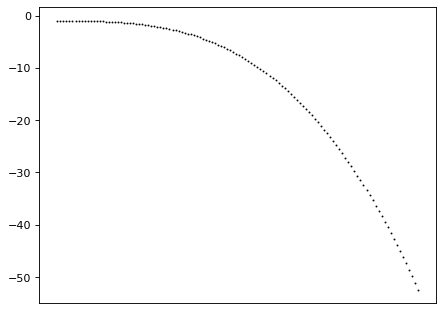

In [20]:
fig = plt.scatter(
    range(0, len(ANIMATIONS['harm_to_min']['frame_ps'])),
    ANIMATIONS['harm_to_min']['frame_ps'],
    color='black',
    s=1/2
)
plt.xticks([])

([], [])

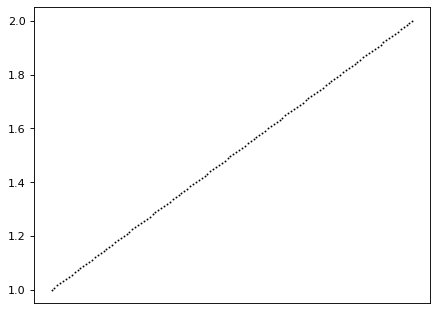

In [21]:
fig = plt.scatter(
    range(0, len(ANIMATIONS['arith_to_quad']['frame_ps'])),
    ANIMATIONS['arith_to_quad']['frame_ps'],
    color='black',
    s=1/2
)
plt.xticks([])

([], [])

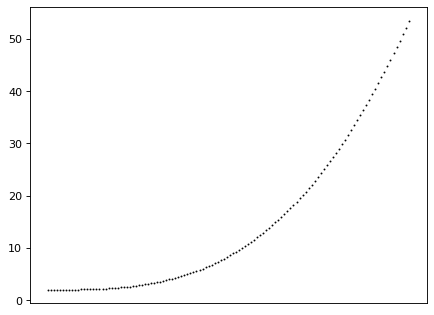

In [22]:
fig = plt.scatter(
    range(0, len(ANIMATIONS['quad_to_max']['frame_ps'])),
    ANIMATIONS['quad_to_max']['frame_ps'],
    color='black',
    s=1/2
)
plt.xticks([])

([], [])

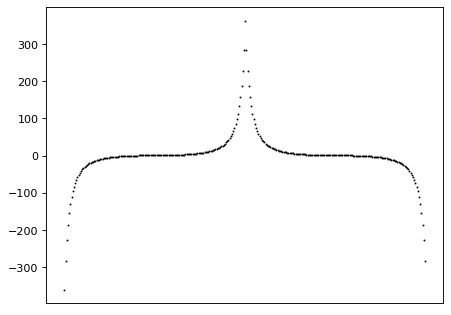

In [23]:
fig = plt.scatter(
    range(0, len(ANIMATIONS['whole_range']['frame_ps'])),
    ANIMATIONS['whole_range']['frame_ps'],
    color='black',
    s=1/2
)
plt.xticks([])

([], [])

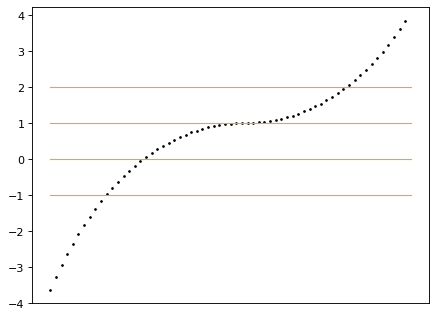

In [24]:
# zoom
small_ps = [p for p in WHOLE_RANGE_PS if abs(p) < 4]
plt.scatter(
    range(0, len(small_ps)),
    small_ps,
    color='black',
    s=2
)
plt.plot([0, len(small_ps)], [2, 2], c='orange', lw=1)
plt.plot([0, len(small_ps)], [1, 1], c='orange', lw=1)
plt.plot([0, len(small_ps)], [0, 0], c='orange', lw=1)
plt.plot([0, len(small_ps)], [-1, -1], c='orange', lw=1)
plt.xticks([])

In [25]:
def frame_file(p):
    without_decimal = re.sub('\.', '_', '{0:+.6f}'.format(p))
    return f'generated_visuals/animation_frames/{without_decimal}.png'

def generate_frames(ps):
    for p_ind, p in enumerate(ps):
        one_decimal = '{0:+.1f}'.format(p)
        plot_mean(
            create_p_mean(p),
            p_label=f'p = {one_decimal}',
            save_file=frame_file(p)
        )

  0%|                                                                                                       | 0/617 [00:00<?, ?it/s]

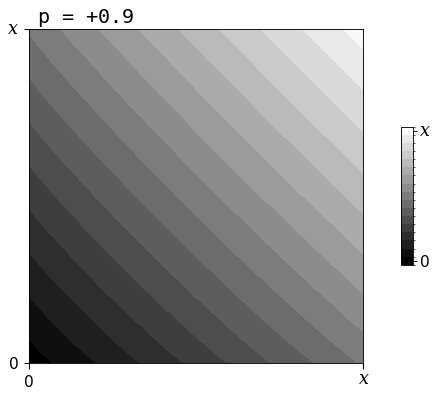

  0%|▏                                                                                              | 1/617 [00:00<01:35,  6.42it/s]

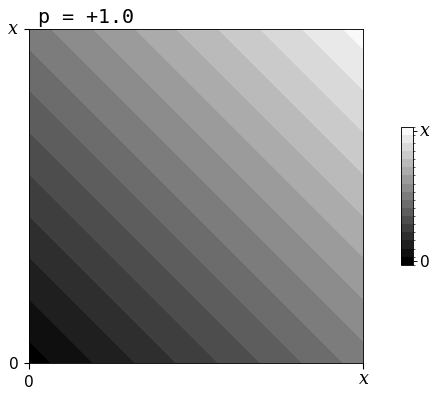

  0%|▎                                                                                              | 2/617 [00:00<02:09,  4.74it/s]

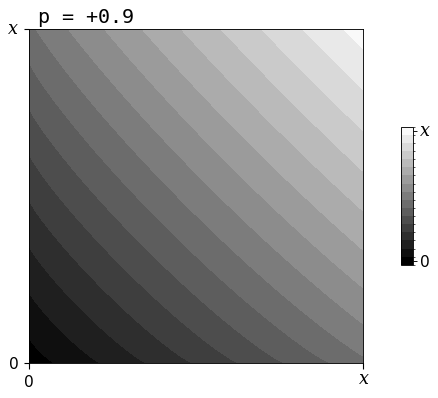

  0%|▍                                                                                              | 3/617 [00:00<01:58,  5.19it/s]

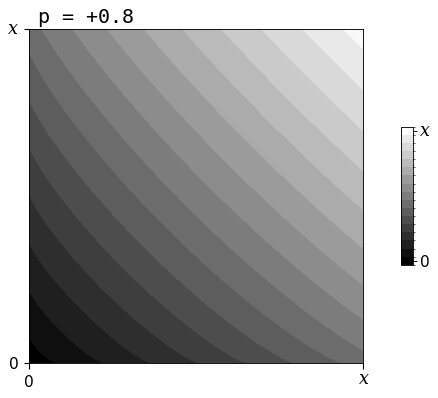

  1%|▌                                                                                              | 4/617 [00:00<01:43,  5.91it/s]

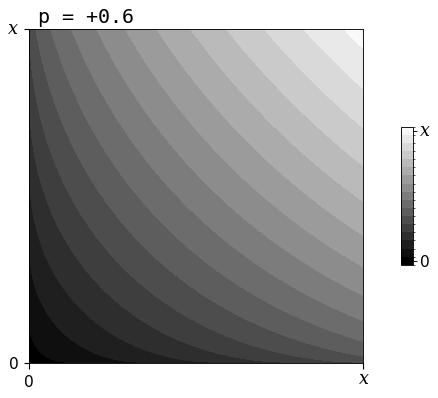

  1%|▊                                                                                              | 5/617 [00:00<01:35,  6.41it/s]

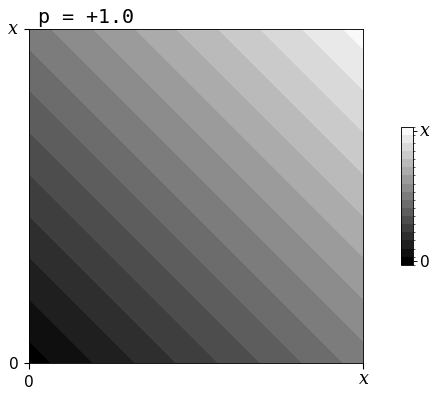

  1%|▉                                                                                              | 6/617 [00:00<01:30,  6.75it/s]

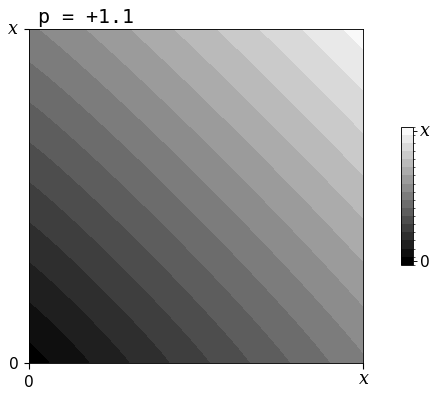

  1%|█                                                                                              | 7/617 [00:01<01:27,  6.99it/s]

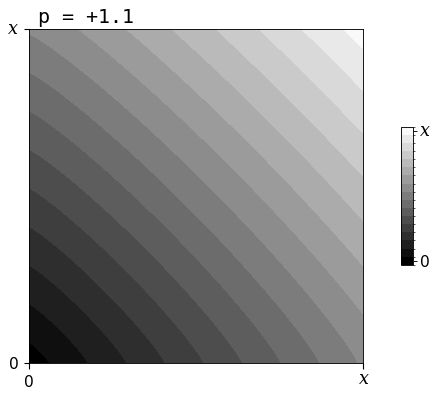

  1%|█▏                                                                                             | 8/617 [00:01<01:27,  6.97it/s]

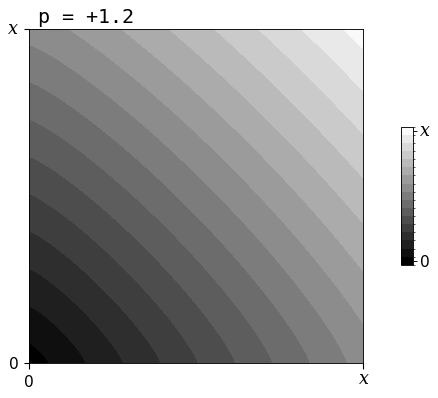

  1%|█▍                                                                                             | 9/617 [00:01<01:24,  7.17it/s]

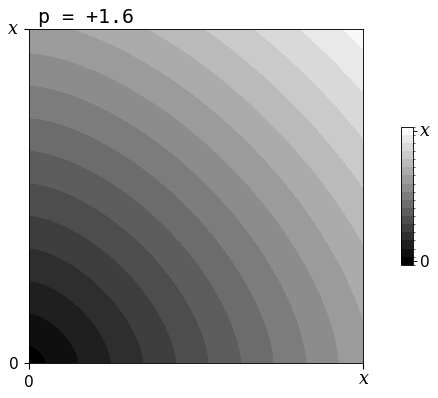

  2%|█▌                                                                                            | 10/617 [00:01<01:23,  7.27it/s]

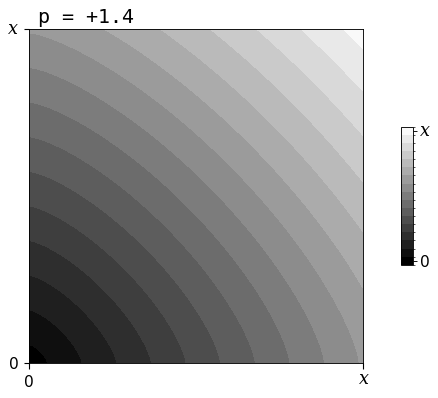

  2%|█▋                                                                                            | 11/617 [00:01<01:22,  7.36it/s]

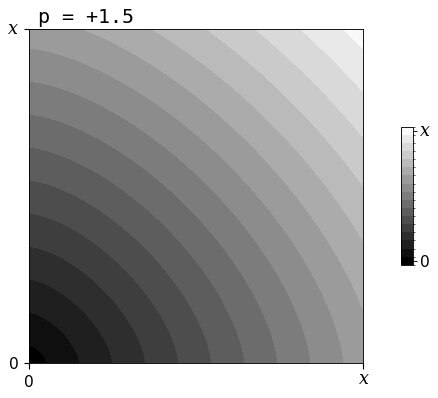

  2%|█▊                                                                                            | 12/617 [00:01<01:21,  7.42it/s]

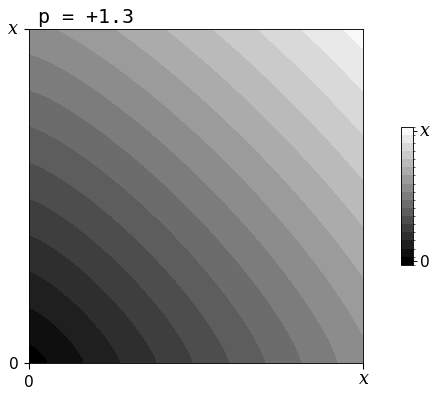

  2%|█▉                                                                                            | 13/617 [00:01<01:21,  7.45it/s]

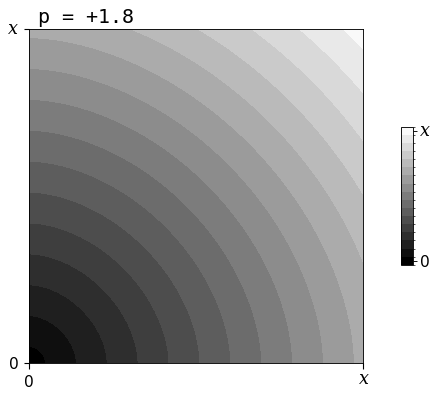

  2%|██▏                                                                                           | 14/617 [00:02<01:20,  7.48it/s]

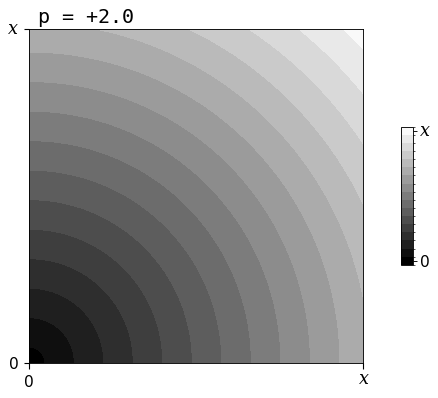

  2%|██▎                                                                                           | 15/617 [00:02<01:20,  7.51it/s]

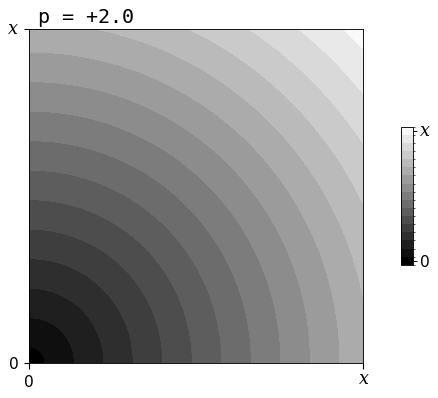

  3%|██▍                                                                                           | 16/617 [00:02<01:26,  6.97it/s]

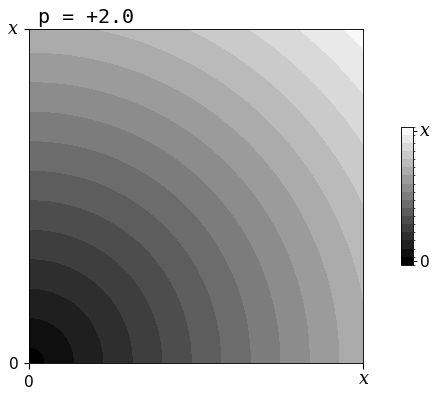

  3%|██▌                                                                                           | 17/617 [00:02<01:23,  7.15it/s]

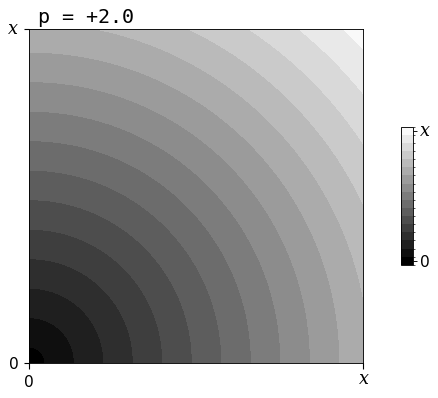

  3%|██▋                                                                                           | 18/617 [00:02<01:22,  7.27it/s]

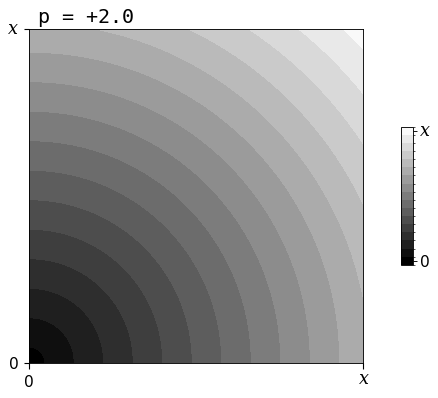

  3%|██▉                                                                                           | 19/617 [00:02<01:21,  7.35it/s]

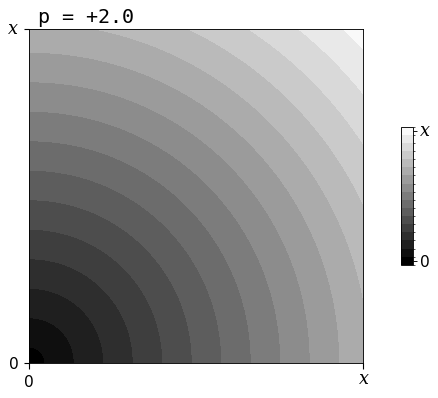

  3%|███                                                                                           | 20/617 [00:02<01:20,  7.44it/s]

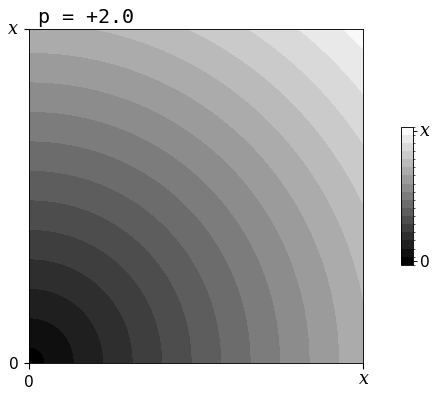

  3%|███▏                                                                                          | 21/617 [00:03<01:19,  7.46it/s]

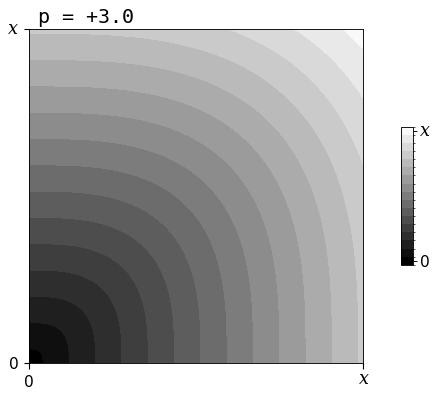

  4%|███▎                                                                                          | 22/617 [00:03<01:19,  7.48it/s]

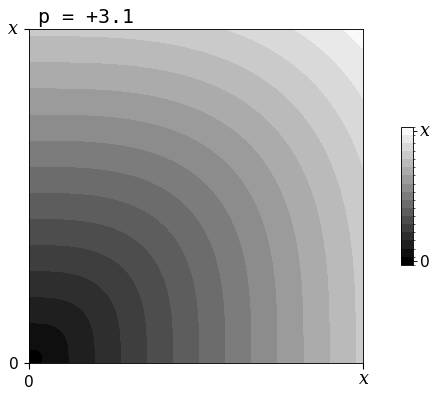

  4%|███▌                                                                                          | 23/617 [00:03<01:19,  7.51it/s]

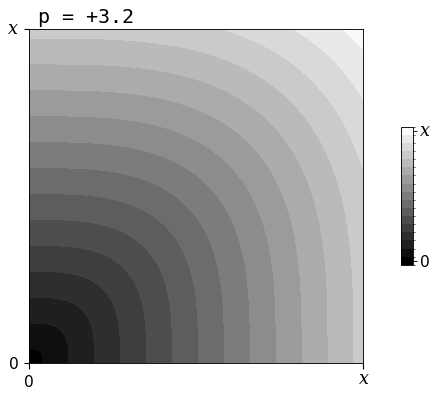

  4%|███▋                                                                                          | 24/617 [00:03<01:18,  7.55it/s]

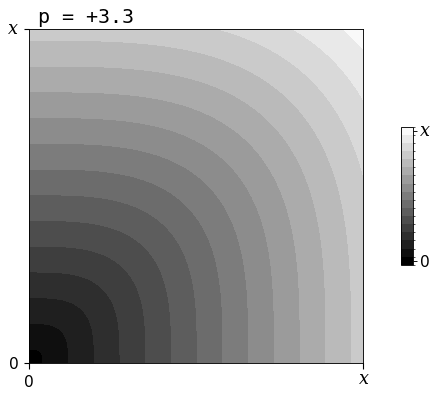

  4%|███▊                                                                                          | 25/617 [00:03<01:18,  7.57it/s]

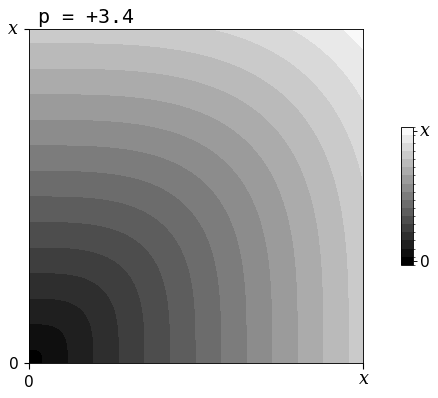

  4%|███▉                                                                                          | 26/617 [00:03<01:17,  7.61it/s]

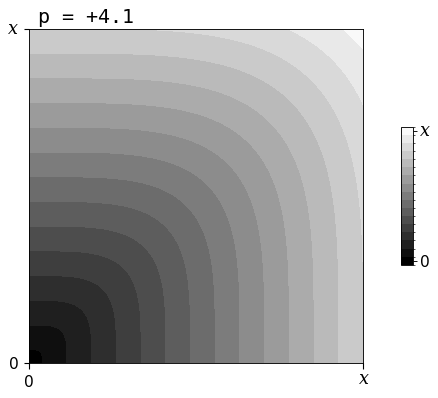

  4%|████                                                                                          | 27/617 [00:03<01:17,  7.61it/s]

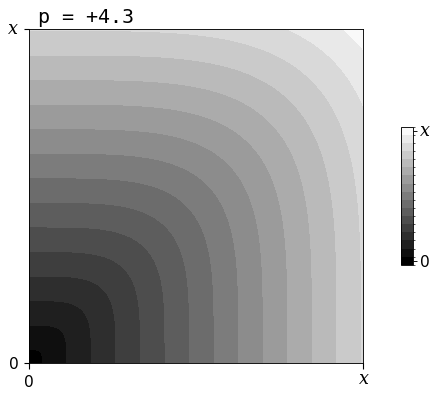

  5%|████▎                                                                                         | 28/617 [00:03<01:17,  7.60it/s]

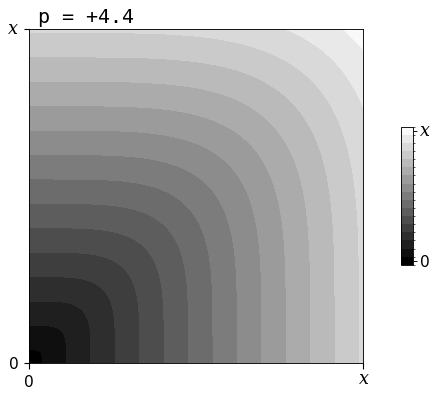

  5%|████▍                                                                                         | 29/617 [00:04<01:23,  7.04it/s]

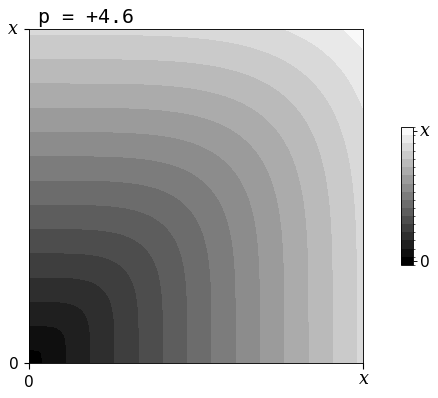

  5%|████▌                                                                                         | 30/617 [00:04<01:21,  7.21it/s]

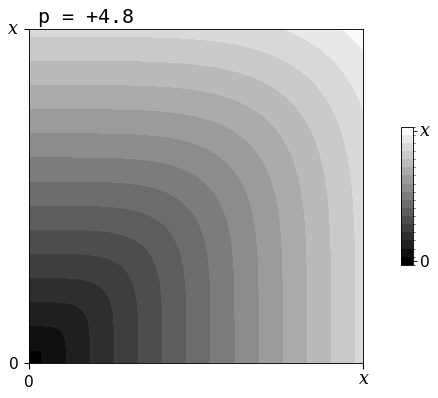

  5%|████▋                                                                                         | 31/617 [00:04<01:19,  7.33it/s]

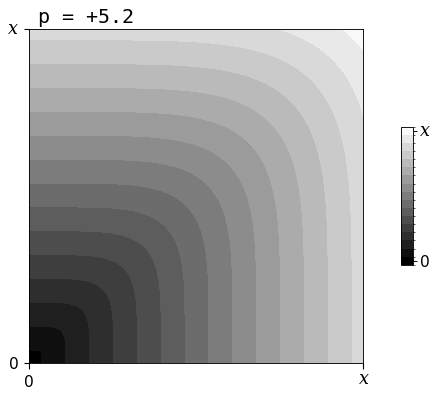

  5%|████▉                                                                                         | 32/617 [00:04<01:18,  7.42it/s]

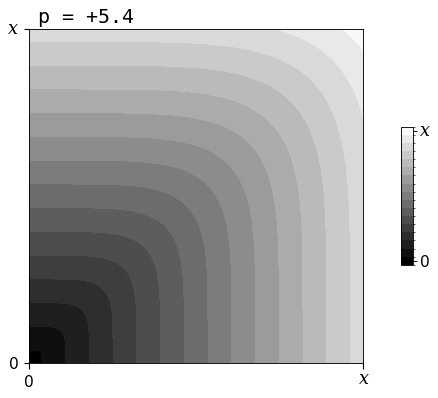

  5%|█████                                                                                         | 33/617 [00:04<01:18,  7.47it/s]

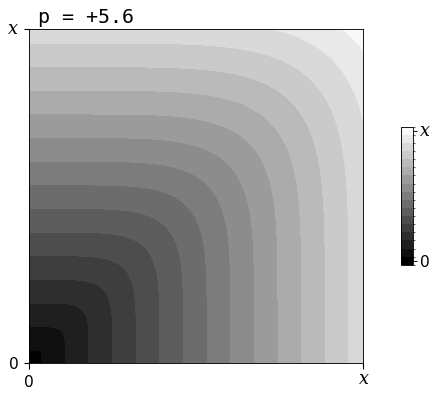

  6%|█████▏                                                                                        | 34/617 [00:04<01:17,  7.52it/s]

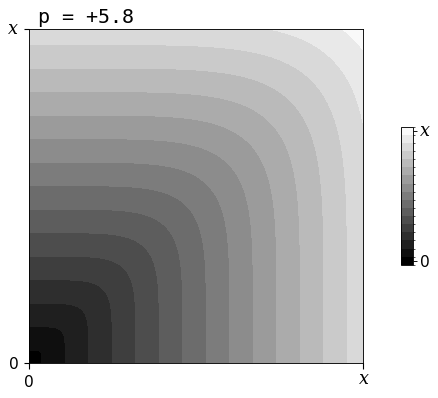

  6%|█████▎                                                                                        | 35/617 [00:04<01:16,  7.57it/s]

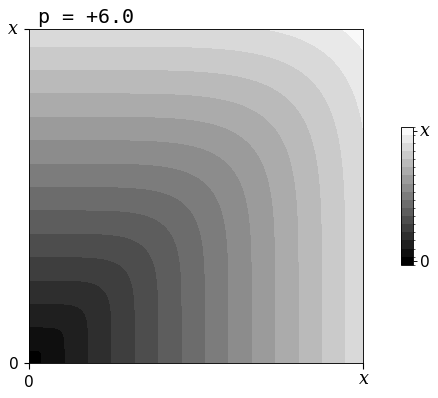

  6%|█████▍                                                                                        | 36/617 [00:05<01:16,  7.59it/s]

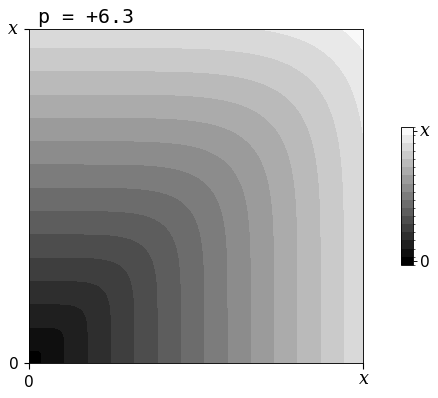

  6%|█████▋                                                                                        | 37/617 [00:05<01:16,  7.62it/s]

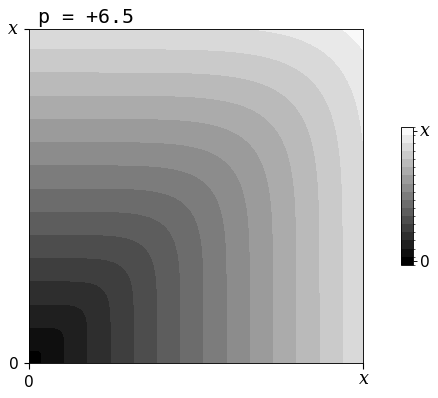

  6%|█████▊                                                                                        | 38/617 [00:05<01:15,  7.65it/s]

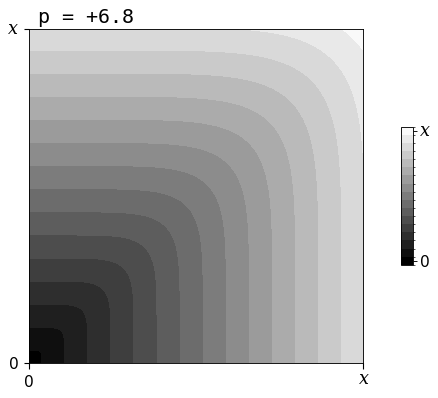

  6%|█████▉                                                                                        | 39/617 [00:05<01:15,  7.66it/s]

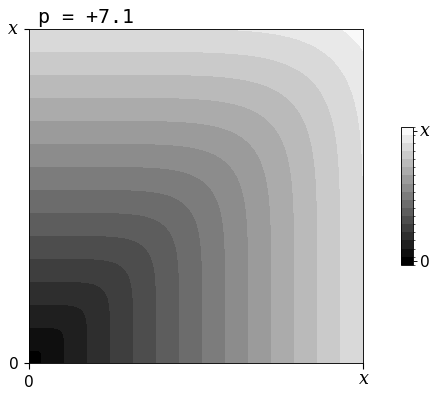

  6%|██████                                                                                        | 40/617 [00:05<01:15,  7.65it/s]

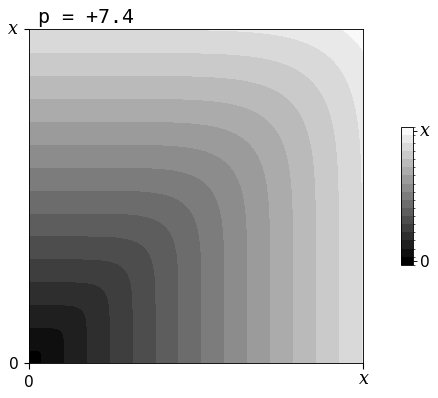

  7%|██████▏                                                                                       | 41/617 [00:05<01:15,  7.66it/s]

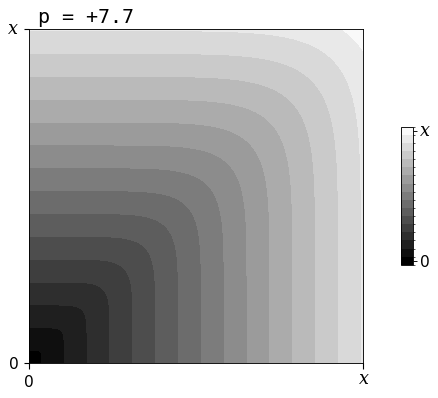

  7%|██████▍                                                                                       | 42/617 [00:05<01:21,  7.06it/s]

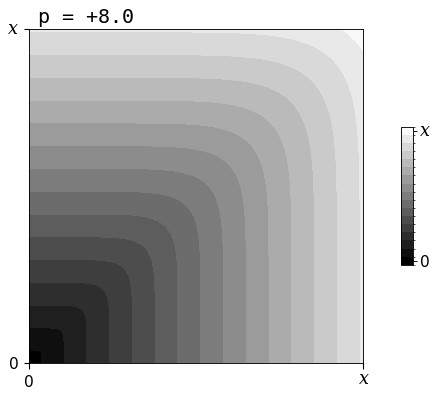

  7%|██████▌                                                                                       | 43/617 [00:05<01:19,  7.24it/s]

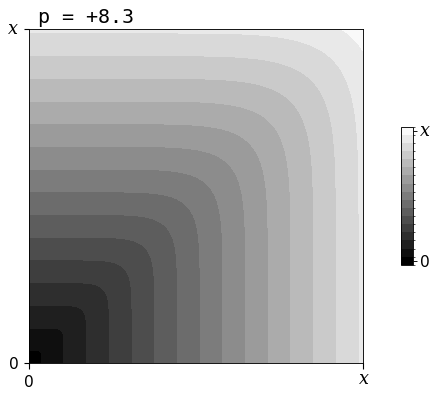

  7%|██████▋                                                                                       | 44/617 [00:06<01:17,  7.35it/s]

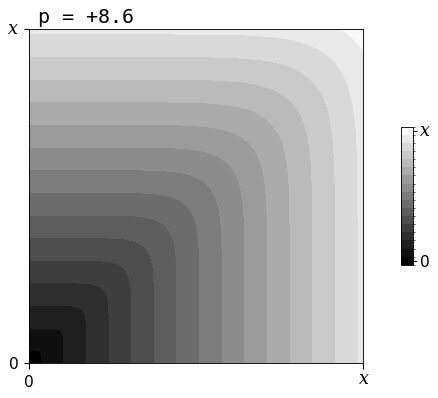

  7%|██████▊                                                                                       | 45/617 [00:06<01:16,  7.43it/s]

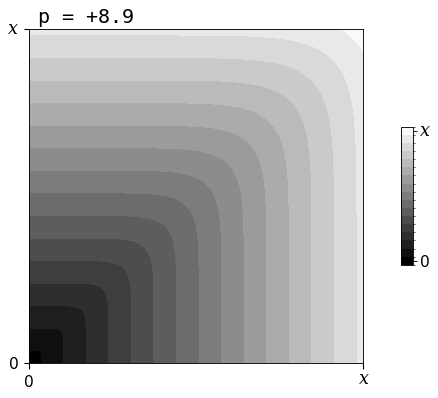

  7%|███████                                                                                       | 46/617 [00:06<01:16,  7.51it/s]

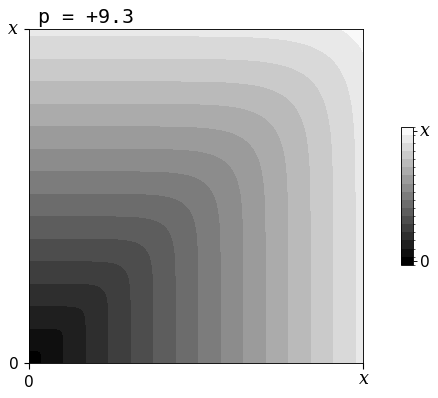

  8%|███████▏                                                                                      | 47/617 [00:06<01:16,  7.50it/s]

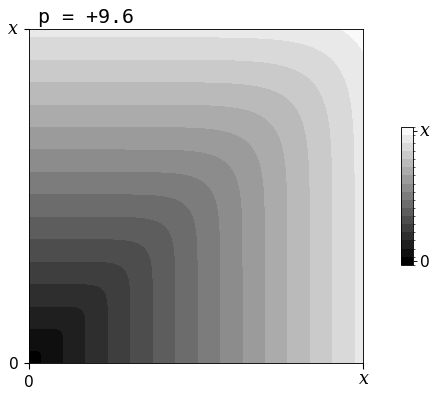

  8%|███████▎                                                                                      | 48/617 [00:06<01:15,  7.52it/s]

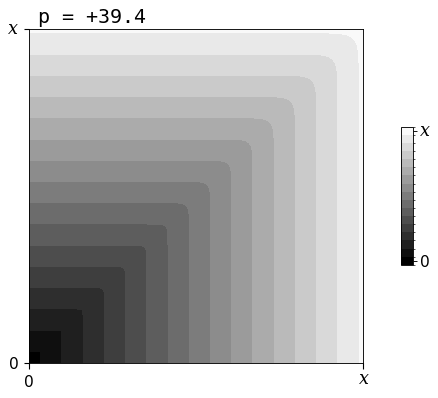

  8%|███████▍                                                                                      | 49/617 [00:06<01:14,  7.59it/s]

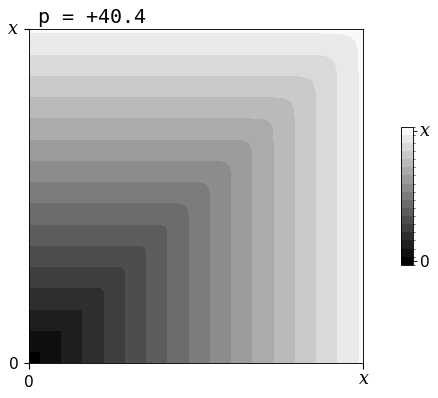

  8%|███████▌                                                                                      | 50/617 [00:06<01:14,  7.62it/s]

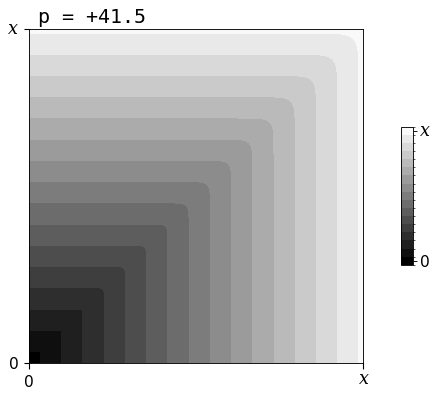

  8%|███████▊                                                                                      | 51/617 [00:07<01:13,  7.65it/s]

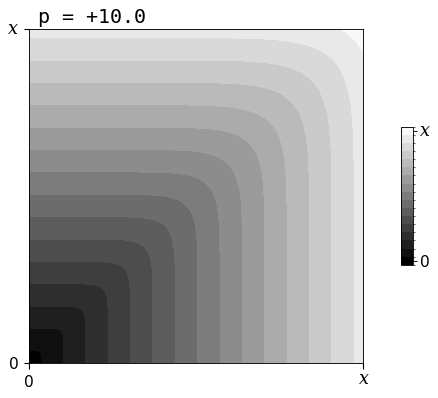

  8%|███████▉                                                                                      | 52/617 [00:07<01:13,  7.65it/s]

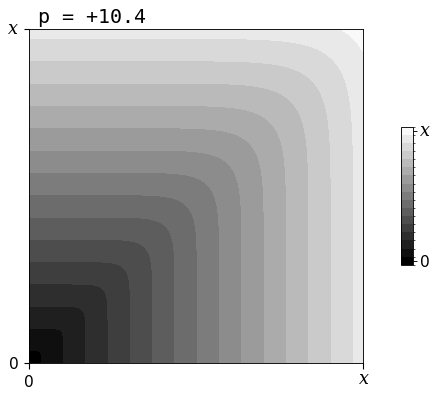

  9%|████████                                                                                      | 53/617 [00:07<01:14,  7.55it/s]

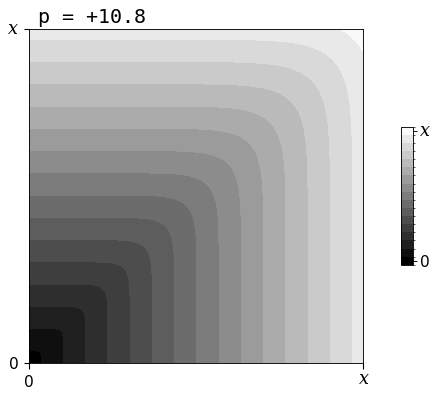

  9%|████████▏                                                                                     | 54/617 [00:07<01:14,  7.56it/s]

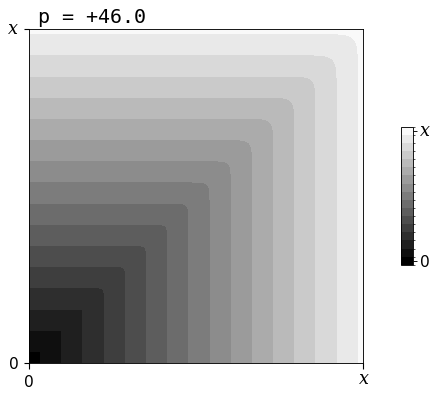

  9%|████████▍                                                                                     | 55/617 [00:07<01:13,  7.64it/s]

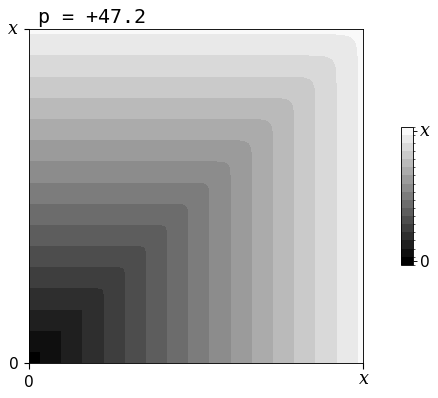

  9%|████████▌                                                                                     | 56/617 [00:07<01:19,  7.09it/s]

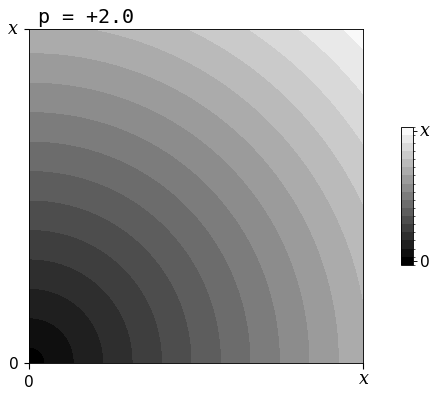

  9%|████████▋                                                                                     | 57/617 [00:07<01:17,  7.22it/s]

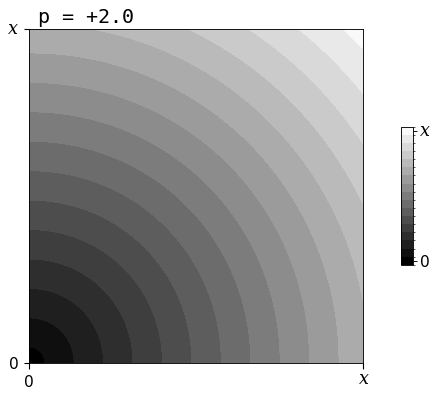

  9%|████████▊                                                                                     | 58/617 [00:07<01:16,  7.32it/s]

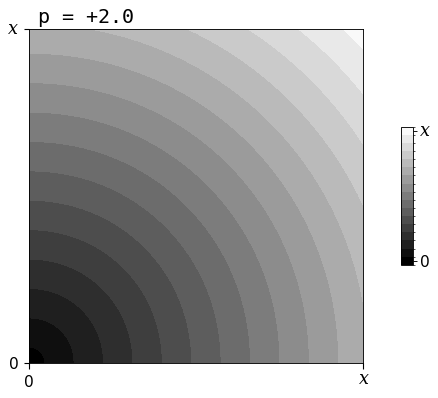

 10%|████████▉                                                                                     | 59/617 [00:08<01:15,  7.38it/s]

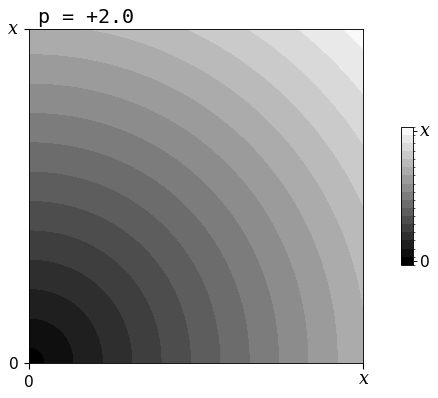

 10%|█████████▏                                                                                    | 60/617 [00:08<01:14,  7.43it/s]

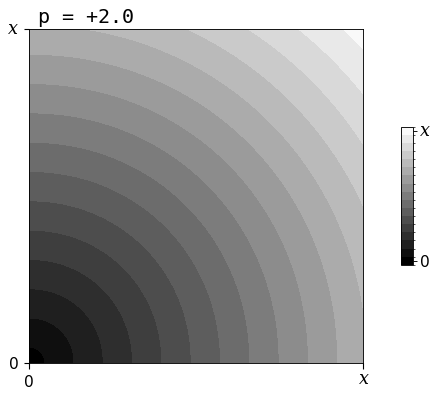

 10%|█████████▎                                                                                    | 61/617 [00:08<01:14,  7.50it/s]

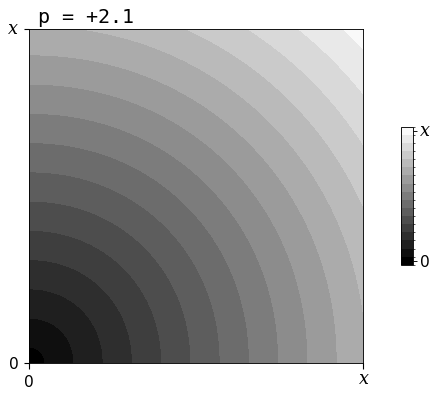

 10%|█████████▍                                                                                    | 62/617 [00:08<01:13,  7.51it/s]

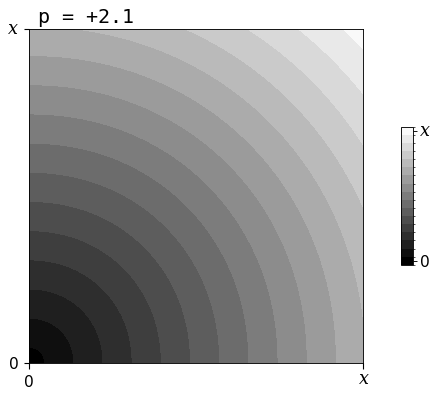

 10%|█████████▌                                                                                    | 63/617 [00:08<01:13,  7.54it/s]

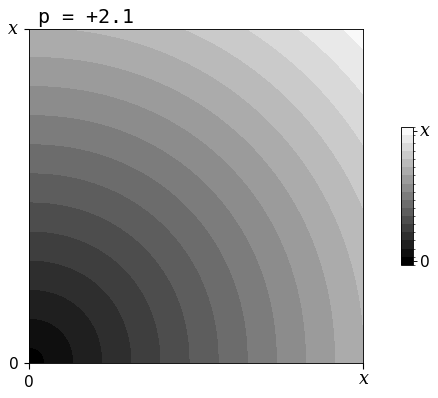

 10%|█████████▊                                                                                    | 64/617 [00:08<01:13,  7.56it/s]

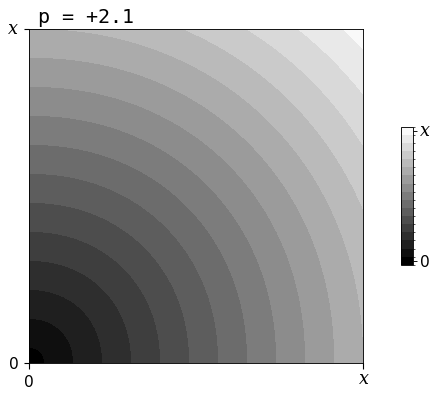

 11%|█████████▉                                                                                    | 65/617 [00:08<01:13,  7.53it/s]

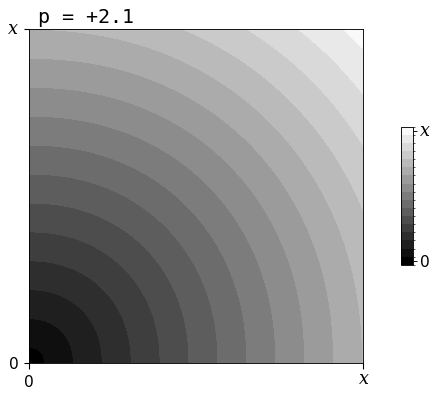

 11%|██████████                                                                                    | 66/617 [00:09<01:13,  7.54it/s]

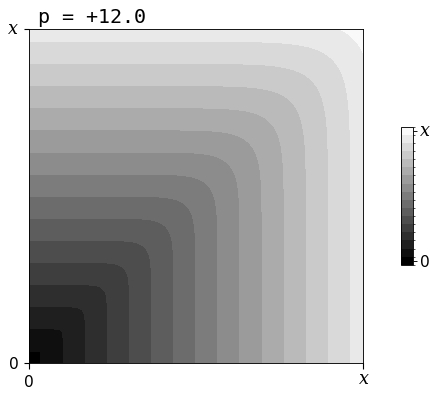

 11%|██████████▏                                                                                   | 67/617 [00:09<01:12,  7.59it/s]

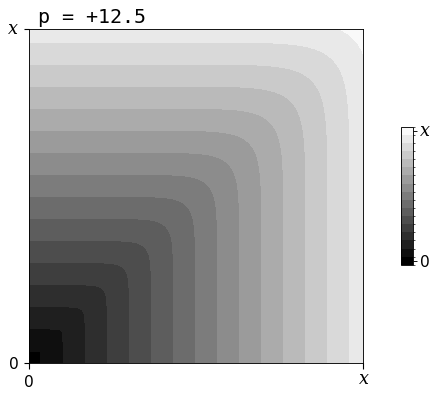

 11%|██████████▎                                                                                   | 68/617 [00:09<01:12,  7.62it/s]

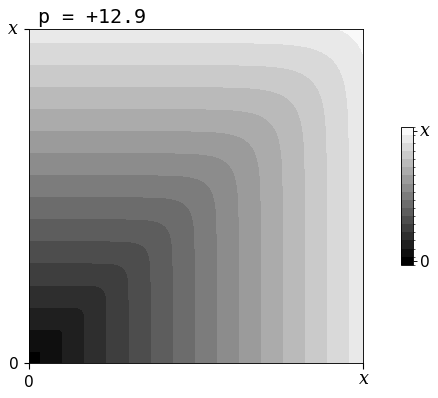

 11%|██████████▌                                                                                   | 69/617 [00:09<01:17,  7.06it/s]

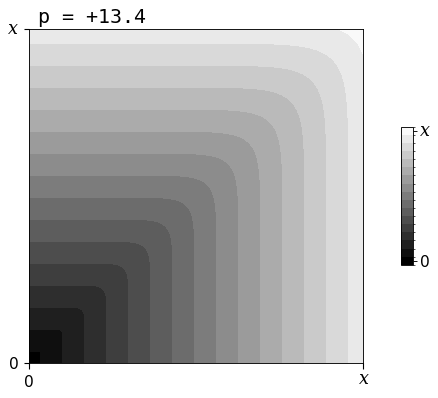

 11%|██████████▋                                                                                   | 70/617 [00:09<01:15,  7.24it/s]

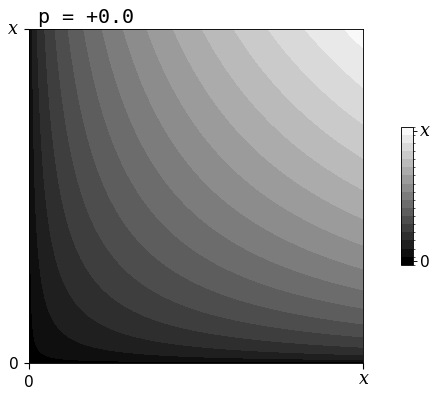

 12%|██████████▊                                                                                   | 71/617 [00:09<01:14,  7.33it/s]

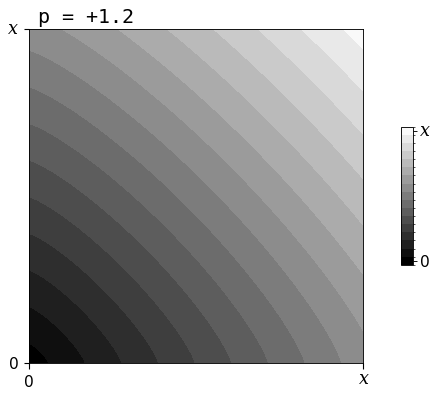

 12%|██████████▉                                                                                   | 72/617 [00:09<01:13,  7.41it/s]

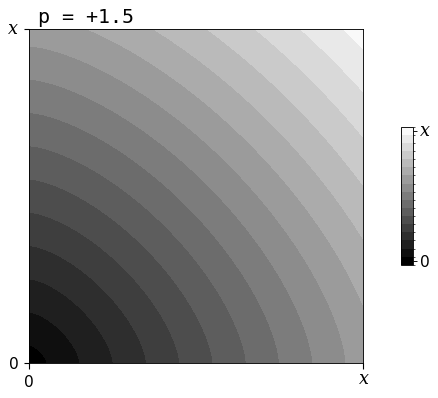

 12%|███████████                                                                                   | 73/617 [00:09<01:12,  7.45it/s]

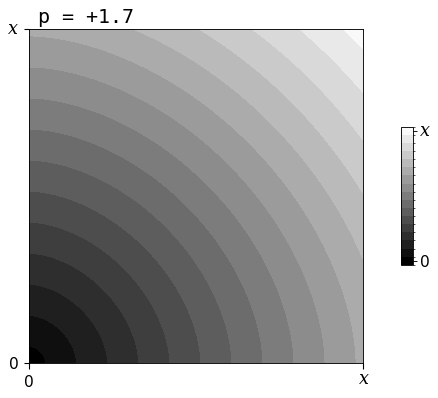

 12%|███████████▎                                                                                  | 74/617 [00:10<01:12,  7.49it/s]

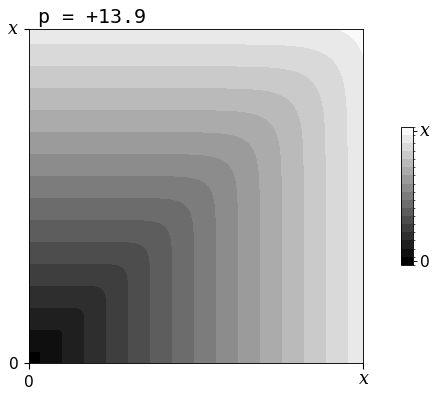

 12%|███████████▍                                                                                  | 75/617 [00:10<01:11,  7.55it/s]

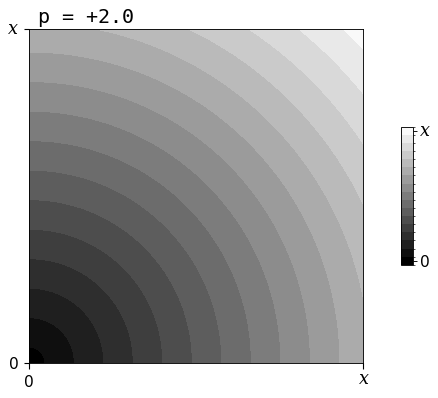

 12%|███████████▌                                                                                  | 76/617 [00:10<01:11,  7.55it/s]

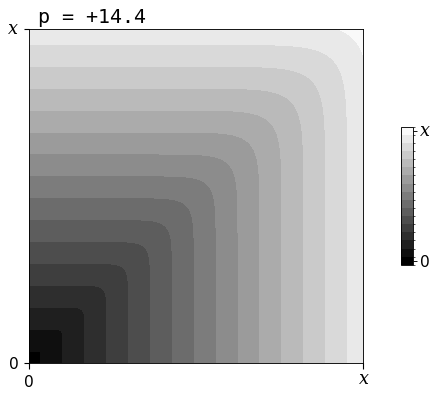

 12%|███████████▋                                                                                  | 77/617 [00:10<01:11,  7.58it/s]

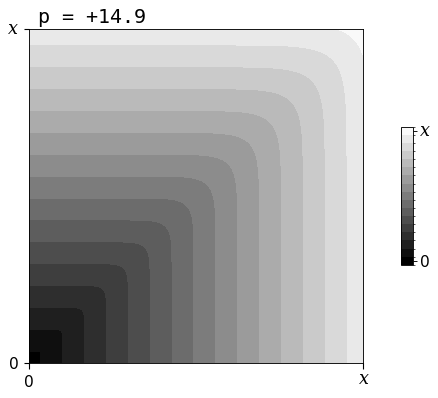

 13%|███████████▉                                                                                  | 78/617 [00:10<01:10,  7.63it/s]

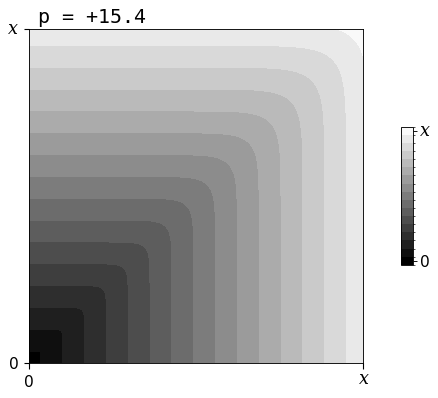

 13%|████████████                                                                                  | 79/617 [00:10<01:10,  7.64it/s]

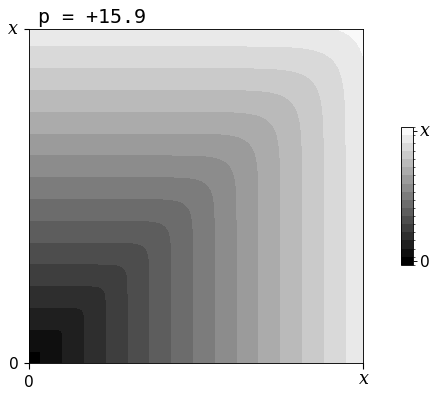

 13%|████████████▏                                                                                 | 80/617 [00:10<01:10,  7.66it/s]

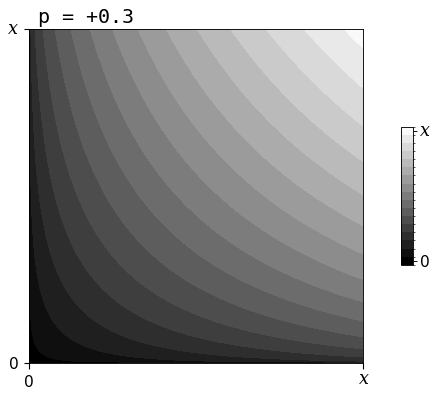

 13%|████████████▎                                                                                 | 81/617 [00:11<01:10,  7.57it/s]

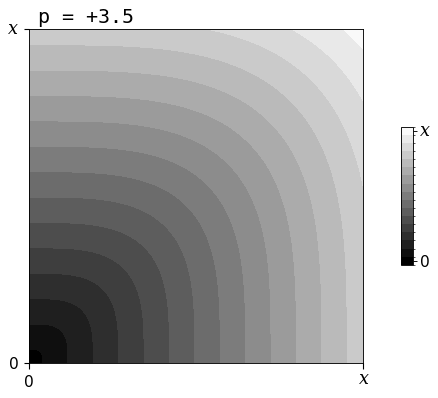

 13%|████████████▍                                                                                 | 82/617 [00:11<01:16,  6.99it/s]

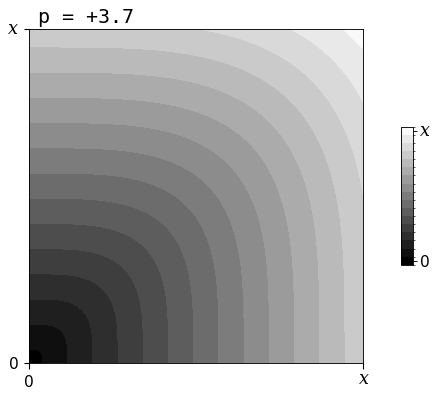

 13%|████████████▋                                                                                 | 83/617 [00:11<01:14,  7.16it/s]

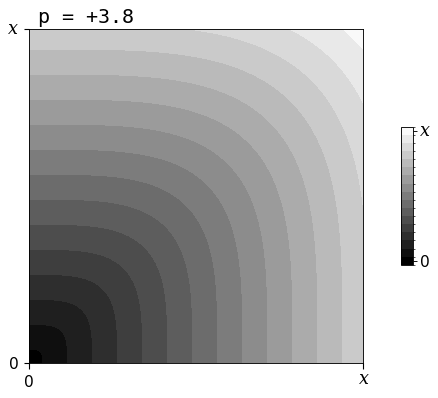

 14%|████████████▊                                                                                 | 84/617 [00:11<01:13,  7.29it/s]

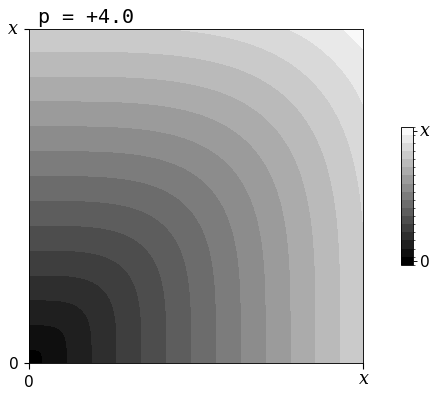

 14%|████████████▉                                                                                 | 85/617 [00:11<01:12,  7.37it/s]

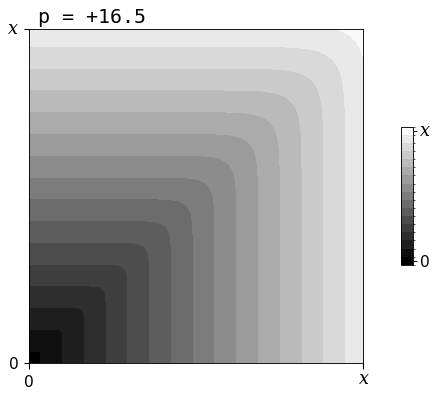

 14%|█████████████                                                                                 | 86/617 [00:11<01:11,  7.46it/s]

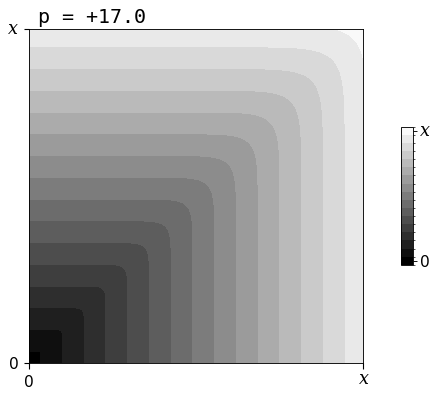

 14%|█████████████▎                                                                                | 87/617 [00:11<01:10,  7.53it/s]

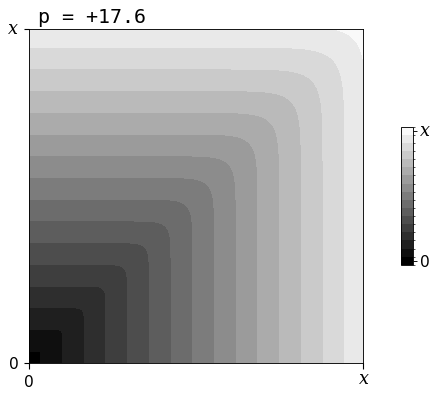

 14%|█████████████▍                                                                                | 88/617 [00:11<01:09,  7.56it/s]

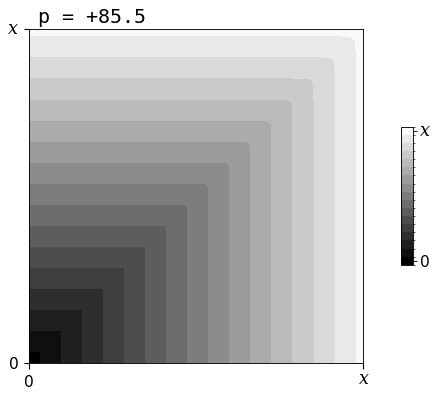

 14%|█████████████▌                                                                                | 89/617 [00:12<01:09,  7.61it/s]

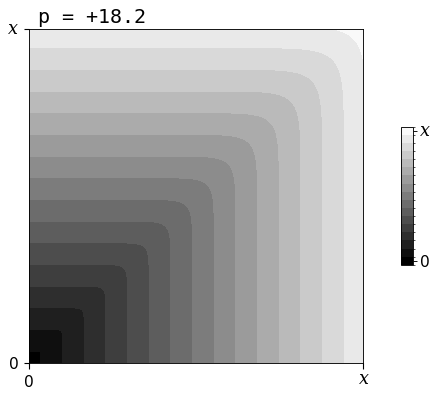

 15%|█████████████▋                                                                                | 90/617 [00:12<01:08,  7.65it/s]

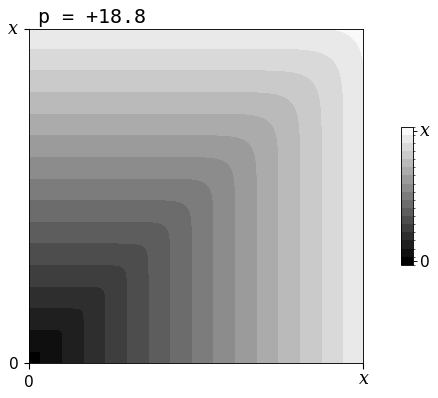

 15%|█████████████▊                                                                                | 91/617 [00:12<01:08,  7.66it/s]

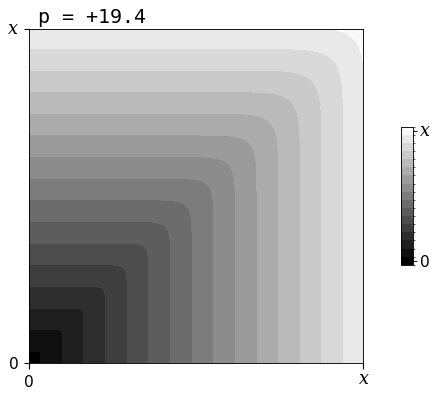

 15%|██████████████                                                                                | 92/617 [00:12<01:08,  7.67it/s]

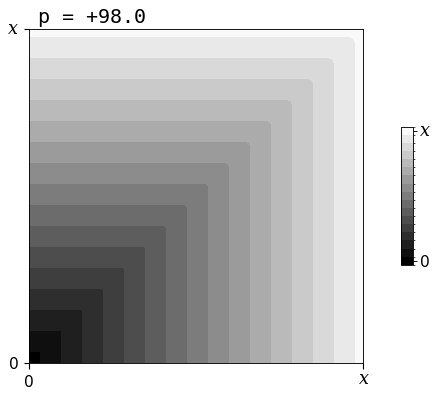

 15%|██████████████▏                                                                               | 93/617 [00:12<01:08,  7.63it/s]

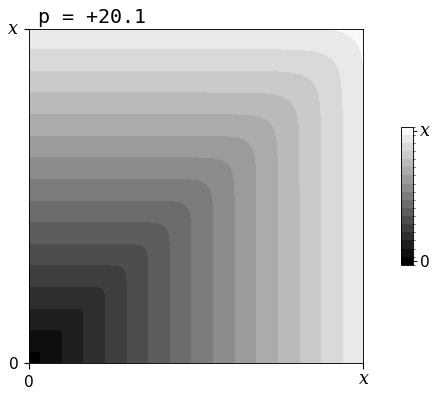

 15%|██████████████▎                                                                               | 94/617 [00:12<01:08,  7.65it/s]

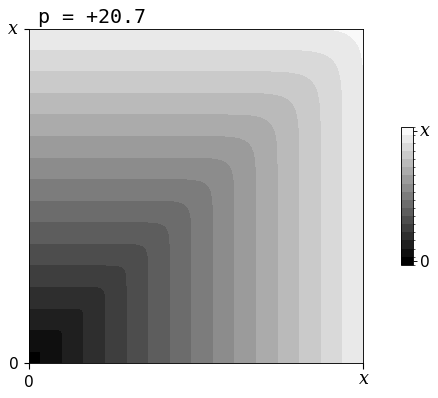

 15%|██████████████▍                                                                               | 95/617 [00:12<01:08,  7.66it/s]

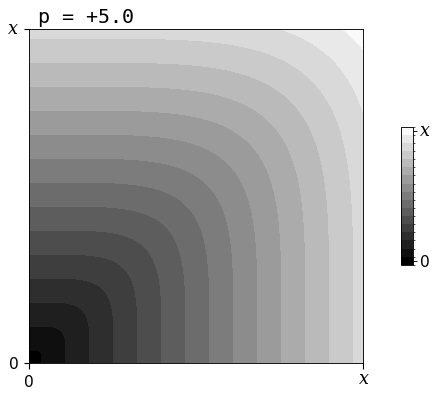

 16%|██████████████▋                                                                               | 96/617 [00:13<01:13,  7.06it/s]

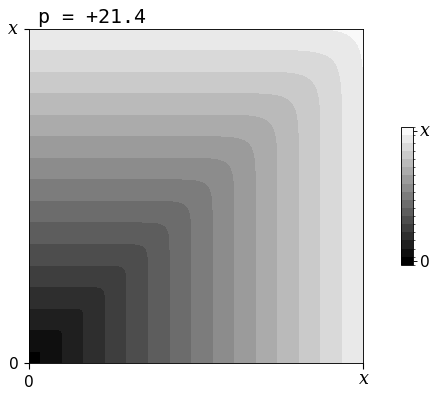

 16%|██████████████▊                                                                               | 97/617 [00:13<01:11,  7.24it/s]

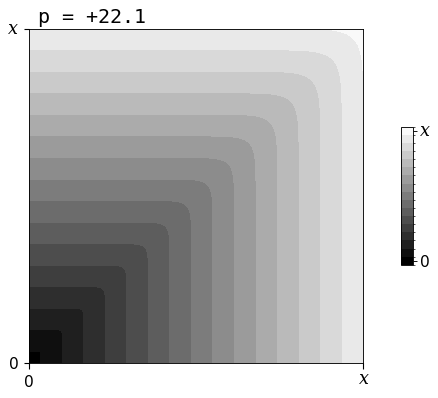

 16%|██████████████▉                                                                               | 98/617 [00:13<01:12,  7.21it/s]

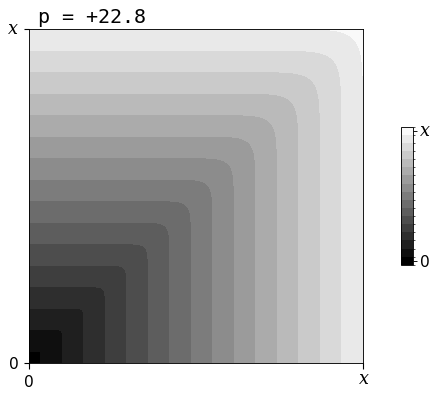

 16%|███████████████                                                                               | 99/617 [00:13<01:10,  7.32it/s]

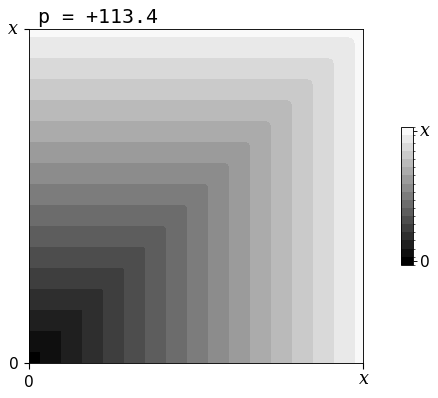

 16%|███████████████                                                                              | 100/617 [00:13<01:09,  7.44it/s]

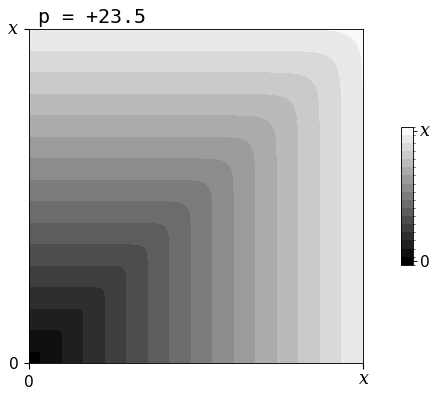

 16%|███████████████▏                                                                             | 101/617 [00:13<01:09,  7.46it/s]

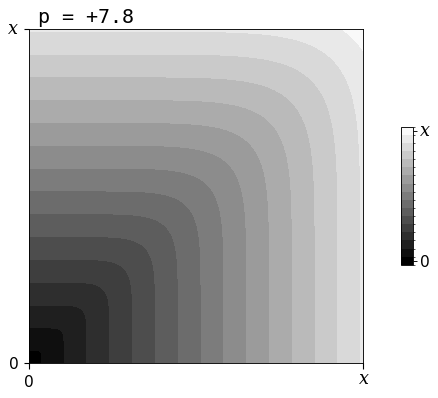

 17%|███████████████▎                                                                             | 102/617 [00:13<01:08,  7.52it/s]

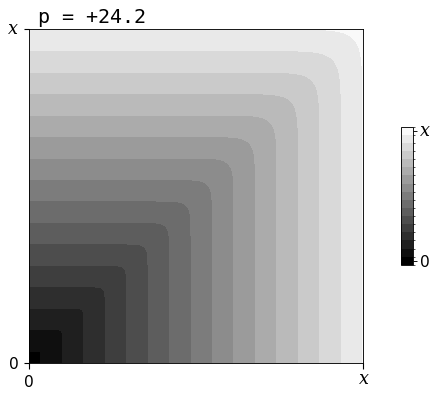

 17%|███████████████▌                                                                             | 103/617 [00:13<01:07,  7.58it/s]

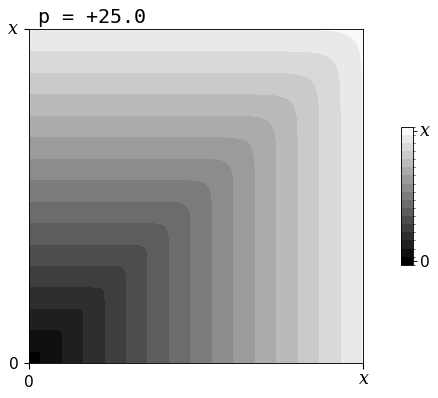

 17%|███████████████▋                                                                             | 104/617 [00:14<01:07,  7.62it/s]

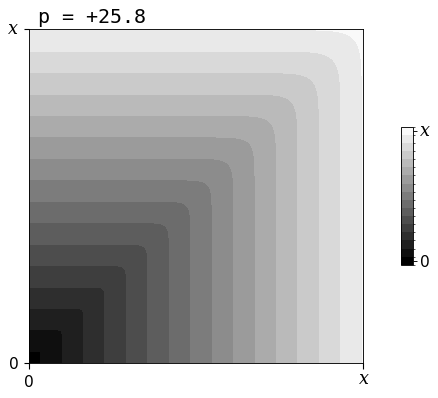

 17%|███████████████▊                                                                             | 105/617 [00:14<01:06,  7.69it/s]

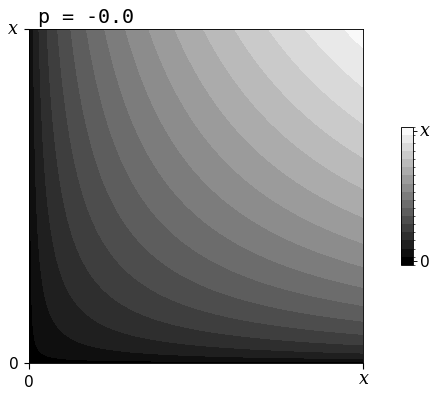

 17%|███████████████▉                                                                             | 106/617 [00:14<01:06,  7.63it/s]

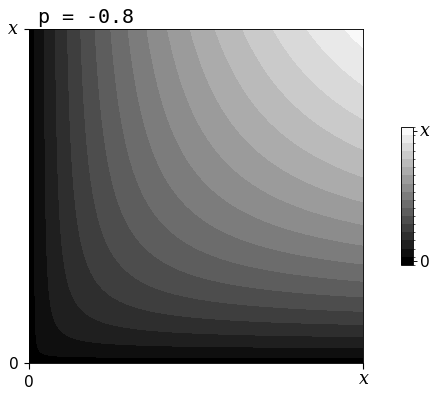

 17%|████████████████▏                                                                            | 107/617 [00:14<01:07,  7.60it/s]

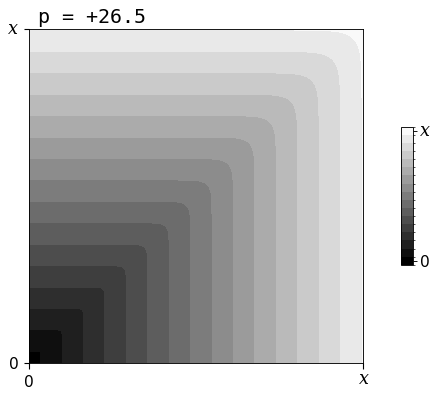

 18%|████████████████▎                                                                            | 108/617 [00:14<01:06,  7.65it/s]

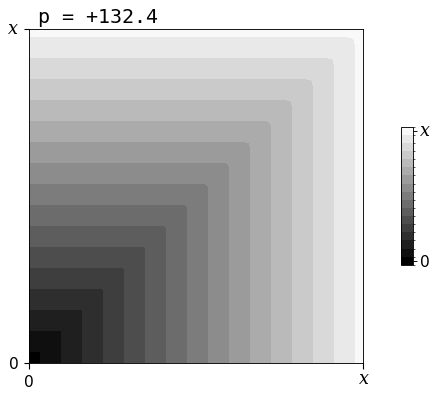

 18%|████████████████▍                                                                            | 109/617 [00:14<01:12,  7.04it/s]

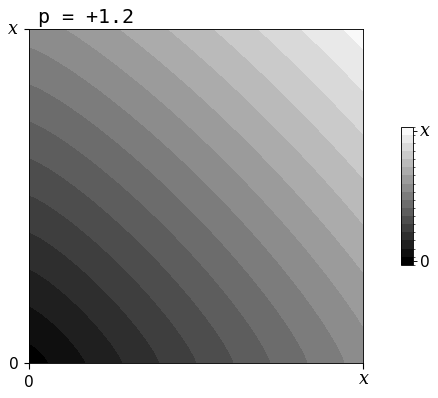

 18%|████████████████▌                                                                            | 110/617 [00:14<01:10,  7.15it/s]

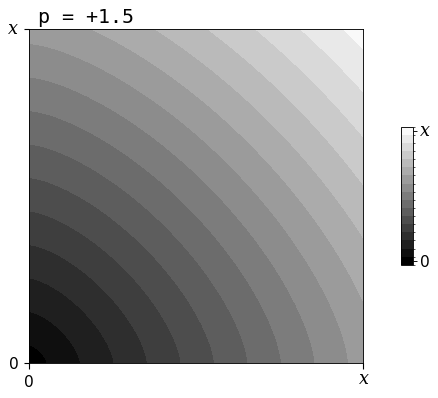

 18%|████████████████▋                                                                            | 111/617 [00:15<01:09,  7.24it/s]

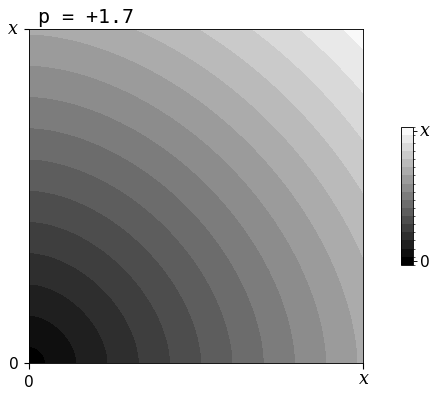

 18%|████████████████▉                                                                            | 112/617 [00:15<01:08,  7.32it/s]

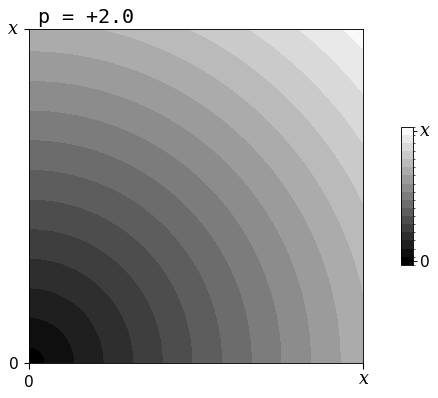

 18%|█████████████████                                                                            | 113/617 [00:15<01:08,  7.34it/s]

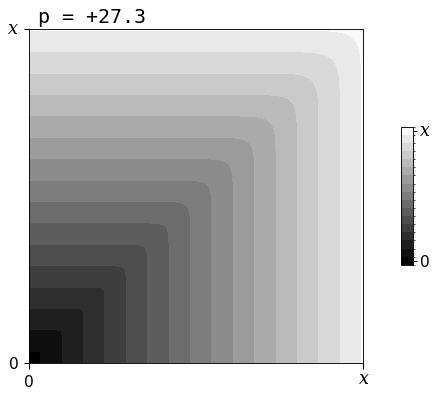

 18%|█████████████████▏                                                                           | 114/617 [00:15<01:07,  7.45it/s]

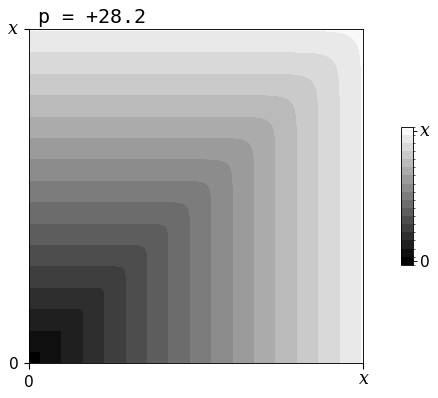

 19%|█████████████████▎                                                                           | 115/617 [00:15<01:06,  7.52it/s]

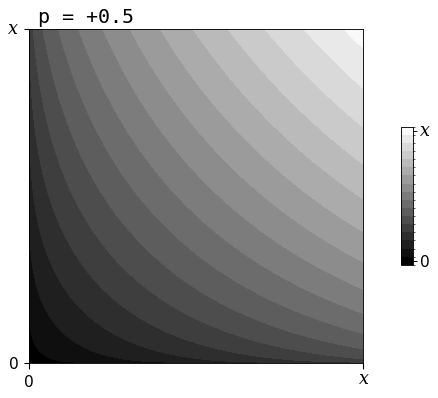

 19%|█████████████████▍                                                                           | 116/617 [00:15<01:06,  7.51it/s]

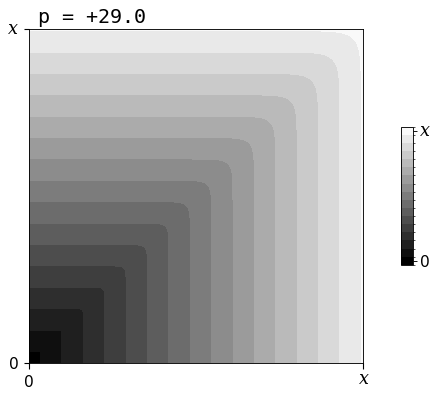

 19%|█████████████████▋                                                                           | 117/617 [00:15<01:06,  7.55it/s]

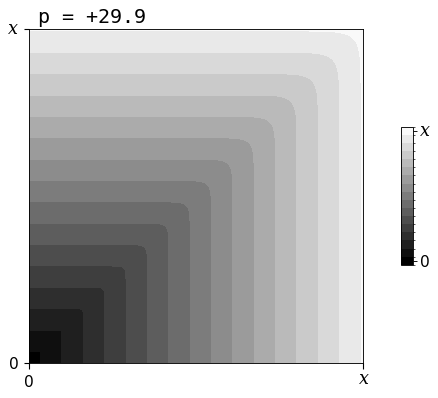

 19%|█████████████████▊                                                                           | 118/617 [00:15<01:05,  7.60it/s]

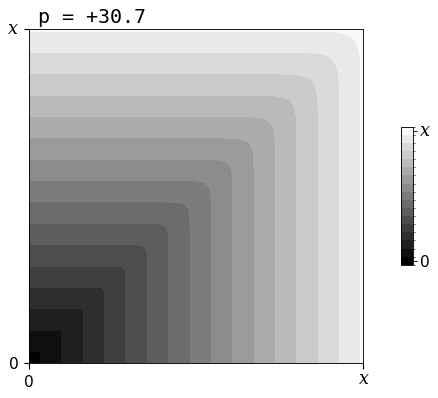

 19%|█████████████████▉                                                                           | 119/617 [00:16<01:04,  7.66it/s]

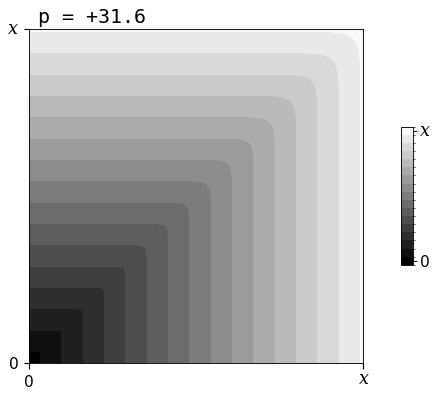

 19%|██████████████████                                                                           | 120/617 [00:16<01:04,  7.68it/s]

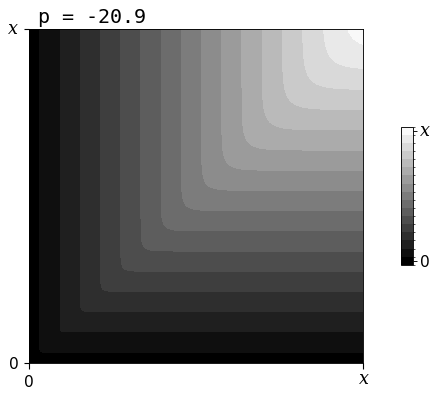

 20%|██████████████████▏                                                                          | 121/617 [00:16<01:04,  7.65it/s]

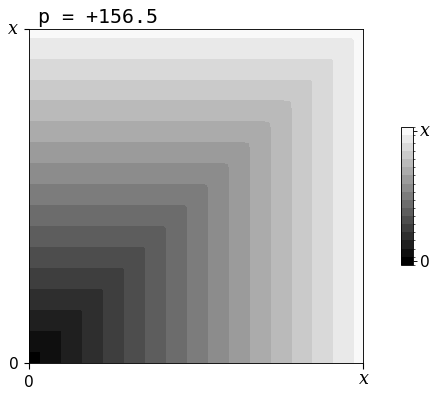

 20%|██████████████████▍                                                                          | 122/617 [00:16<01:09,  7.08it/s]

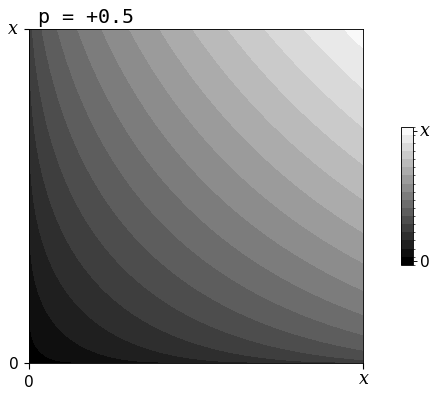

 20%|██████████████████▌                                                                          | 123/617 [00:16<01:08,  7.20it/s]

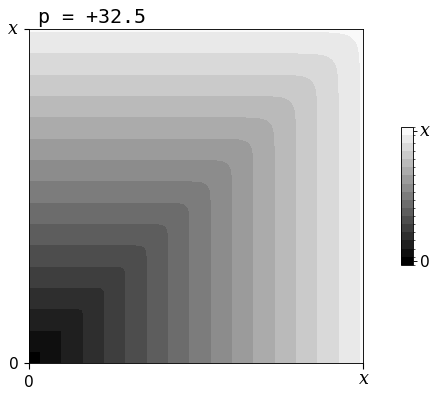

 20%|██████████████████▋                                                                          | 124/617 [00:16<01:07,  7.34it/s]

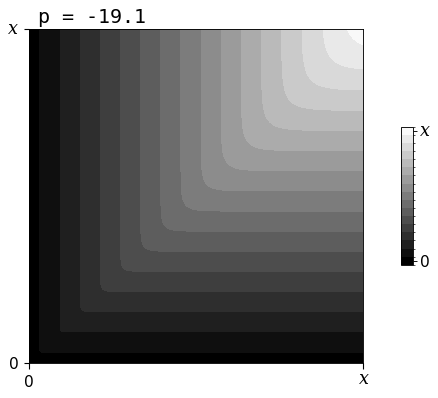

 20%|██████████████████▊                                                                          | 125/617 [00:16<01:06,  7.44it/s]

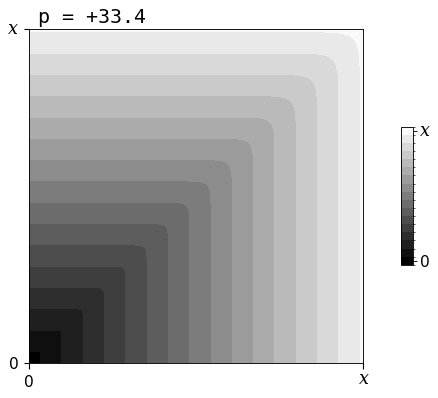

 20%|██████████████████▉                                                                          | 126/617 [00:17<01:05,  7.51it/s]

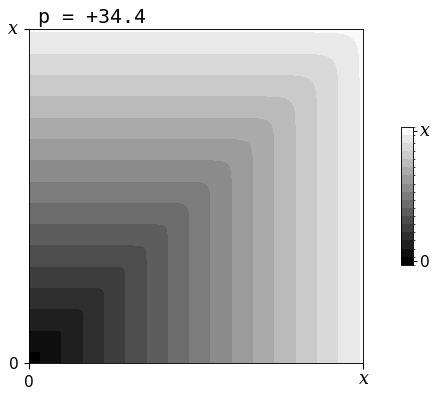

 21%|███████████████████▏                                                                         | 127/617 [00:17<01:04,  7.58it/s]

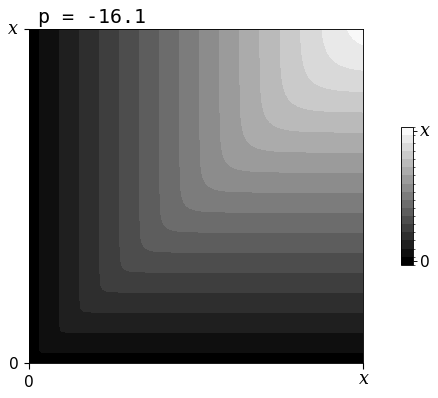

 21%|███████████████████▎                                                                         | 128/617 [00:17<01:04,  7.59it/s]

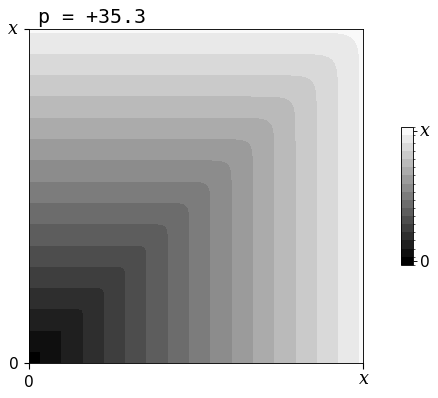

 21%|███████████████████▍                                                                         | 129/617 [00:17<01:04,  7.61it/s]

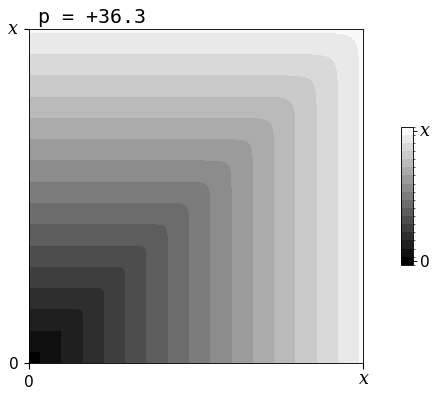

 21%|███████████████████▌                                                                         | 130/617 [00:17<01:03,  7.65it/s]

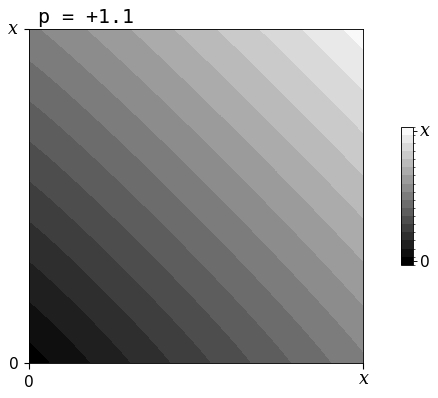

 21%|███████████████████▋                                                                         | 131/617 [00:17<01:03,  7.65it/s]

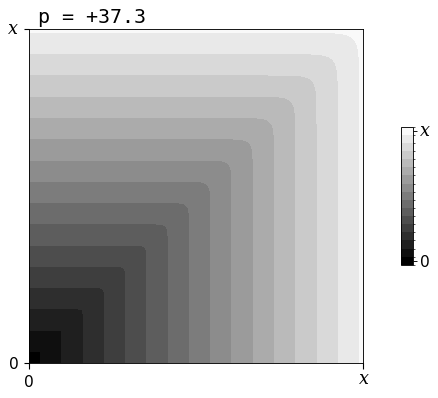

 21%|███████████████████▉                                                                         | 132/617 [00:17<01:03,  7.67it/s]

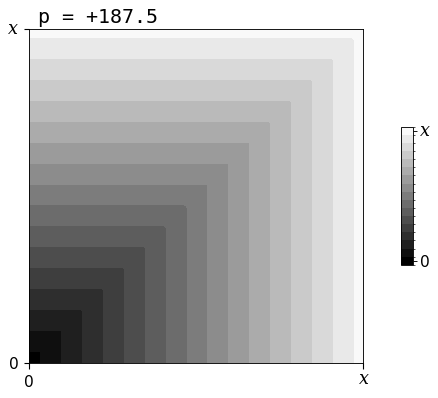

 22%|████████████████████                                                                         | 133/617 [00:17<01:03,  7.68it/s]

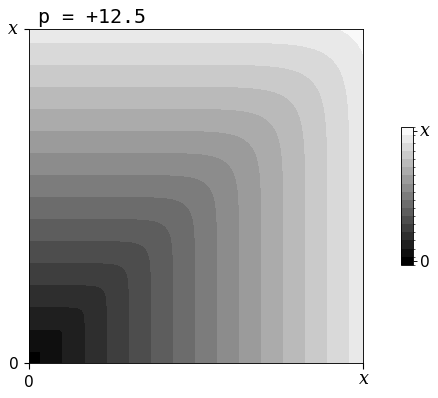

 22%|████████████████████▏                                                                        | 134/617 [00:18<01:02,  7.69it/s]

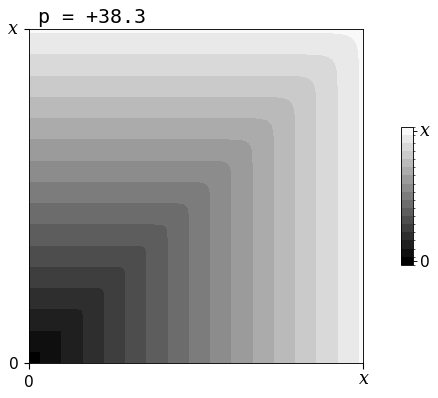

 22%|████████████████████▎                                                                        | 135/617 [00:18<01:07,  7.09it/s]

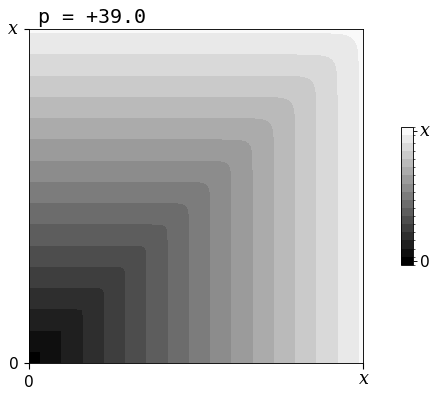

 22%|████████████████████▍                                                                        | 136/617 [00:18<01:06,  7.28it/s]

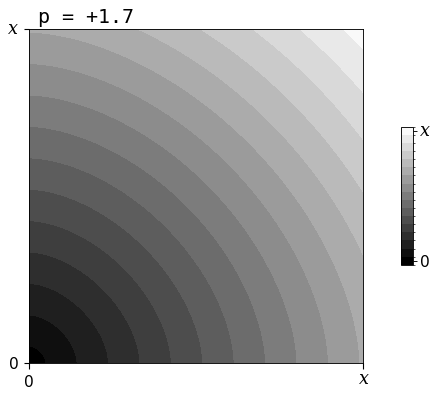

 22%|████████████████████▋                                                                        | 137/617 [00:18<01:05,  7.37it/s]

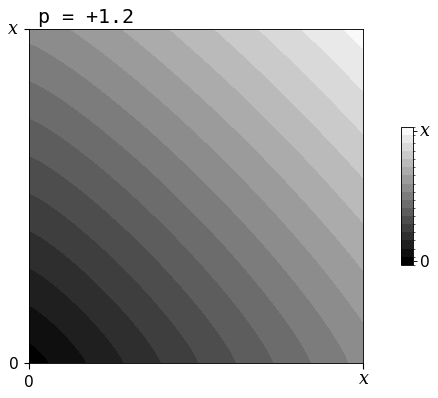

 22%|████████████████████▊                                                                        | 138/617 [00:18<01:04,  7.42it/s]

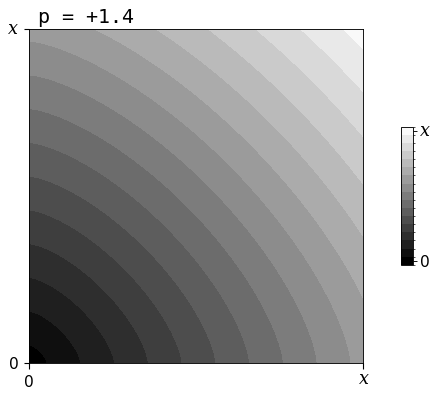

 23%|████████████████████▉                                                                        | 139/617 [00:18<01:04,  7.46it/s]

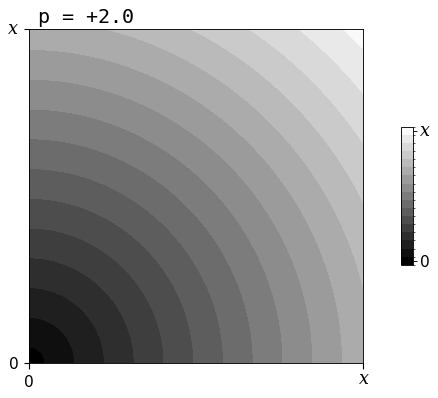

 23%|█████████████████████                                                                        | 140/617 [00:18<01:03,  7.49it/s]

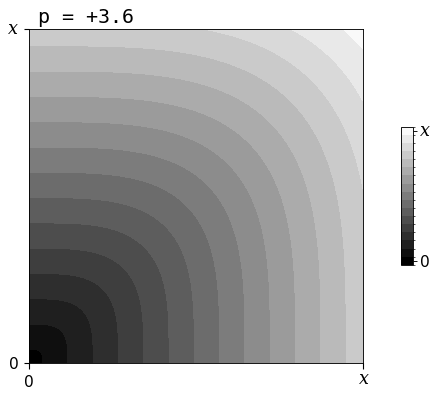

 23%|█████████████████████▎                                                                       | 141/617 [00:19<01:03,  7.53it/s]

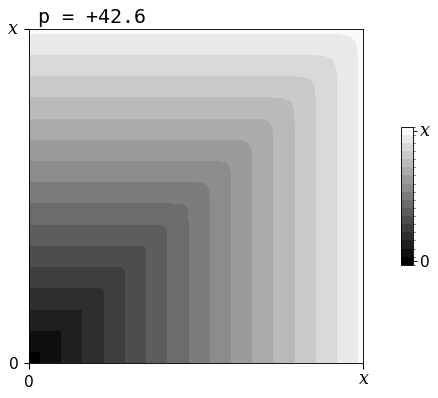

 23%|█████████████████████▍                                                                       | 142/617 [00:19<01:02,  7.61it/s]

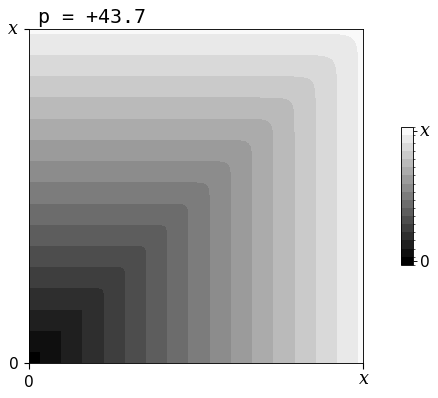

 23%|█████████████████████▌                                                                       | 143/617 [00:19<01:02,  7.64it/s]

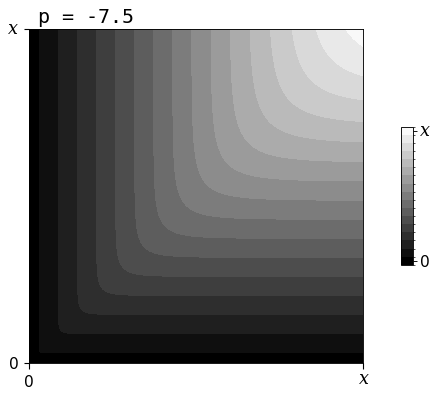

 23%|█████████████████████▋                                                                       | 144/617 [00:19<01:02,  7.62it/s]

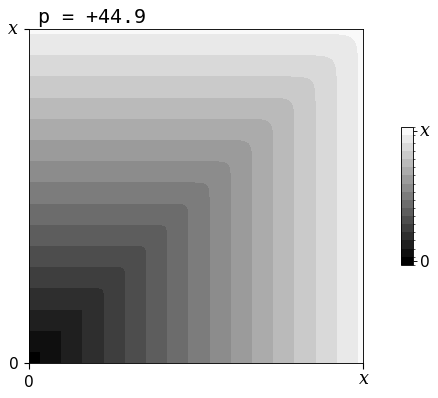

 24%|█████████████████████▊                                                                       | 145/617 [00:19<01:01,  7.65it/s]

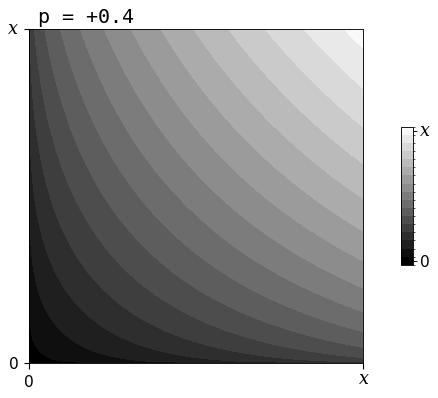

 24%|██████████████████████                                                                       | 146/617 [00:19<01:01,  7.62it/s]

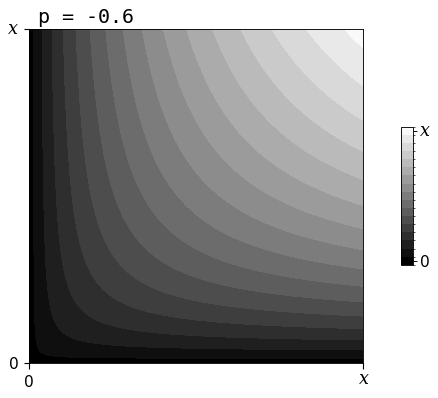

 24%|██████████████████████▏                                                                      | 147/617 [00:19<01:01,  7.59it/s]

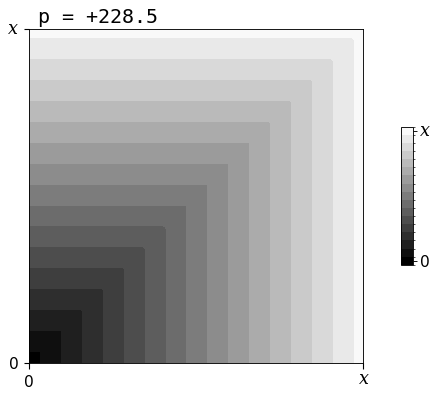

 24%|██████████████████████▎                                                                      | 148/617 [00:19<01:01,  7.64it/s]

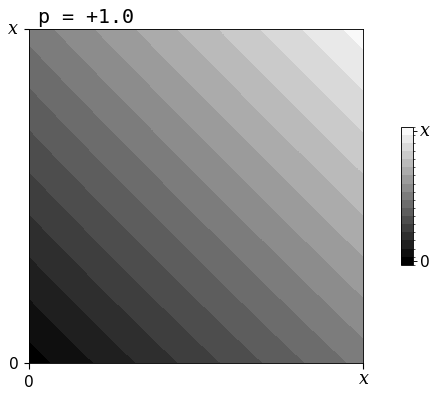

 24%|██████████████████████▍                                                                      | 149/617 [00:20<01:06,  7.03it/s]

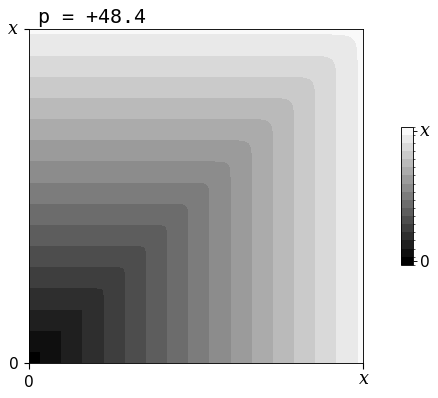

 24%|██████████████████████▌                                                                      | 150/617 [00:20<01:04,  7.23it/s]

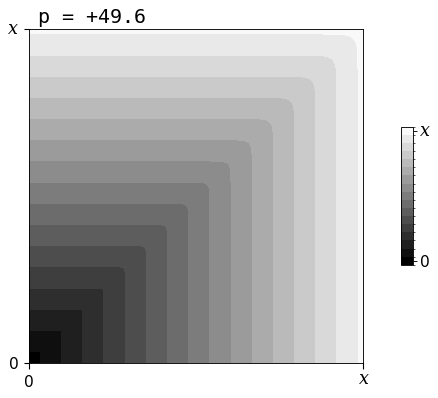

 24%|██████████████████████▊                                                                      | 151/617 [00:20<01:03,  7.38it/s]

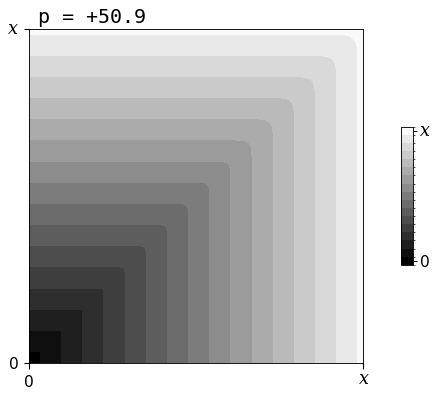

 25%|██████████████████████▉                                                                      | 152/617 [00:20<01:02,  7.50it/s]

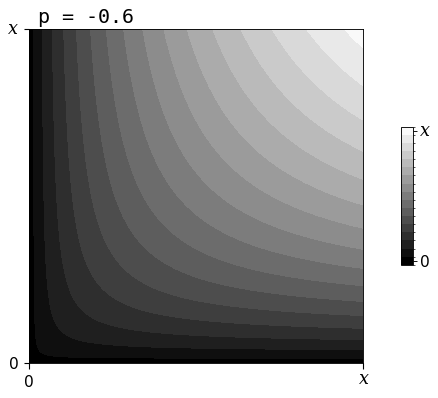

 25%|███████████████████████                                                                      | 153/617 [00:20<01:01,  7.51it/s]

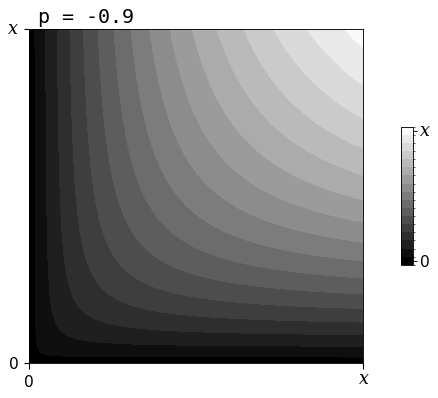

 25%|███████████████████████▏                                                                     | 154/617 [00:20<01:01,  7.51it/s]

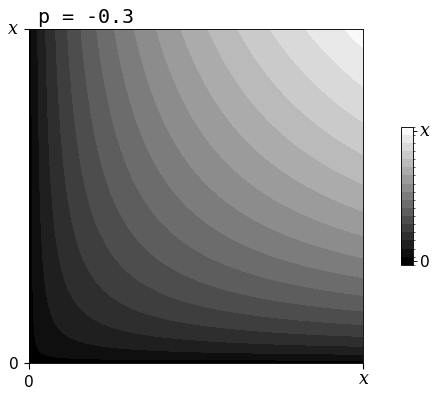

 25%|███████████████████████▎                                                                     | 155/617 [00:20<01:01,  7.50it/s]

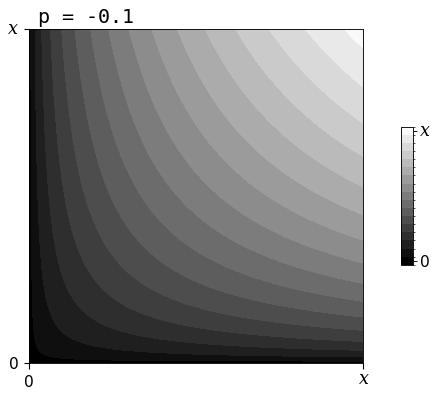

 25%|███████████████████████▌                                                                     | 156/617 [00:21<01:01,  7.51it/s]

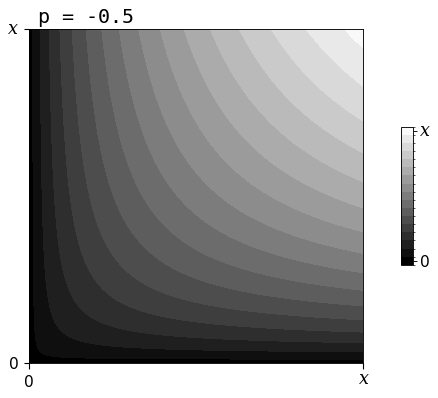

 25%|███████████████████████▋                                                                     | 157/617 [00:21<01:01,  7.53it/s]

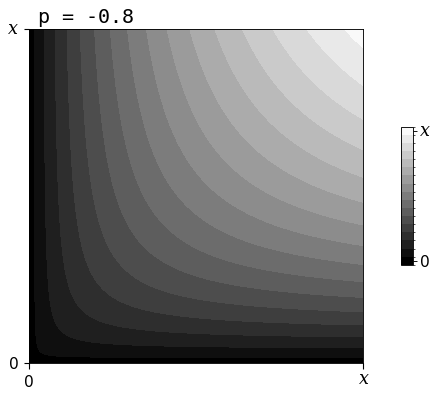

 26%|███████████████████████▊                                                                     | 158/617 [00:21<01:00,  7.53it/s]

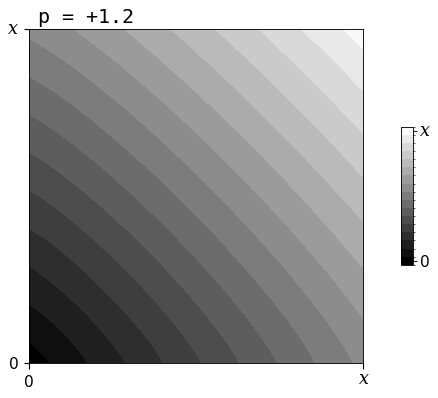

 26%|███████████████████████▉                                                                     | 159/617 [00:21<01:00,  7.54it/s]

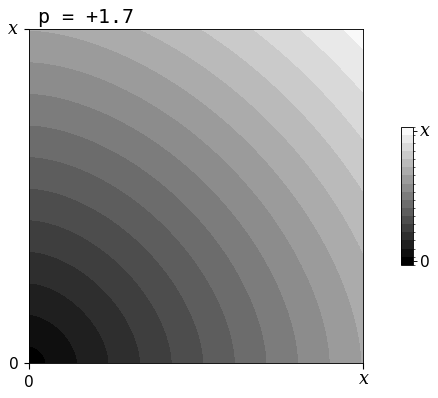

 26%|████████████████████████                                                                     | 160/617 [00:21<01:00,  7.57it/s]

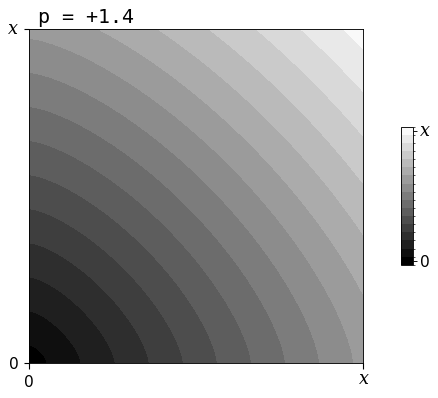

 26%|████████████████████████▎                                                                    | 161/617 [00:21<01:00,  7.57it/s]

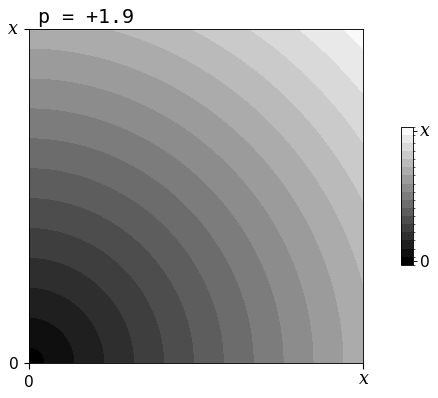

 26%|████████████████████████▍                                                                    | 162/617 [00:21<01:05,  6.99it/s]

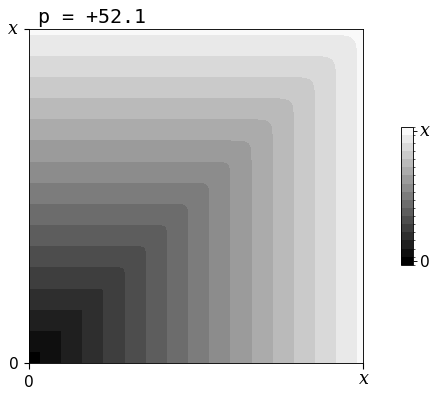

 26%|████████████████████████▌                                                                    | 163/617 [00:22<01:03,  7.20it/s]

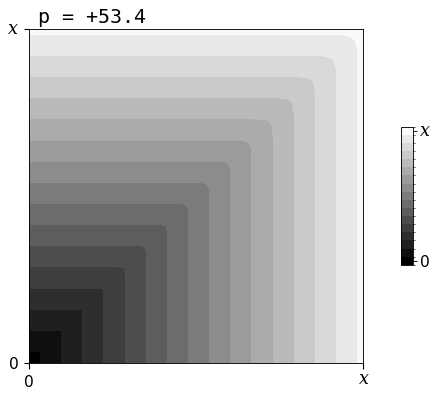

 27%|████████████████████████▋                                                                    | 164/617 [00:22<01:01,  7.35it/s]

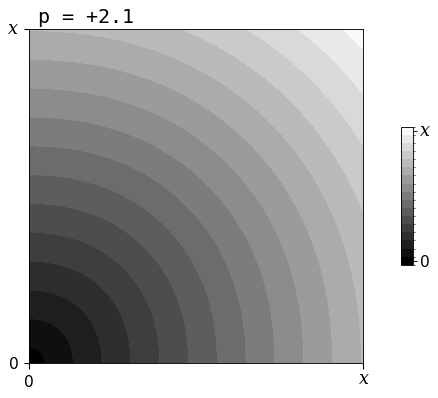

 27%|████████████████████████▊                                                                    | 165/617 [00:22<01:00,  7.45it/s]

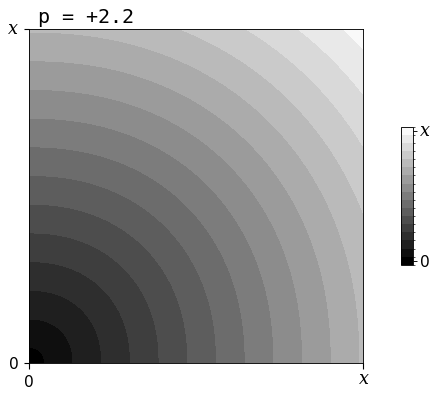

 27%|█████████████████████████                                                                    | 166/617 [00:22<01:00,  7.47it/s]

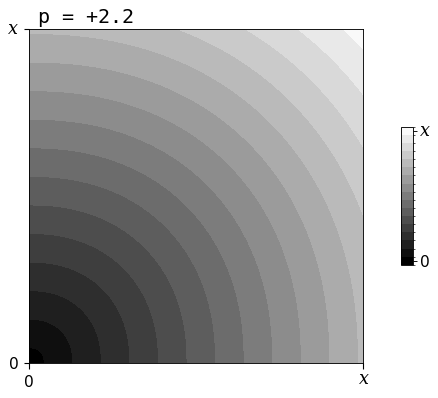

 27%|█████████████████████████▏                                                                   | 167/617 [00:22<00:59,  7.51it/s]

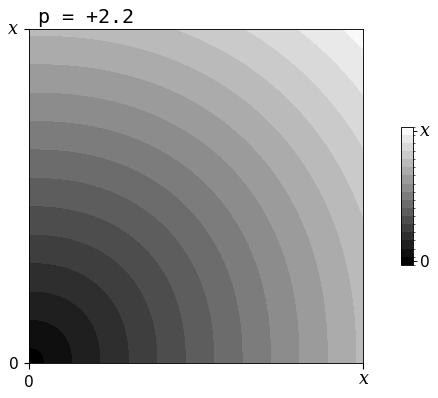

 27%|█████████████████████████▎                                                                   | 168/617 [00:22<00:59,  7.54it/s]

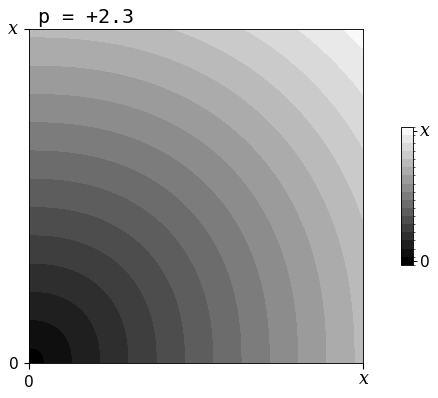

 27%|█████████████████████████▍                                                                   | 169/617 [00:22<00:59,  7.54it/s]

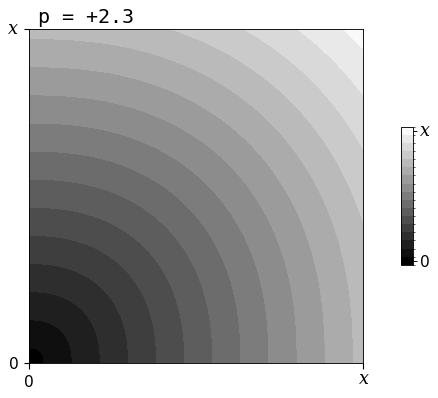

 28%|█████████████████████████▌                                                                   | 170/617 [00:22<00:59,  7.55it/s]

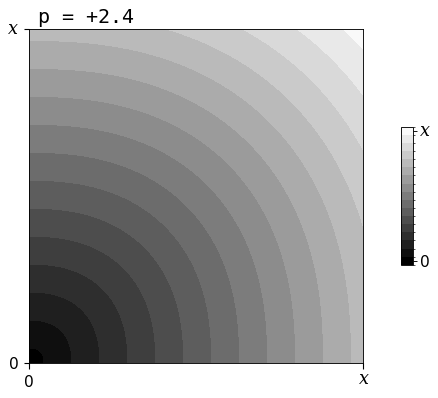

 28%|█████████████████████████▊                                                                   | 171/617 [00:23<00:58,  7.59it/s]

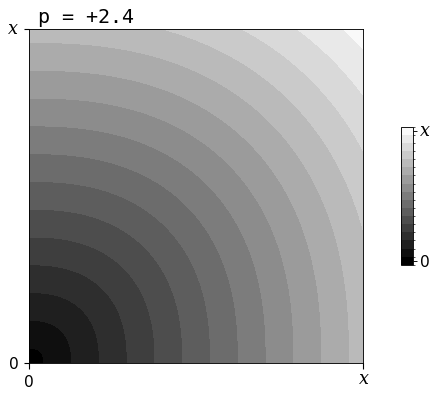

 28%|█████████████████████████▉                                                                   | 172/617 [00:23<00:58,  7.59it/s]

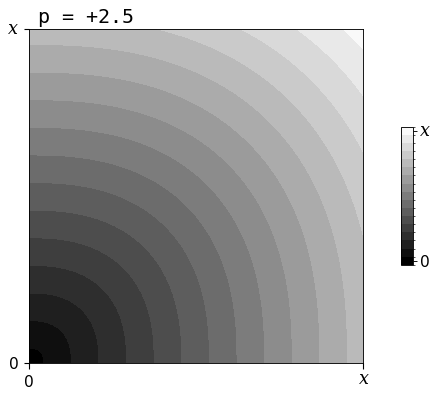

 28%|██████████████████████████                                                                   | 173/617 [00:23<00:58,  7.59it/s]

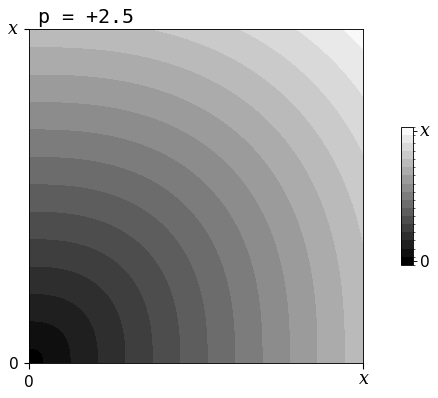

 28%|██████████████████████████▏                                                                  | 174/617 [00:23<00:58,  7.58it/s]

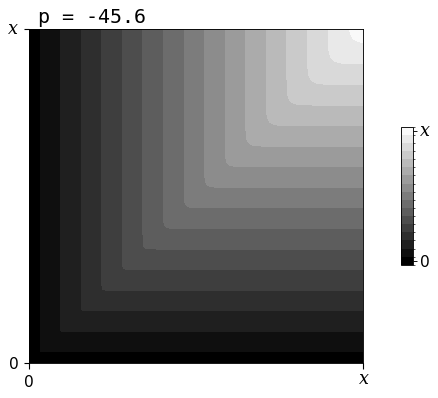

 28%|██████████████████████████▍                                                                  | 175/617 [00:23<01:03,  6.97it/s]

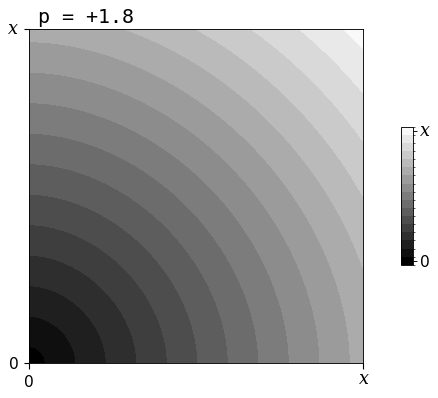

 29%|██████████████████████████▌                                                                  | 176/617 [00:23<01:02,  7.11it/s]

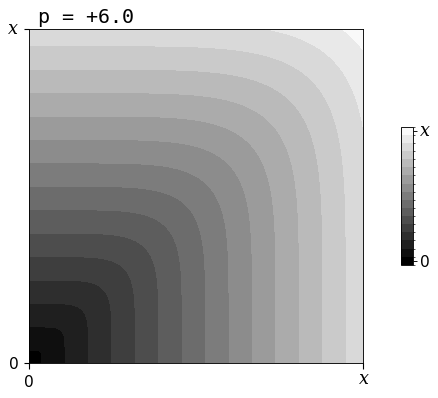

 29%|██████████████████████████▋                                                                  | 177/617 [00:23<01:00,  7.28it/s]

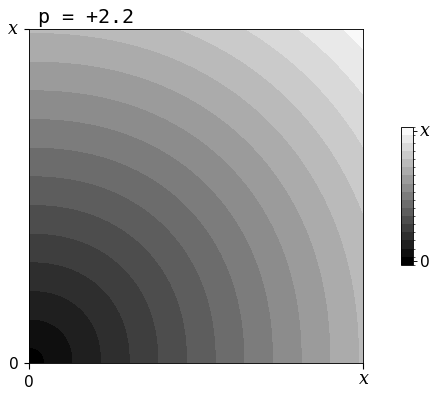

 29%|██████████████████████████▊                                                                  | 178/617 [00:24<00:59,  7.36it/s]

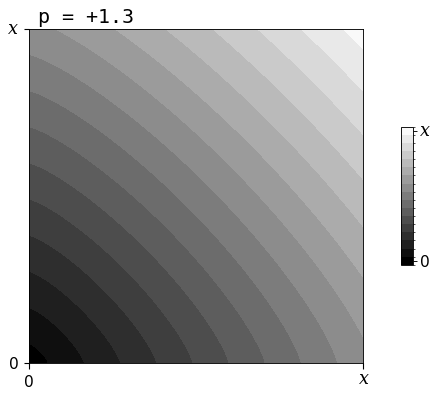

 29%|██████████████████████████▉                                                                  | 179/617 [00:24<00:59,  7.42it/s]

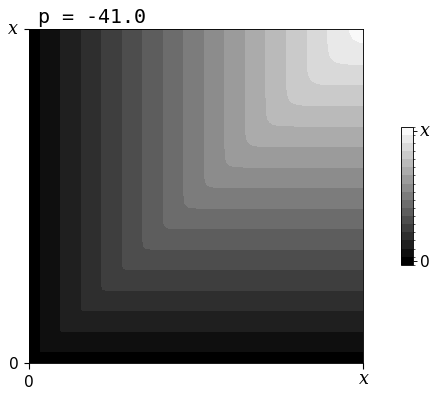

 29%|███████████████████████████▏                                                                 | 180/617 [00:24<00:58,  7.48it/s]

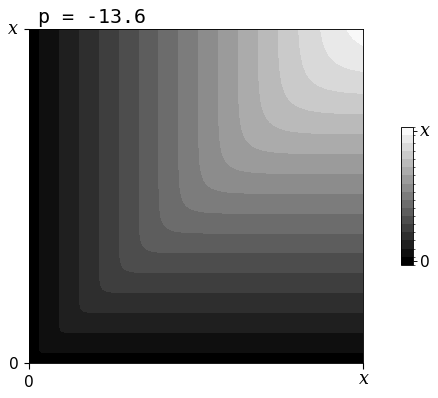

 29%|███████████████████████████▎                                                                 | 181/617 [00:24<00:58,  7.50it/s]

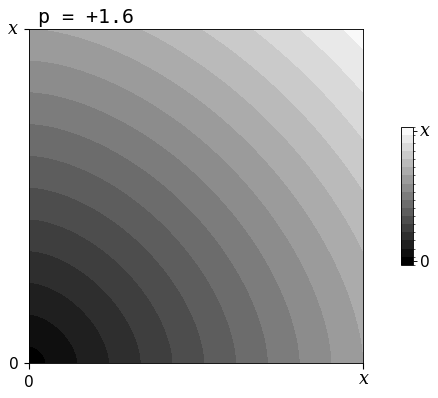

 29%|███████████████████████████▍                                                                 | 182/617 [00:24<00:57,  7.51it/s]

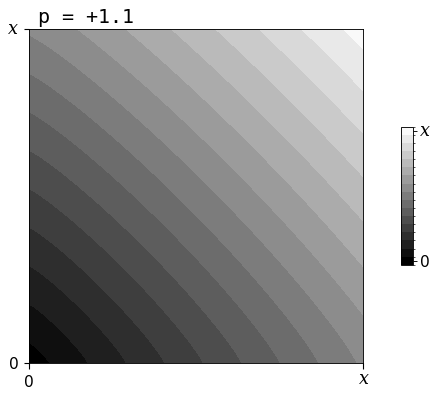

 30%|███████████████████████████▌                                                                 | 183/617 [00:24<00:57,  7.53it/s]

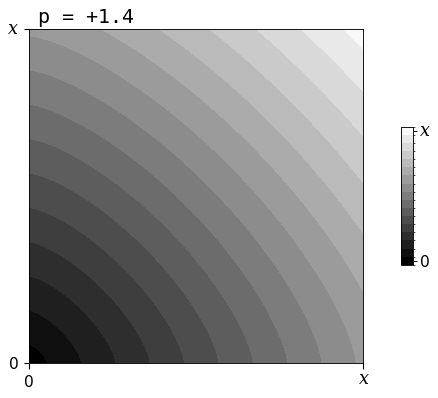

 30%|███████████████████████████▋                                                                 | 184/617 [00:24<00:57,  7.54it/s]

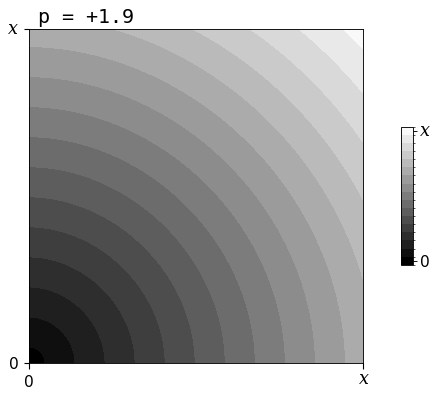

 30%|███████████████████████████▉                                                                 | 185/617 [00:24<00:57,  7.56it/s]

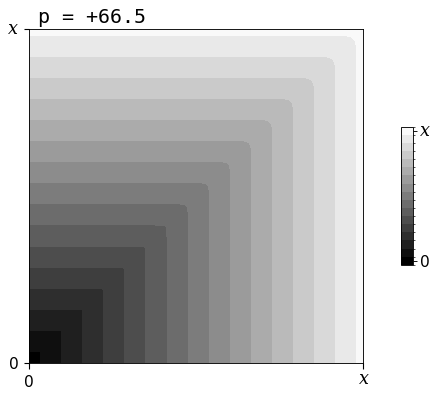

 30%|████████████████████████████                                                                 | 186/617 [00:25<00:56,  7.59it/s]

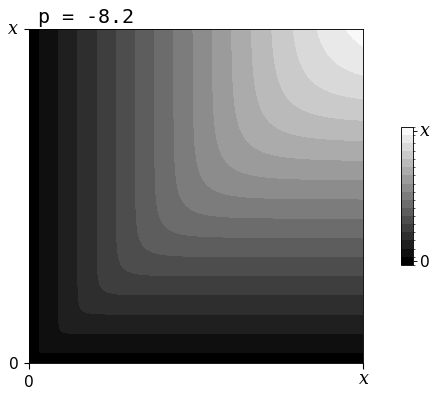

 30%|████████████████████████████▏                                                                | 187/617 [00:25<00:56,  7.59it/s]

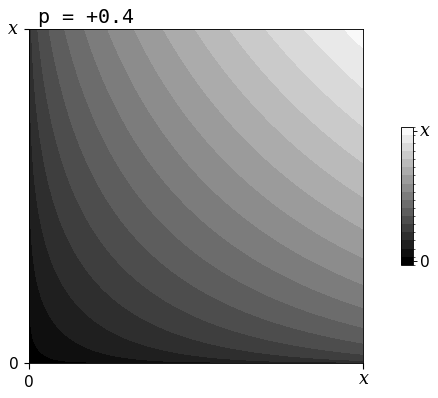

 30%|████████████████████████████▎                                                                | 188/617 [00:25<00:56,  7.56it/s]

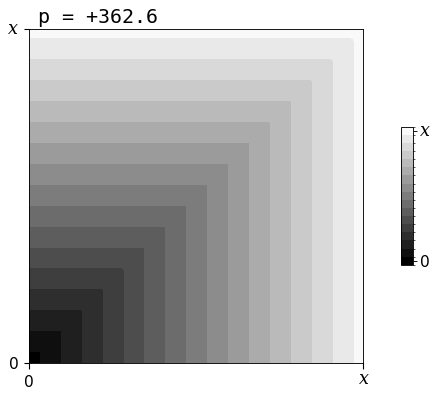

 31%|████████████████████████████▍                                                                | 189/617 [00:25<01:01,  7.00it/s]

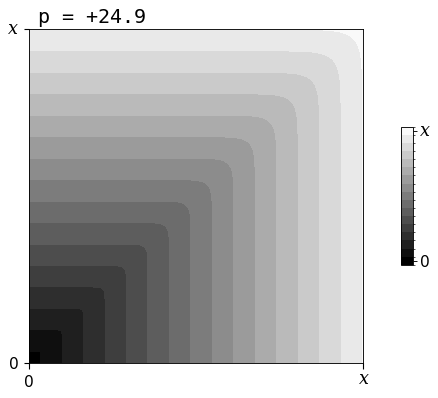

 31%|████████████████████████████▋                                                                | 190/617 [00:25<00:59,  7.20it/s]

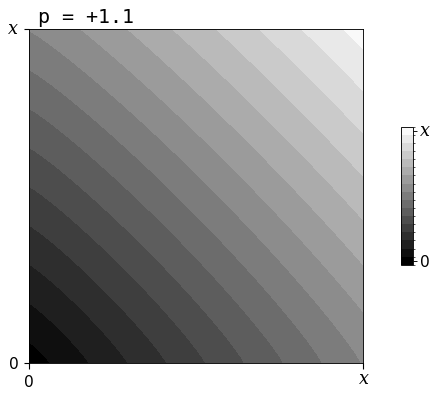

 31%|████████████████████████████▊                                                                | 191/617 [00:25<00:58,  7.27it/s]

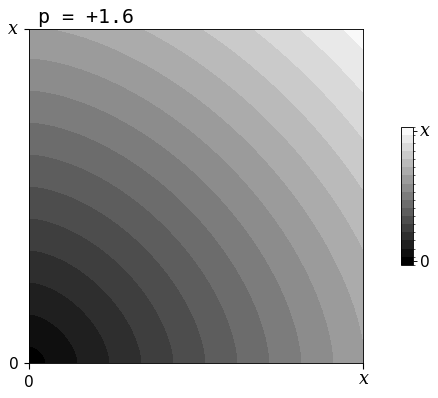

 31%|████████████████████████████▉                                                                | 192/617 [00:25<00:57,  7.35it/s]

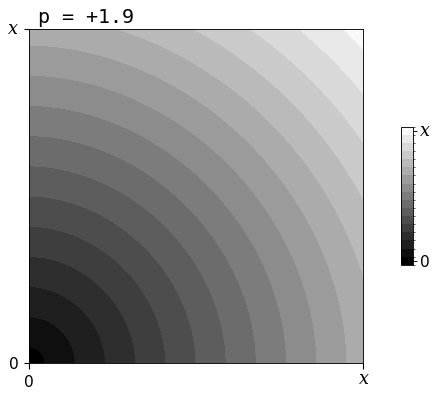

 31%|█████████████████████████████                                                                | 193/617 [00:26<00:57,  7.42it/s]

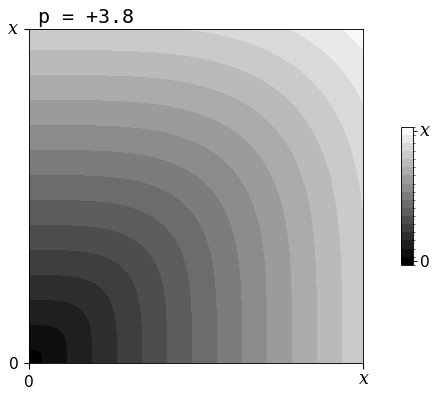

 31%|█████████████████████████████▏                                                               | 194/617 [00:26<00:56,  7.48it/s]

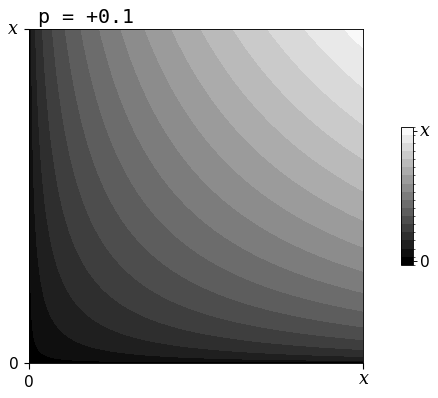

 32%|█████████████████████████████▍                                                               | 195/617 [00:26<00:56,  7.51it/s]

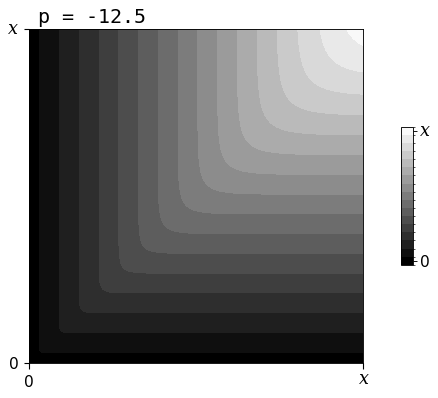

 32%|█████████████████████████████▌                                                               | 196/617 [00:26<00:56,  7.45it/s]

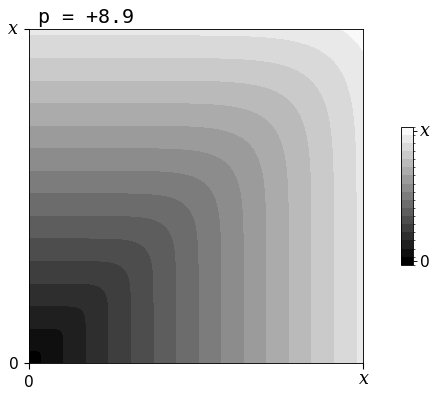

 32%|█████████████████████████████▋                                                               | 197/617 [00:26<00:55,  7.51it/s]

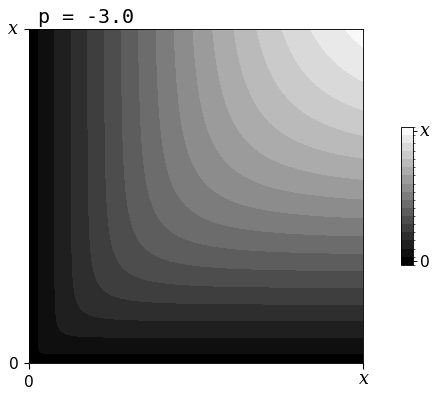

 32%|█████████████████████████████▊                                                               | 198/617 [00:26<00:55,  7.51it/s]

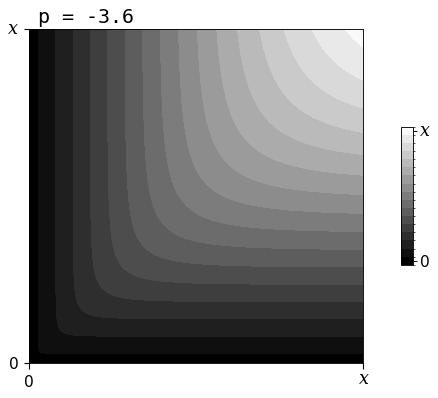

 32%|█████████████████████████████▉                                                               | 199/617 [00:26<00:55,  7.52it/s]

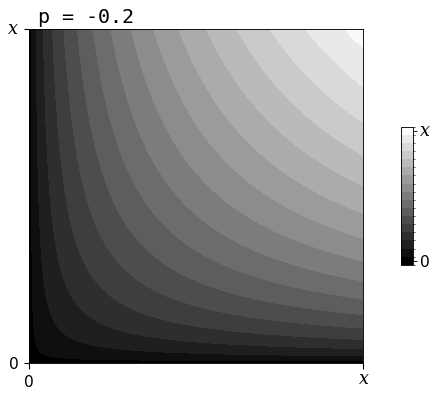

 32%|██████████████████████████████▏                                                              | 200/617 [00:26<00:55,  7.51it/s]

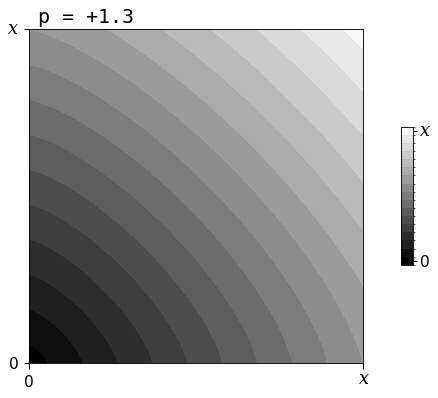

 33%|██████████████████████████████▎                                                              | 201/617 [00:27<00:55,  7.54it/s]

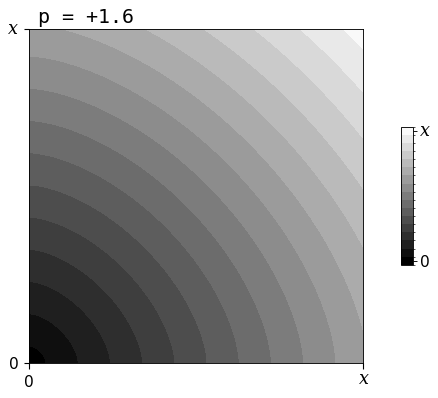

 33%|██████████████████████████████▍                                                              | 202/617 [00:27<01:00,  6.85it/s]

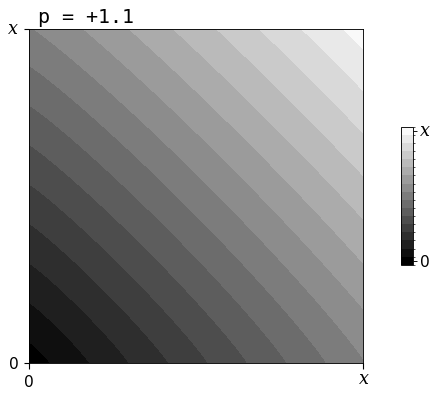

 33%|██████████████████████████████▌                                                              | 203/617 [00:27<00:58,  7.05it/s]

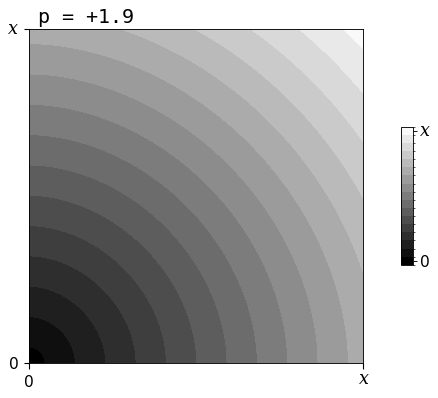

 33%|██████████████████████████████▋                                                              | 204/617 [00:27<00:57,  7.20it/s]

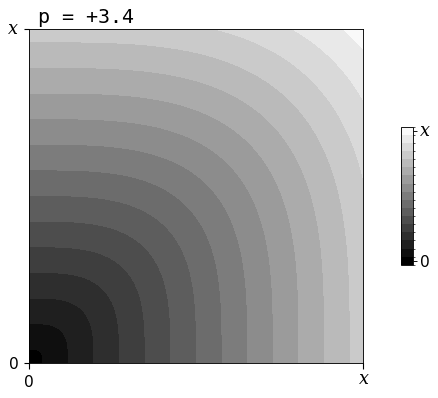

 33%|██████████████████████████████▉                                                              | 205/617 [00:27<00:56,  7.31it/s]

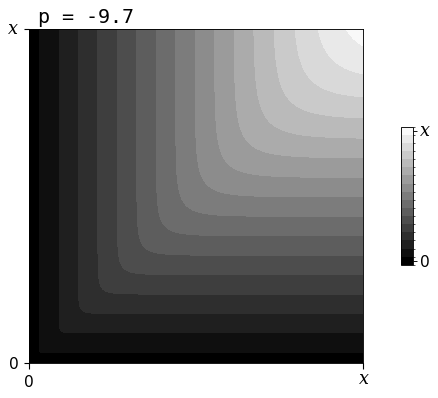

 33%|███████████████████████████████                                                              | 206/617 [00:27<00:55,  7.41it/s]

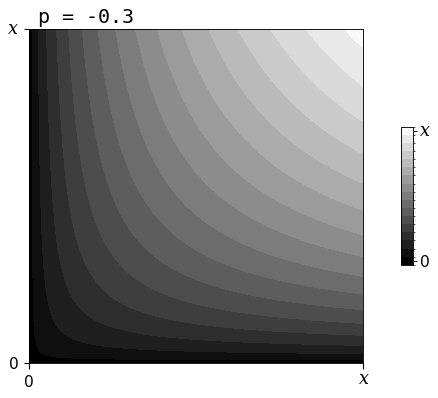

 34%|███████████████████████████████▏                                                             | 207/617 [00:27<00:55,  7.42it/s]

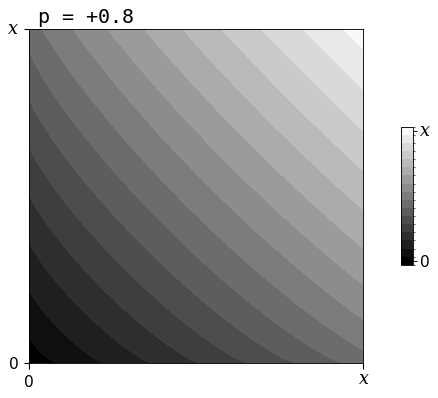

 34%|███████████████████████████████▎                                                             | 208/617 [00:28<00:55,  7.37it/s]

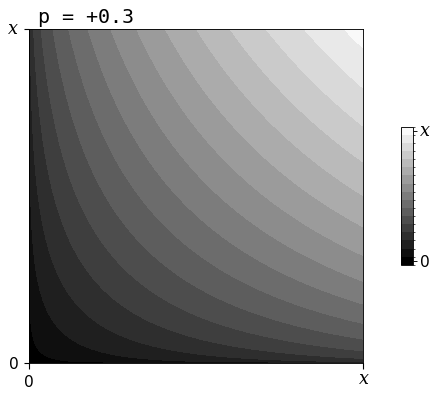

 34%|███████████████████████████████▌                                                             | 209/617 [00:28<00:55,  7.36it/s]

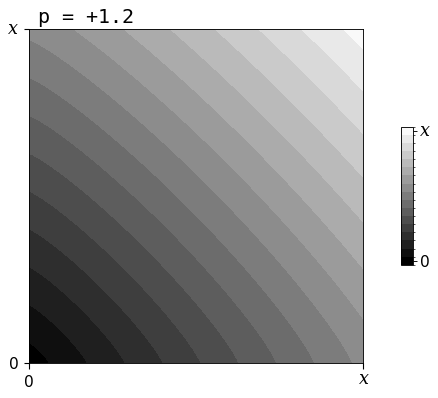

 34%|███████████████████████████████▋                                                             | 210/617 [00:28<00:55,  7.34it/s]

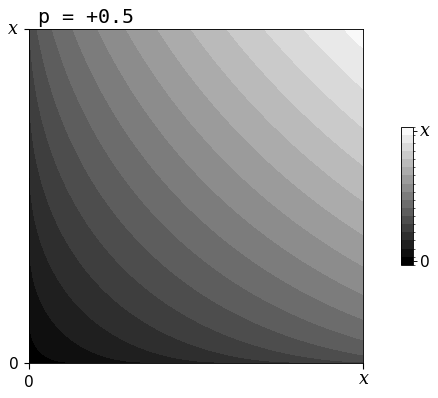

 34%|███████████████████████████████▊                                                             | 211/617 [00:28<00:55,  7.35it/s]

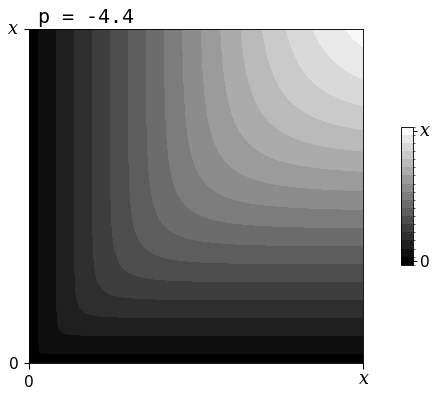

 34%|███████████████████████████████▉                                                             | 212/617 [00:28<00:54,  7.42it/s]

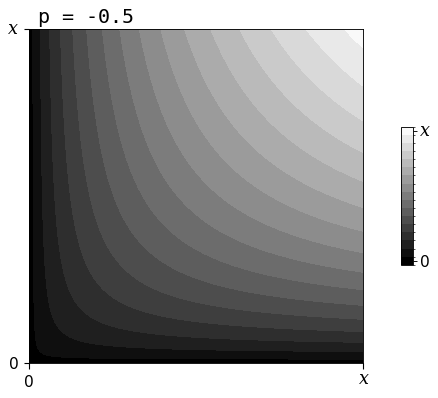

 35%|████████████████████████████████                                                             | 213/617 [00:28<00:54,  7.45it/s]

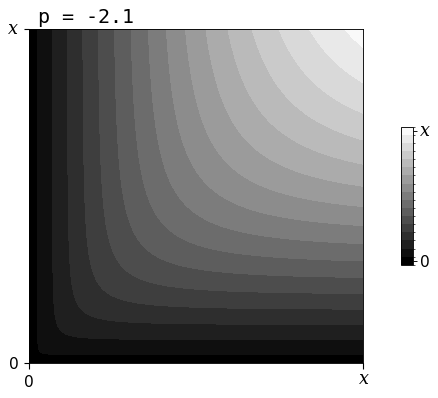

 35%|████████████████████████████████▎                                                            | 214/617 [00:28<00:55,  7.21it/s]

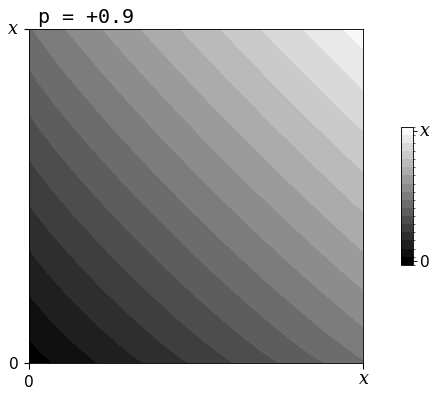

 35%|████████████████████████████████▍                                                            | 215/617 [00:29<00:59,  6.70it/s]

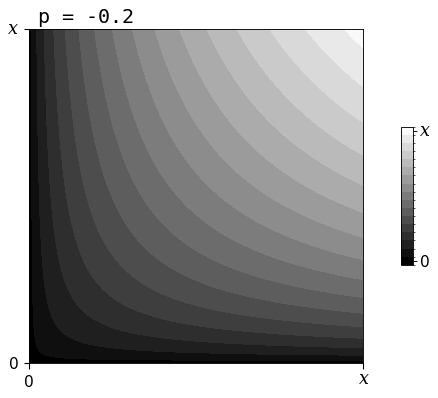

 35%|████████████████████████████████▌                                                            | 216/617 [00:29<00:58,  6.91it/s]

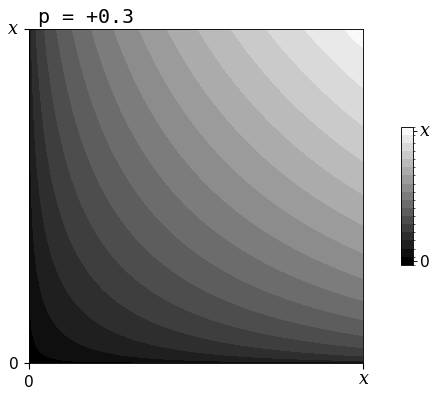

 35%|████████████████████████████████▋                                                            | 217/617 [00:29<00:56,  7.08it/s]

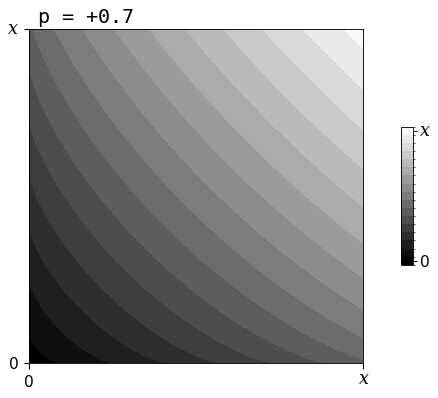

 35%|████████████████████████████████▊                                                            | 218/617 [00:29<00:55,  7.20it/s]

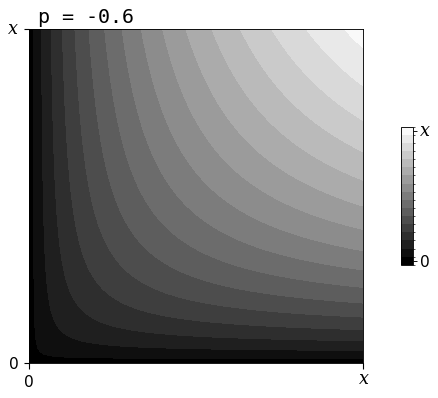

 35%|█████████████████████████████████                                                            | 219/617 [00:29<00:54,  7.28it/s]

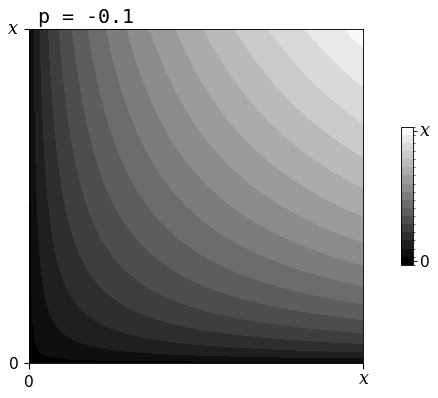

 36%|█████████████████████████████████▏                                                           | 220/617 [00:29<00:54,  7.27it/s]

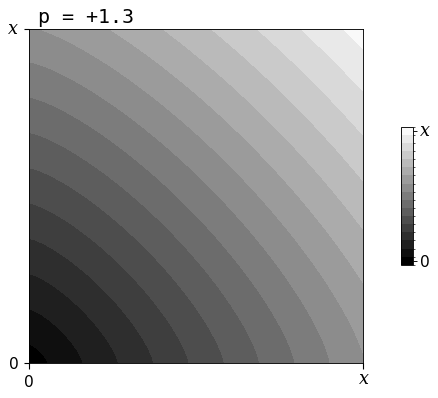

 36%|█████████████████████████████████▎                                                           | 221/617 [00:29<00:54,  7.31it/s]

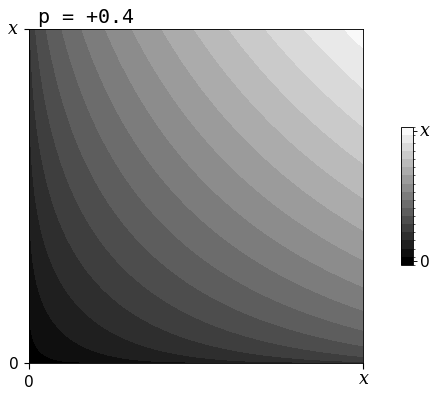

 36%|█████████████████████████████████▍                                                           | 222/617 [00:30<00:53,  7.36it/s]

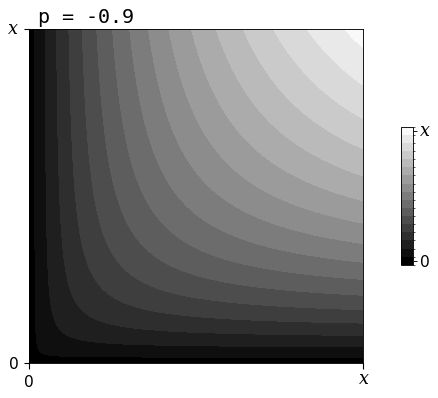

 36%|█████████████████████████████████▌                                                           | 223/617 [00:30<00:53,  7.41it/s]

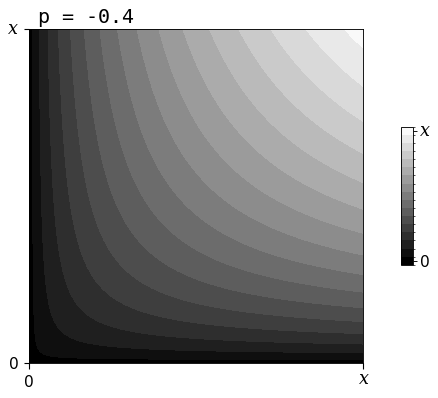

 36%|█████████████████████████████████▊                                                           | 224/617 [00:30<00:52,  7.47it/s]

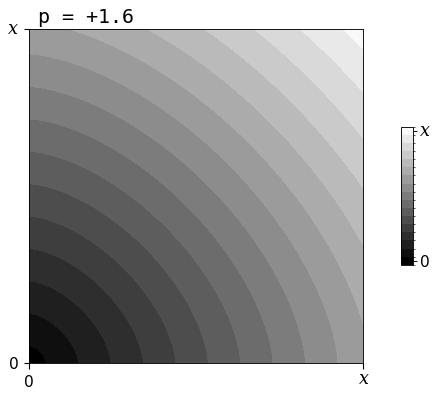

 36%|█████████████████████████████████▉                                                           | 225/617 [00:30<00:52,  7.50it/s]

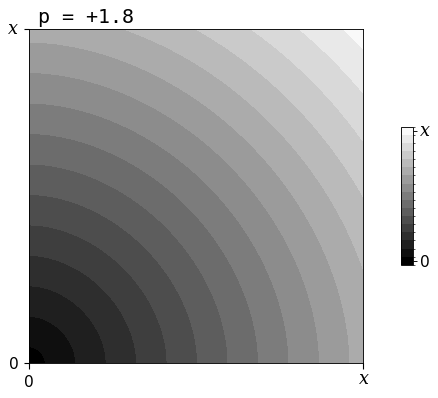

 37%|██████████████████████████████████                                                           | 226/617 [00:30<00:51,  7.53it/s]

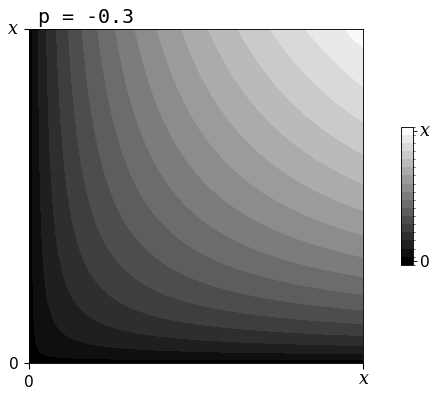

 37%|██████████████████████████████████▏                                                          | 227/617 [00:30<00:51,  7.54it/s]

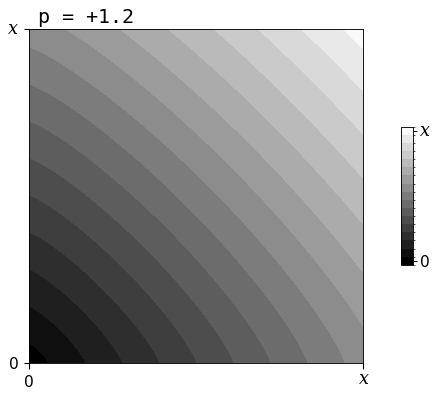

 37%|██████████████████████████████████▎                                                          | 228/617 [00:30<00:56,  6.94it/s]

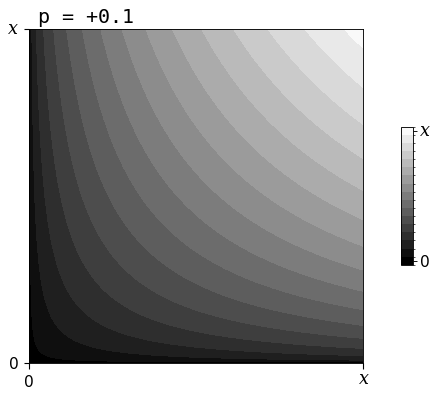

 37%|██████████████████████████████████▌                                                          | 229/617 [00:30<00:54,  7.13it/s]

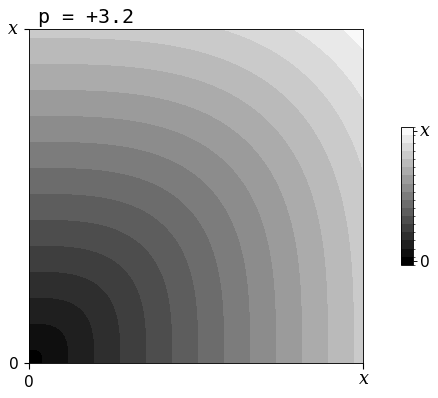

 37%|██████████████████████████████████▋                                                          | 230/617 [00:31<00:53,  7.28it/s]

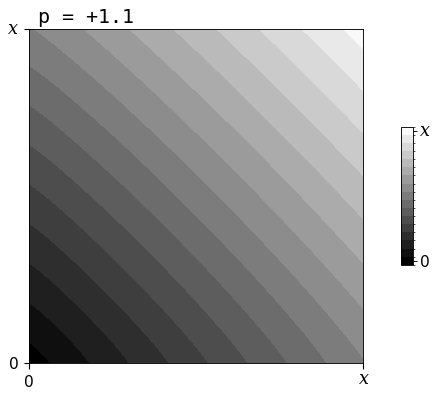

 37%|██████████████████████████████████▊                                                          | 231/617 [00:31<00:52,  7.35it/s]

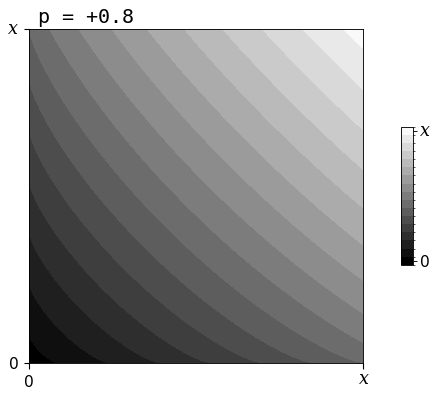

 38%|██████████████████████████████████▉                                                          | 232/617 [00:31<00:52,  7.39it/s]

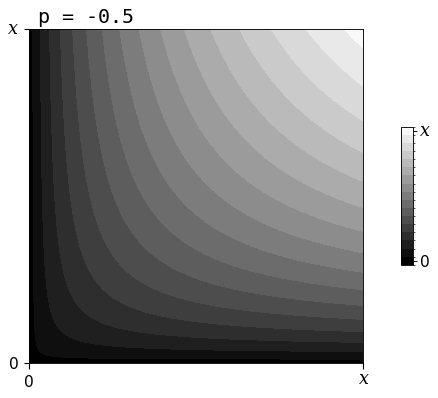

 38%|███████████████████████████████████                                                          | 233/617 [00:31<00:51,  7.43it/s]

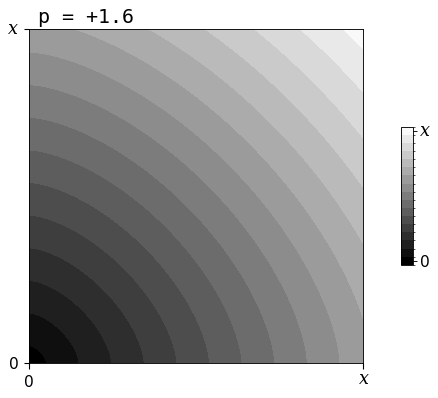

 38%|███████████████████████████████████▎                                                         | 234/617 [00:31<00:51,  7.48it/s]

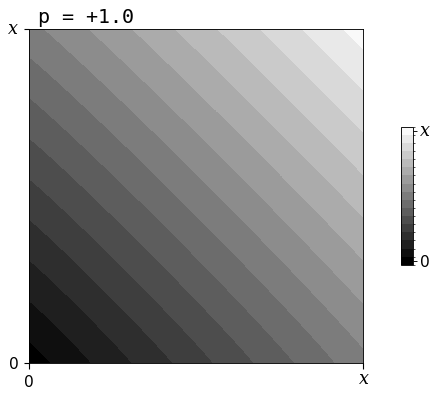

 38%|███████████████████████████████████▍                                                         | 235/617 [00:31<00:50,  7.52it/s]

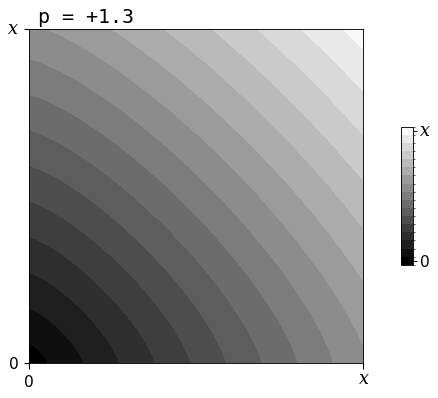

 38%|███████████████████████████████████▌                                                         | 236/617 [00:31<00:50,  7.52it/s]

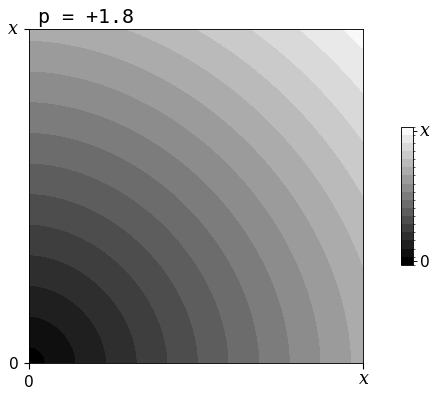

 38%|███████████████████████████████████▋                                                         | 237/617 [00:32<00:50,  7.55it/s]

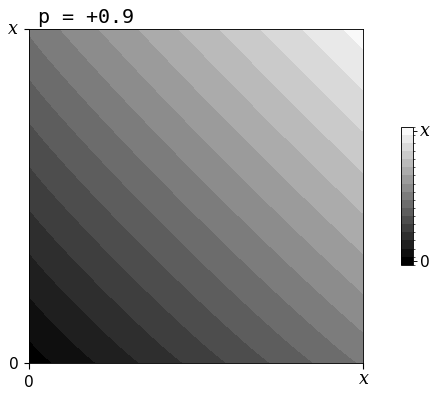

 39%|███████████████████████████████████▊                                                         | 238/617 [00:32<00:50,  7.53it/s]

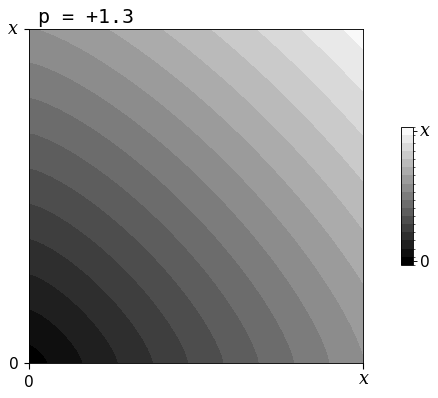

 39%|████████████████████████████████████                                                         | 239/617 [00:32<00:50,  7.52it/s]

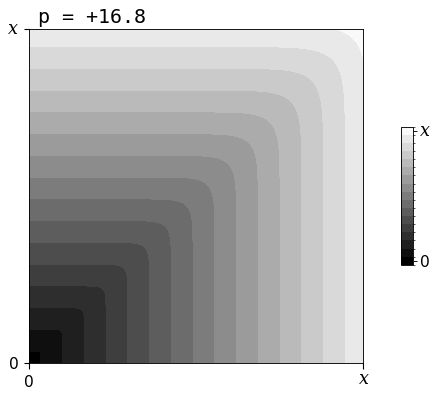

 39%|████████████████████████████████████▏                                                        | 240/617 [00:32<00:49,  7.55it/s]

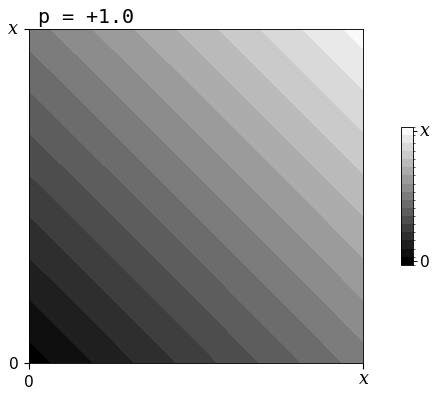

 39%|████████████████████████████████████▎                                                        | 241/617 [00:32<00:49,  7.57it/s]

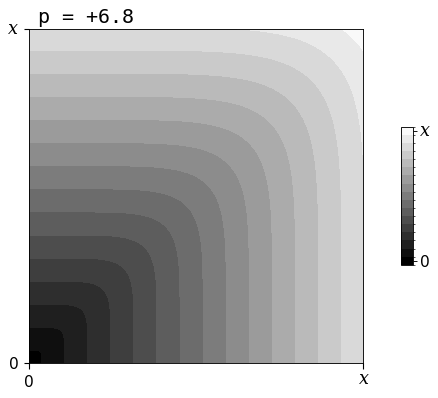

 39%|████████████████████████████████████▍                                                        | 242/617 [00:32<00:53,  6.95it/s]

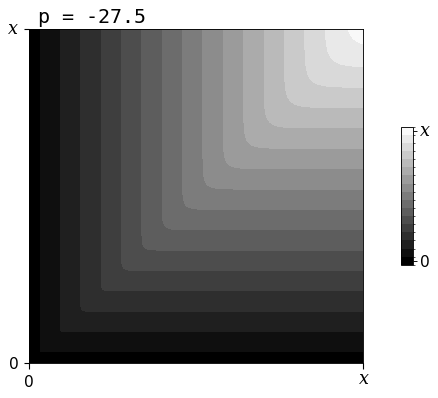

 39%|████████████████████████████████████▋                                                        | 243/617 [00:32<00:52,  7.14it/s]

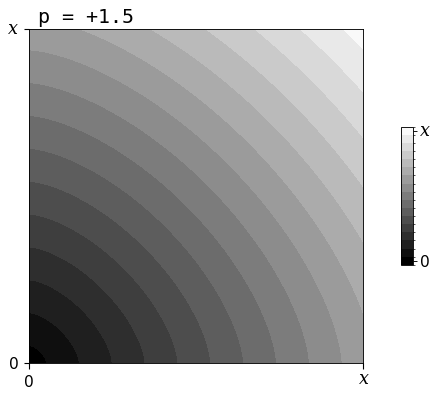

 40%|████████████████████████████████████▊                                                        | 244/617 [00:33<00:51,  7.26it/s]

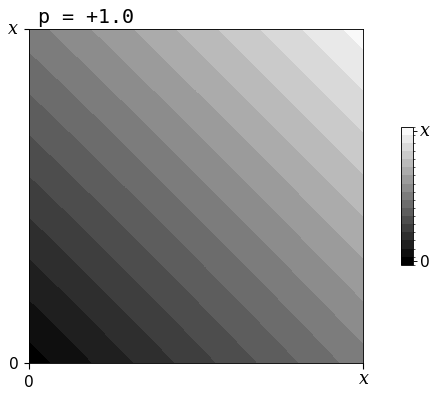

 40%|████████████████████████████████████▉                                                        | 245/617 [00:33<00:50,  7.33it/s]

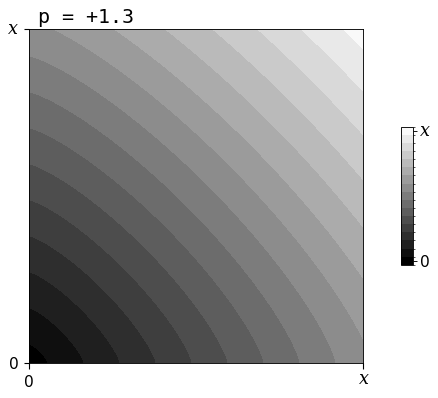

 40%|█████████████████████████████████████                                                        | 246/617 [00:33<00:50,  7.39it/s]

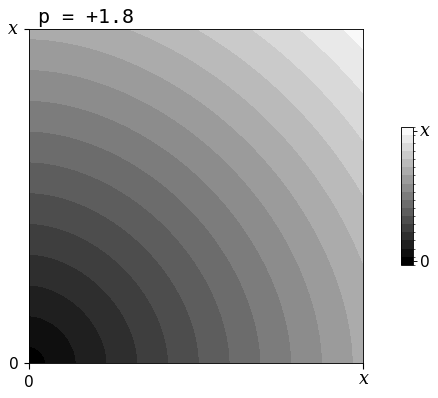

 40%|█████████████████████████████████████▏                                                       | 247/617 [00:33<00:49,  7.47it/s]

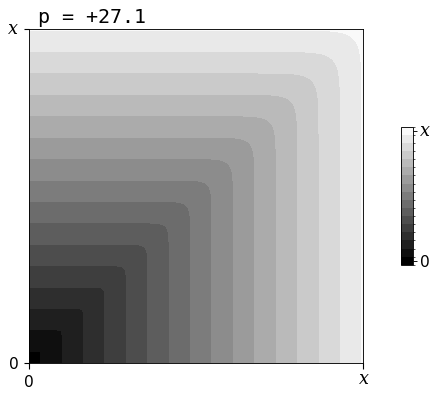

 40%|█████████████████████████████████████▍                                                       | 248/617 [00:33<00:48,  7.54it/s]

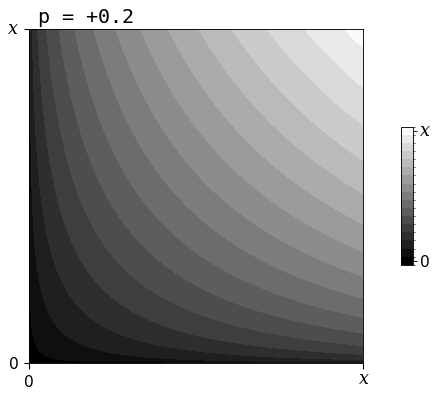

 40%|█████████████████████████████████████▌                                                       | 249/617 [00:33<00:48,  7.53it/s]

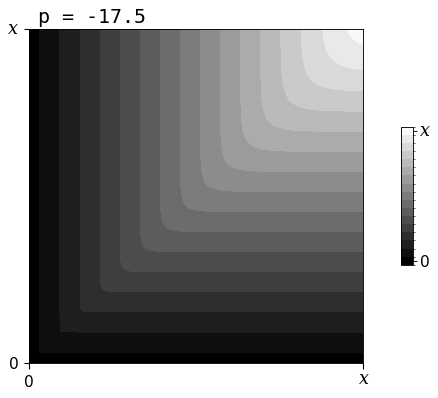

 41%|█████████████████████████████████████▋                                                       | 250/617 [00:33<00:48,  7.56it/s]

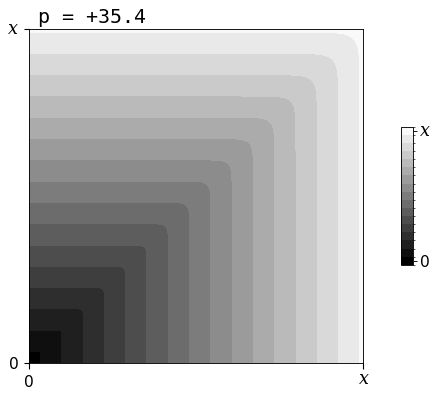

 41%|█████████████████████████████████████▊                                                       | 251/617 [00:33<00:48,  7.60it/s]

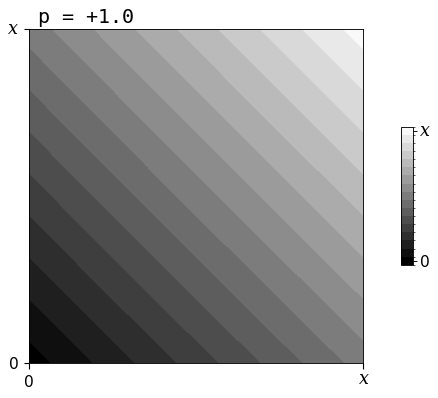

 41%|█████████████████████████████████████▉                                                       | 252/617 [00:34<00:48,  7.58it/s]

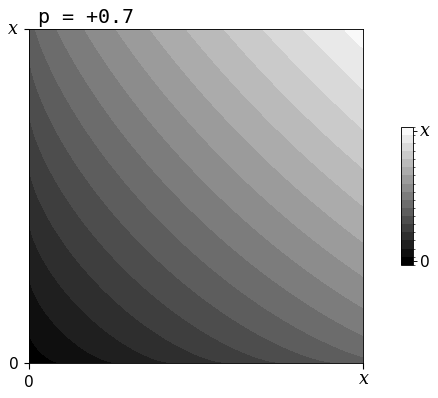

 41%|██████████████████████████████████████▏                                                      | 253/617 [00:34<00:48,  7.56it/s]

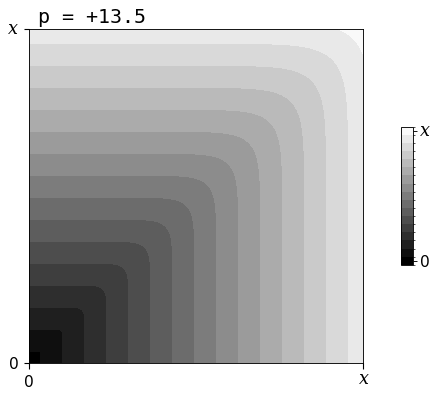

 41%|██████████████████████████████████████▎                                                      | 254/617 [00:34<00:47,  7.59it/s]

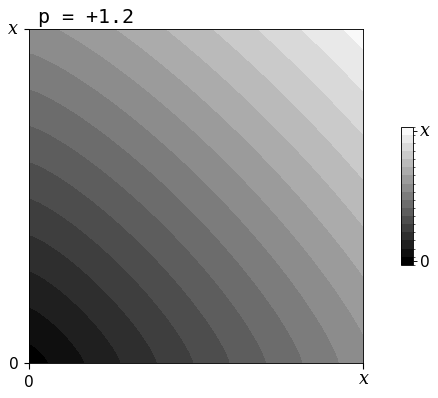

 41%|██████████████████████████████████████▍                                                      | 255/617 [00:34<00:52,  6.95it/s]

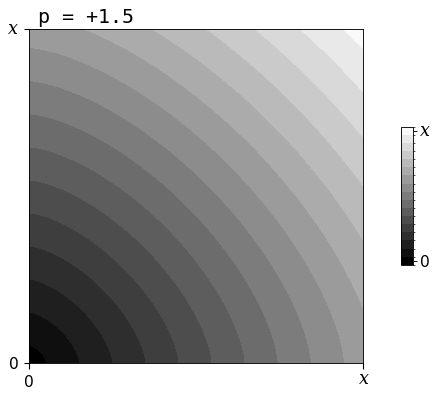

 41%|██████████████████████████████████████▌                                                      | 256/617 [00:34<00:50,  7.13it/s]

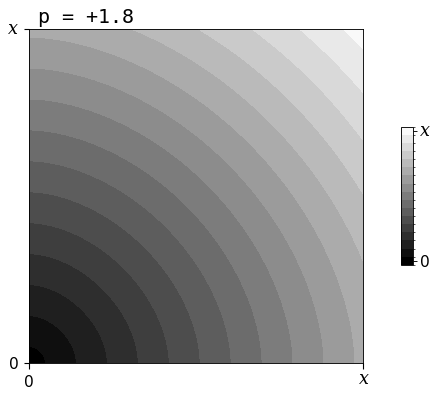

 42%|██████████████████████████████████████▋                                                      | 257/617 [00:34<00:49,  7.26it/s]

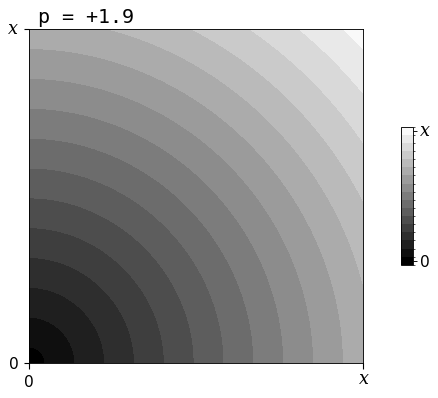

 42%|██████████████████████████████████████▉                                                      | 258/617 [00:34<00:48,  7.38it/s]

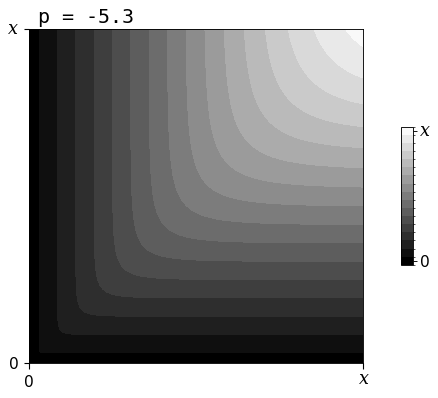

 42%|███████████████████████████████████████                                                      | 259/617 [00:35<00:48,  7.43it/s]

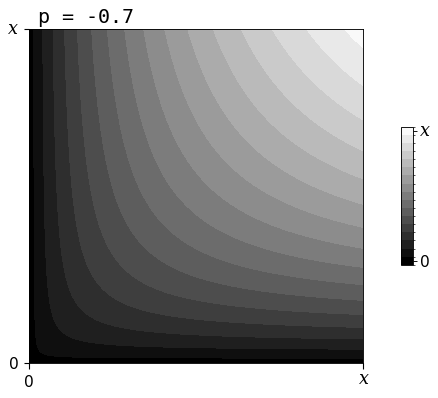

 42%|███████████████████████████████████████▏                                                     | 260/617 [00:35<00:47,  7.44it/s]

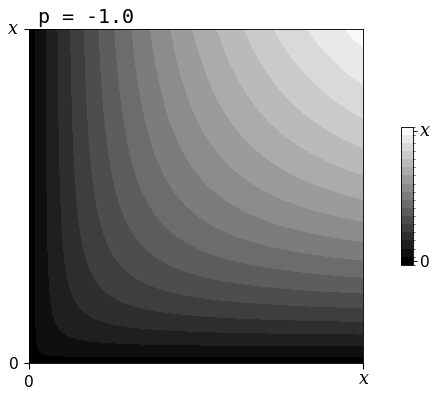

 42%|███████████████████████████████████████▎                                                     | 261/617 [00:35<00:47,  7.47it/s]

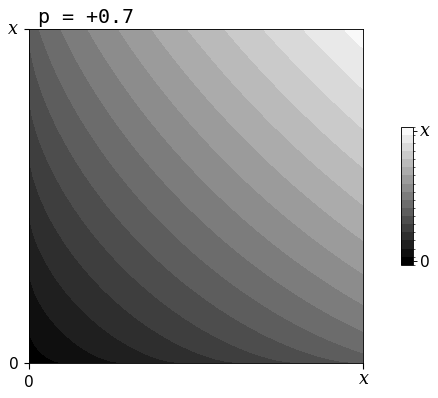

 42%|███████████████████████████████████████▍                                                     | 262/617 [00:35<00:47,  7.46it/s]

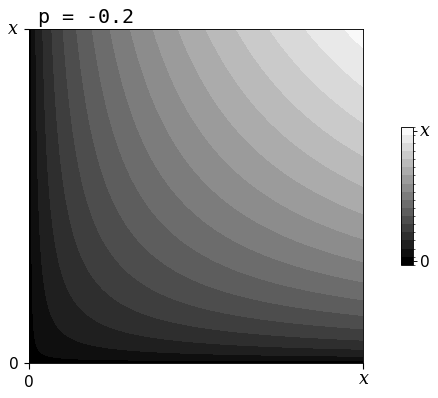

 43%|███████████████████████████████████████▋                                                     | 263/617 [00:35<00:47,  7.46it/s]

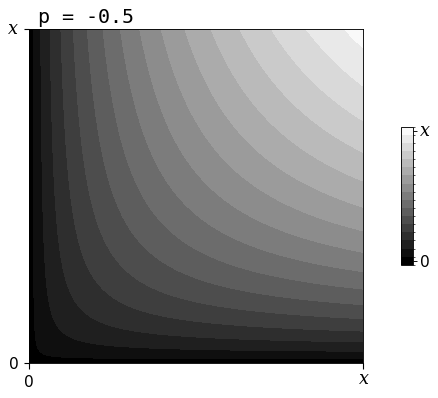

 43%|███████████████████████████████████████▊                                                     | 264/617 [00:35<00:47,  7.47it/s]

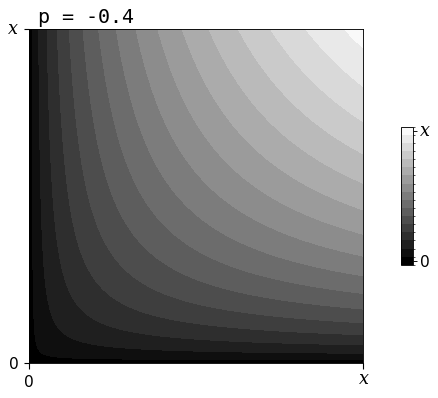

 43%|███████████████████████████████████████▉                                                     | 265/617 [00:35<00:47,  7.48it/s]

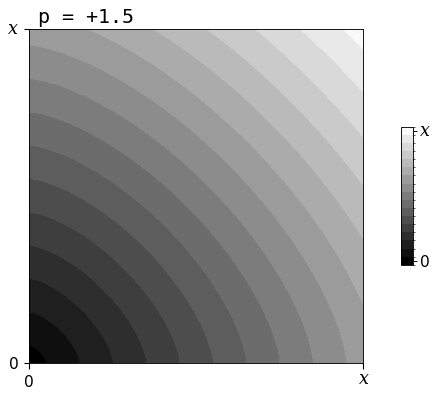

 43%|████████████████████████████████████████                                                     | 266/617 [00:35<00:46,  7.52it/s]

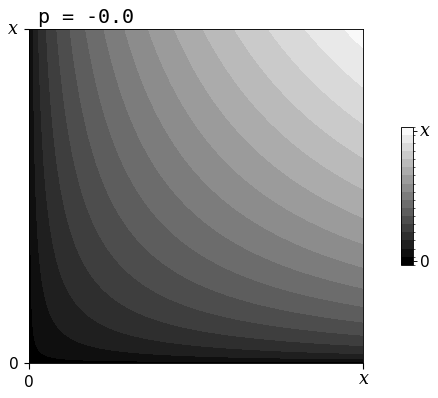

 43%|████████████████████████████████████████▏                                                    | 267/617 [00:36<00:46,  7.52it/s]

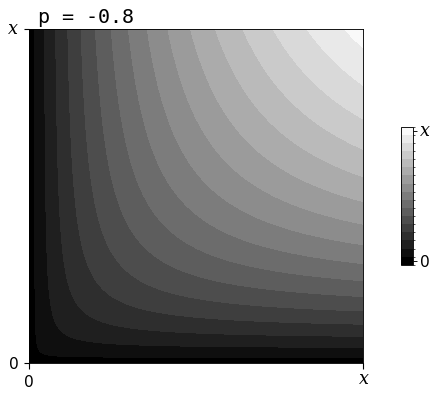

 43%|████████████████████████████████████████▍                                                    | 268/617 [00:36<00:50,  6.91it/s]

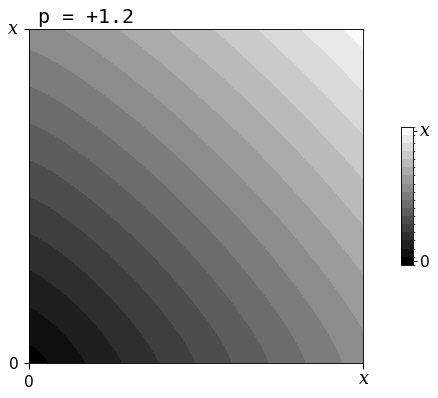

 44%|████████████████████████████████████████▌                                                    | 269/617 [00:36<00:49,  7.10it/s]

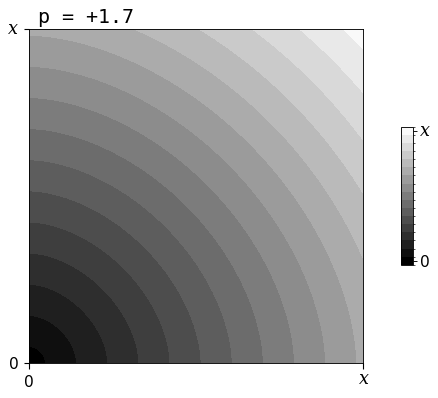

 44%|████████████████████████████████████████▋                                                    | 270/617 [00:36<00:47,  7.24it/s]

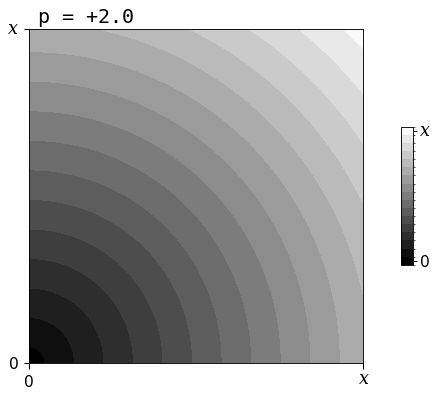

 44%|████████████████████████████████████████▊                                                    | 271/617 [00:36<00:47,  7.34it/s]

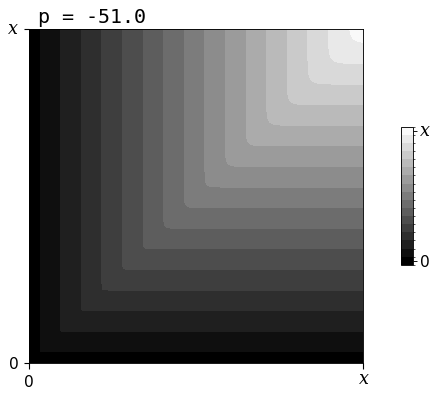

 44%|████████████████████████████████████████▉                                                    | 272/617 [00:36<00:46,  7.44it/s]

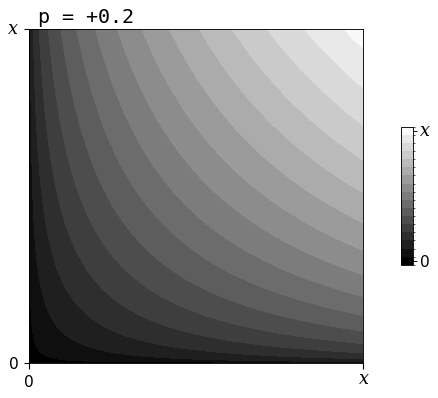

 44%|█████████████████████████████████████████▏                                                   | 273/617 [00:36<00:46,  7.46it/s]

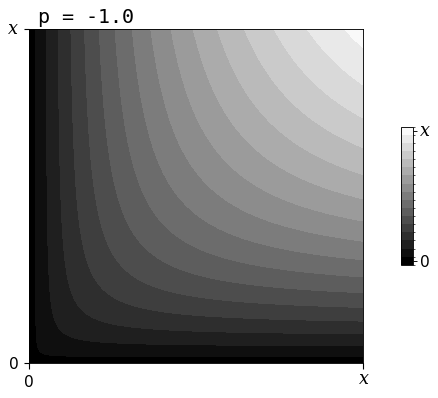

 44%|█████████████████████████████████████████▎                                                   | 274/617 [00:37<00:45,  7.47it/s]

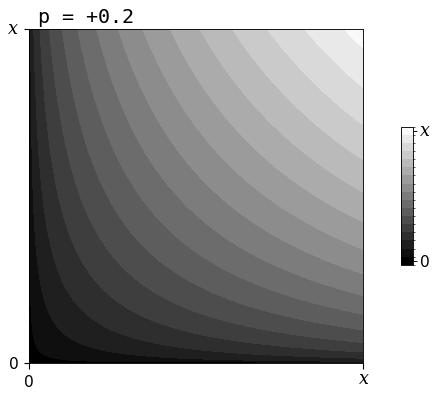

 45%|█████████████████████████████████████████▍                                                   | 275/617 [00:37<00:45,  7.48it/s]

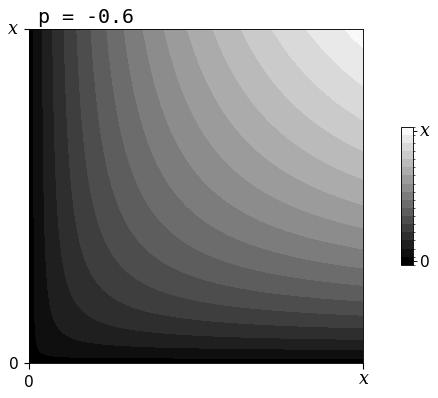

 45%|█████████████████████████████████████████▌                                                   | 276/617 [00:37<00:45,  7.49it/s]

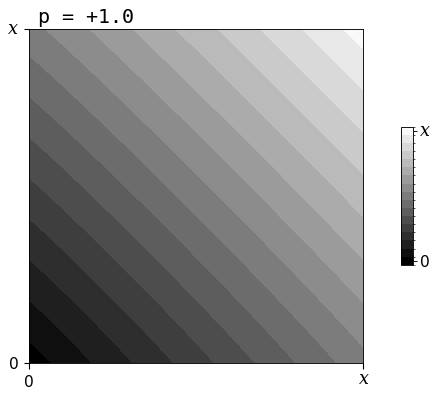

 45%|█████████████████████████████████████████▊                                                   | 277/617 [00:37<00:45,  7.50it/s]

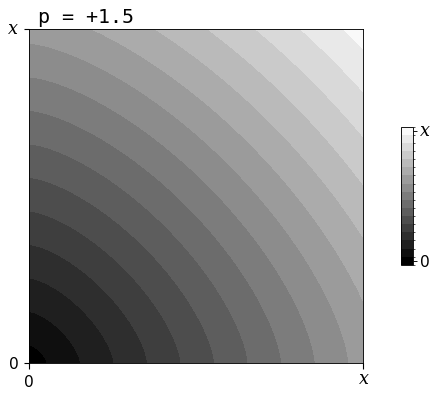

 45%|█████████████████████████████████████████▉                                                   | 278/617 [00:37<00:45,  7.52it/s]

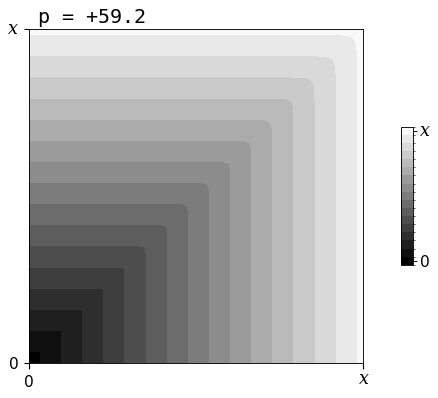

 45%|██████████████████████████████████████████                                                   | 279/617 [00:37<00:44,  7.55it/s]

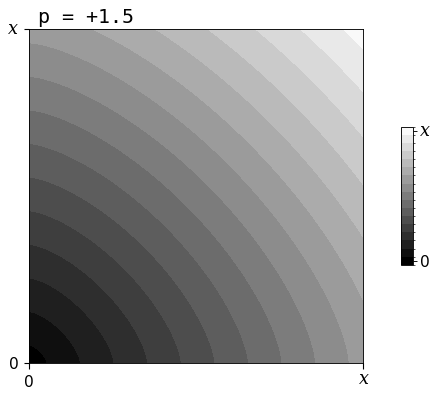

 45%|██████████████████████████████████████████▏                                                  | 280/617 [00:37<00:46,  7.32it/s]

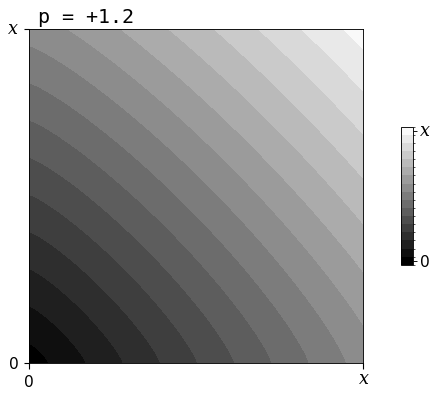

 46%|██████████████████████████████████████████▎                                                  | 281/617 [00:37<00:45,  7.37it/s]

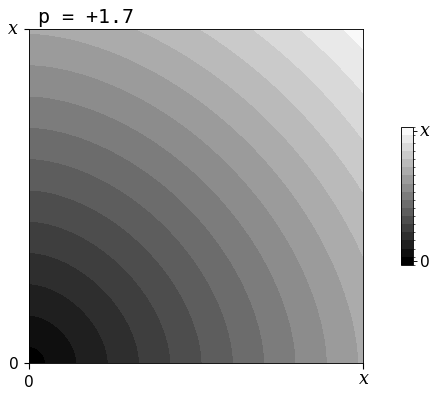

 46%|██████████████████████████████████████████▌                                                  | 282/617 [00:38<00:49,  6.82it/s]

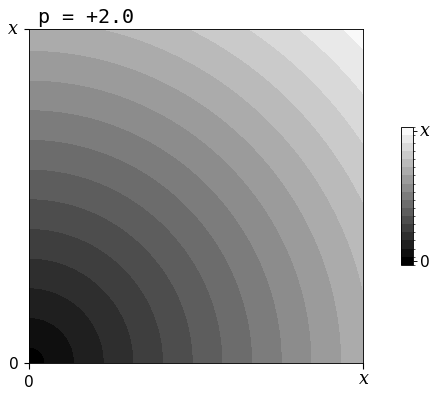

 46%|██████████████████████████████████████████▋                                                  | 283/617 [00:38<00:47,  7.03it/s]

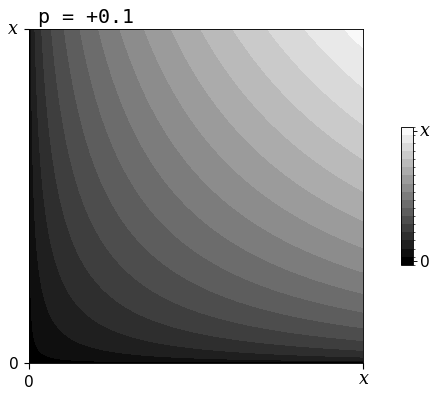

 46%|██████████████████████████████████████████▊                                                  | 284/617 [00:38<00:46,  7.17it/s]

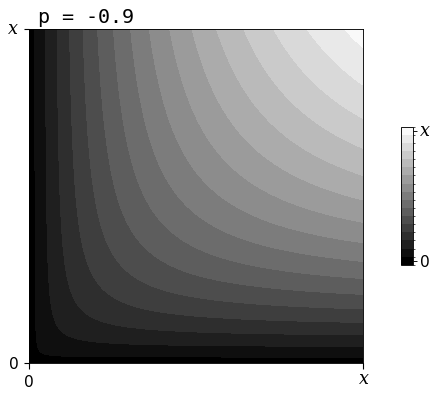

 46%|██████████████████████████████████████████▉                                                  | 285/617 [00:38<00:45,  7.27it/s]

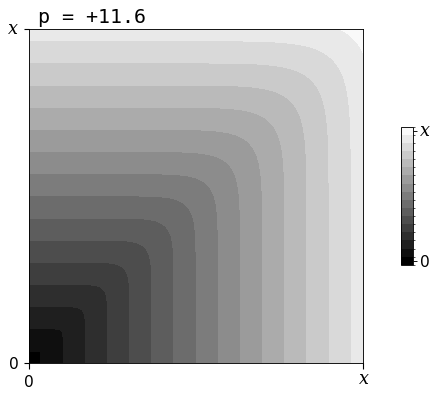

 46%|███████████████████████████████████████████                                                  | 286/617 [00:38<00:44,  7.39it/s]

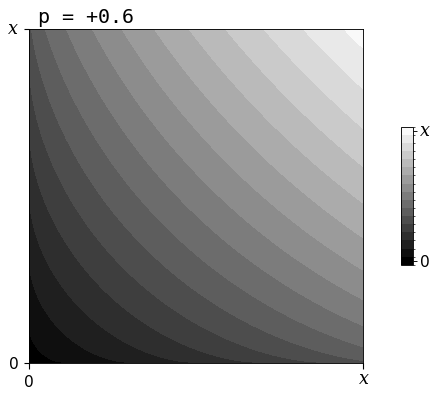

 47%|███████████████████████████████████████████▎                                                 | 287/617 [00:38<00:44,  7.43it/s]

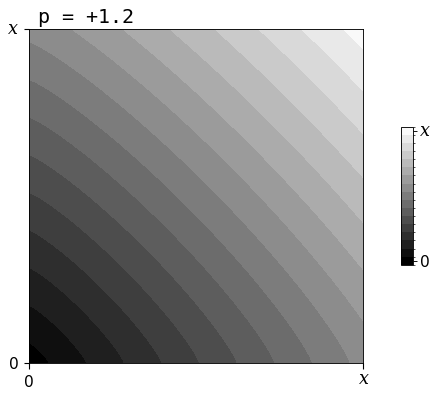

 47%|███████████████████████████████████████████▍                                                 | 288/617 [00:38<00:43,  7.48it/s]

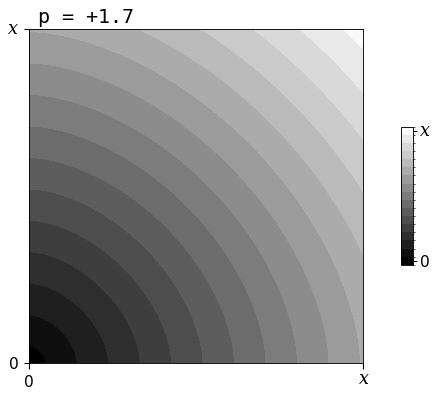

 47%|███████████████████████████████████████████▌                                                 | 289/617 [00:39<00:43,  7.49it/s]

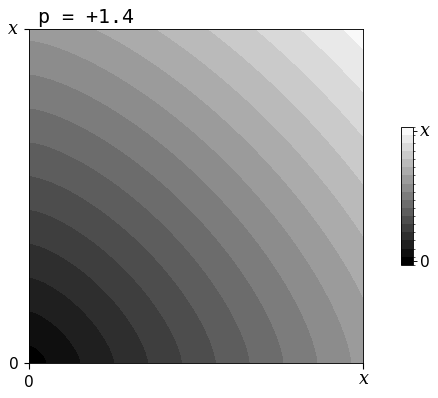

 47%|███████████████████████████████████████████▋                                                 | 290/617 [00:39<00:43,  7.51it/s]

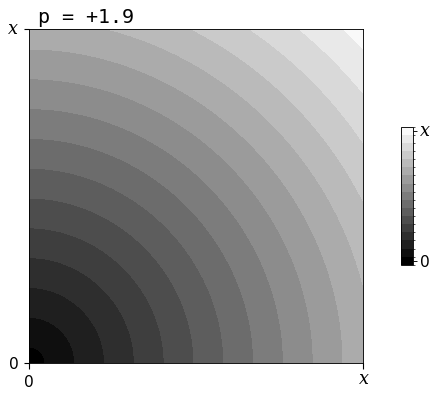

 47%|███████████████████████████████████████████▊                                                 | 291/617 [00:39<00:43,  7.54it/s]

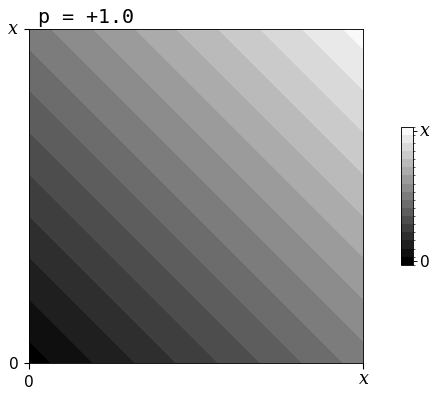

 47%|████████████████████████████████████████████                                                 | 292/617 [00:39<00:43,  7.54it/s]

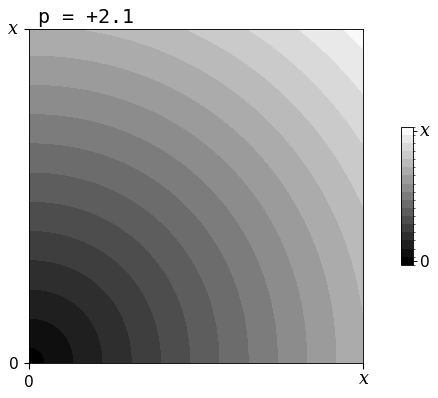

 47%|████████████████████████████████████████████▏                                                | 293/617 [00:39<00:42,  7.56it/s]

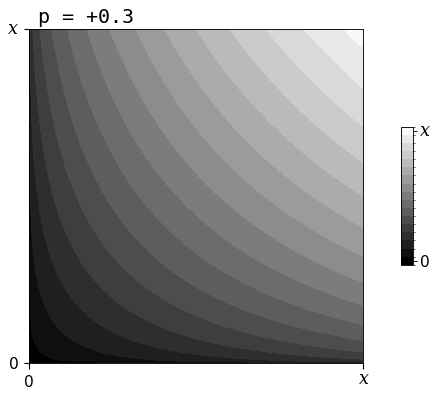

 48%|████████████████████████████████████████████▎                                                | 294/617 [00:39<00:42,  7.57it/s]

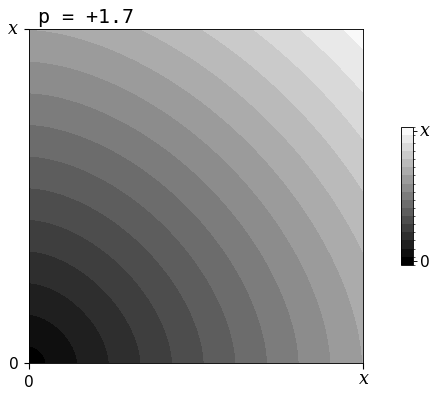

 48%|████████████████████████████████████████████▍                                                | 295/617 [00:39<00:46,  6.95it/s]

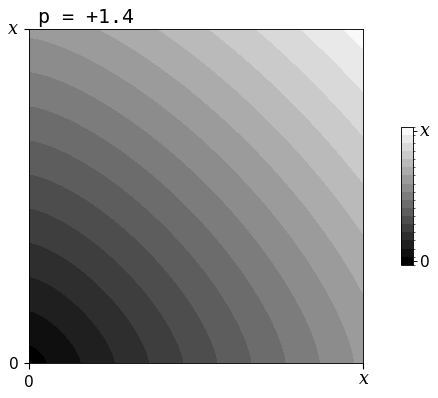

 48%|████████████████████████████████████████████▌                                                | 296/617 [00:40<00:45,  7.12it/s]

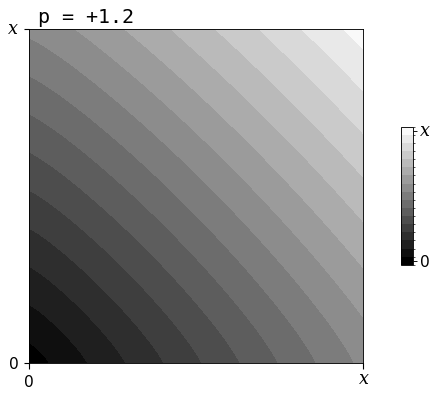

 48%|████████████████████████████████████████████▊                                                | 297/617 [00:40<00:44,  7.24it/s]

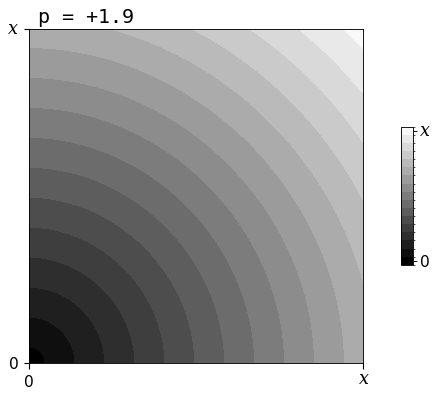

 48%|████████████████████████████████████████████▉                                                | 298/617 [00:40<00:43,  7.34it/s]

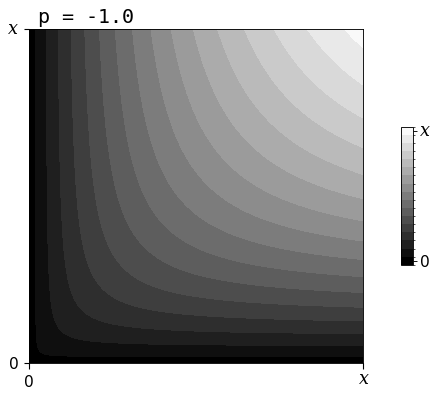

 48%|█████████████████████████████████████████████                                                | 299/617 [00:40<00:42,  7.40it/s]

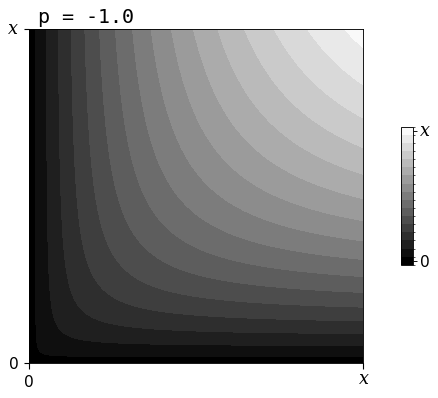

 49%|█████████████████████████████████████████████▏                                               | 300/617 [00:40<00:42,  7.44it/s]

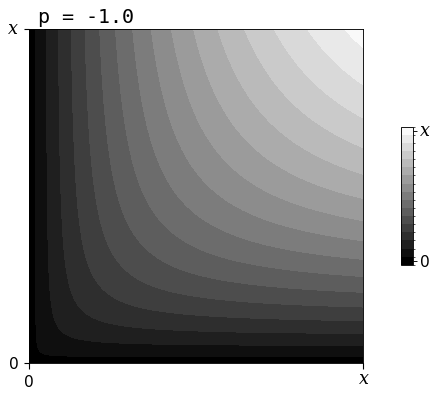

 49%|█████████████████████████████████████████████▎                                               | 301/617 [00:40<00:42,  7.46it/s]

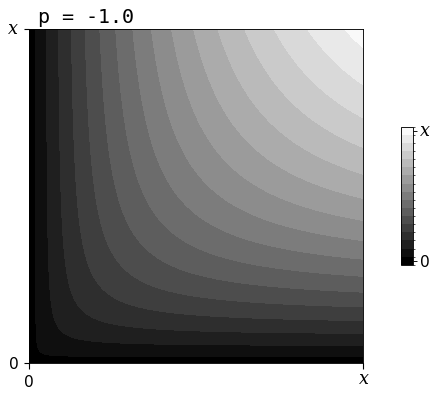

 49%|█████████████████████████████████████████████▌                                               | 302/617 [00:40<00:42,  7.45it/s]

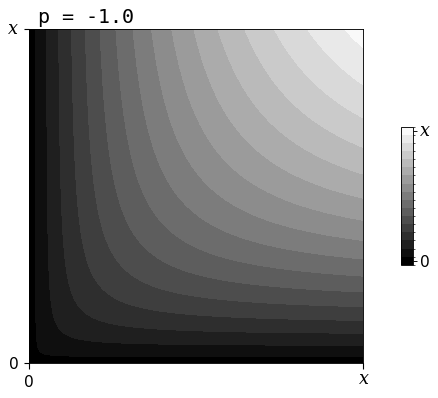

 49%|█████████████████████████████████████████████▋                                               | 303/617 [00:40<00:42,  7.47it/s]

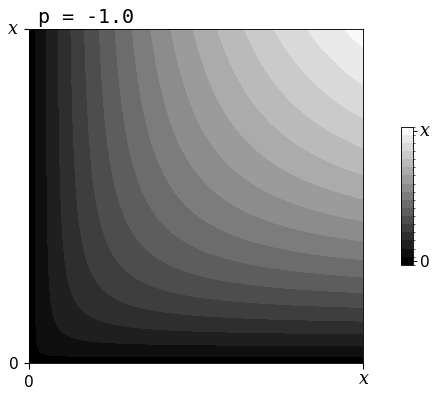

 49%|█████████████████████████████████████████████▊                                               | 304/617 [00:41<00:41,  7.49it/s]

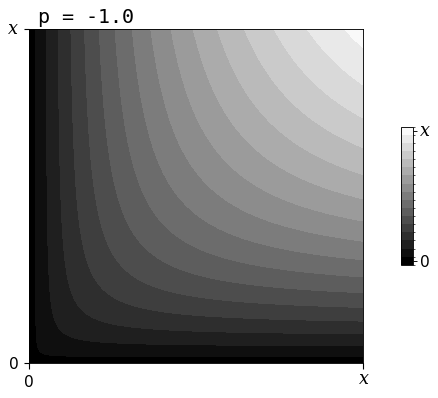

 49%|█████████████████████████████████████████████▉                                               | 305/617 [00:41<00:41,  7.52it/s]

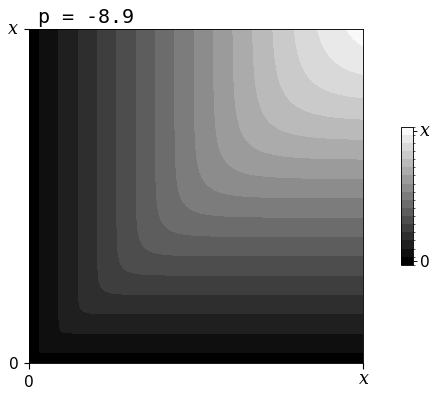

 50%|██████████████████████████████████████████████                                               | 306/617 [00:41<00:41,  7.53it/s]

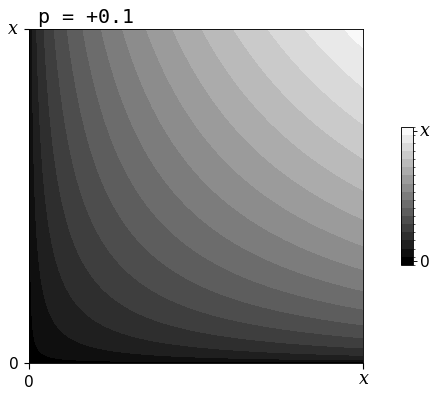

 50%|██████████████████████████████████████████████▎                                              | 307/617 [00:41<00:41,  7.53it/s]

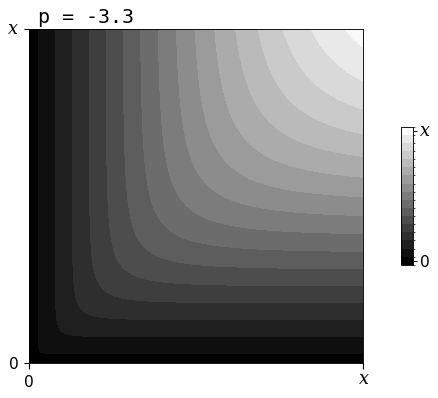

 50%|██████████████████████████████████████████████▍                                              | 308/617 [00:41<00:44,  6.90it/s]

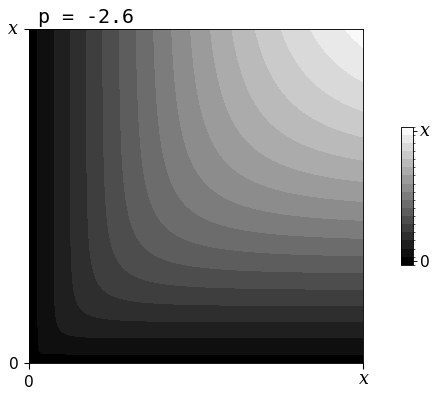

 50%|██████████████████████████████████████████████▌                                              | 309/617 [00:41<00:43,  7.07it/s]

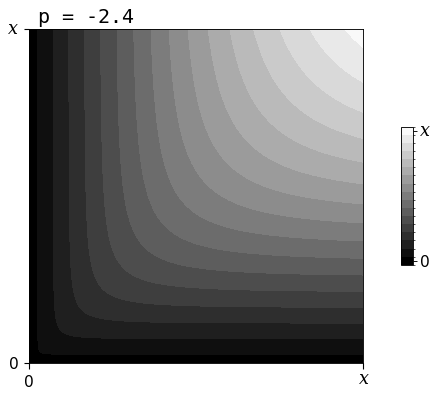

 50%|██████████████████████████████████████████████▋                                              | 310/617 [00:41<00:42,  7.20it/s]

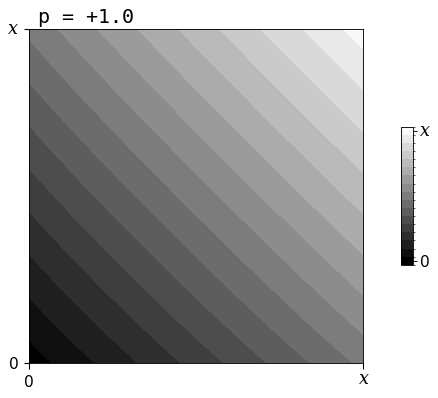

 50%|██████████████████████████████████████████████▉                                              | 311/617 [00:42<00:41,  7.31it/s]

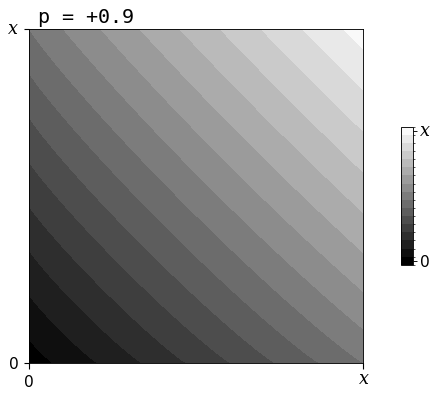

 51%|███████████████████████████████████████████████                                              | 312/617 [00:42<00:41,  7.34it/s]

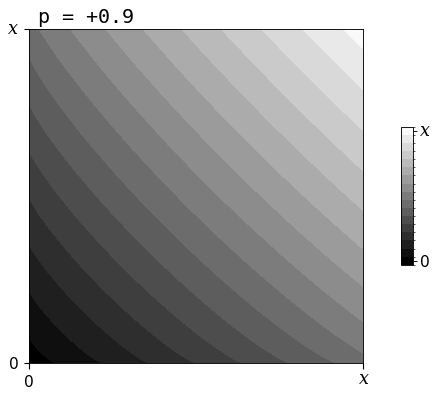

 51%|███████████████████████████████████████████████▏                                             | 313/617 [00:42<00:41,  7.37it/s]

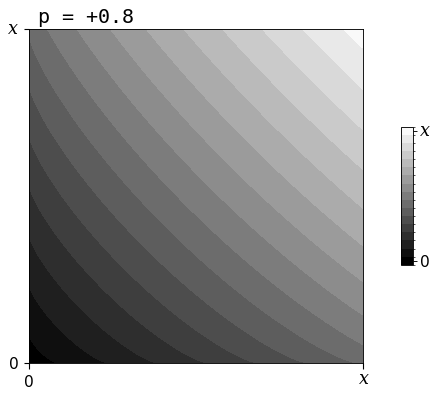

 51%|███████████████████████████████████████████████▎                                             | 314/617 [00:42<00:40,  7.42it/s]

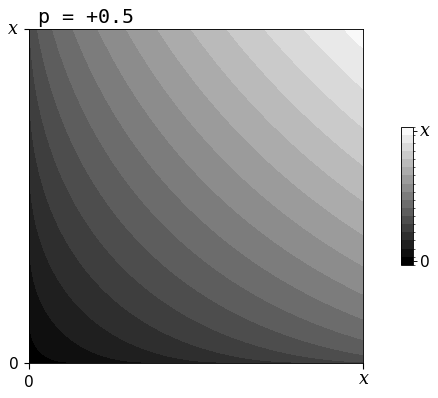

 51%|███████████████████████████████████████████████▍                                             | 315/617 [00:42<00:40,  7.45it/s]

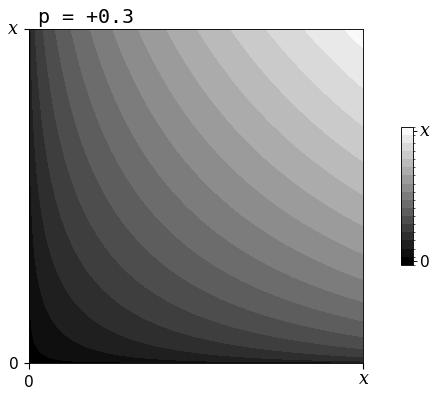

 51%|███████████████████████████████████████████████▋                                             | 316/617 [00:42<00:40,  7.48it/s]

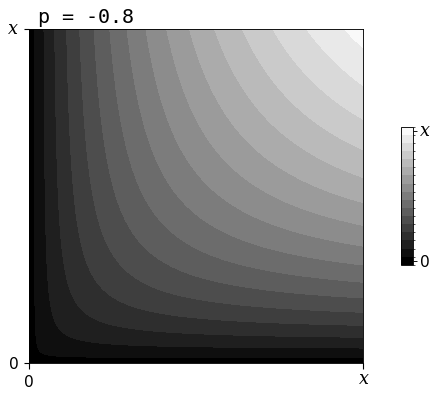

 51%|███████████████████████████████████████████████▊                                             | 317/617 [00:42<00:39,  7.52it/s]

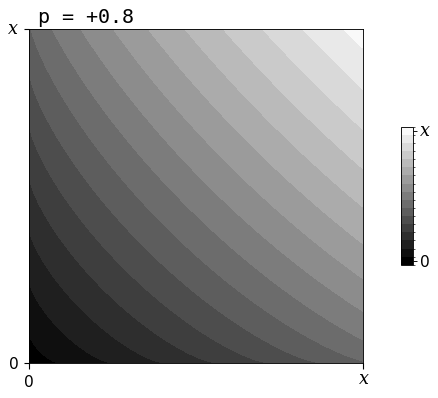

 52%|███████████████████████████████████████████████▉                                             | 318/617 [00:43<00:39,  7.52it/s]

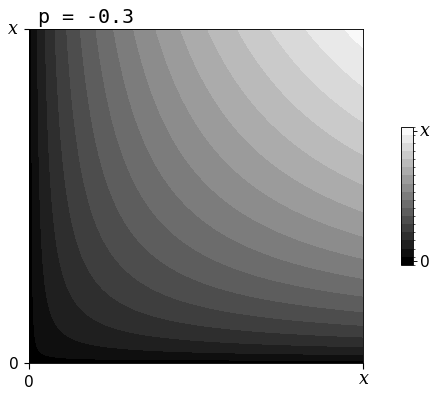

 52%|████████████████████████████████████████████████                                             | 319/617 [00:43<00:39,  7.52it/s]

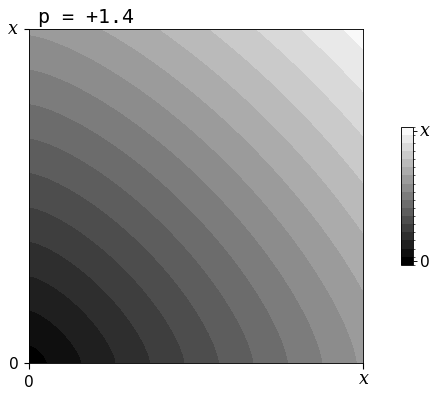

 52%|████████████████████████████████████████████████▏                                            | 320/617 [00:43<00:39,  7.55it/s]

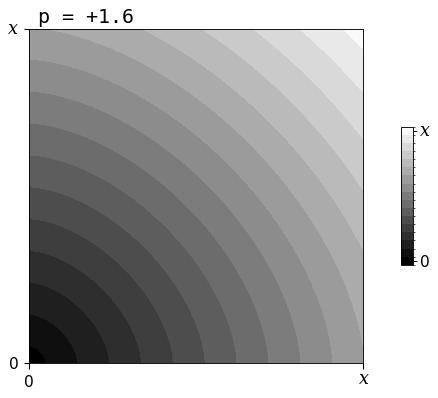

 52%|████████████████████████████████████████████████▍                                            | 321/617 [00:43<00:42,  6.95it/s]

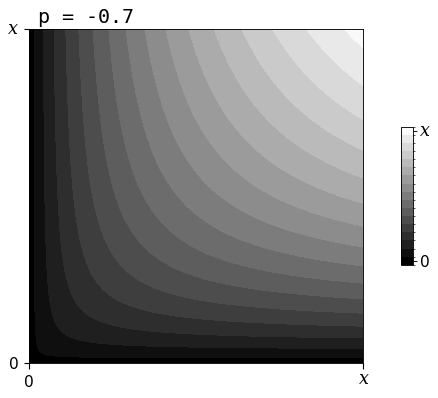

 52%|████████████████████████████████████████████████▌                                            | 322/617 [00:43<00:41,  7.14it/s]

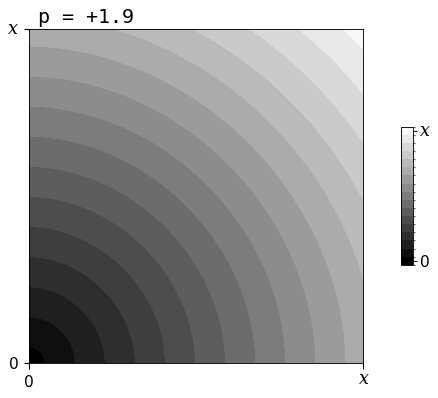

 52%|████████████████████████████████████████████████▋                                            | 323/617 [00:43<00:40,  7.28it/s]

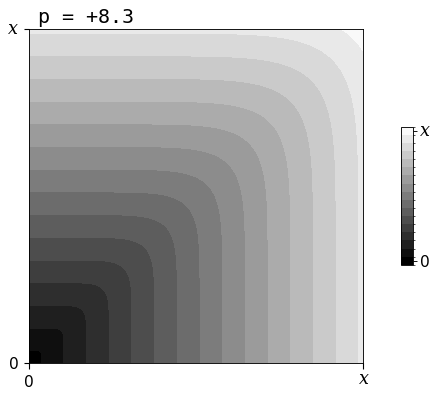

 53%|████████████████████████████████████████████████▊                                            | 324/617 [00:43<00:39,  7.39it/s]

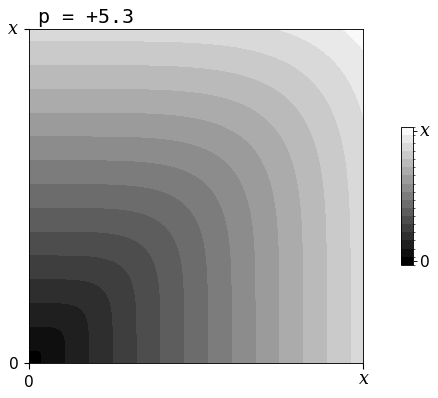

 53%|████████████████████████████████████████████████▉                                            | 325/617 [00:43<00:39,  7.48it/s]

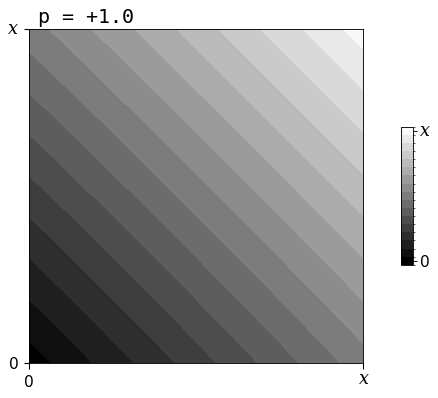

 53%|█████████████████████████████████████████████████▏                                           | 326/617 [00:44<00:38,  7.51it/s]

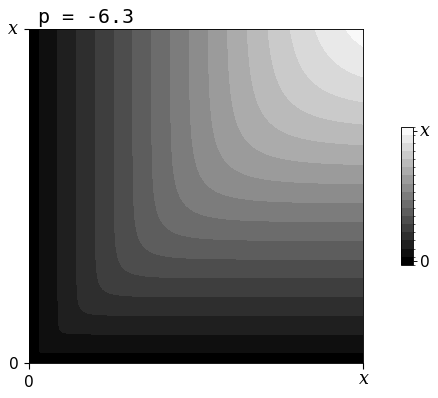

 53%|█████████████████████████████████████████████████▎                                           | 327/617 [00:44<00:38,  7.52it/s]

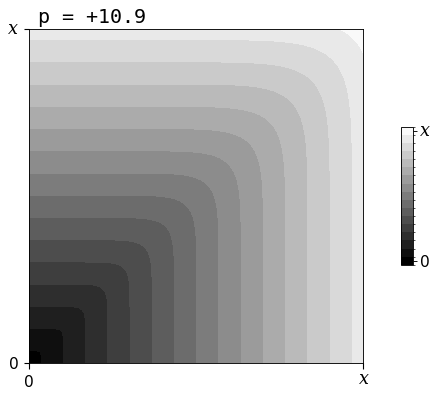

 53%|█████████████████████████████████████████████████▍                                           | 328/617 [00:44<00:38,  7.60it/s]

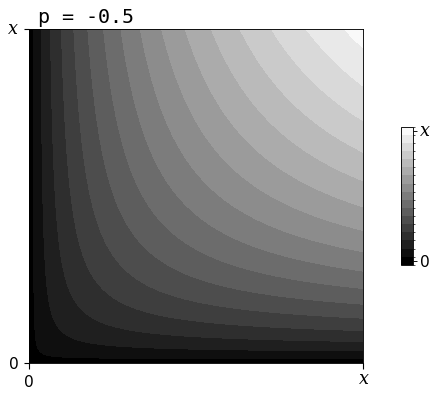

 53%|█████████████████████████████████████████████████▌                                           | 329/617 [00:44<00:37,  7.59it/s]

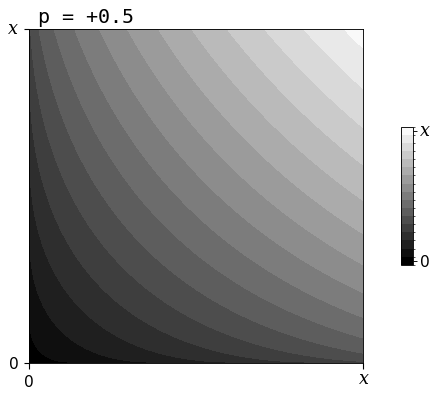

 53%|█████████████████████████████████████████████████▋                                           | 330/617 [00:44<00:37,  7.57it/s]

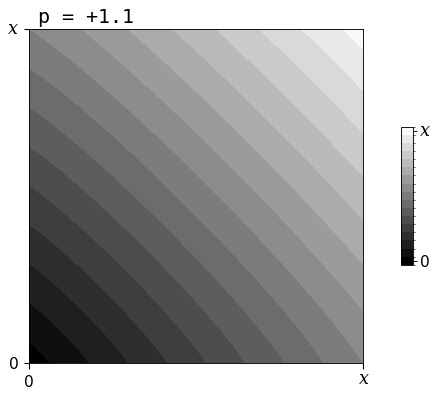

 54%|█████████████████████████████████████████████████▉                                           | 331/617 [00:44<00:37,  7.59it/s]

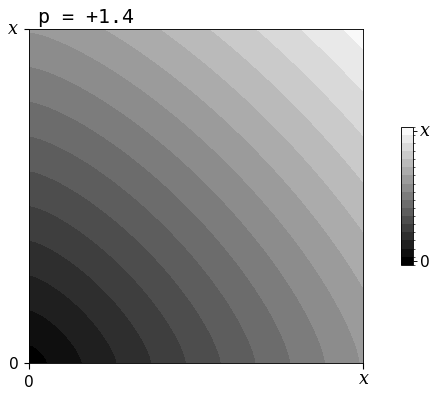

 54%|██████████████████████████████████████████████████                                           | 332/617 [00:44<00:37,  7.59it/s]

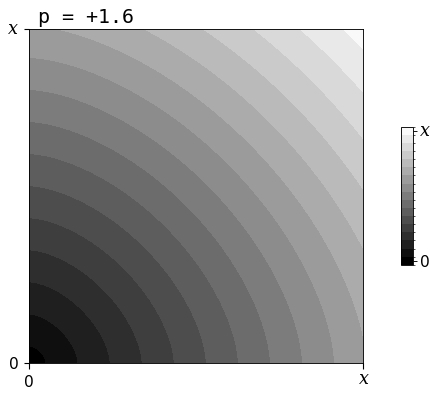

 54%|██████████████████████████████████████████████████▏                                          | 333/617 [00:45<00:37,  7.59it/s]

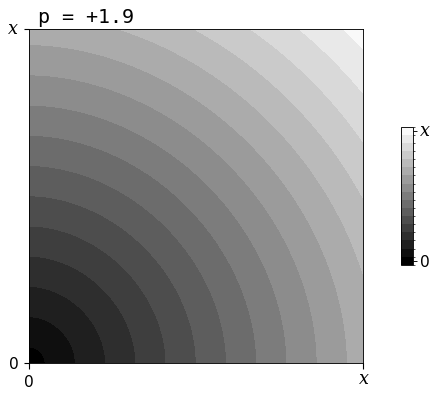

 54%|██████████████████████████████████████████████████▎                                          | 334/617 [00:45<00:37,  7.63it/s]

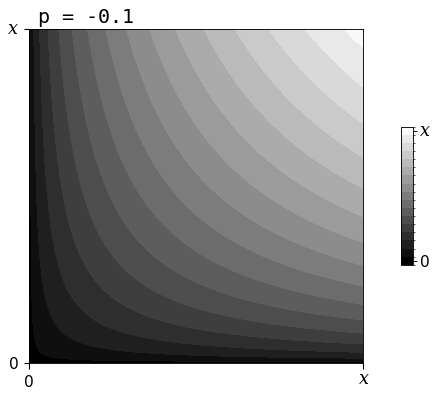

 54%|██████████████████████████████████████████████████▍                                          | 335/617 [00:45<00:40,  6.98it/s]

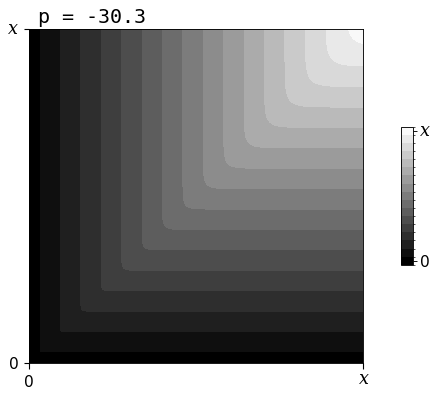

 54%|██████████████████████████████████████████████████▋                                          | 336/617 [00:45<00:39,  7.16it/s]

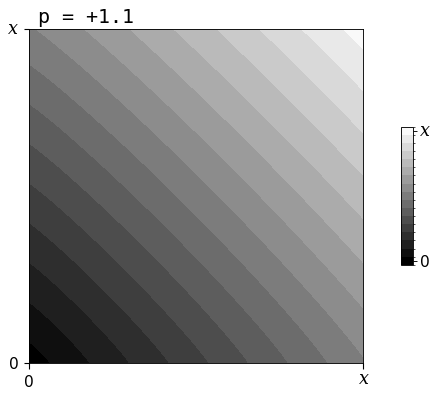

 55%|██████████████████████████████████████████████████▊                                          | 337/617 [00:45<00:38,  7.28it/s]

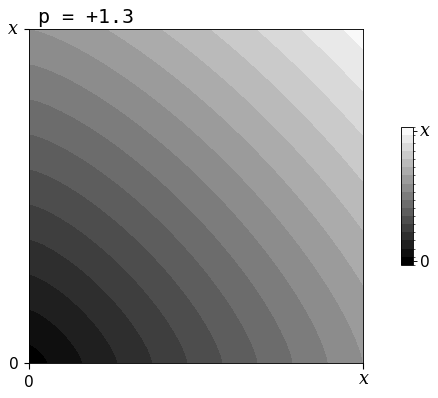

 55%|██████████████████████████████████████████████████▉                                          | 338/617 [00:45<00:37,  7.35it/s]

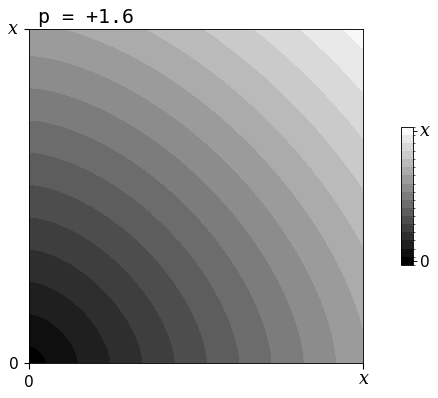

 55%|███████████████████████████████████████████████████                                          | 339/617 [00:45<00:37,  7.42it/s]

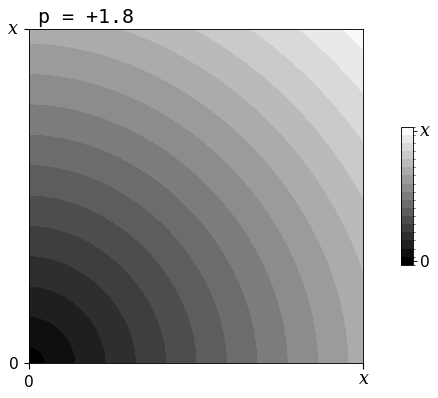

 55%|███████████████████████████████████████████████████▏                                         | 340/617 [00:45<00:36,  7.50it/s]

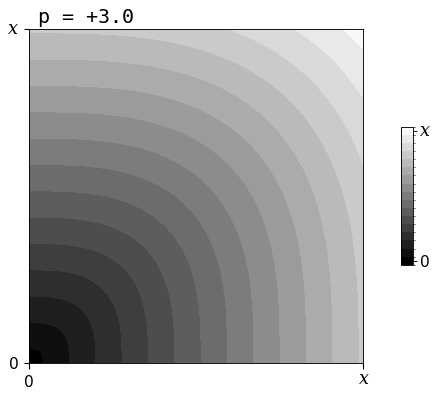

 55%|███████████████████████████████████████████████████▍                                         | 341/617 [00:46<00:36,  7.52it/s]

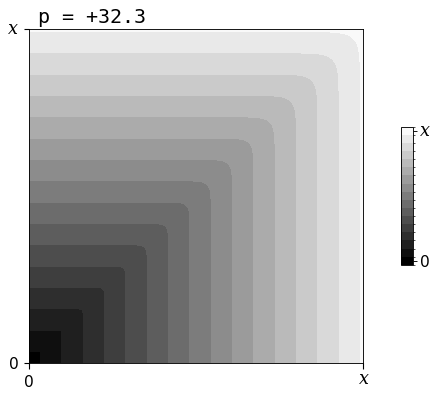

 55%|███████████████████████████████████████████████████▌                                         | 342/617 [00:46<00:36,  7.57it/s]

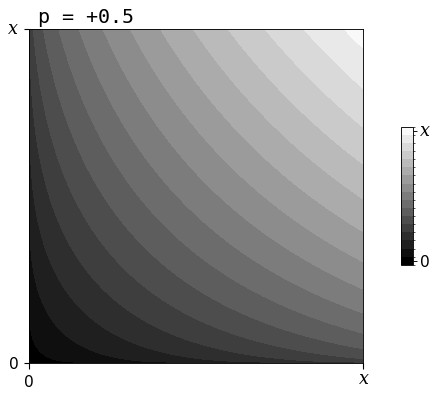

 56%|███████████████████████████████████████████████████▋                                         | 343/617 [00:46<00:36,  7.55it/s]

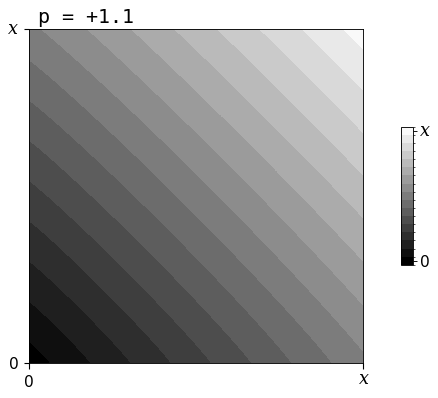

 56%|███████████████████████████████████████████████████▊                                         | 344/617 [00:46<00:36,  7.54it/s]

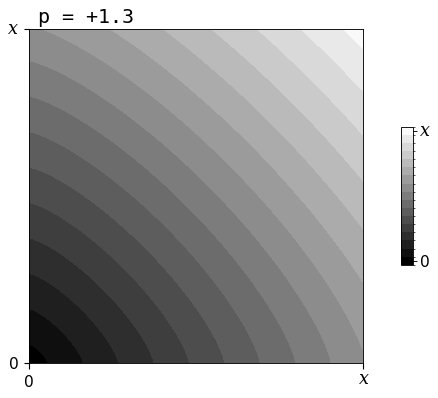

 56%|████████████████████████████████████████████████████                                         | 345/617 [00:46<00:36,  7.54it/s]

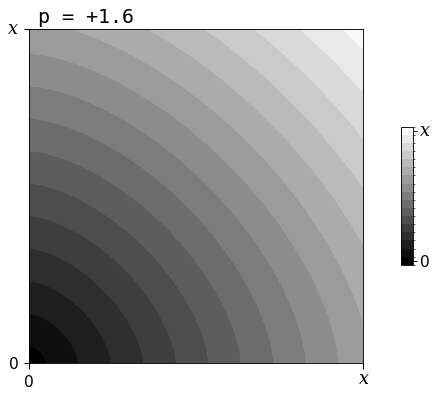

 56%|████████████████████████████████████████████████████▏                                        | 346/617 [00:46<00:35,  7.58it/s]

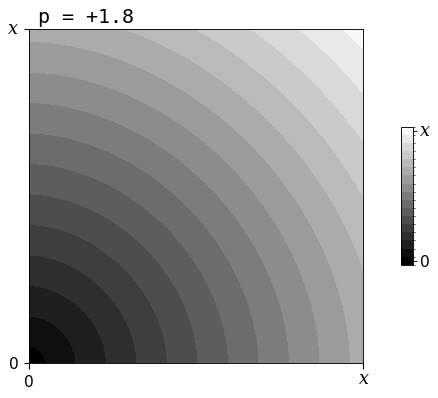

 56%|████████████████████████████████████████████████████▎                                        | 347/617 [00:46<00:35,  7.57it/s]

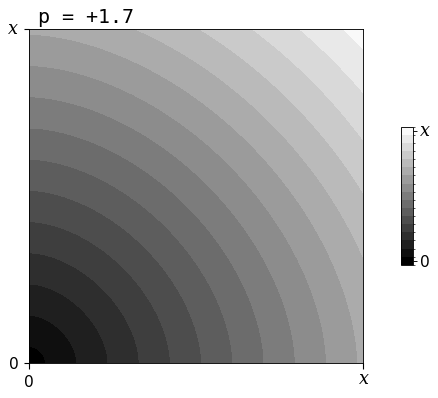

 56%|████████████████████████████████████████████████████▍                                        | 348/617 [00:47<00:38,  6.95it/s]

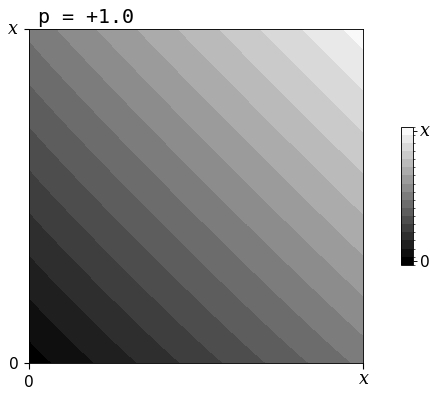

 57%|████████████████████████████████████████████████████▌                                        | 349/617 [00:47<00:37,  7.10it/s]

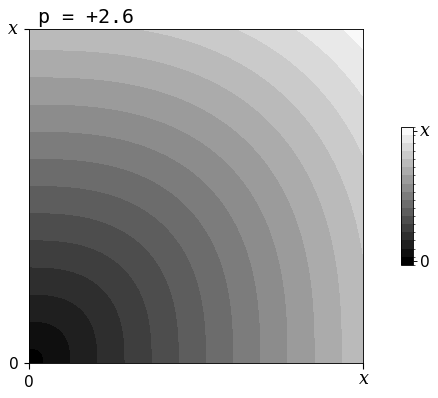

 57%|████████████████████████████████████████████████████▊                                        | 350/617 [00:47<00:36,  7.23it/s]

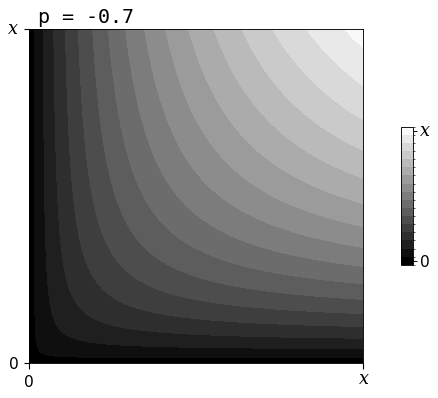

 57%|████████████████████████████████████████████████████▉                                        | 351/617 [00:47<00:36,  7.33it/s]

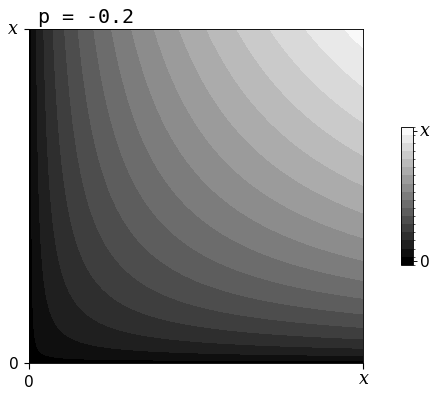

 57%|█████████████████████████████████████████████████████                                        | 352/617 [00:47<00:35,  7.38it/s]

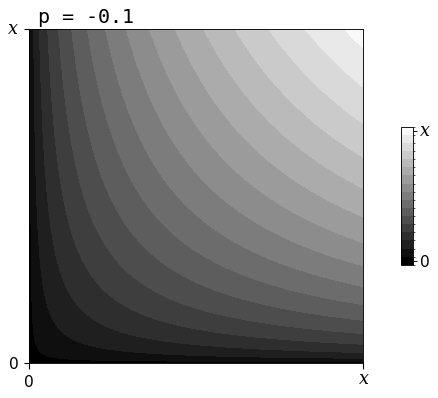

 57%|█████████████████████████████████████████████████████▏                                       | 353/617 [00:47<00:35,  7.34it/s]

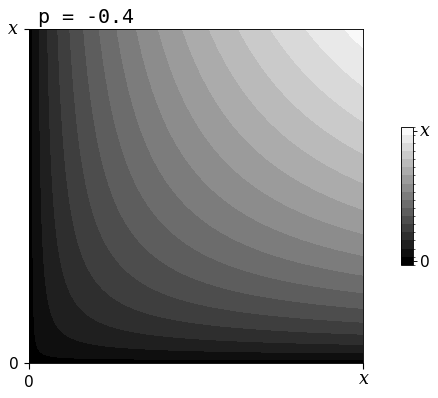

 57%|█████████████████████████████████████████████████████▎                                       | 354/617 [00:47<00:35,  7.35it/s]

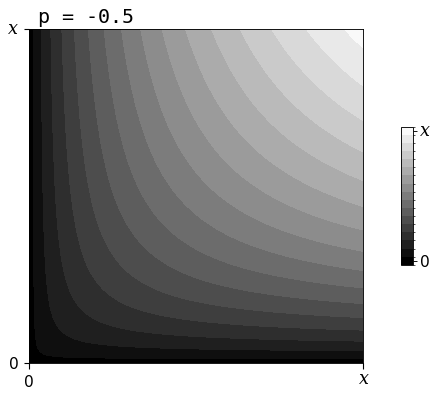

 58%|█████████████████████████████████████████████████████▌                                       | 355/617 [00:48<00:35,  7.38it/s]

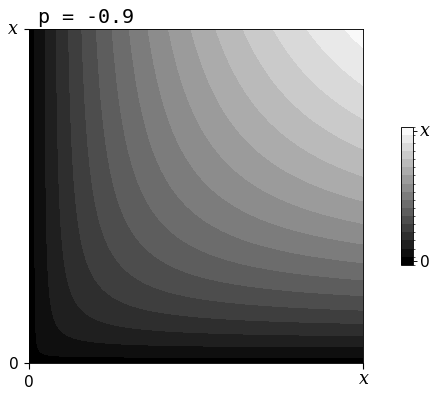

 58%|█████████████████████████████████████████████████████▋                                       | 356/617 [00:48<00:35,  7.41it/s]

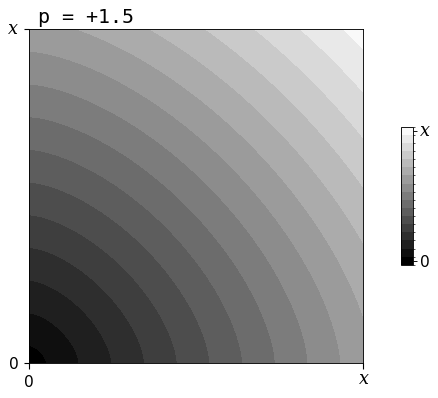

 58%|█████████████████████████████████████████████████████▊                                       | 357/617 [00:48<00:34,  7.48it/s]

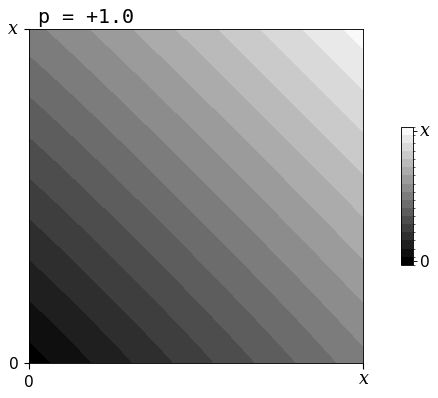

 58%|█████████████████████████████████████████████████████▉                                       | 358/617 [00:48<00:34,  7.49it/s]

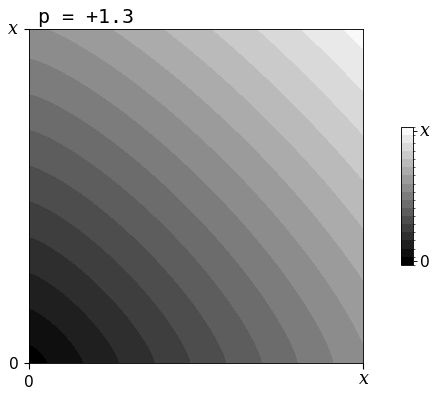

 58%|██████████████████████████████████████████████████████                                       | 359/617 [00:48<00:34,  7.52it/s]

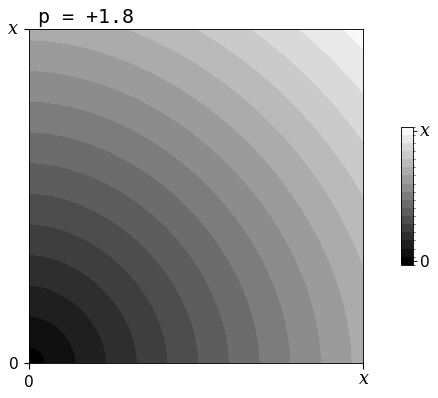

 58%|██████████████████████████████████████████████████████▎                                      | 360/617 [00:48<00:34,  7.52it/s]

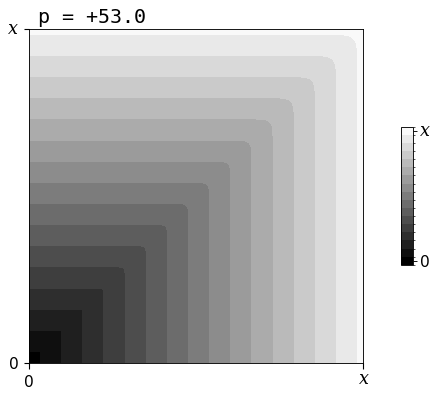

 59%|██████████████████████████████████████████████████████▍                                      | 361/617 [00:48<00:36,  6.95it/s]

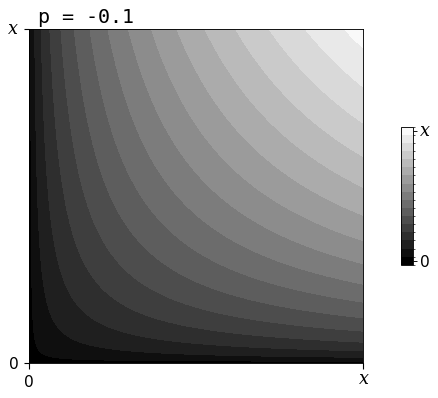

 59%|██████████████████████████████████████████████████████▌                                      | 362/617 [00:48<00:35,  7.11it/s]

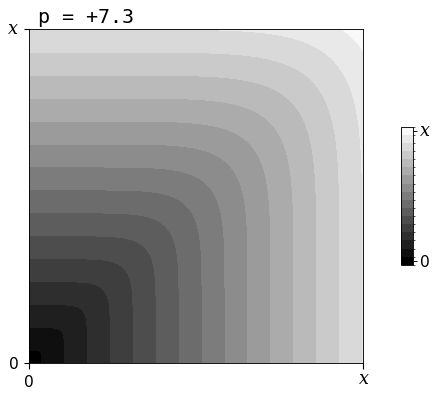

 59%|██████████████████████████████████████████████████████▋                                      | 363/617 [00:49<00:34,  7.26it/s]

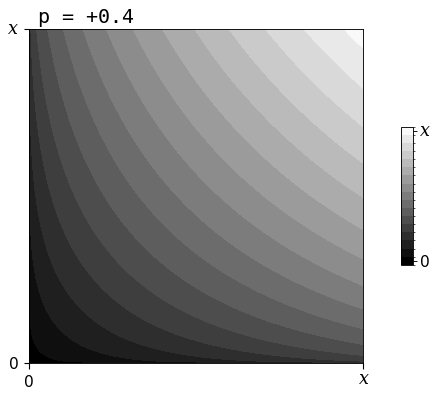

 59%|██████████████████████████████████████████████████████▊                                      | 364/617 [00:49<00:34,  7.27it/s]

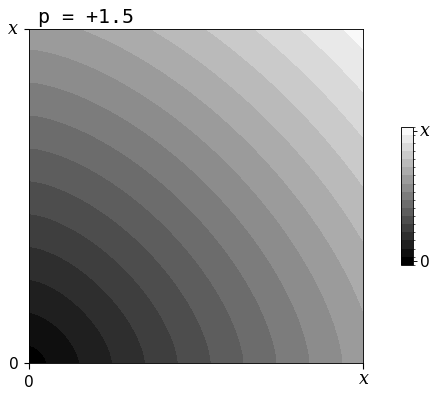

 59%|███████████████████████████████████████████████████████                                      | 365/617 [00:49<00:34,  7.28it/s]

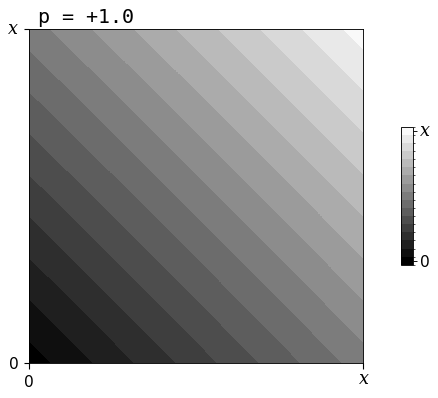

 59%|███████████████████████████████████████████████████████▏                                     | 366/617 [00:49<00:34,  7.34it/s]

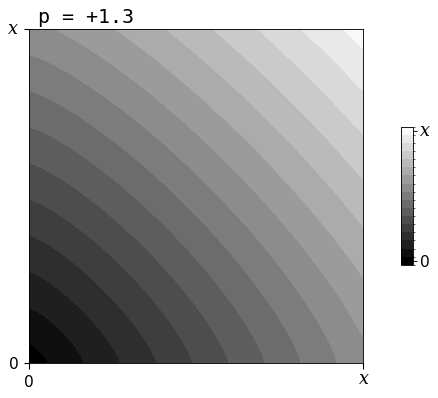

 59%|███████████████████████████████████████████████████████▎                                     | 367/617 [00:49<00:33,  7.40it/s]

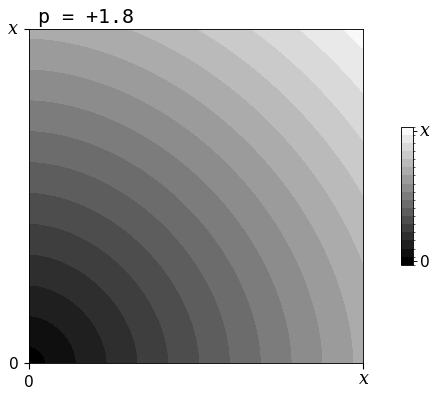

 60%|███████████████████████████████████████████████████████▍                                     | 368/617 [00:49<00:33,  7.46it/s]

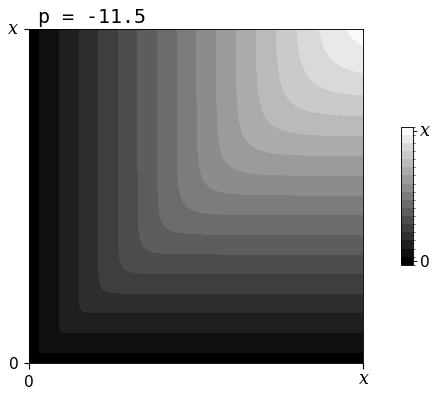

 60%|███████████████████████████████████████████████████████▌                                     | 369/617 [00:49<00:32,  7.52it/s]

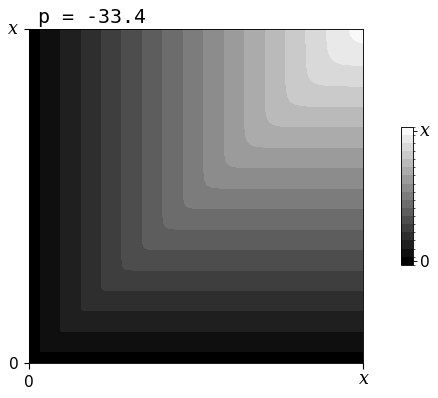

 60%|███████████████████████████████████████████████████████▊                                     | 370/617 [00:50<00:32,  7.55it/s]

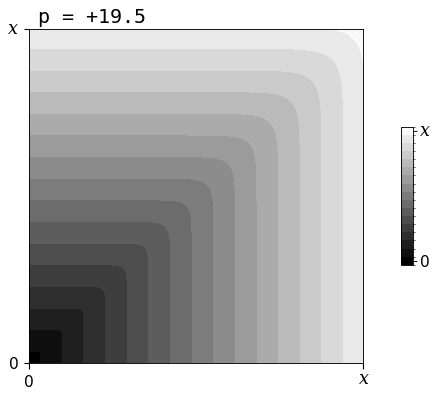

 60%|███████████████████████████████████████████████████████▉                                     | 371/617 [00:50<00:32,  7.60it/s]

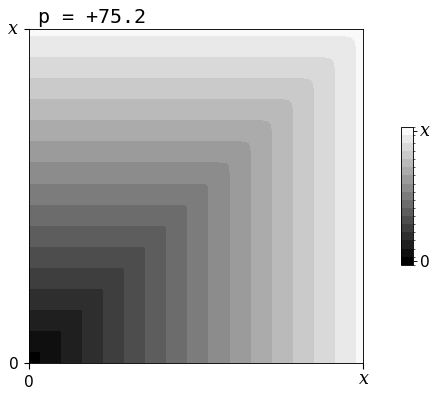

 60%|████████████████████████████████████████████████████████                                     | 372/617 [00:50<00:32,  7.64it/s]

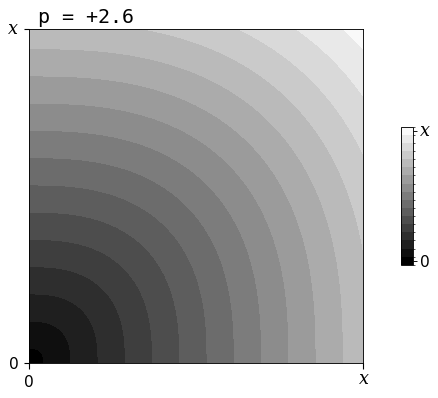

 60%|████████████████████████████████████████████████████████▏                                    | 373/617 [00:50<00:32,  7.62it/s]

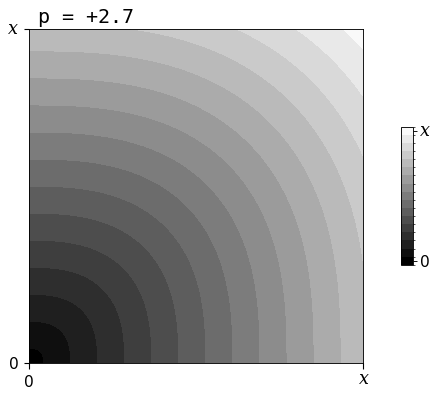

 61%|████████████████████████████████████████████████████████▎                                    | 374/617 [00:50<00:31,  7.61it/s]

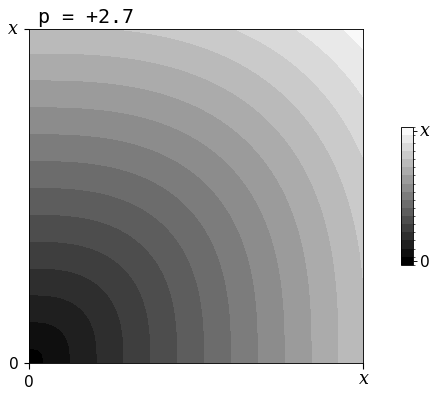

 61%|████████████████████████████████████████████████████████▌                                    | 375/617 [00:50<00:34,  6.99it/s]

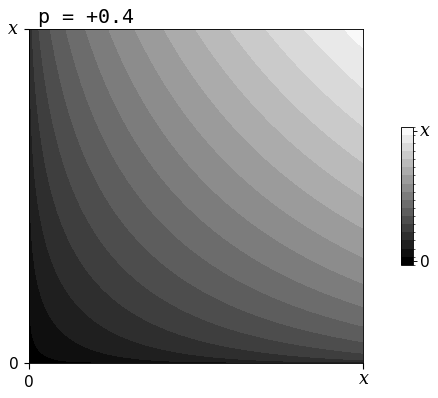

 61%|████████████████████████████████████████████████████████▋                                    | 376/617 [00:50<00:33,  7.15it/s]

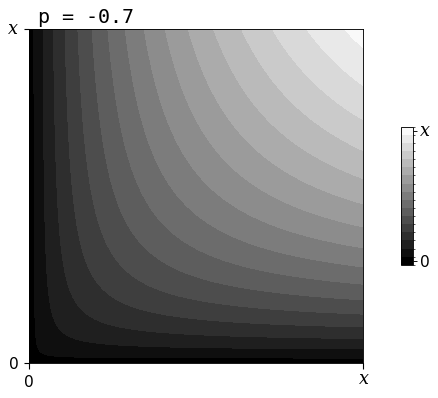

 61%|████████████████████████████████████████████████████████▊                                    | 377/617 [00:51<00:33,  7.11it/s]

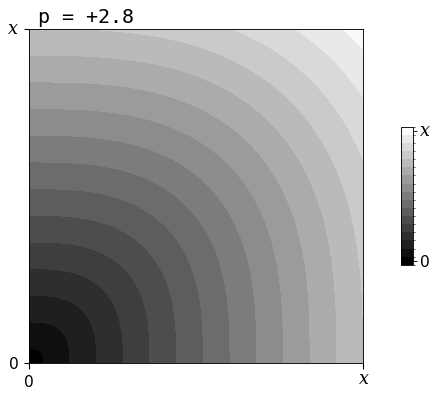

 61%|████████████████████████████████████████████████████████▉                                    | 378/617 [00:51<00:33,  7.10it/s]

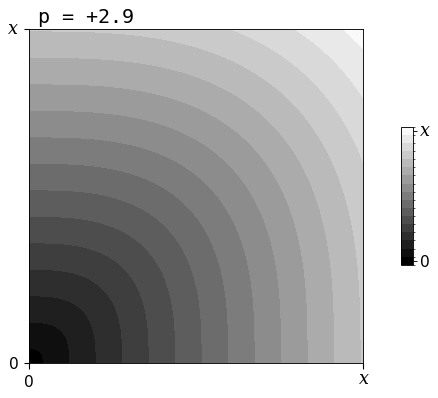

 61%|█████████████████████████████████████████████████████████▏                                   | 379/617 [00:51<00:33,  7.05it/s]

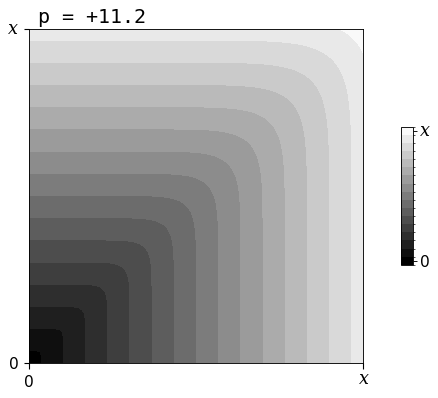

 62%|█████████████████████████████████████████████████████████▎                                   | 380/617 [00:51<00:33,  7.12it/s]

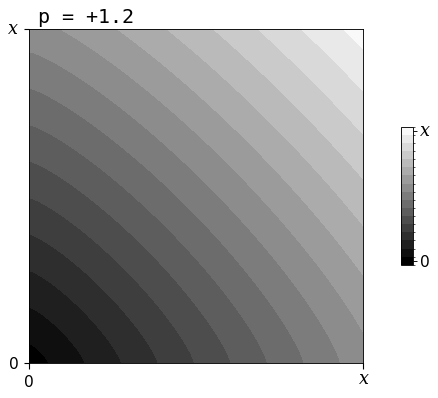

 62%|█████████████████████████████████████████████████████████▍                                   | 381/617 [00:51<00:32,  7.22it/s]

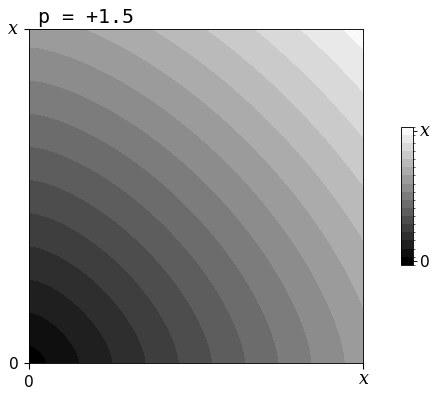

 62%|█████████████████████████████████████████████████████████▌                                   | 382/617 [00:51<00:32,  7.28it/s]

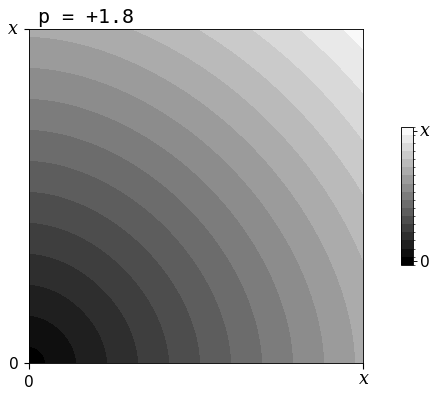

 62%|█████████████████████████████████████████████████████████▋                                   | 383/617 [00:51<00:32,  7.31it/s]

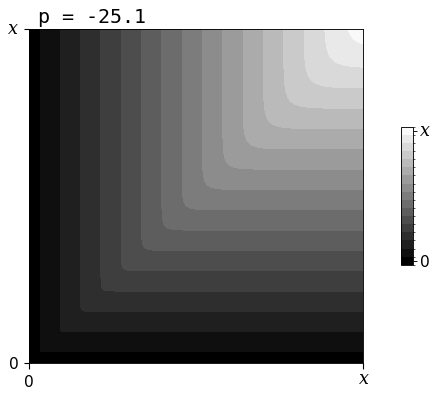

 62%|█████████████████████████████████████████████████████████▉                                   | 384/617 [00:51<00:31,  7.40it/s]

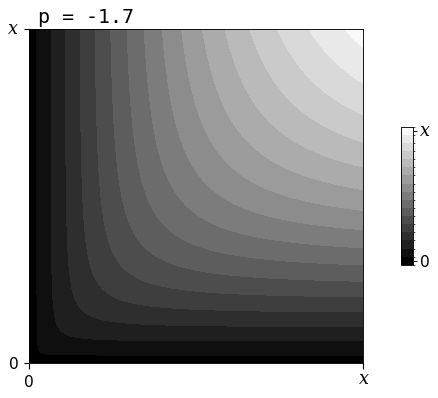

 62%|██████████████████████████████████████████████████████████                                   | 385/617 [00:52<00:31,  7.38it/s]

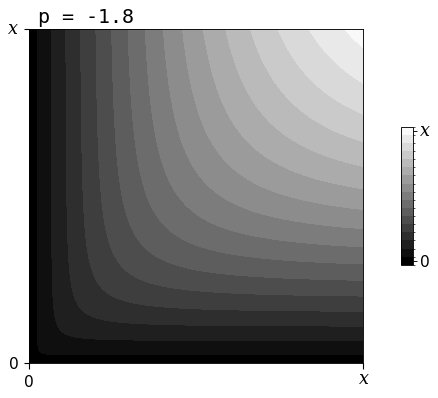

 63%|██████████████████████████████████████████████████████████▏                                  | 386/617 [00:52<00:31,  7.42it/s]

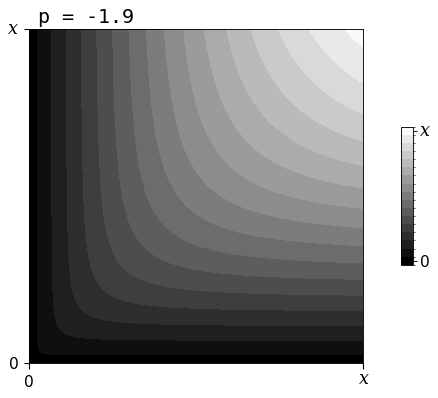

 63%|██████████████████████████████████████████████████████████▎                                  | 387/617 [00:52<00:30,  7.48it/s]

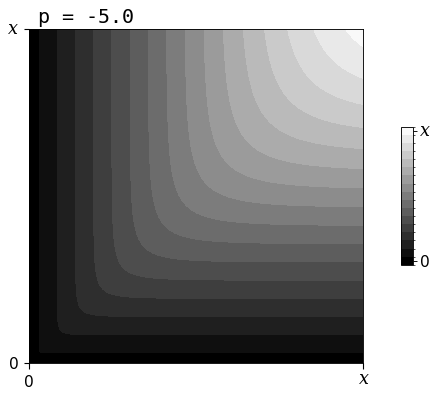

 63%|██████████████████████████████████████████████████████████▍                                  | 388/617 [00:52<00:33,  6.89it/s]

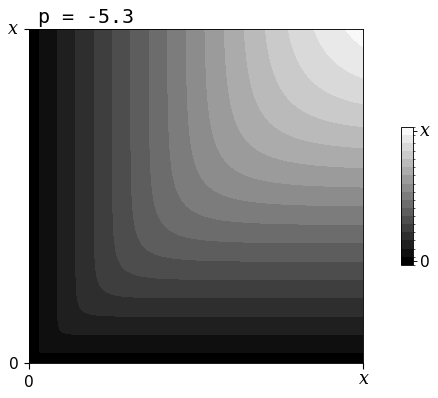

 63%|██████████████████████████████████████████████████████████▋                                  | 389/617 [00:52<00:32,  7.09it/s]

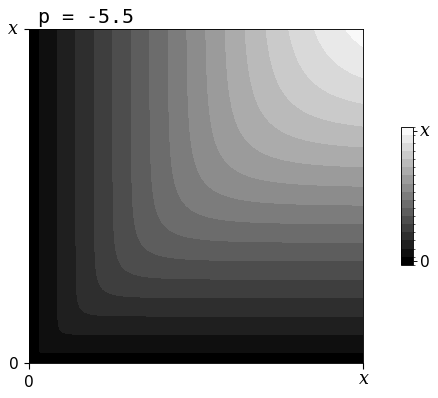

 63%|██████████████████████████████████████████████████████████▊                                  | 390/617 [00:52<00:31,  7.23it/s]

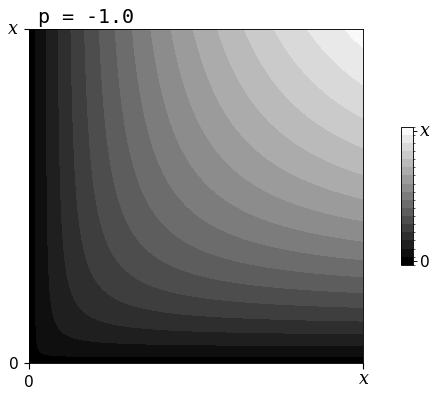

 63%|██████████████████████████████████████████████████████████▉                                  | 391/617 [00:52<00:30,  7.30it/s]

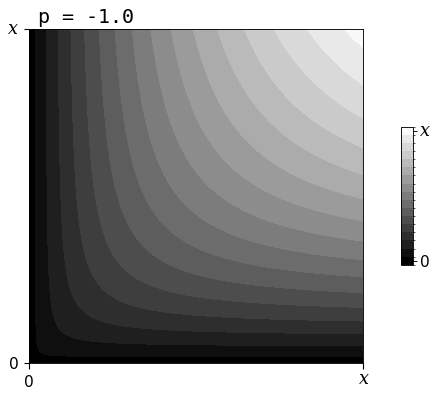

 64%|███████████████████████████████████████████████████████████                                  | 392/617 [00:53<00:30,  7.38it/s]

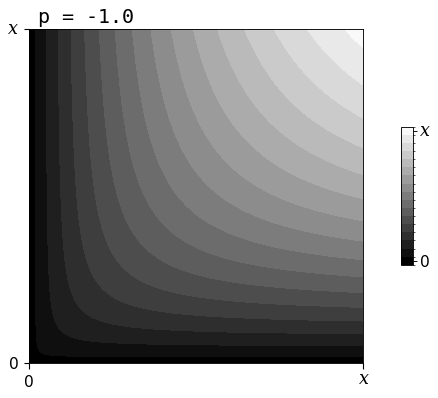

 64%|███████████████████████████████████████████████████████████▏                                 | 393/617 [00:53<00:30,  7.43it/s]

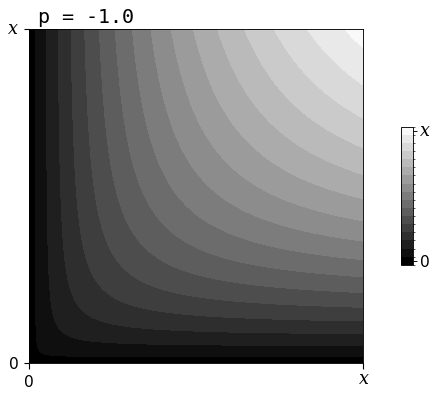

 64%|███████████████████████████████████████████████████████████▍                                 | 394/617 [00:53<00:29,  7.46it/s]

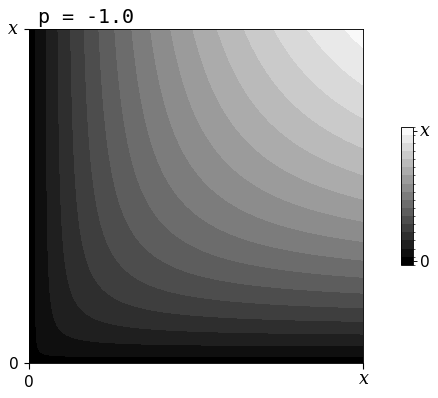

 64%|███████████████████████████████████████████████████████████▌                                 | 395/617 [00:53<00:29,  7.49it/s]

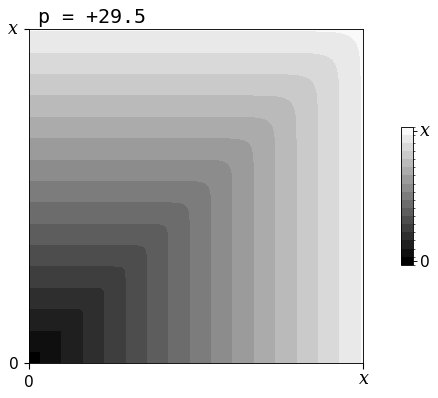

 64%|███████████████████████████████████████████████████████████▋                                 | 396/617 [00:53<00:29,  7.54it/s]

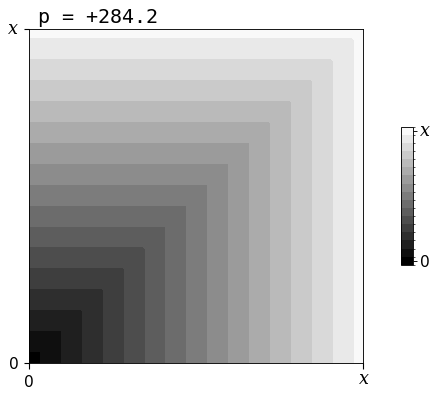

 64%|███████████████████████████████████████████████████████████▊                                 | 397/617 [00:53<00:29,  7.57it/s]

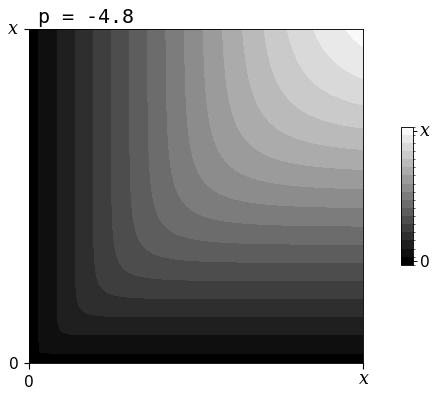

 65%|███████████████████████████████████████████████████████████▉                                 | 398/617 [00:53<00:28,  7.58it/s]

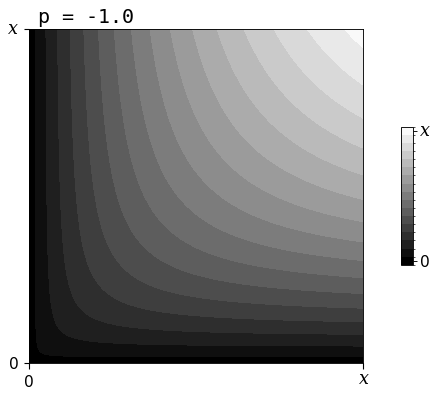

 65%|████████████████████████████████████████████████████████████▏                                | 399/617 [00:54<00:28,  7.57it/s]

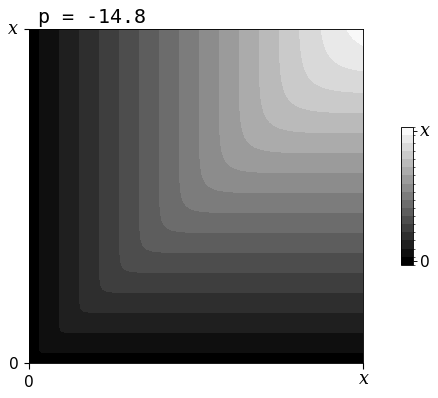

 65%|████████████████████████████████████████████████████████████▎                                | 400/617 [00:54<00:28,  7.58it/s]

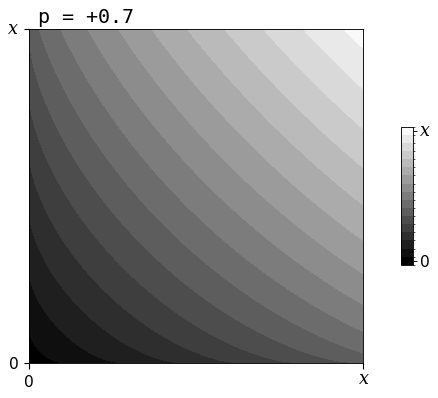

 65%|████████████████████████████████████████████████████████████▍                                | 401/617 [00:54<00:31,  6.82it/s]

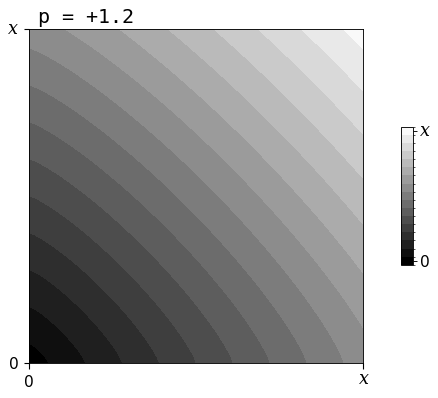

 65%|████████████████████████████████████████████████████████████▌                                | 402/617 [00:54<00:30,  7.00it/s]

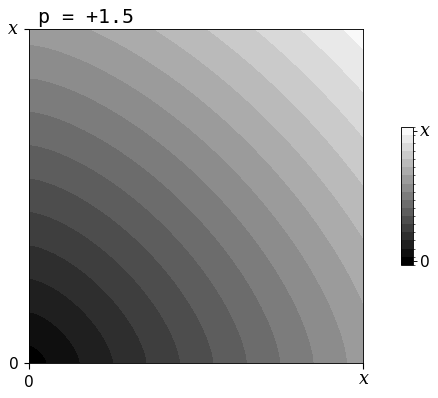

 65%|████████████████████████████████████████████████████████████▋                                | 403/617 [00:54<00:29,  7.15it/s]

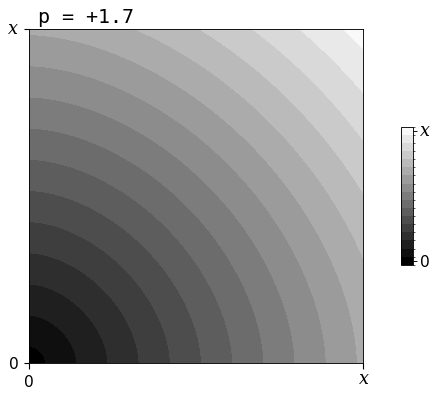

 65%|████████████████████████████████████████████████████████████▉                                | 404/617 [00:54<00:29,  7.29it/s]

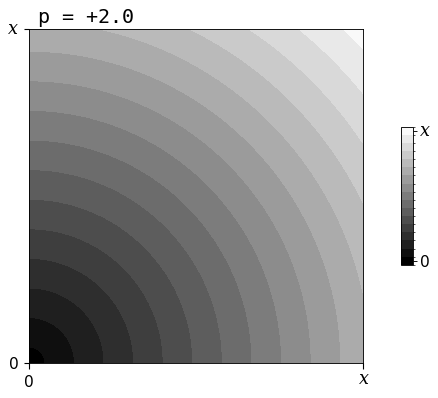

 66%|█████████████████████████████████████████████████████████████                                | 405/617 [00:54<00:28,  7.38it/s]

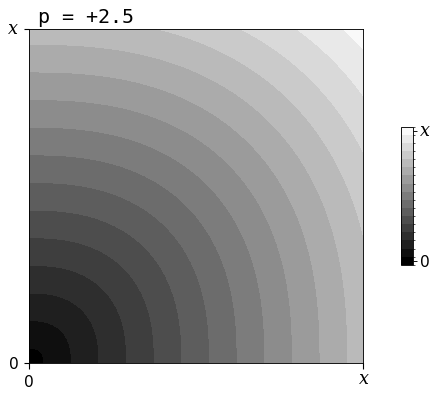

 66%|█████████████████████████████████████████████████████████████▏                               | 406/617 [00:54<00:28,  7.45it/s]

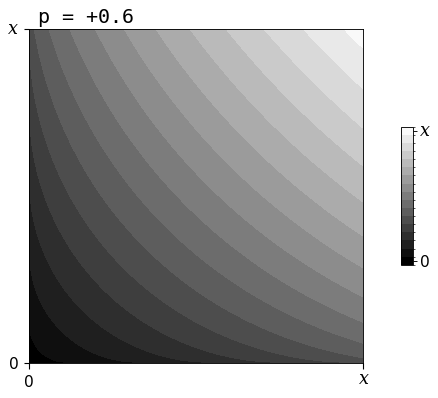

 66%|█████████████████████████████████████████████████████████████▎                               | 407/617 [00:55<00:28,  7.47it/s]

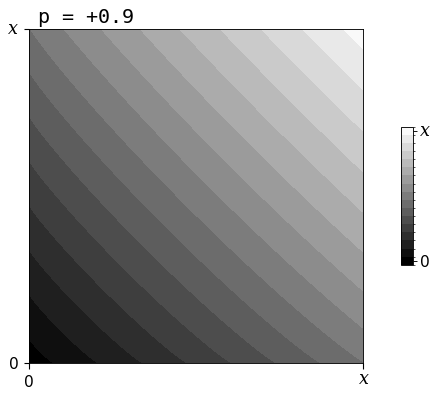

 66%|█████████████████████████████████████████████████████████████▍                               | 408/617 [00:55<00:27,  7.49it/s]

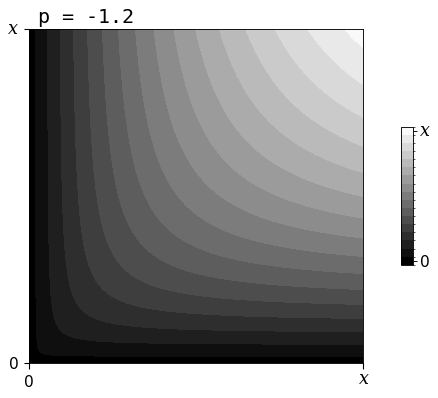

 66%|█████████████████████████████████████████████████████████████▋                               | 409/617 [00:55<00:27,  7.49it/s]

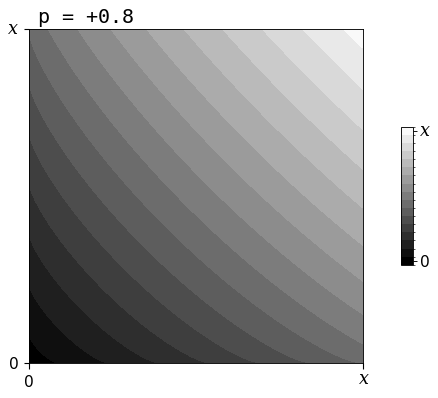

 66%|█████████████████████████████████████████████████████████████▊                               | 410/617 [00:55<00:27,  7.49it/s]

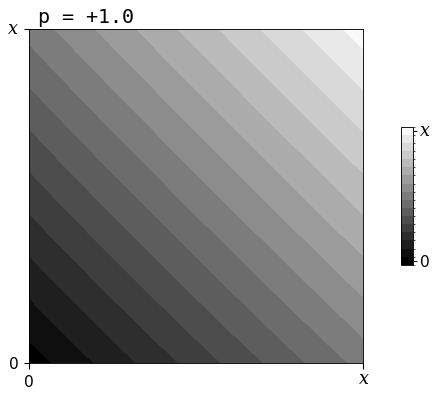

 67%|█████████████████████████████████████████████████████████████▉                               | 411/617 [00:55<00:28,  7.35it/s]

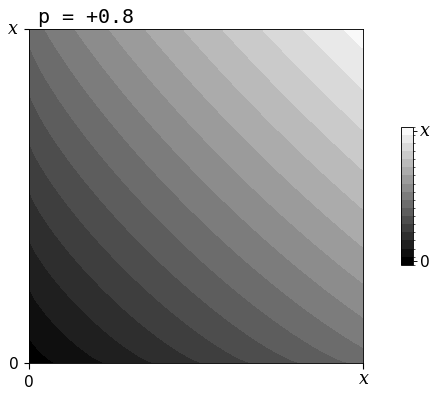

 67%|██████████████████████████████████████████████████████████████                               | 412/617 [00:55<00:28,  7.25it/s]

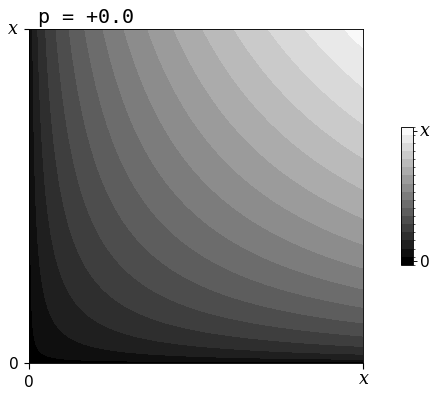

 67%|██████████████████████████████████████████████████████████████▎                              | 413/617 [00:55<00:28,  7.06it/s]

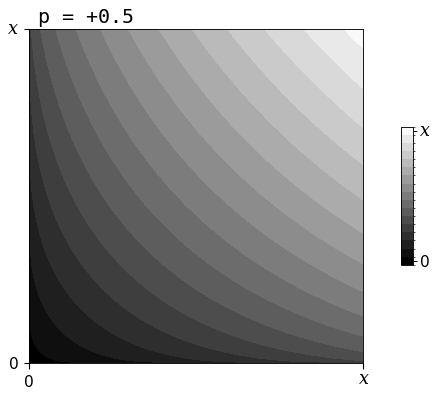

 67%|██████████████████████████████████████████████████████████████▍                              | 414/617 [00:56<00:30,  6.59it/s]

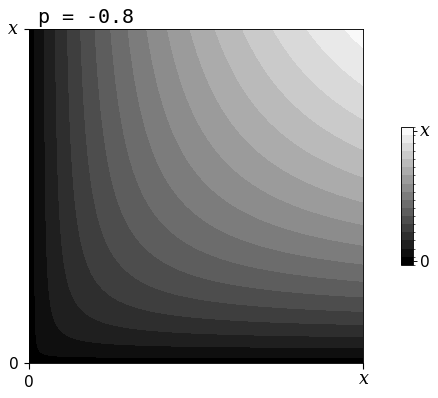

 67%|██████████████████████████████████████████████████████████████▌                              | 415/617 [00:56<00:29,  6.84it/s]

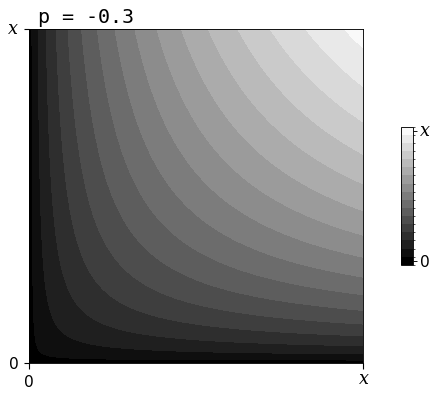

 67%|██████████████████████████████████████████████████████████████▋                              | 416/617 [00:56<00:28,  7.03it/s]

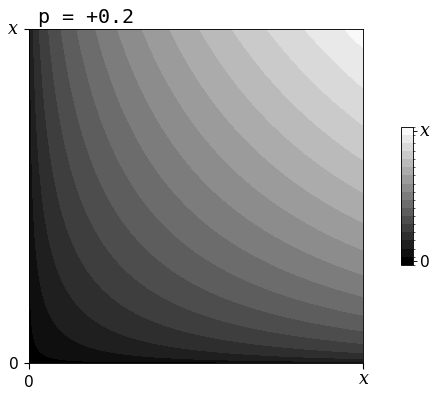

 68%|██████████████████████████████████████████████████████████████▊                              | 417/617 [00:56<00:27,  7.19it/s]

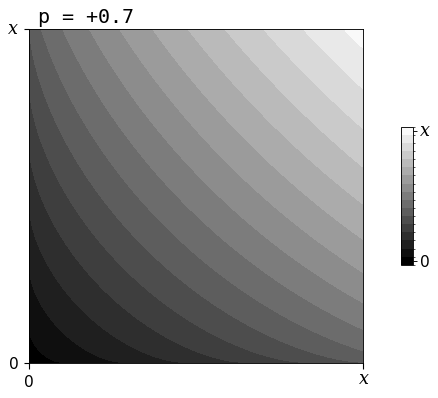

 68%|███████████████████████████████████████████████████████████████                              | 418/617 [00:56<00:27,  7.28it/s]

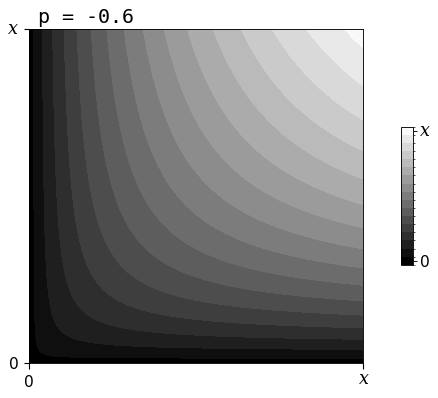

 68%|███████████████████████████████████████████████████████████████▏                             | 419/617 [00:56<00:26,  7.35it/s]

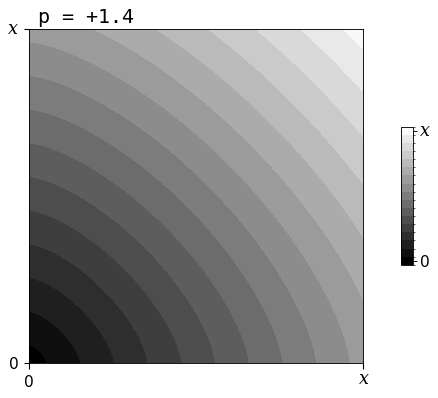

 68%|███████████████████████████████████████████████████████████████▎                             | 420/617 [00:56<00:26,  7.41it/s]

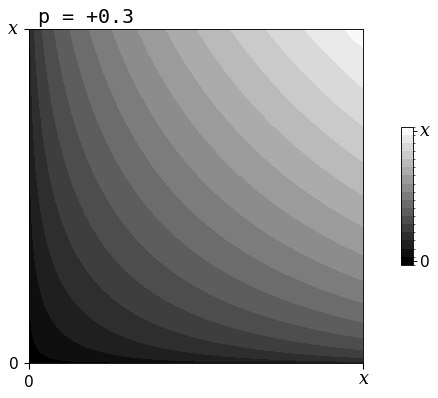

 68%|███████████████████████████████████████████████████████████████▍                             | 421/617 [00:57<00:26,  7.47it/s]

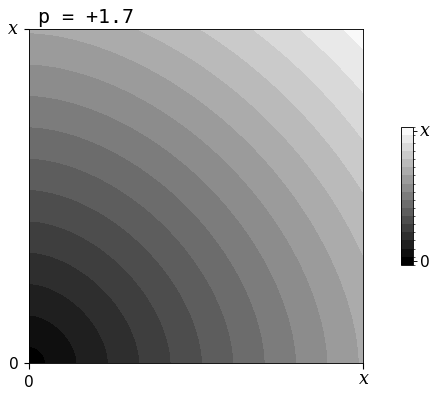

 68%|███████████████████████████████████████████████████████████████▌                             | 422/617 [00:57<00:26,  7.50it/s]

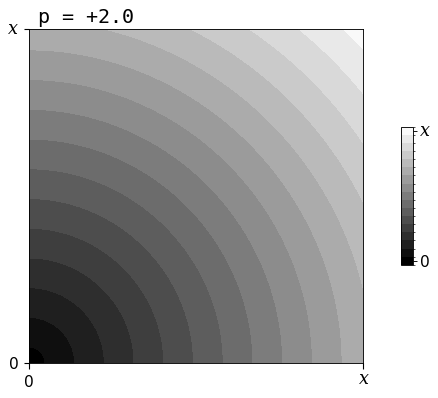

 69%|███████████████████████████████████████████████████████████████▊                             | 423/617 [00:57<00:25,  7.52it/s]

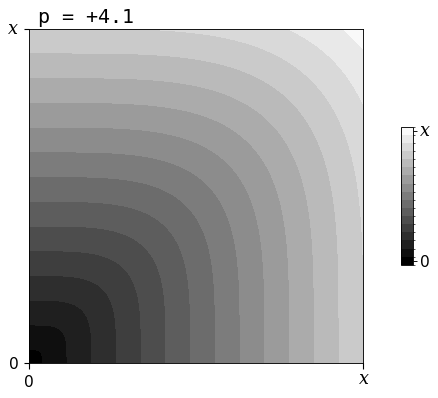

 69%|███████████████████████████████████████████████████████████████▉                             | 424/617 [00:57<00:25,  7.56it/s]

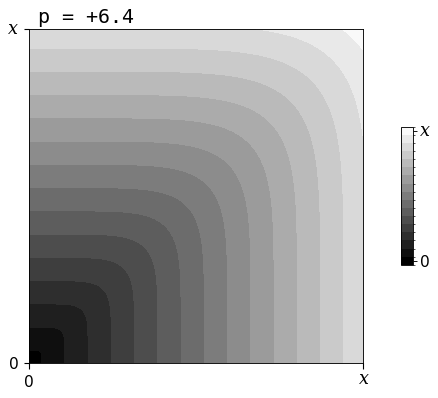

 69%|████████████████████████████████████████████████████████████████                             | 425/617 [00:57<00:25,  7.59it/s]

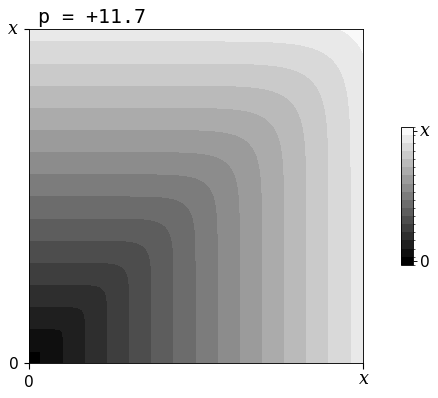

 69%|████████████████████████████████████████████████████████████████▏                            | 426/617 [00:57<00:25,  7.60it/s]

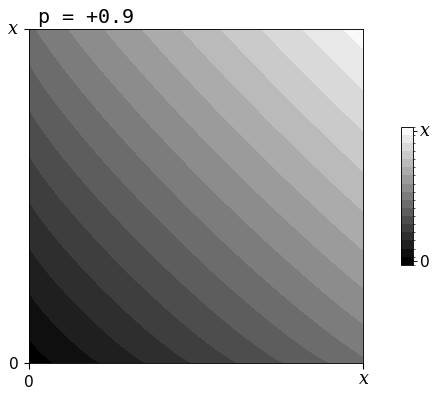

 69%|████████████████████████████████████████████████████████████████▎                            | 427/617 [00:57<00:24,  7.60it/s]

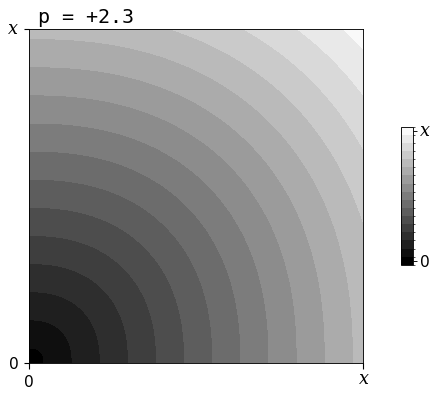

 69%|████████████████████████████████████████████████████████████████▌                            | 428/617 [00:58<00:27,  6.97it/s]

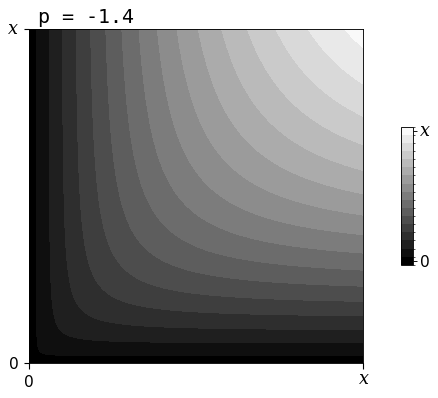

 70%|████████████████████████████████████████████████████████████████▋                            | 429/617 [00:58<00:26,  7.14it/s]

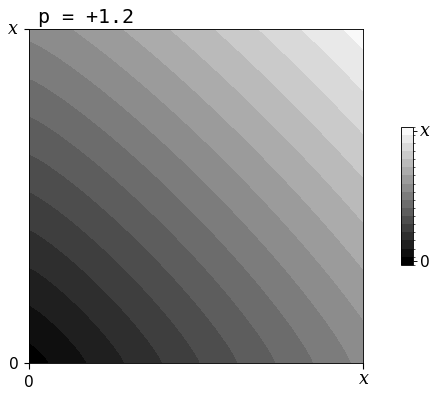

 70%|████████████████████████████████████████████████████████████████▊                            | 430/617 [00:58<00:25,  7.26it/s]

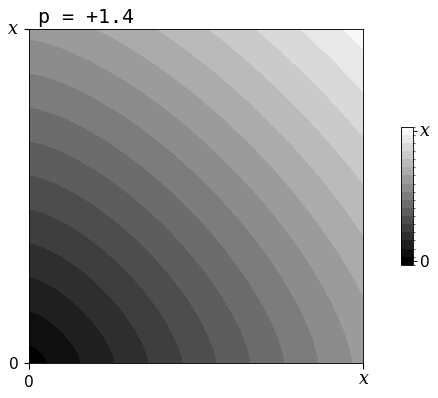

 70%|████████████████████████████████████████████████████████████████▉                            | 431/617 [00:58<00:25,  7.32it/s]

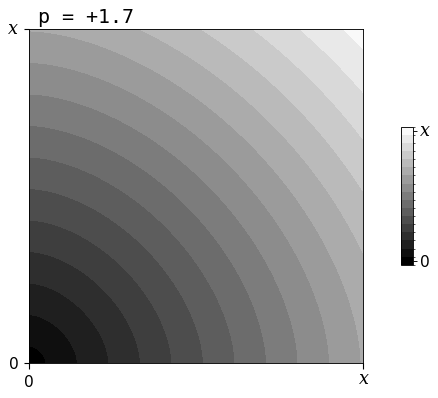

 70%|█████████████████████████████████████████████████████████████████                            | 432/617 [00:58<00:25,  7.36it/s]

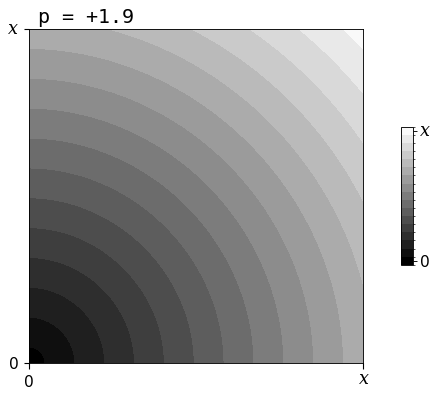

 70%|█████████████████████████████████████████████████████████████████▎                           | 433/617 [00:58<00:24,  7.43it/s]

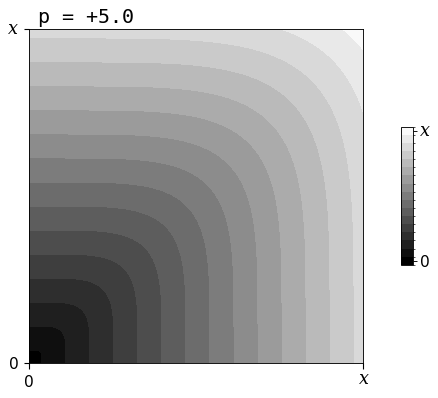

 70%|█████████████████████████████████████████████████████████████████▍                           | 434/617 [00:58<00:24,  7.49it/s]

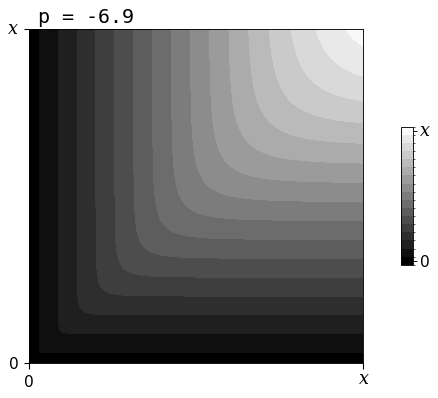

 71%|█████████████████████████████████████████████████████████████████▌                           | 435/617 [00:58<00:24,  7.51it/s]

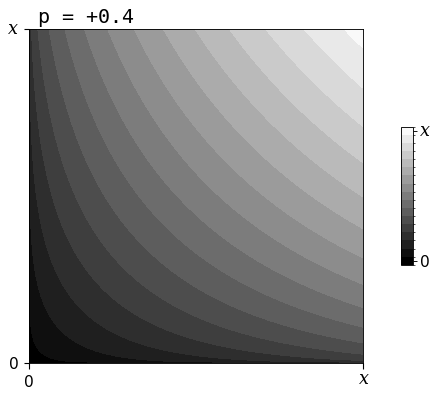

 71%|█████████████████████████████████████████████████████████████████▋                           | 436/617 [00:59<00:24,  7.52it/s]

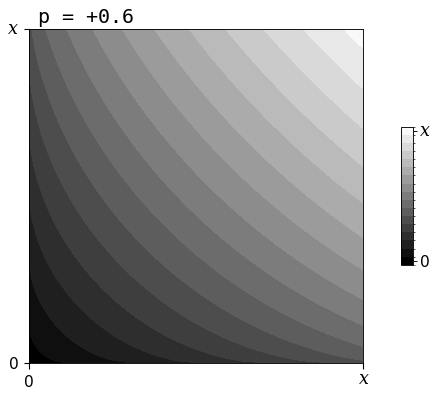

 71%|█████████████████████████████████████████████████████████████████▊                           | 437/617 [00:59<00:23,  7.51it/s]

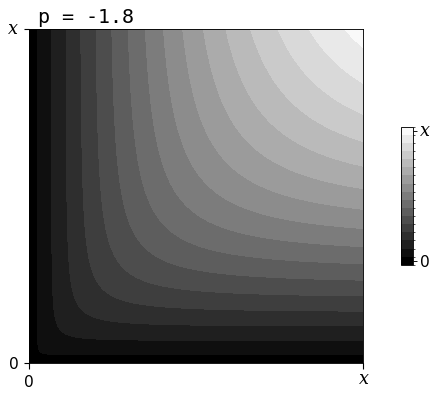

 71%|██████████████████████████████████████████████████████████████████                           | 438/617 [00:59<00:23,  7.52it/s]

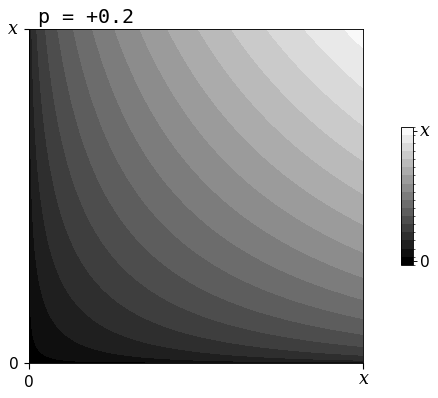

 71%|██████████████████████████████████████████████████████████████████▏                          | 439/617 [00:59<00:23,  7.55it/s]

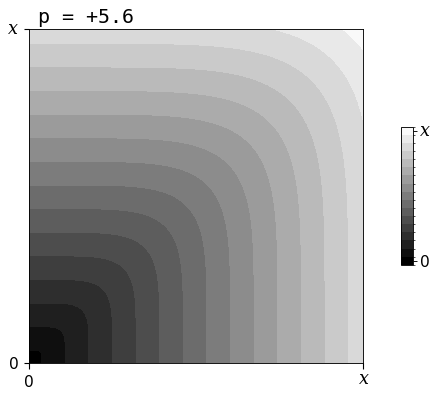

 71%|██████████████████████████████████████████████████████████████████▎                          | 440/617 [00:59<00:23,  7.57it/s]

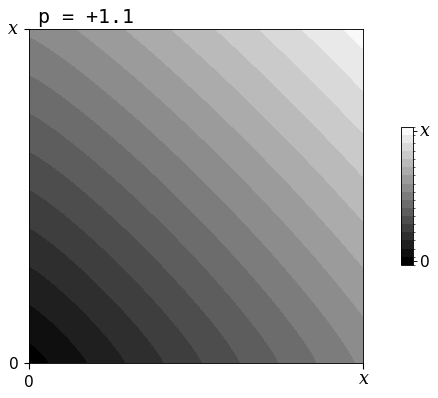

 71%|██████████████████████████████████████████████████████████████████▍                          | 441/617 [00:59<00:25,  6.94it/s]

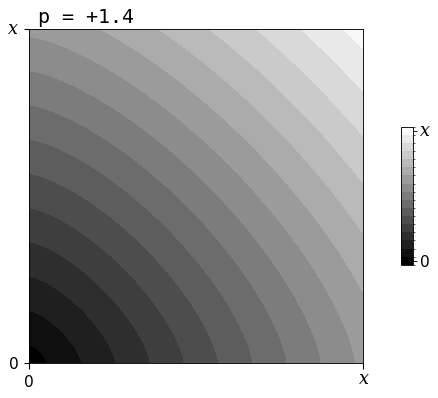

 72%|██████████████████████████████████████████████████████████████████▌                          | 442/617 [00:59<00:24,  7.11it/s]

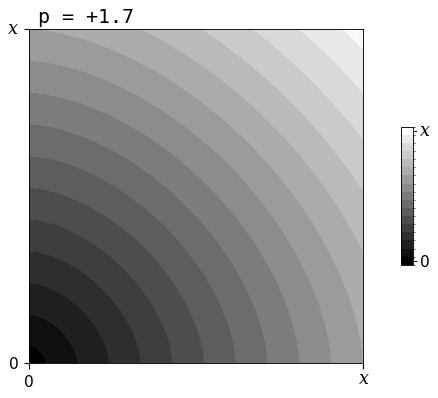

 72%|██████████████████████████████████████████████████████████████████▊                          | 443/617 [01:00<00:24,  7.25it/s]

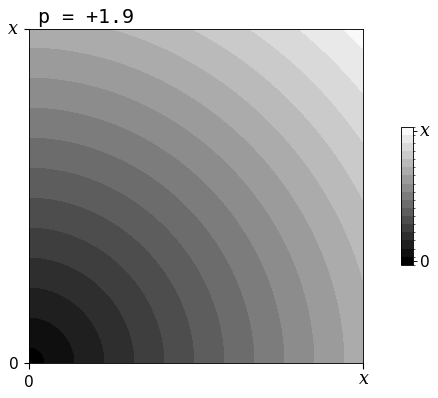

 72%|██████████████████████████████████████████████████████████████████▉                          | 444/617 [01:00<00:23,  7.36it/s]

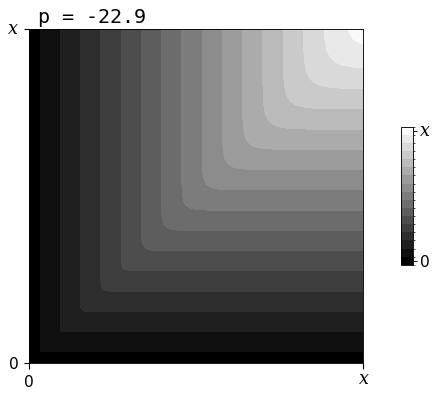

 72%|███████████████████████████████████████████████████████████████████                          | 445/617 [01:00<00:23,  7.44it/s]/var/folders/rk/_03v68t177n7g915xb4mj2xc0000gq/T/ipykernel_57479/2326477229.py:3: RuntimeWarning: overflow encountered in double_scalars
  return ((a**p + b**p)/2)**(1/p)


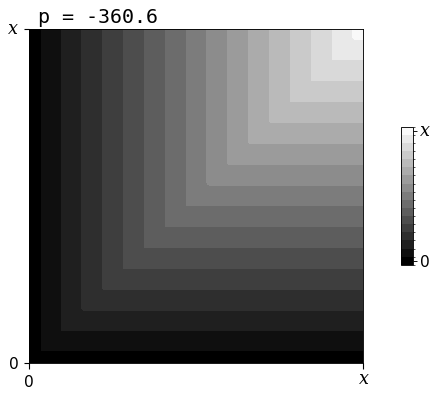

 72%|███████████████████████████████████████████████████████████████████▏                         | 446/617 [01:00<00:23,  7.42it/s]

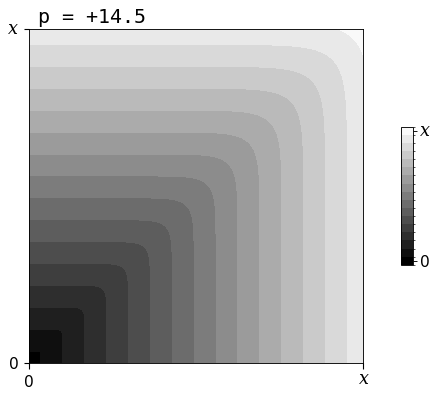

 72%|███████████████████████████████████████████████████████████████████▍                         | 447/617 [01:00<00:22,  7.50it/s]

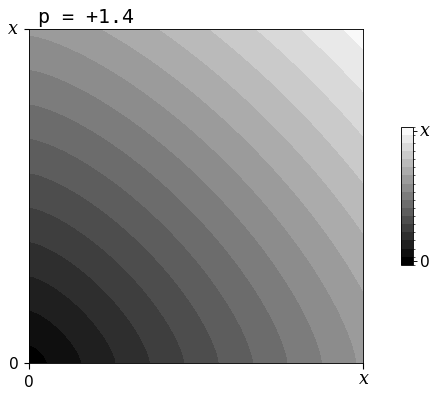

 73%|███████████████████████████████████████████████████████████████████▌                         | 448/617 [01:00<00:22,  7.51it/s]

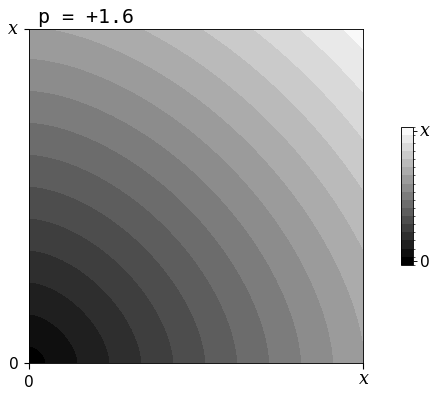

 73%|███████████████████████████████████████████████████████████████████▋                         | 449/617 [01:00<00:22,  7.52it/s]

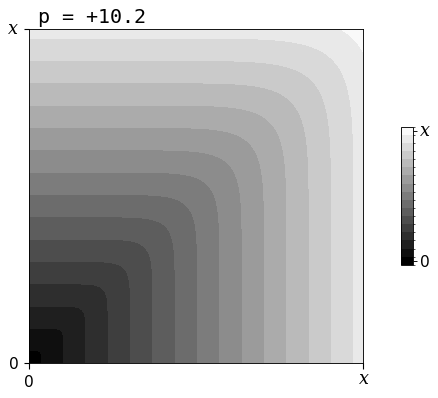

 73%|███████████████████████████████████████████████████████████████████▊                         | 450/617 [01:00<00:22,  7.58it/s]

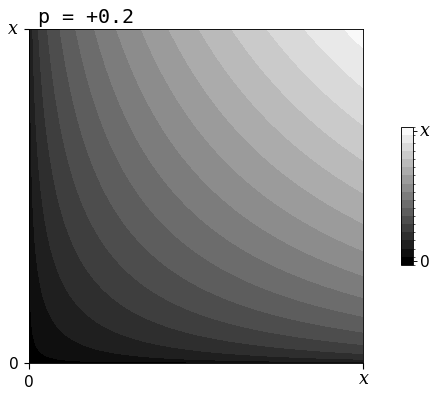

 73%|███████████████████████████████████████████████████████████████████▉                         | 451/617 [01:01<00:21,  7.57it/s]

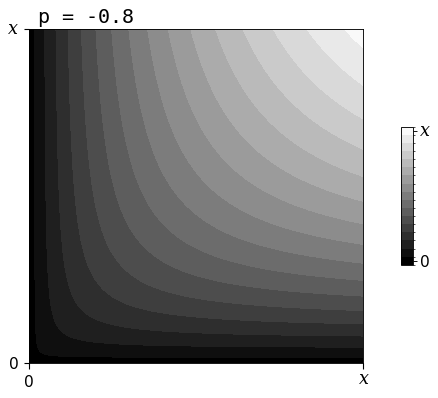

 73%|████████████████████████████████████████████████████████████████████▏                        | 452/617 [01:01<00:21,  7.56it/s]

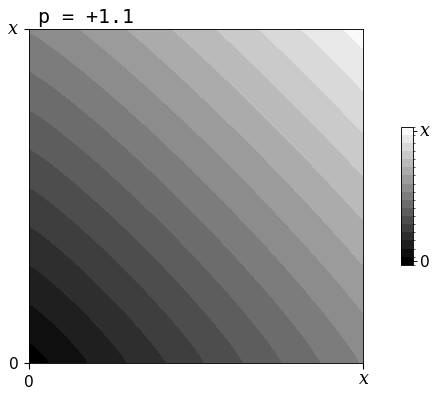

 73%|████████████████████████████████████████████████████████████████████▎                        | 453/617 [01:01<00:21,  7.57it/s]

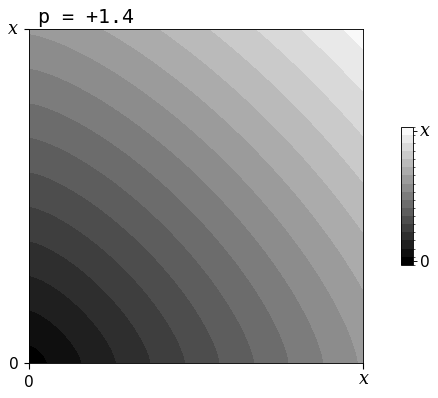

 74%|████████████████████████████████████████████████████████████████████▍                        | 454/617 [01:01<00:23,  6.95it/s]

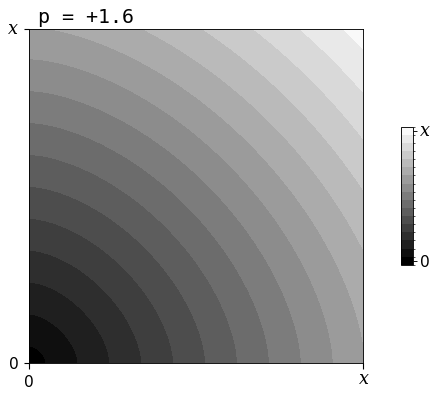

 74%|████████████████████████████████████████████████████████████████████▌                        | 455/617 [01:01<00:22,  7.11it/s]

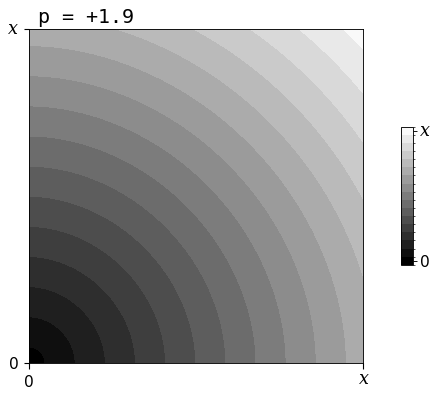

 74%|████████████████████████████████████████████████████████████████████▋                        | 456/617 [01:01<00:22,  7.26it/s]

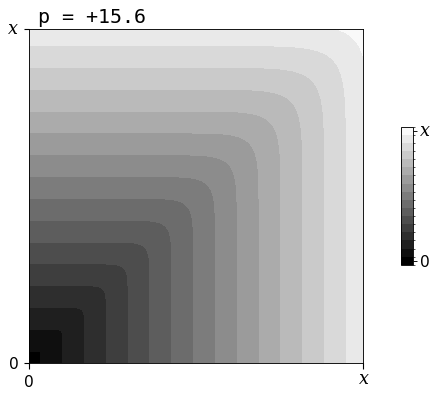

 74%|████████████████████████████████████████████████████████████████████▉                        | 457/617 [01:01<00:21,  7.36it/s]

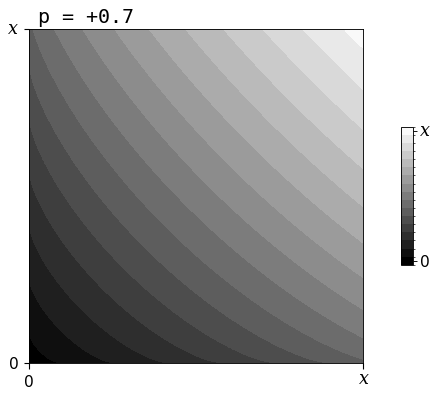

 74%|█████████████████████████████████████████████████████████████████████                        | 458/617 [01:02<00:21,  7.38it/s]

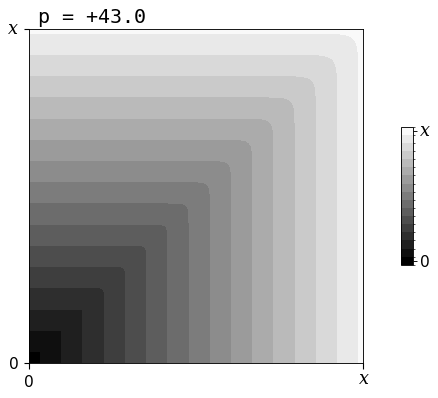

 74%|█████████████████████████████████████████████████████████████████████▏                       | 459/617 [01:02<00:21,  7.49it/s]

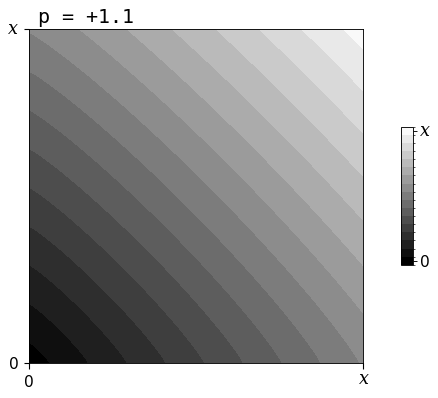

 75%|█████████████████████████████████████████████████████████████████████▎                       | 460/617 [01:02<00:20,  7.51it/s]

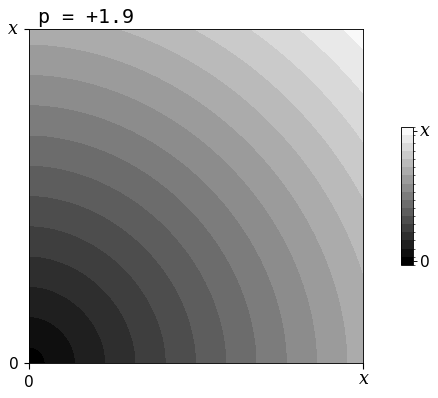

 75%|█████████████████████████████████████████████████████████████████████▍                       | 461/617 [01:02<00:20,  7.52it/s]

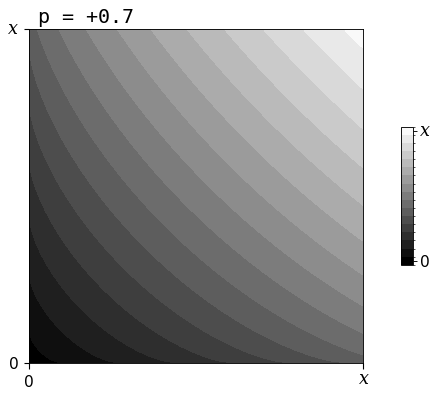

 75%|█████████████████████████████████████████████████████████████████████▋                       | 462/617 [01:02<00:20,  7.54it/s]

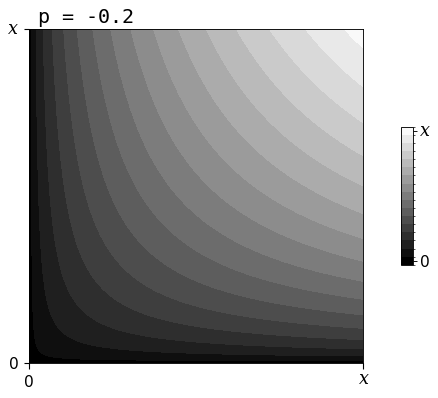

 75%|█████████████████████████████████████████████████████████████████████▊                       | 463/617 [01:02<00:20,  7.53it/s]

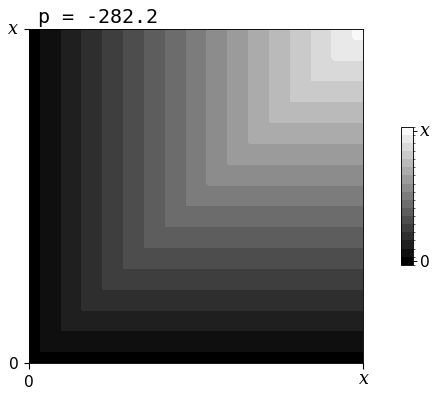

 75%|█████████████████████████████████████████████████████████████████████▉                       | 464/617 [01:02<00:20,  7.52it/s]

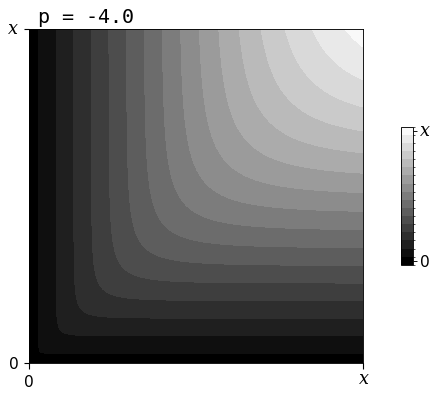

 75%|██████████████████████████████████████████████████████████████████████                       | 465/617 [01:02<00:20,  7.53it/s]

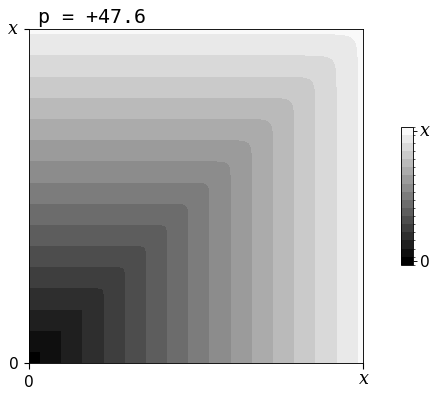

 76%|██████████████████████████████████████████████████████████████████████▏                      | 466/617 [01:03<00:19,  7.59it/s]

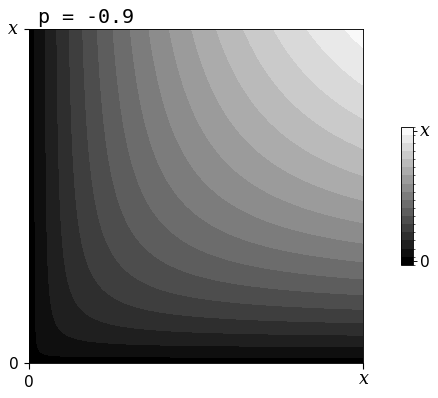

 76%|██████████████████████████████████████████████████████████████████████▍                      | 467/617 [01:03<00:19,  7.57it/s]

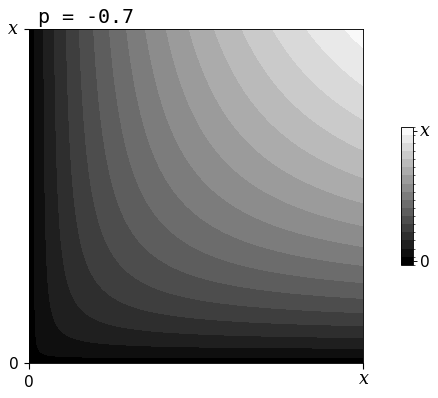

 76%|██████████████████████████████████████████████████████████████████████▌                      | 468/617 [01:03<00:21,  6.95it/s]

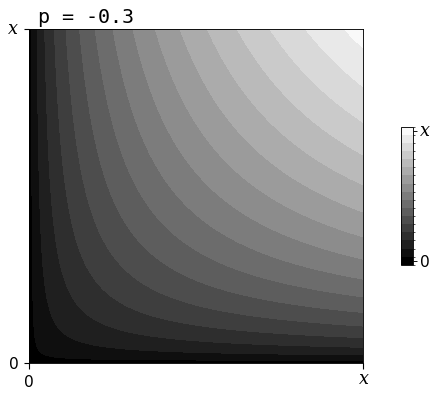

 76%|██████████████████████████████████████████████████████████████████████▋                      | 469/617 [01:03<00:20,  7.11it/s]

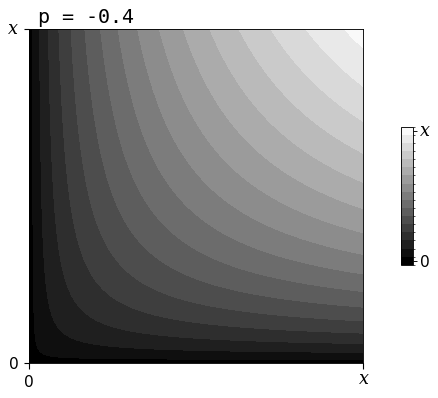

 76%|██████████████████████████████████████████████████████████████████████▊                      | 470/617 [01:03<00:20,  7.06it/s]

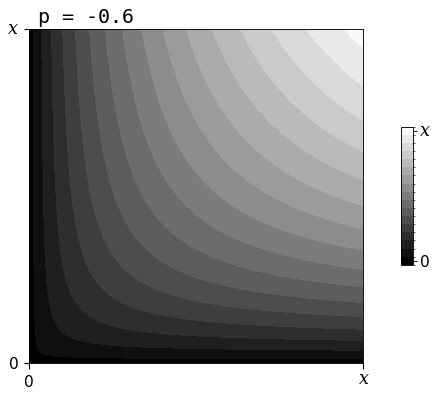

 76%|██████████████████████████████████████████████████████████████████████▉                      | 471/617 [01:03<00:20,  7.16it/s]

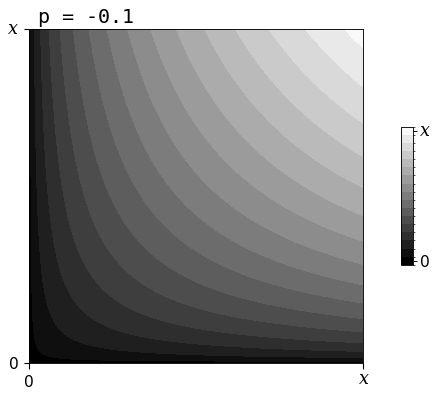

 76%|███████████████████████████████████████████████████████████████████████▏                     | 472/617 [01:03<00:20,  7.24it/s]

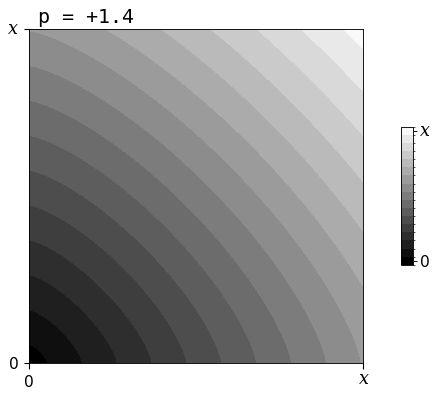

 77%|███████████████████████████████████████████████████████████████████████▎                     | 473/617 [01:04<00:19,  7.34it/s]

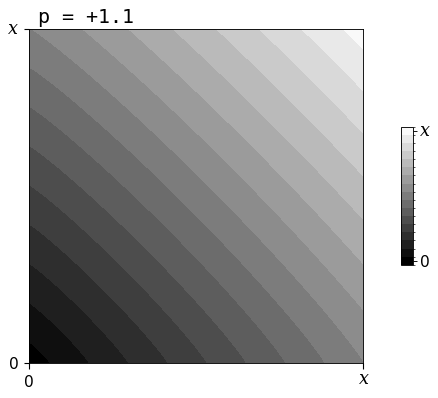

 77%|███████████████████████████████████████████████████████████████████████▍                     | 474/617 [01:04<00:19,  7.43it/s]

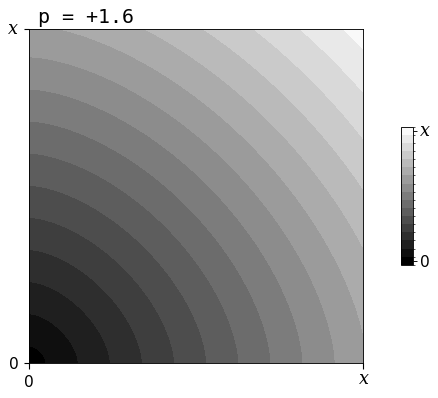

 77%|███████████████████████████████████████████████████████████████████████▌                     | 475/617 [01:04<00:19,  7.45it/s]

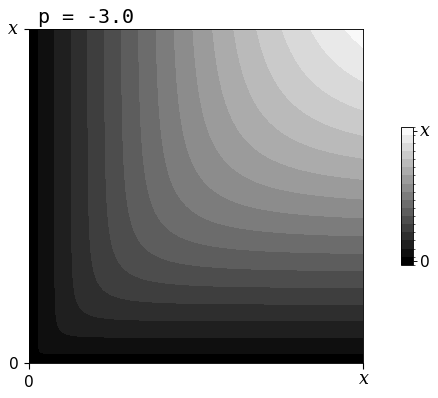

 77%|███████████████████████████████████████████████████████████████████████▋                     | 476/617 [01:04<00:18,  7.45it/s]

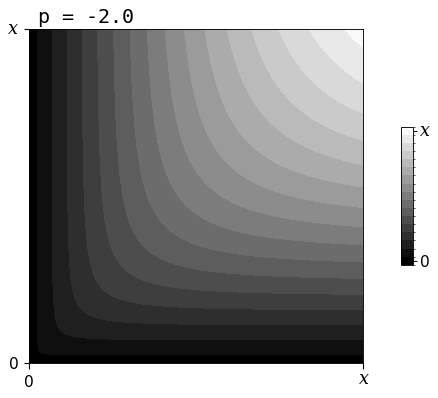

 77%|███████████████████████████████████████████████████████████████████████▉                     | 477/617 [01:04<00:18,  7.46it/s]

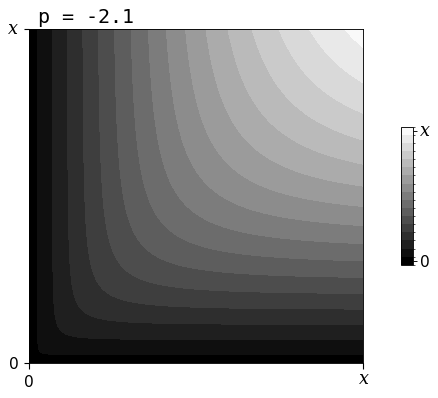

 77%|████████████████████████████████████████████████████████████████████████                     | 478/617 [01:04<00:18,  7.48it/s]

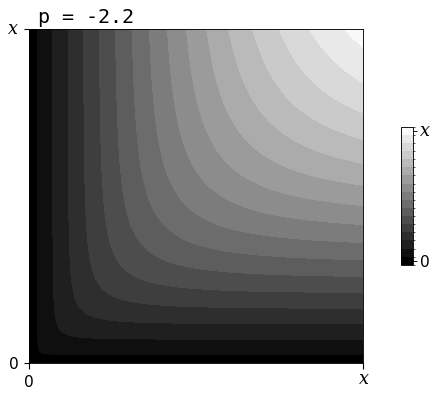

 78%|████████████████████████████████████████████████████████████████████████▏                    | 479/617 [01:04<00:18,  7.49it/s]

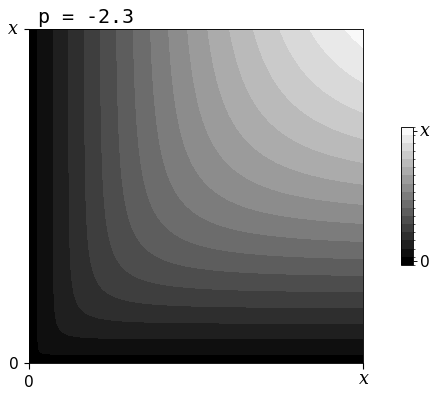

 78%|████████████████████████████████████████████████████████████████████████▎                    | 480/617 [01:05<00:18,  7.52it/s]

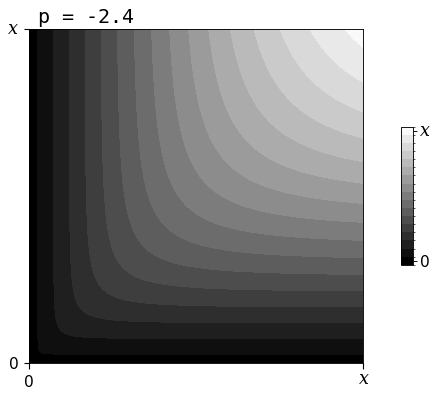

 78%|████████████████████████████████████████████████████████████████████████▌                    | 481/617 [01:05<00:19,  6.90it/s]

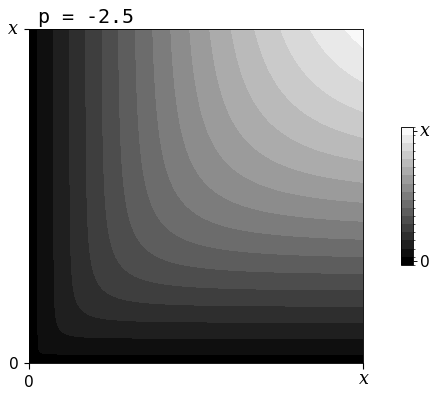

 78%|████████████████████████████████████████████████████████████████████████▋                    | 482/617 [01:05<00:19,  7.07it/s]

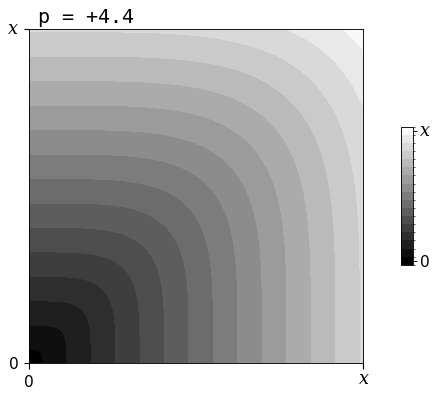

 78%|████████████████████████████████████████████████████████████████████████▊                    | 483/617 [01:05<00:18,  7.22it/s]

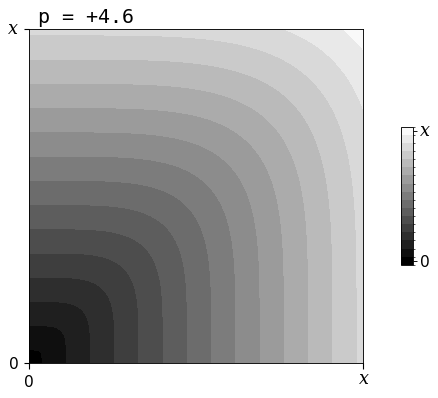

 78%|████████████████████████████████████████████████████████████████████████▉                    | 484/617 [01:05<00:18,  7.33it/s]

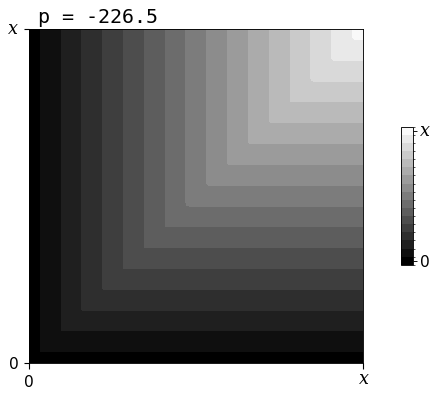

 79%|█████████████████████████████████████████████████████████████████████████                    | 485/617 [01:05<00:17,  7.42it/s]

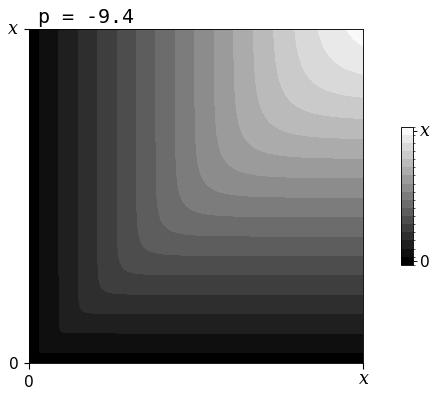

 79%|█████████████████████████████████████████████████████████████████████████▎                   | 486/617 [01:05<00:17,  7.47it/s]

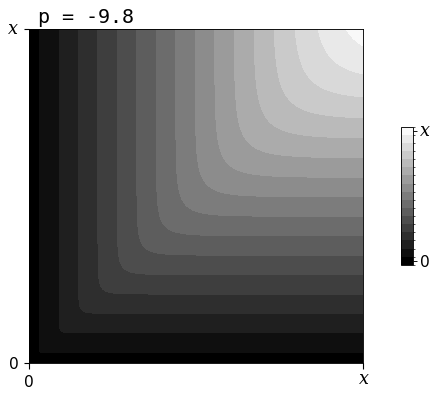

 79%|█████████████████████████████████████████████████████████████████████████▍                   | 487/617 [01:05<00:17,  7.50it/s]

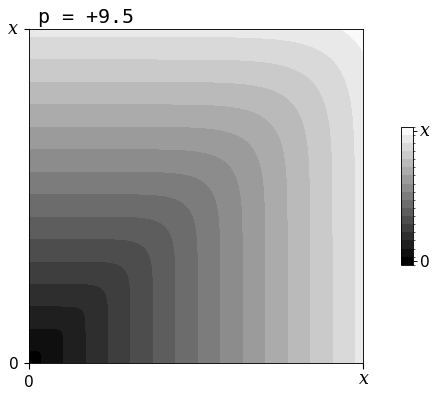

 79%|█████████████████████████████████████████████████████████████████████████▌                   | 488/617 [01:06<00:17,  7.55it/s]

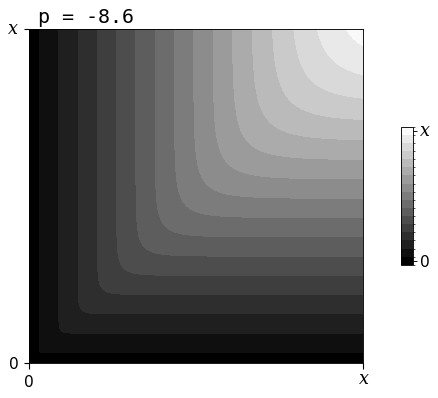

 79%|█████████████████████████████████████████████████████████████████████████▋                   | 489/617 [01:06<00:16,  7.56it/s]

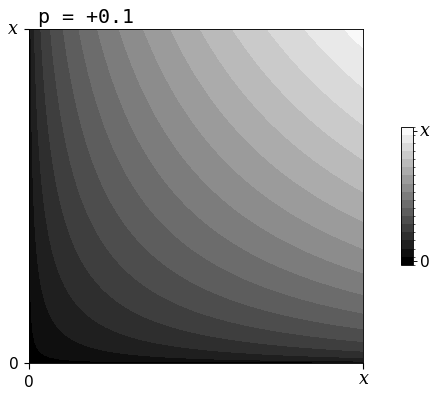

 79%|█████████████████████████████████████████████████████████████████████████▊                   | 490/617 [01:06<00:16,  7.54it/s]

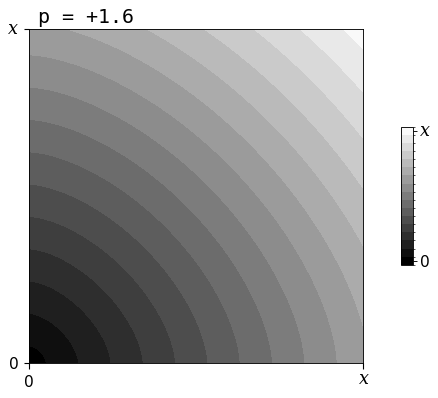

 80%|██████████████████████████████████████████████████████████████████████████                   | 491/617 [01:06<00:16,  7.57it/s]

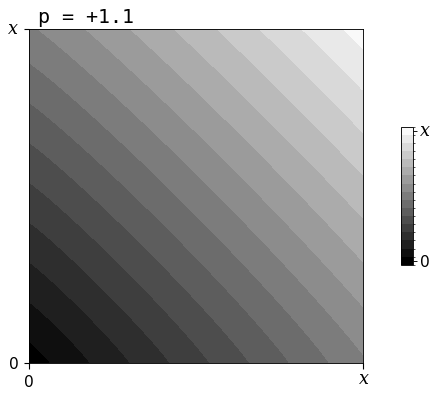

 80%|██████████████████████████████████████████████████████████████████████████▏                  | 492/617 [01:06<00:16,  7.56it/s]

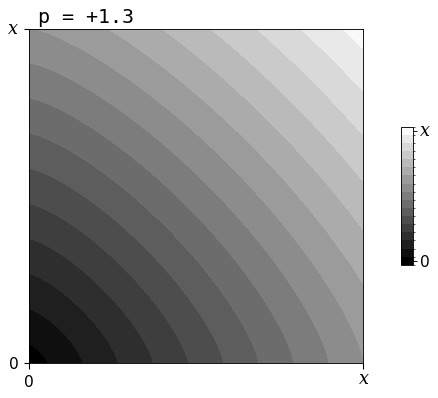

 80%|██████████████████████████████████████████████████████████████████████████▎                  | 493/617 [01:06<00:16,  7.55it/s]

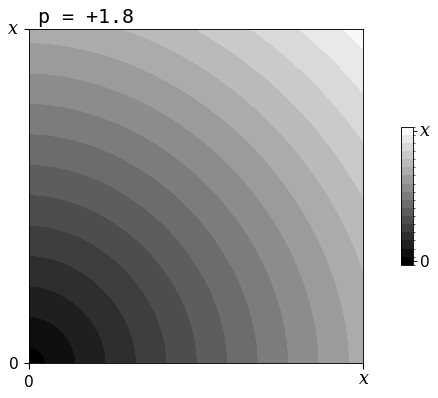

 80%|██████████████████████████████████████████████████████████████████████████▍                  | 494/617 [01:06<00:17,  6.95it/s]

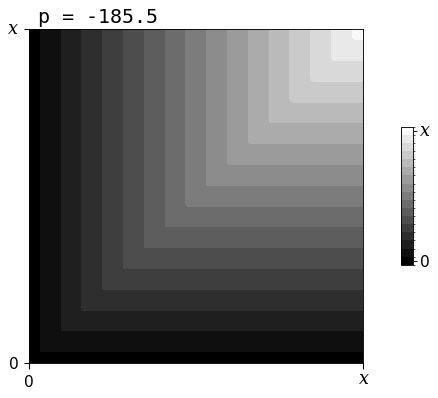

 80%|██████████████████████████████████████████████████████████████████████████▌                  | 495/617 [01:07<00:17,  7.12it/s]

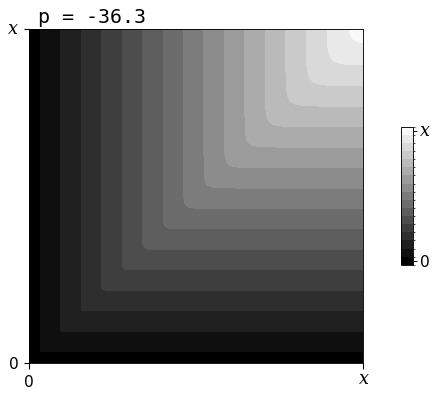

 80%|██████████████████████████████████████████████████████████████████████████▊                  | 496/617 [01:07<00:16,  7.27it/s]

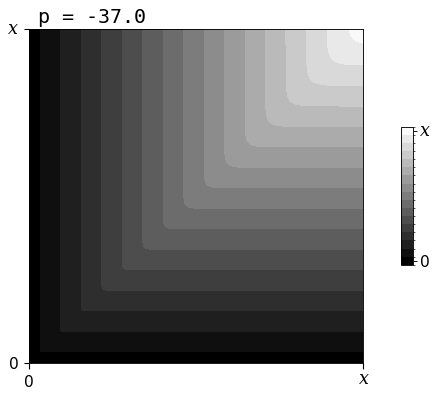

 81%|██████████████████████████████████████████████████████████████████████████▉                  | 497/617 [01:07<00:16,  7.39it/s]

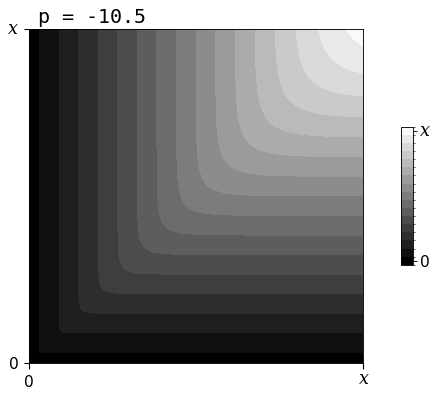

 81%|███████████████████████████████████████████████████████████████████████████                  | 498/617 [01:07<00:16,  7.43it/s]

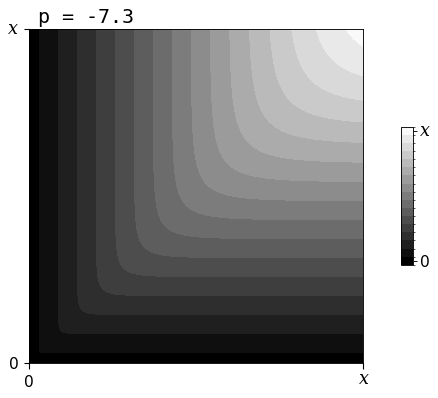

 81%|███████████████████████████████████████████████████████████████████████████▏                 | 499/617 [01:07<00:15,  7.48it/s]

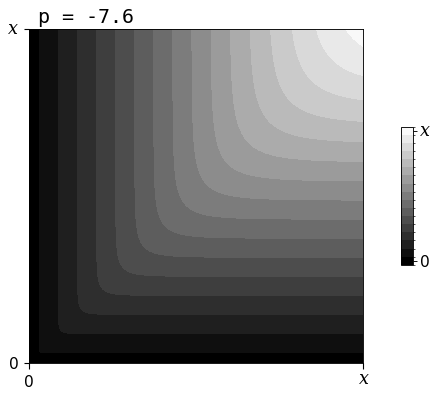

 81%|███████████████████████████████████████████████████████████████████████████▎                 | 500/617 [01:07<00:15,  7.50it/s]

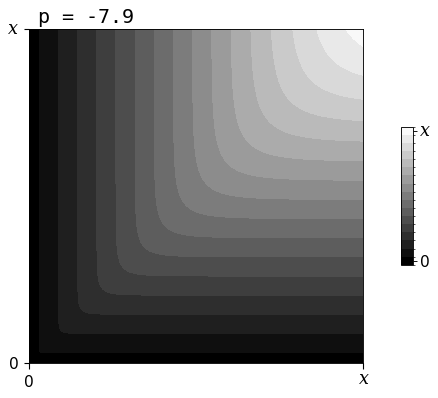

 81%|███████████████████████████████████████████████████████████████████████████▌                 | 501/617 [01:07<00:15,  7.50it/s]

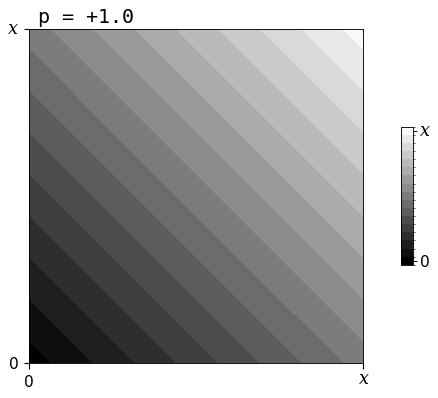

 81%|███████████████████████████████████████████████████████████████████████████▋                 | 502/617 [01:08<00:15,  7.51it/s]

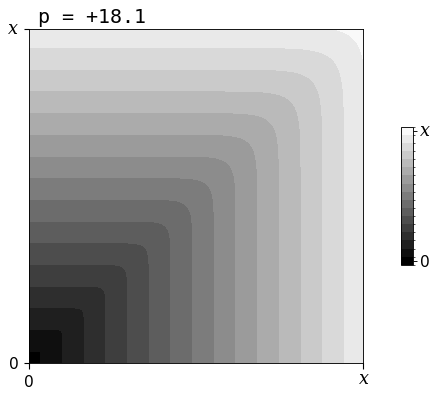

 82%|███████████████████████████████████████████████████████████████████████████▊                 | 503/617 [01:08<00:15,  7.56it/s]

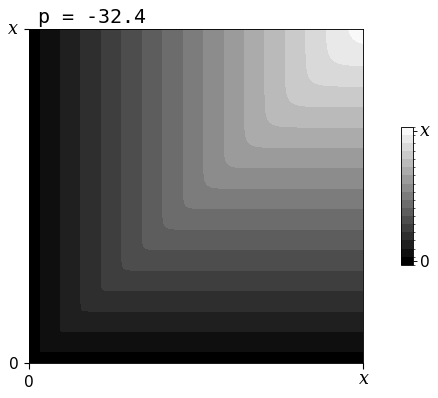

 82%|███████████████████████████████████████████████████████████████████████████▉                 | 504/617 [01:08<00:14,  7.58it/s]

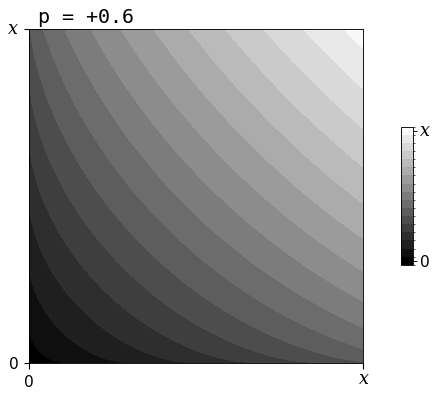

 82%|████████████████████████████████████████████████████████████████████████████                 | 505/617 [01:08<00:14,  7.56it/s]

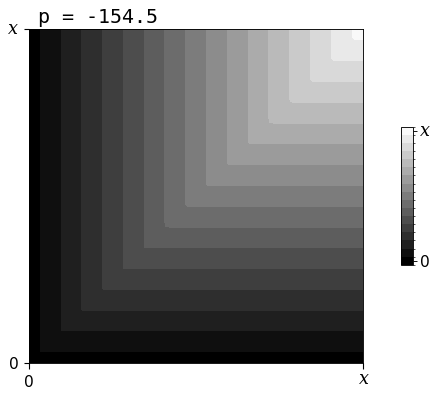

 82%|████████████████████████████████████████████████████████████████████████████▎                | 506/617 [01:08<00:14,  7.57it/s]

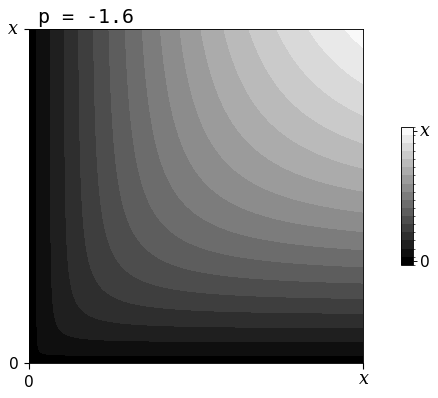

 82%|████████████████████████████████████████████████████████████████████████████▍                | 507/617 [01:08<00:15,  6.89it/s]

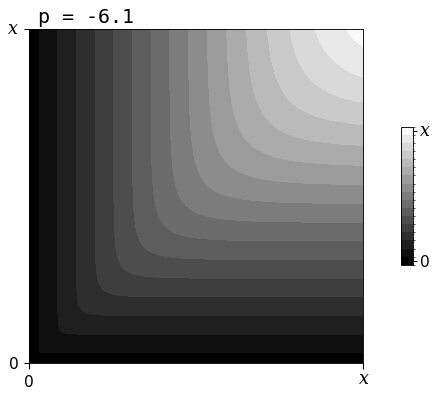

 82%|████████████████████████████████████████████████████████████████████████████▌                | 508/617 [01:08<00:15,  7.09it/s]

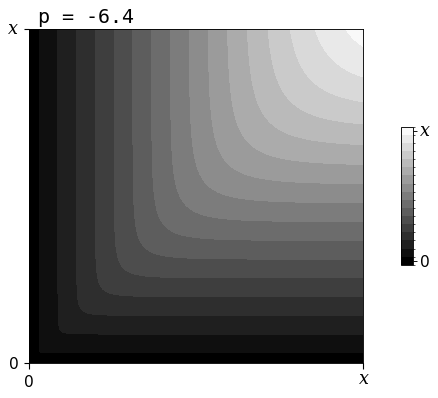

 82%|████████████████████████████████████████████████████████████████████████████▋                | 509/617 [01:08<00:14,  7.22it/s]

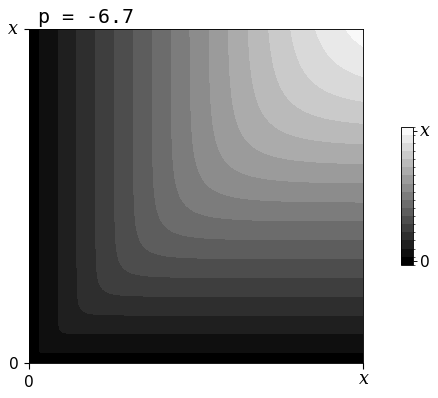

 83%|████████████████████████████████████████████████████████████████████████████▊                | 510/617 [01:09<00:14,  7.32it/s]

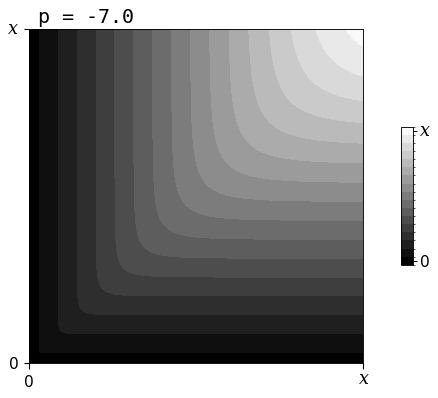

 83%|█████████████████████████████████████████████████████████████████████████████                | 511/617 [01:09<00:14,  7.38it/s]

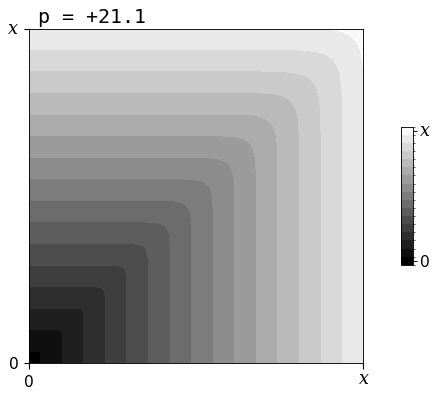

 83%|█████████████████████████████████████████████████████████████████████████████▏               | 512/617 [01:09<00:14,  7.45it/s]

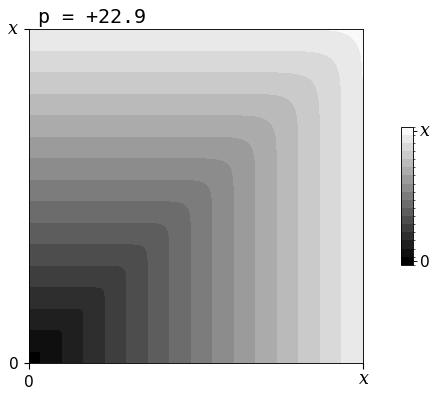

 83%|█████████████████████████████████████████████████████████████████████████████▎               | 513/617 [01:09<00:13,  7.50it/s]

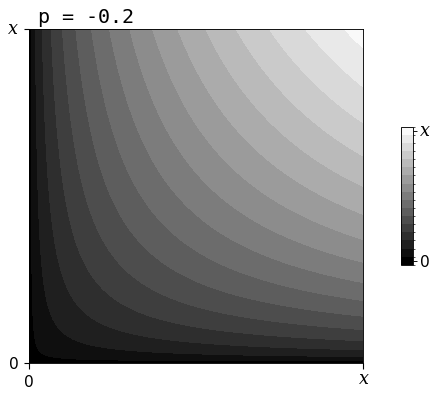

 83%|█████████████████████████████████████████████████████████████████████████████▍               | 514/617 [01:09<00:13,  7.52it/s]

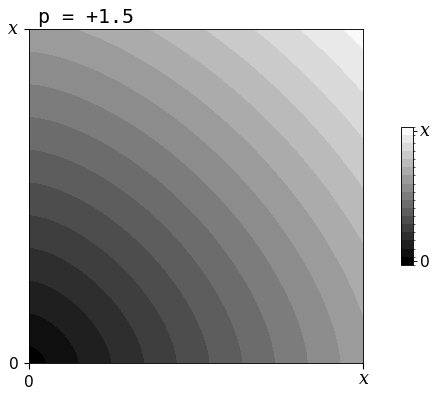

 83%|█████████████████████████████████████████████████████████████████████████████▋               | 515/617 [01:09<00:13,  7.54it/s]

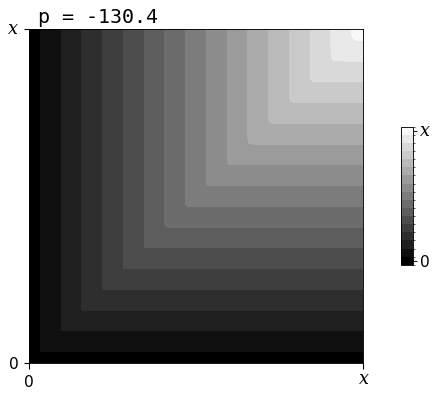

 84%|█████████████████████████████████████████████████████████████████████████████▊               | 516/617 [01:09<00:13,  7.56it/s]

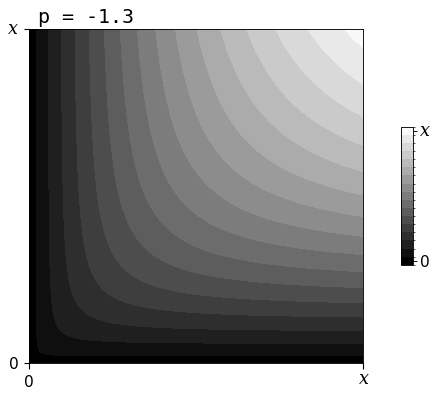

 84%|█████████████████████████████████████████████████████████████████████████████▉               | 517/617 [01:10<00:13,  7.54it/s]

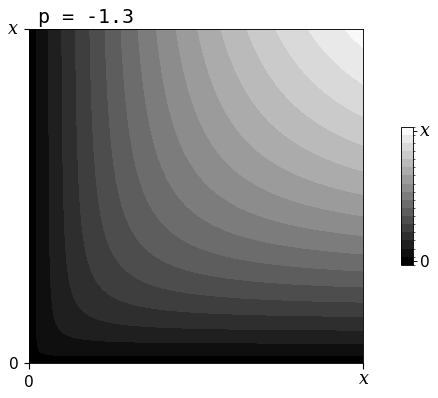

 84%|██████████████████████████████████████████████████████████████████████████████               | 518/617 [01:10<00:13,  7.52it/s]

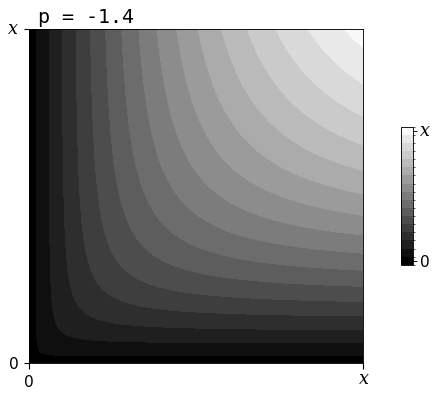

 84%|██████████████████████████████████████████████████████████████████████████████▏              | 519/617 [01:10<00:13,  7.52it/s]

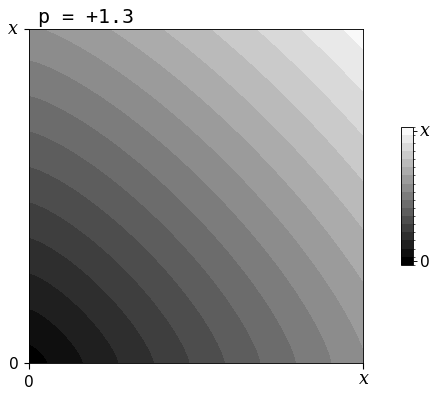

 84%|██████████████████████████████████████████████████████████████████████████████▍              | 520/617 [01:10<00:12,  7.55it/s]

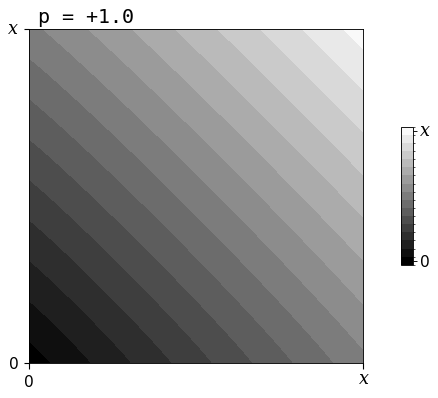

 84%|██████████████████████████████████████████████████████████████████████████████▌              | 521/617 [01:10<00:13,  6.93it/s]

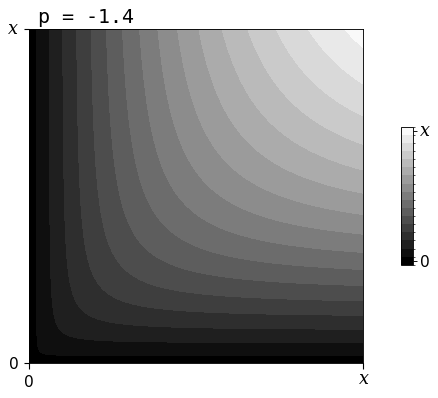

 85%|██████████████████████████████████████████████████████████████████████████████▋              | 522/617 [01:10<00:13,  7.09it/s]

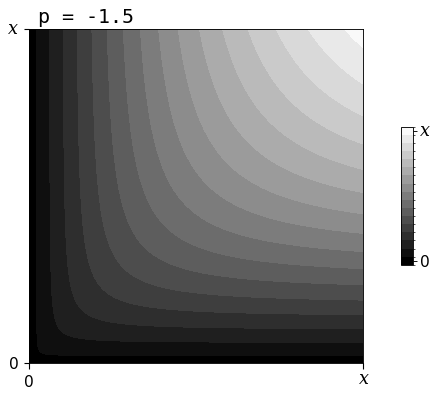

 85%|██████████████████████████████████████████████████████████████████████████████▊              | 523/617 [01:10<00:13,  7.19it/s]

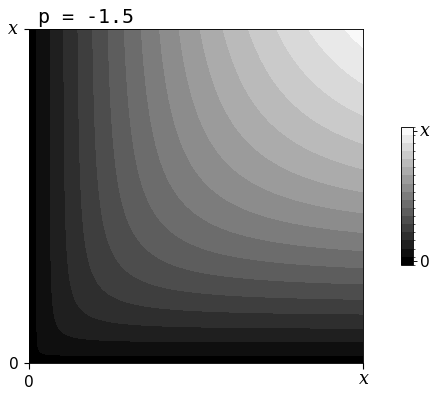

 85%|██████████████████████████████████████████████████████████████████████████████▉              | 524/617 [01:10<00:12,  7.26it/s]

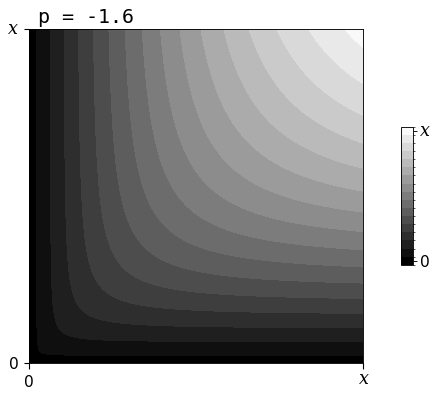

 85%|███████████████████████████████████████████████████████████████████████████████▏             | 525/617 [01:11<00:12,  7.33it/s]

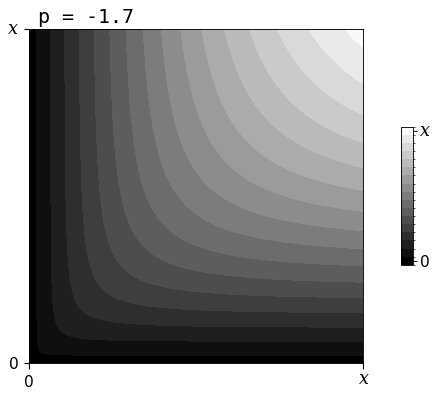

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 526/617 [01:11<00:12,  7.41it/s]

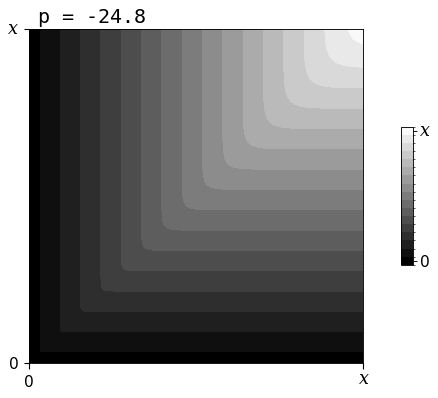

 85%|███████████████████████████████████████████████████████████████████████████████▍             | 527/617 [01:11<00:12,  7.45it/s]

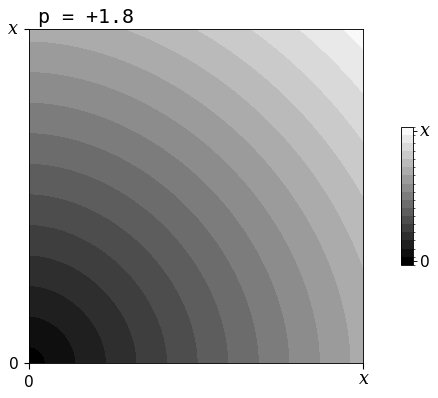

 86%|███████████████████████████████████████████████████████████████████████████████▌             | 528/617 [01:11<00:11,  7.47it/s]

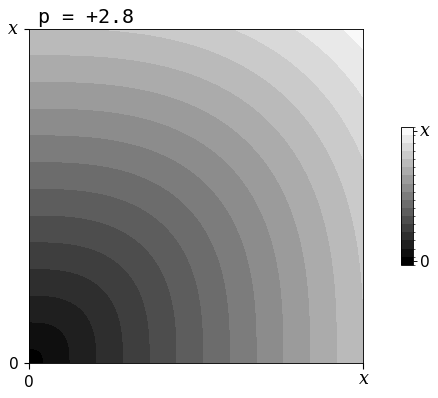

 86%|███████████████████████████████████████████████████████████████████████████████▋             | 529/617 [01:11<00:11,  7.50it/s]

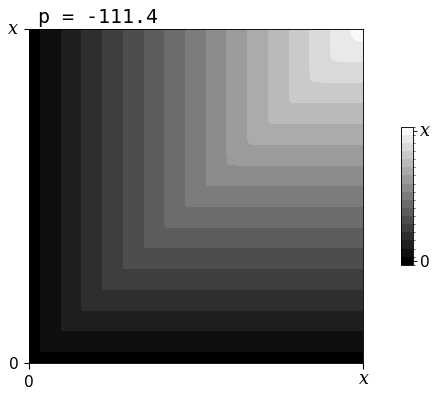

 86%|███████████████████████████████████████████████████████████████████████████████▉             | 530/617 [01:11<00:11,  7.54it/s]

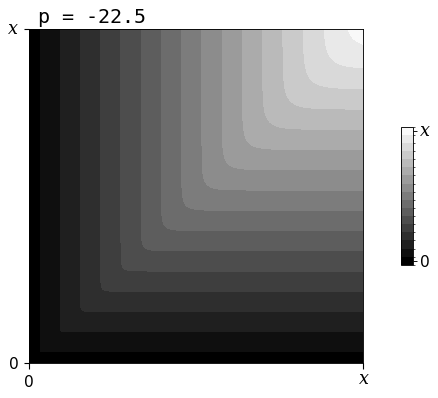

 86%|████████████████████████████████████████████████████████████████████████████████             | 531/617 [01:11<00:11,  7.54it/s]

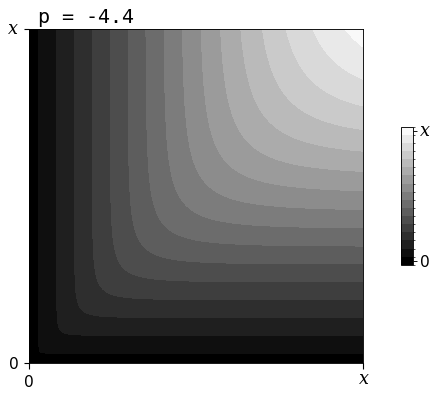

 86%|████████████████████████████████████████████████████████████████████████████████▏            | 532/617 [01:12<00:11,  7.56it/s]

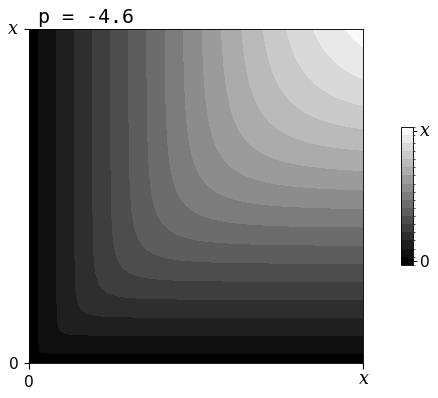

 86%|████████████████████████████████████████████████████████████████████████████████▎            | 533/617 [01:12<00:11,  7.55it/s]

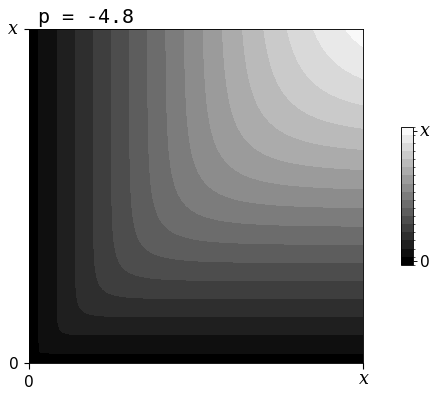

 87%|████████████████████████████████████████████████████████████████████████████████▍            | 534/617 [01:12<00:11,  6.93it/s]

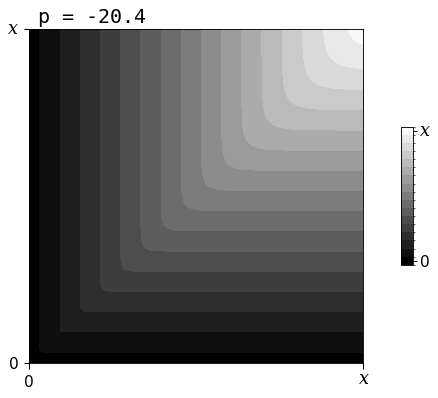

 87%|████████████████████████████████████████████████████████████████████████████████▋            | 535/617 [01:12<00:11,  7.10it/s]

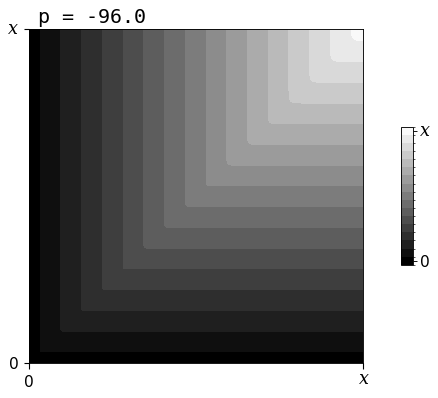

 87%|████████████████████████████████████████████████████████████████████████████████▊            | 536/617 [01:12<00:11,  7.23it/s]

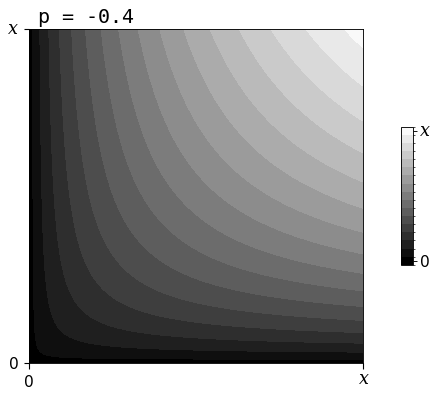

 87%|████████████████████████████████████████████████████████████████████████████████▉            | 537/617 [01:12<00:10,  7.33it/s]

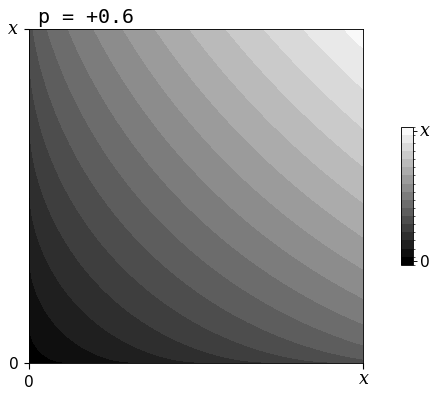

 87%|█████████████████████████████████████████████████████████████████████████████████            | 538/617 [01:12<00:10,  7.39it/s]

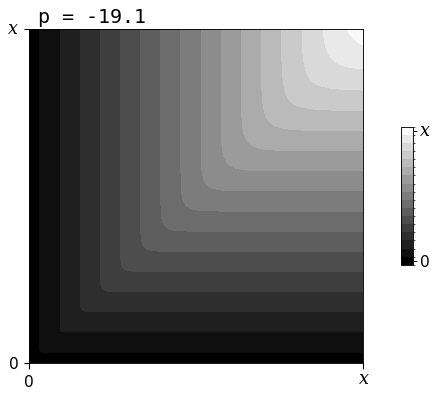

 87%|█████████████████████████████████████████████████████████████████████████████████▏           | 539/617 [01:13<00:10,  7.44it/s]

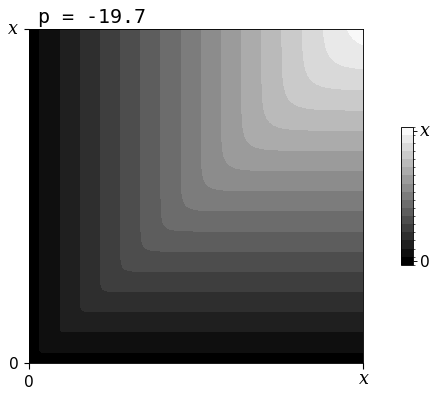

 88%|█████████████████████████████████████████████████████████████████████████████████▍           | 540/617 [01:13<00:10,  7.49it/s]

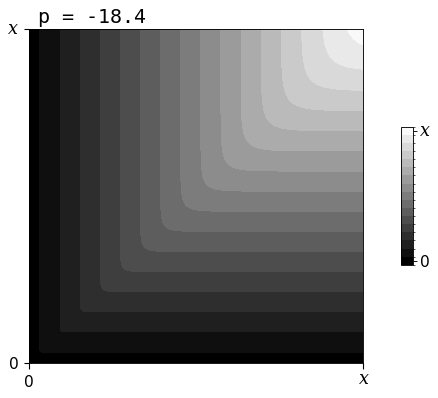

 88%|█████████████████████████████████████████████████████████████████████████████████▌           | 541/617 [01:13<00:10,  7.51it/s]

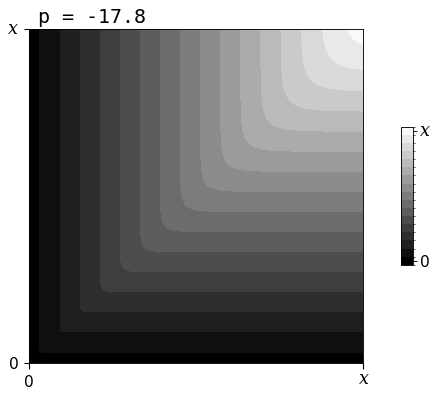

 88%|█████████████████████████████████████████████████████████████████████████████████▋           | 542/617 [01:13<00:09,  7.54it/s]

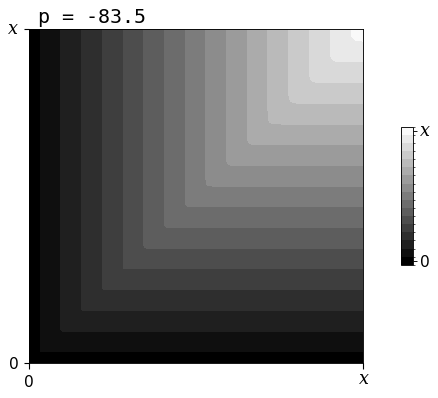

 88%|█████████████████████████████████████████████████████████████████████████████████▊           | 543/617 [01:13<00:09,  7.58it/s]

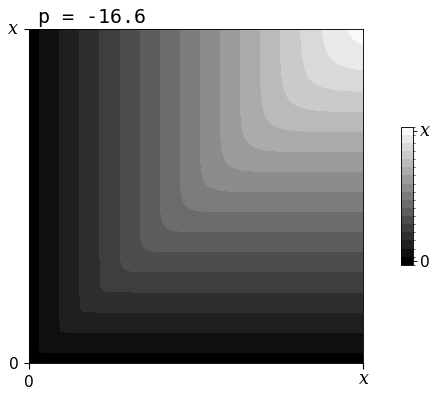

 88%|█████████████████████████████████████████████████████████████████████████████████▉           | 544/617 [01:13<00:09,  7.59it/s]

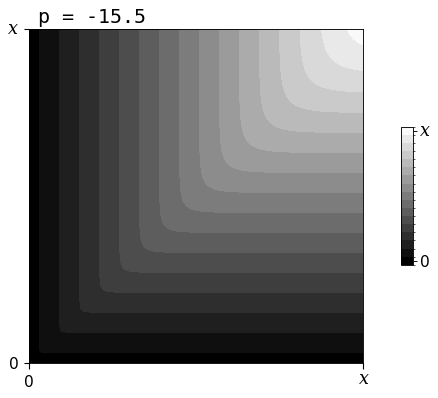

 88%|██████████████████████████████████████████████████████████████████████████████████▏          | 545/617 [01:13<00:09,  7.59it/s]

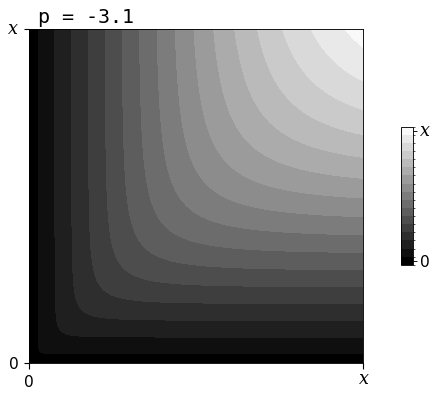

 88%|██████████████████████████████████████████████████████████████████████████████████▎          | 546/617 [01:13<00:09,  7.58it/s]

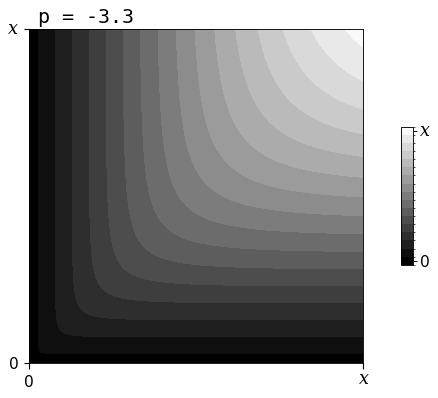

 89%|██████████████████████████████████████████████████████████████████████████████████▍          | 547/617 [01:14<00:10,  6.93it/s]

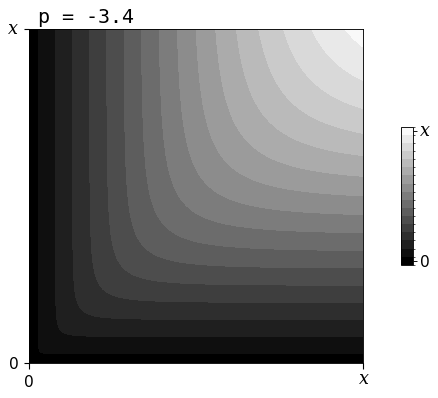

 89%|██████████████████████████████████████████████████████████████████████████████████▌          | 548/617 [01:14<00:09,  7.09it/s]

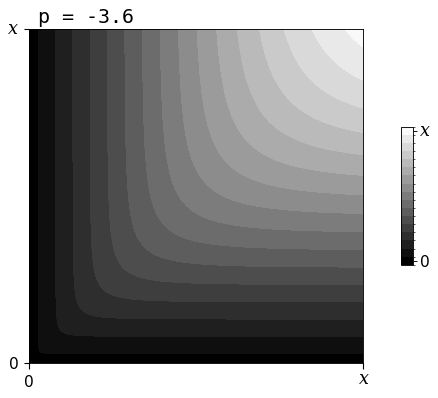

 89%|██████████████████████████████████████████████████████████████████████████████████▊          | 549/617 [01:14<00:09,  7.24it/s]

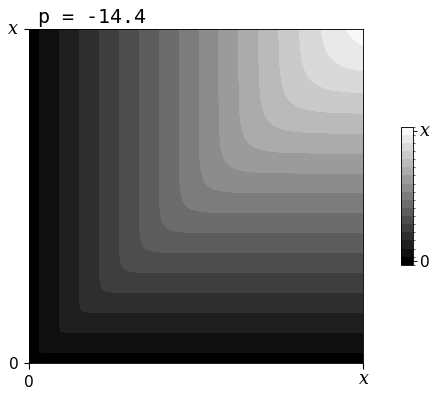

 89%|██████████████████████████████████████████████████████████████████████████████████▉          | 550/617 [01:14<00:09,  7.33it/s]

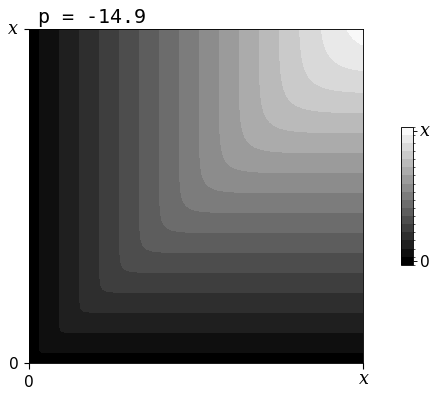

 89%|███████████████████████████████████████████████████████████████████████████████████          | 551/617 [01:14<00:08,  7.41it/s]

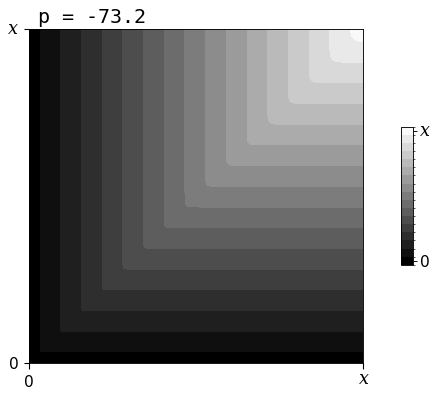

 89%|███████████████████████████████████████████████████████████████████████████████████▏         | 552/617 [01:14<00:08,  7.47it/s]

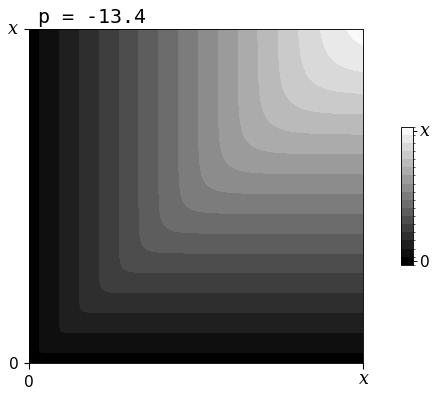

 90%|███████████████████████████████████████████████████████████████████████████████████▎         | 553/617 [01:14<00:08,  7.50it/s]

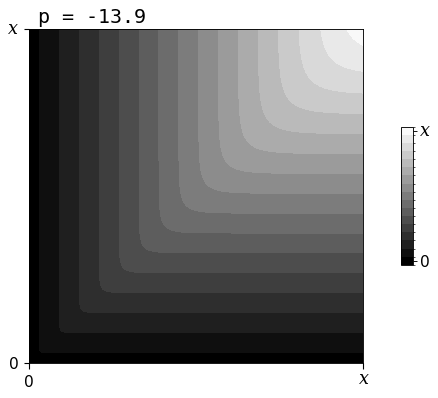

 90%|███████████████████████████████████████████████████████████████████████████████████▌         | 554/617 [01:15<00:08,  7.51it/s]

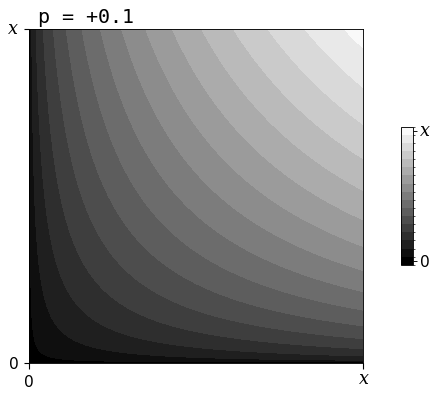

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 555/617 [01:15<00:08,  7.53it/s]

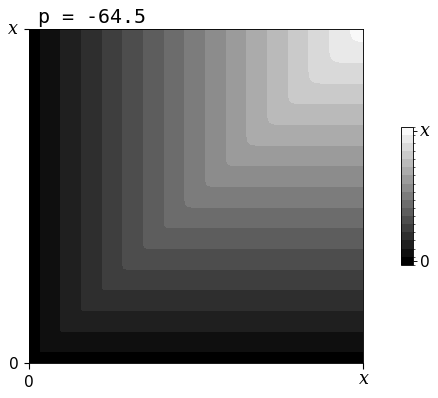

 90%|███████████████████████████████████████████████████████████████████████████████████▊         | 556/617 [01:15<00:08,  7.55it/s]

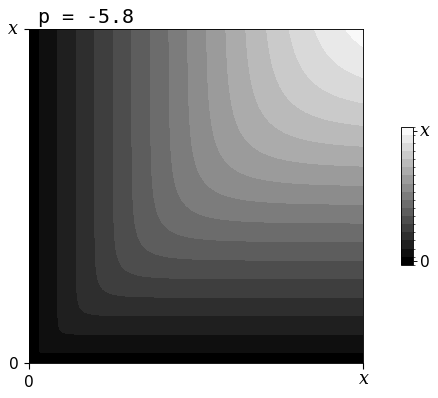

 90%|███████████████████████████████████████████████████████████████████████████████████▉         | 557/617 [01:15<00:07,  7.54it/s]

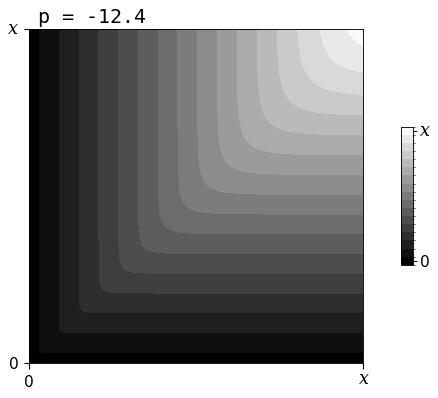

 90%|████████████████████████████████████████████████████████████████████████████████████         | 558/617 [01:15<00:07,  7.54it/s]

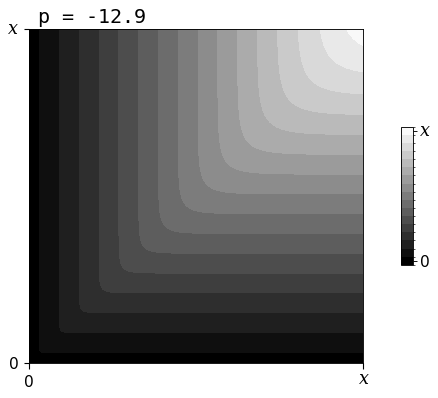

 91%|████████████████████████████████████████████████████████████████████████████████████▎        | 559/617 [01:15<00:07,  7.55it/s]

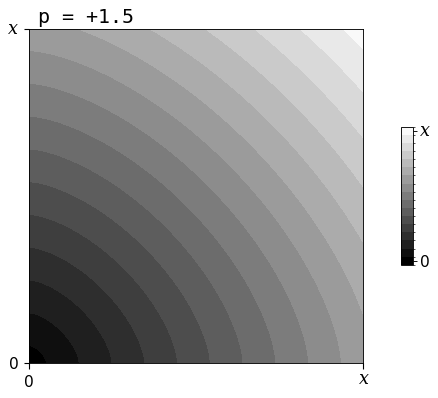

 91%|████████████████████████████████████████████████████████████████████████████████████▍        | 560/617 [01:15<00:07,  7.54it/s]

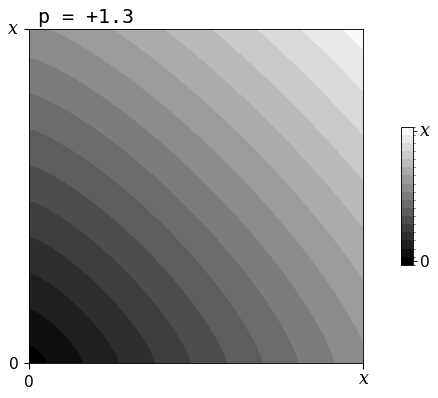

 91%|████████████████████████████████████████████████████████████████████████████████████▌        | 561/617 [01:16<00:08,  6.93it/s]

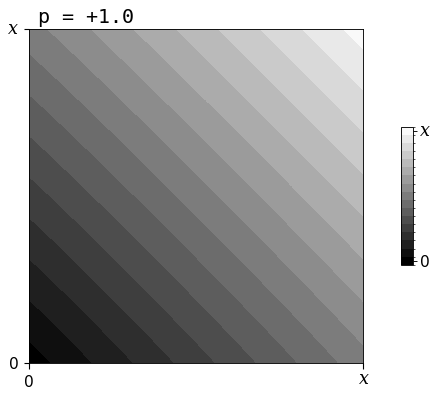

 91%|████████████████████████████████████████████████████████████████████████████████████▋        | 562/617 [01:16<00:07,  7.10it/s]

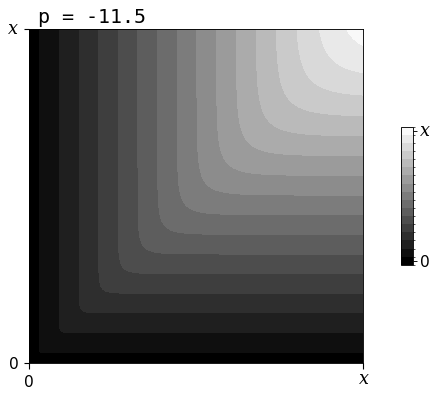

 91%|████████████████████████████████████████████████████████████████████████████████████▊        | 563/617 [01:16<00:07,  7.24it/s]

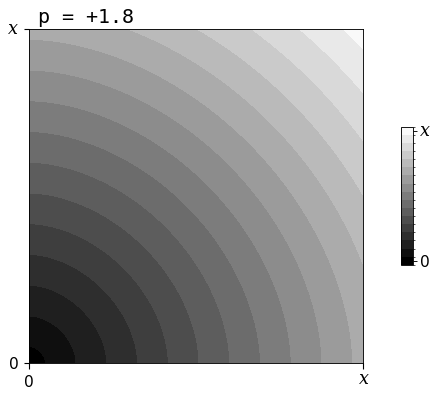

 91%|█████████████████████████████████████████████████████████████████████████████████████        | 564/617 [01:16<00:07,  7.32it/s]

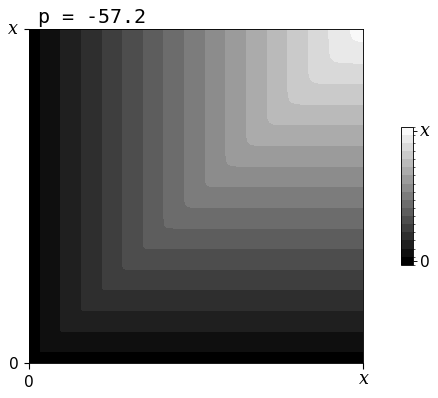

 92%|█████████████████████████████████████████████████████████████████████████████████████▏       | 565/617 [01:16<00:07,  7.40it/s]

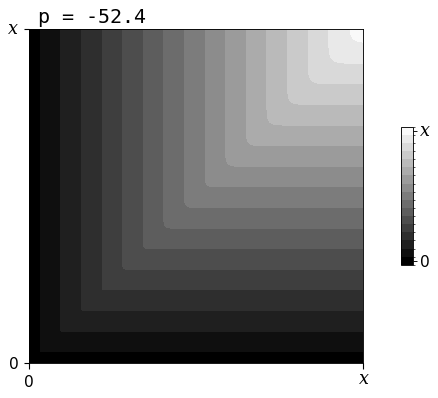

 92%|█████████████████████████████████████████████████████████████████████████████████████▎       | 566/617 [01:16<00:06,  7.46it/s]

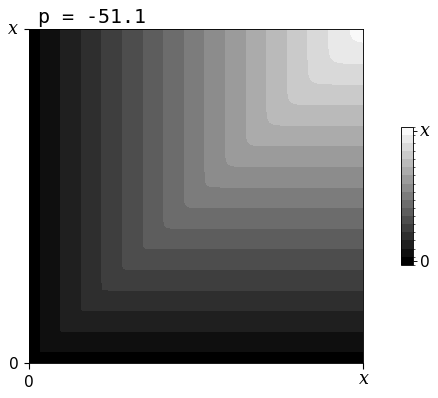

 92%|█████████████████████████████████████████████████████████████████████████████████████▍       | 567/617 [01:16<00:06,  7.53it/s]

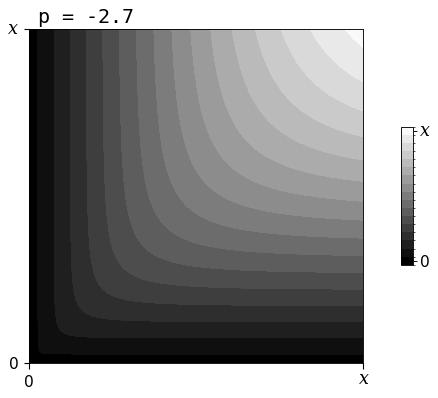

 92%|█████████████████████████████████████████████████████████████████████████████████████▌       | 568/617 [01:16<00:06,  7.51it/s]

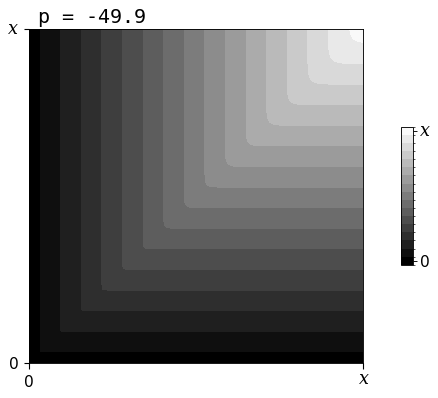

 92%|█████████████████████████████████████████████████████████████████████████████████████▊       | 569/617 [01:17<00:06,  7.54it/s]

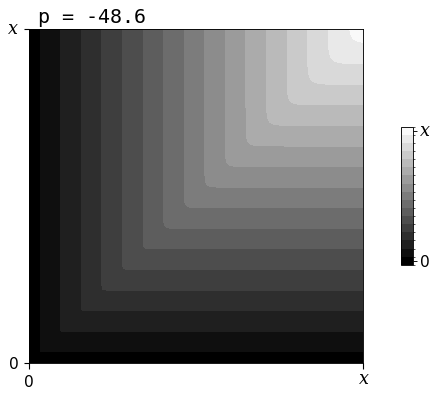

 92%|█████████████████████████████████████████████████████████████████████████████████████▉       | 570/617 [01:17<00:06,  7.54it/s]

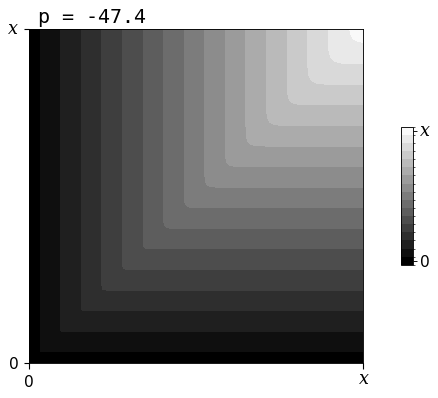

 93%|██████████████████████████████████████████████████████████████████████████████████████       | 571/617 [01:17<00:06,  7.54it/s]

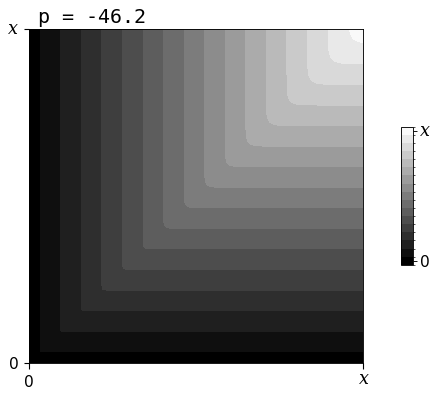

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 572/617 [01:17<00:05,  7.55it/s]

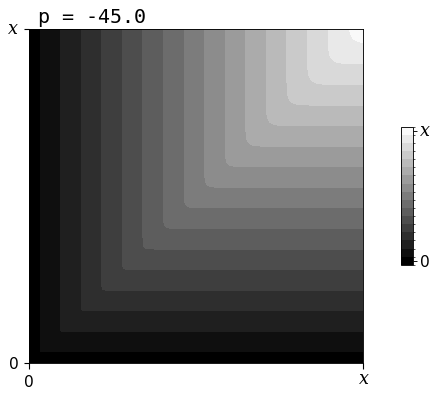

 93%|██████████████████████████████████████████████████████████████████████████████████████▎      | 573/617 [01:17<00:05,  7.59it/s]

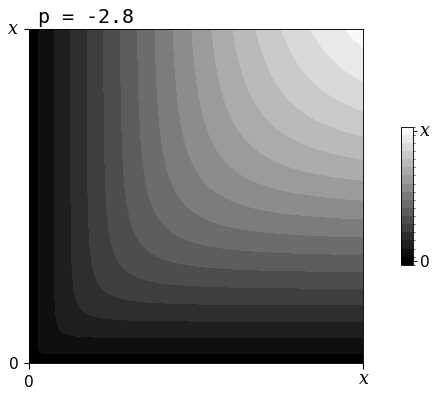

 93%|██████████████████████████████████████████████████████████████████████████████████████▌      | 574/617 [01:17<00:06,  6.94it/s]

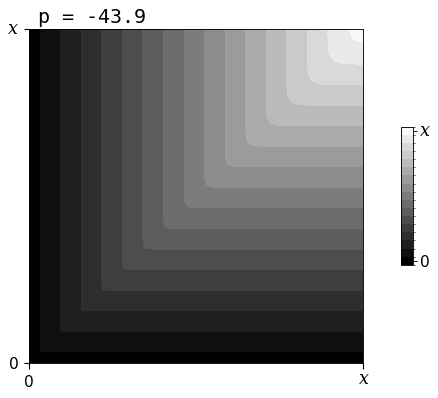

 93%|██████████████████████████████████████████████████████████████████████████████████████▋      | 575/617 [01:17<00:05,  7.13it/s]

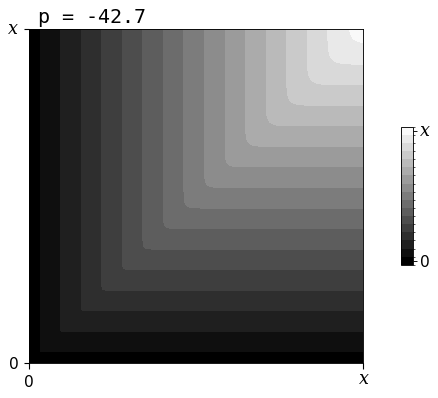

 93%|██████████████████████████████████████████████████████████████████████████████████████▊      | 576/617 [01:18<00:05,  7.28it/s]

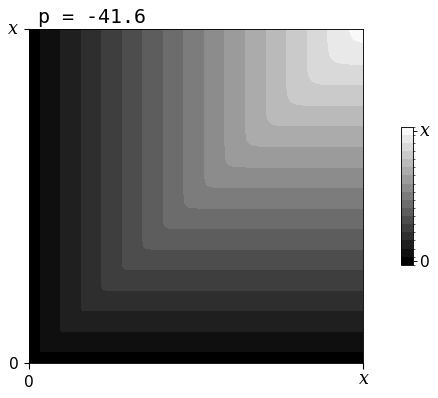

 94%|██████████████████████████████████████████████████████████████████████████████████████▉      | 577/617 [01:18<00:05,  7.37it/s]

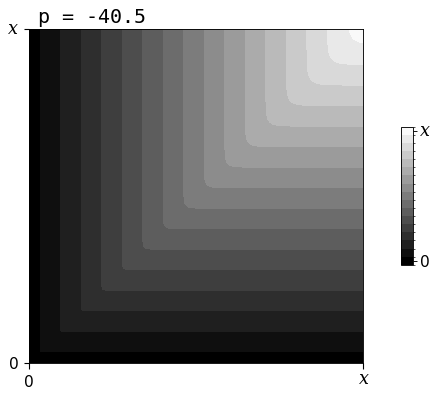

 94%|███████████████████████████████████████████████████████████████████████████████████████      | 578/617 [01:18<00:05,  7.47it/s]

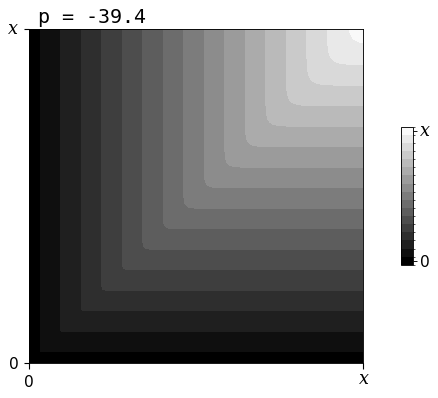

 94%|███████████████████████████████████████████████████████████████████████████████████████▎     | 579/617 [01:18<00:05,  7.51it/s]

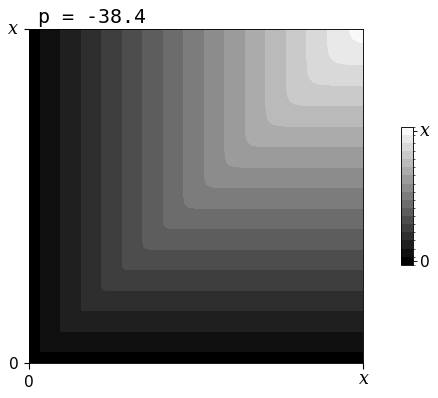

 94%|███████████████████████████████████████████████████████████████████████████████████████▍     | 580/617 [01:18<00:04,  7.54it/s]

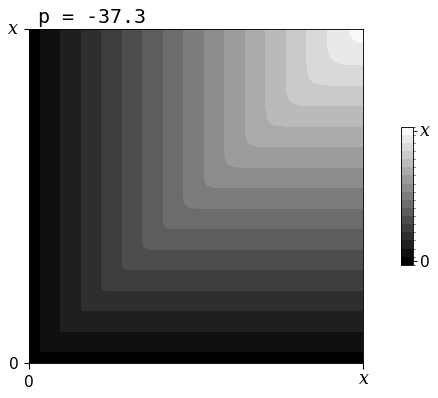

 94%|███████████████████████████████████████████████████████████████████████████████████████▌     | 581/617 [01:18<00:04,  7.55it/s]

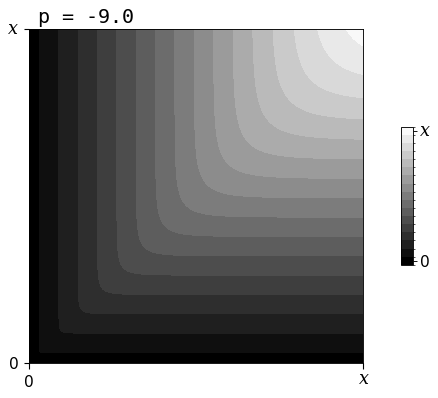

 94%|███████████████████████████████████████████████████████████████████████████████████████▋     | 582/617 [01:18<00:04,  7.55it/s]

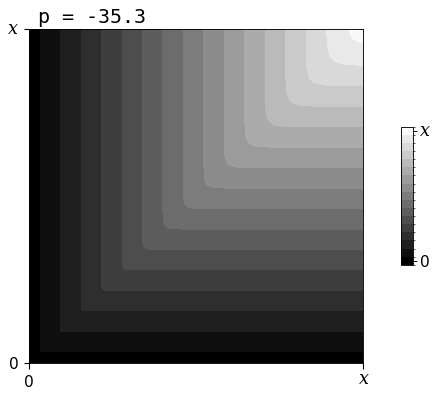

 94%|███████████████████████████████████████████████████████████████████████████████████████▉     | 583/617 [01:18<00:04,  7.54it/s]

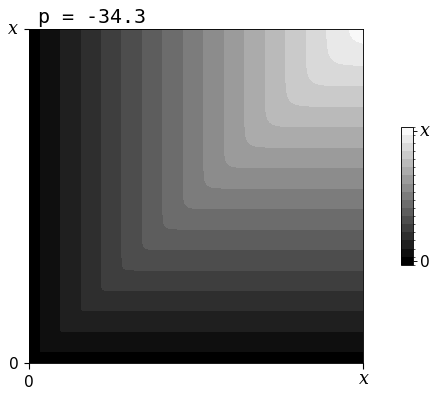

 95%|████████████████████████████████████████████████████████████████████████████████████████     | 584/617 [01:19<00:04,  7.57it/s]

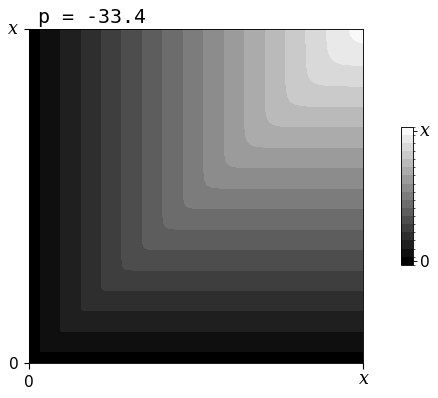

 95%|████████████████████████████████████████████████████████████████████████████████████████▏    | 585/617 [01:19<00:04,  7.56it/s]

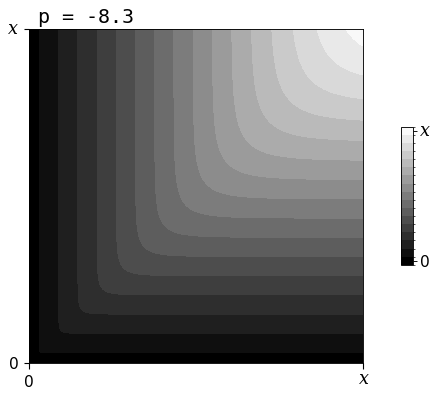

 95%|████████████████████████████████████████████████████████████████████████████████████████▎    | 586/617 [01:19<00:04,  7.51it/s]

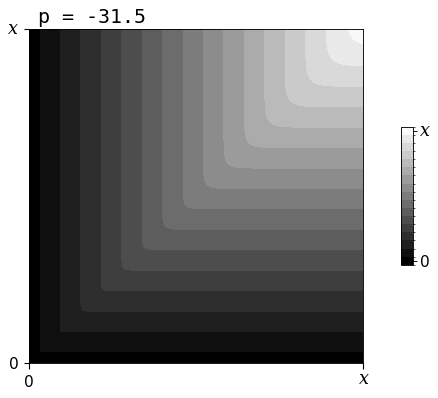

 95%|████████████████████████████████████████████████████████████████████████████████████████▍    | 587/617 [01:19<00:04,  6.92it/s]

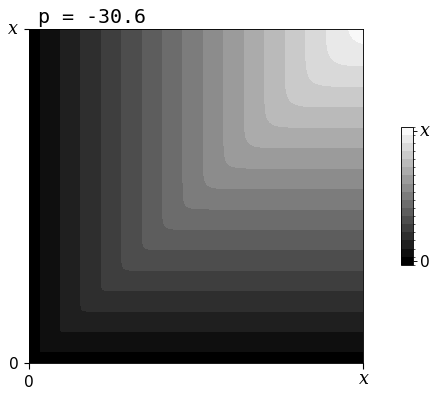

 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 588/617 [01:19<00:04,  7.12it/s]

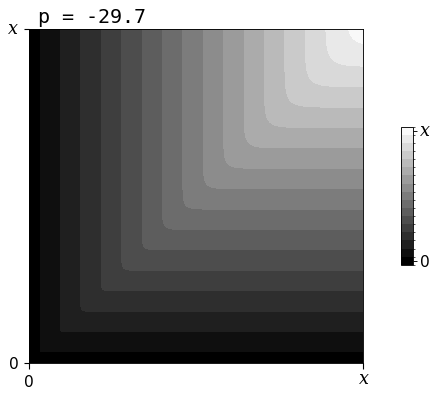

 95%|████████████████████████████████████████████████████████████████████████████████████████▊    | 589/617 [01:19<00:03,  7.25it/s]

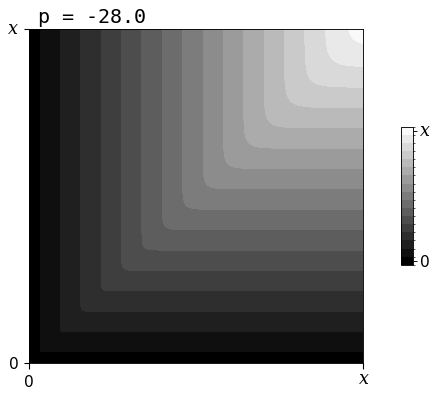

 96%|████████████████████████████████████████████████████████████████████████████████████████▉    | 590/617 [01:19<00:03,  7.36it/s]

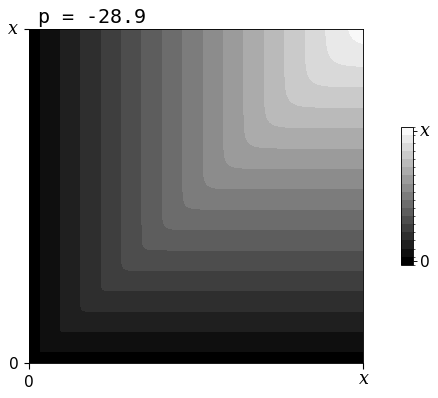

 96%|█████████████████████████████████████████████████████████████████████████████████████████    | 591/617 [01:20<00:03,  7.43it/s]

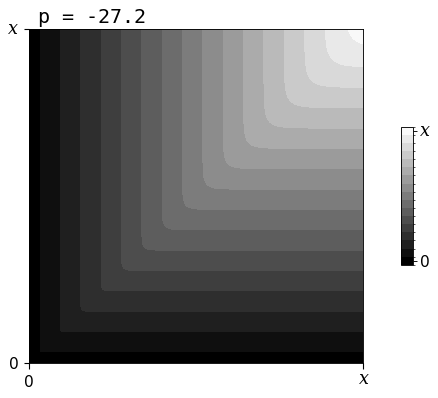

 96%|█████████████████████████████████████████████████████████████████████████████████████████▏   | 592/617 [01:20<00:03,  7.48it/s]

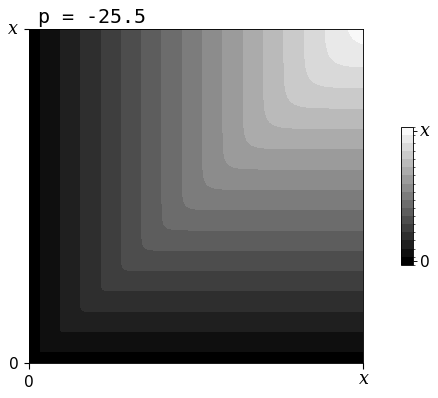

 96%|█████████████████████████████████████████████████████████████████████████████████████████▍   | 593/617 [01:20<00:03,  7.51it/s]

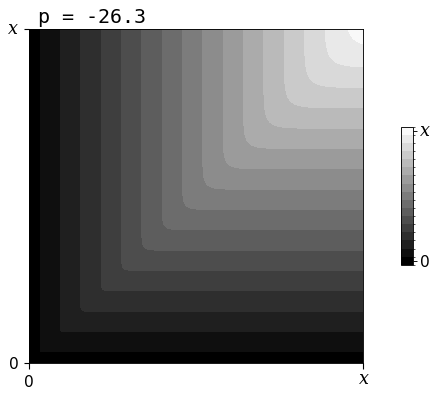

 96%|█████████████████████████████████████████████████████████████████████████████████████████▌   | 594/617 [01:20<00:03,  7.53it/s]

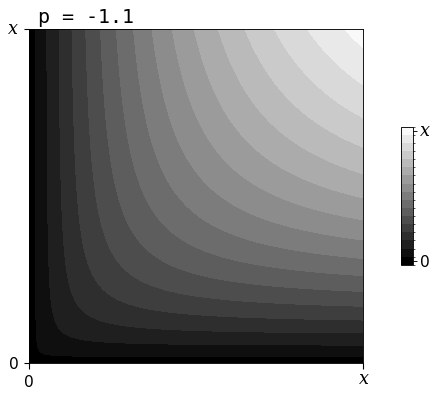

 96%|█████████████████████████████████████████████████████████████████████████████████████████▋   | 595/617 [01:20<00:02,  7.52it/s]

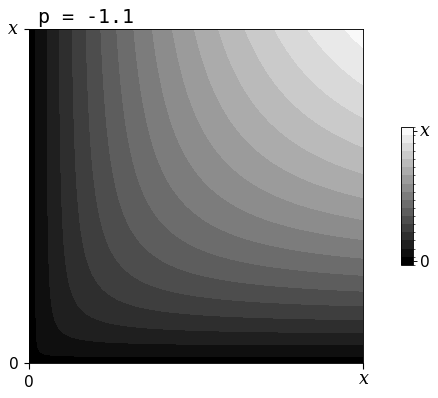

 97%|█████████████████████████████████████████████████████████████████████████████████████████▊   | 596/617 [01:20<00:02,  7.54it/s]

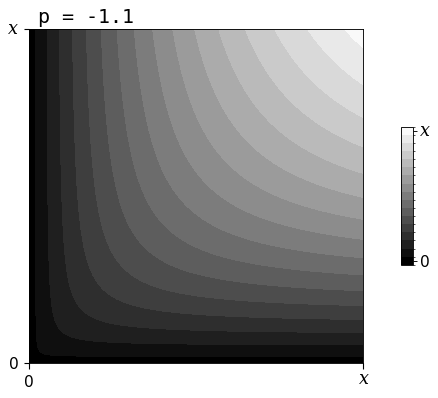

 97%|█████████████████████████████████████████████████████████████████████████████████████████▉   | 597/617 [01:20<00:02,  7.53it/s]

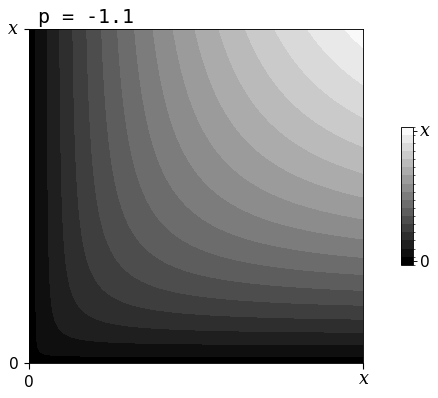

 97%|██████████████████████████████████████████████████████████████████████████████████████████▏  | 598/617 [01:20<00:02,  7.53it/s]

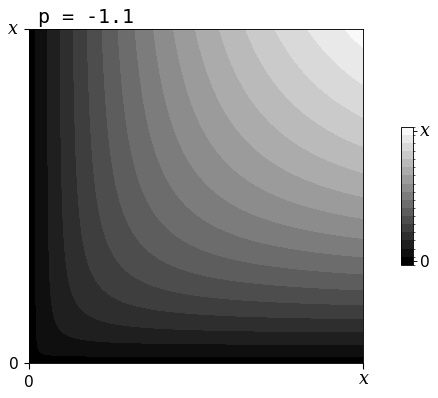

 97%|██████████████████████████████████████████████████████████████████████████████████████████▎  | 599/617 [01:21<00:02,  7.54it/s]

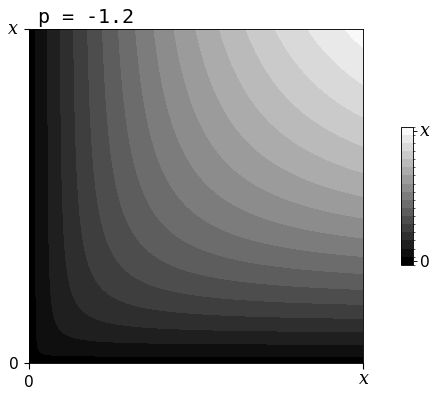

 97%|██████████████████████████████████████████████████████████████████████████████████████████▍  | 600/617 [01:21<00:02,  6.92it/s]

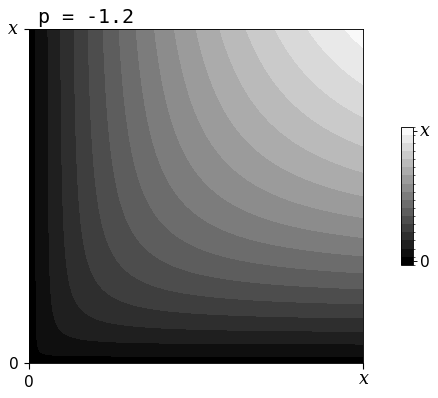

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 601/617 [01:21<00:02,  7.11it/s]

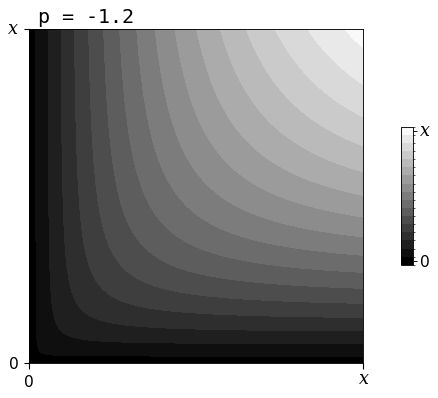

 98%|██████████████████████████████████████████████████████████████████████████████████████████▋  | 602/617 [01:21<00:02,  7.23it/s]

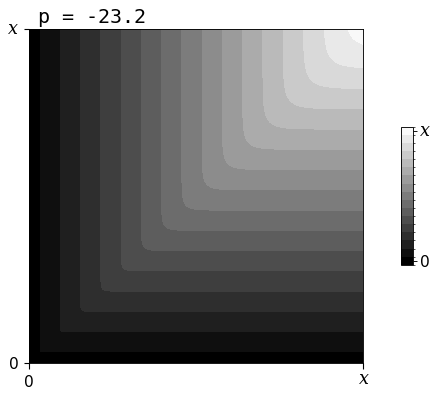

 98%|██████████████████████████████████████████████████████████████████████████████████████████▉  | 603/617 [01:21<00:01,  7.35it/s]

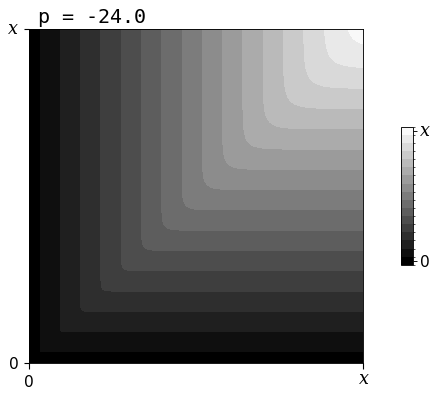

 98%|███████████████████████████████████████████████████████████████████████████████████████████  | 604/617 [01:21<00:01,  7.42it/s]

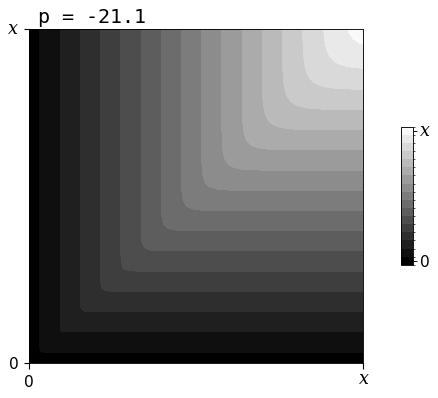

 98%|███████████████████████████████████████████████████████████████████████████████████████████▏ | 605/617 [01:21<00:01,  7.48it/s]

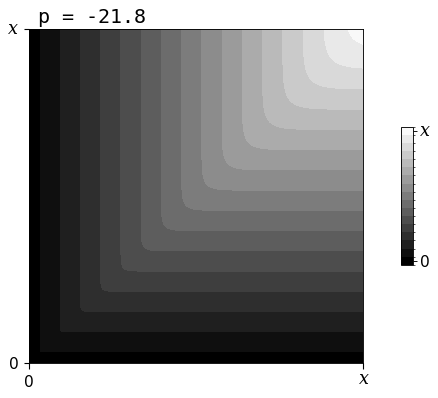

 98%|███████████████████████████████████████████████████████████████████████████████████████████▎ | 606/617 [01:22<00:01,  7.52it/s]

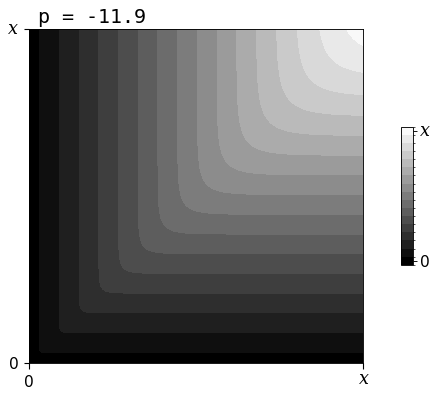

 98%|███████████████████████████████████████████████████████████████████████████████████████████▍ | 607/617 [01:22<00:01,  7.57it/s]

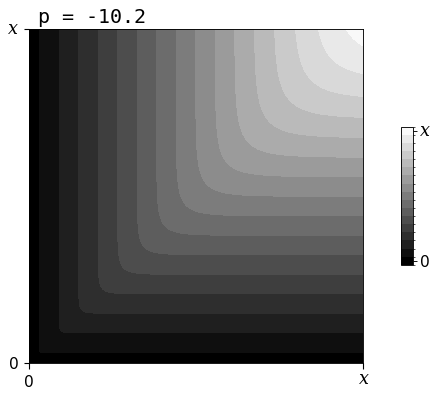

 99%|███████████████████████████████████████████████████████████████████████████████████████████▋ | 608/617 [01:22<00:01,  7.58it/s]

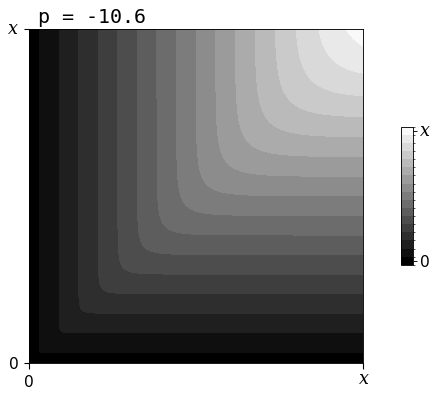

 99%|███████████████████████████████████████████████████████████████████████████████████████████▊ | 609/617 [01:22<00:01,  7.59it/s]

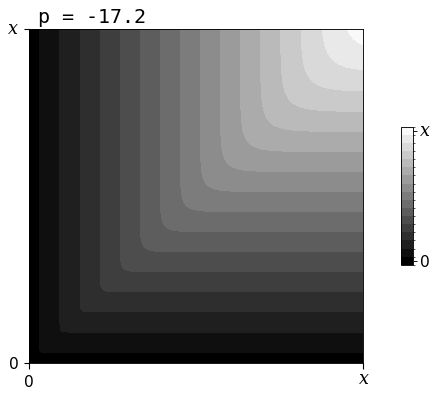

 99%|███████████████████████████████████████████████████████████████████████████████████████████▉ | 610/617 [01:22<00:00,  7.60it/s]

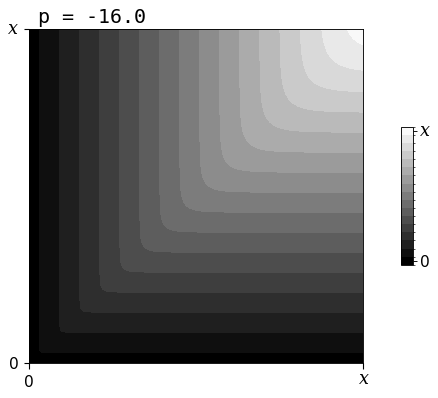

 99%|████████████████████████████████████████████████████████████████████████████████████████████ | 611/617 [01:22<00:00,  7.61it/s]

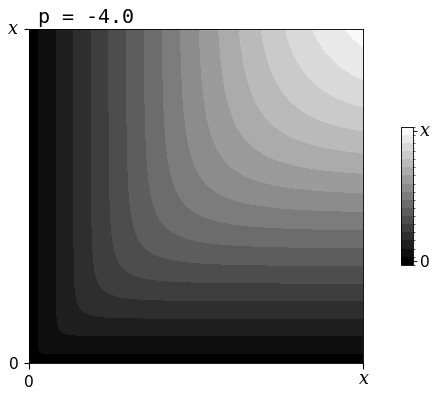

 99%|████████████████████████████████████████████████████████████████████████████████████████████▏| 612/617 [01:22<00:00,  7.60it/s]

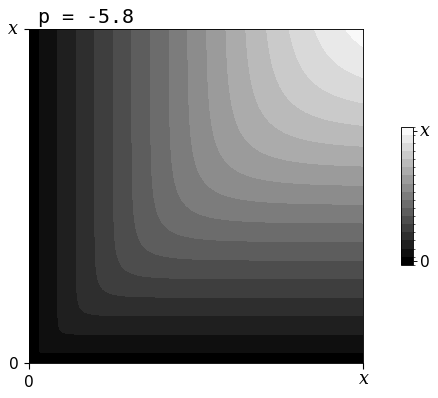

 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 613/617 [01:22<00:00,  7.60it/s]

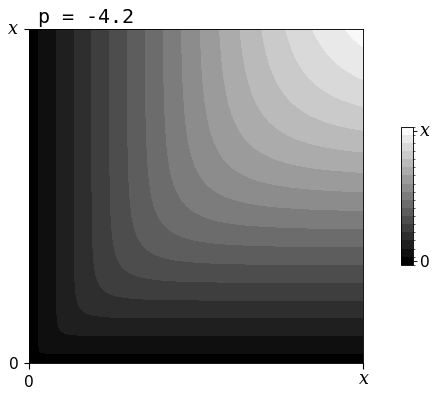

100%|████████████████████████████████████████████████████████████████████████████████████████████▌| 614/617 [01:23<00:00,  6.94it/s]

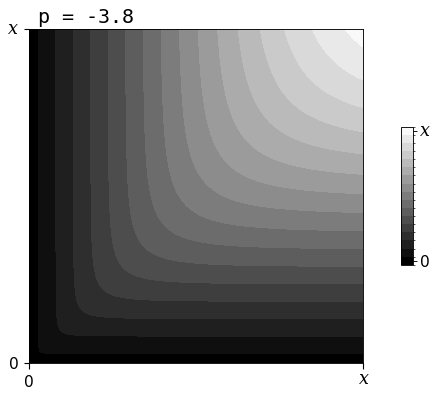

100%|████████████████████████████████████████████████████████████████████████████████████████████▋| 615/617 [01:23<00:00,  7.08it/s]

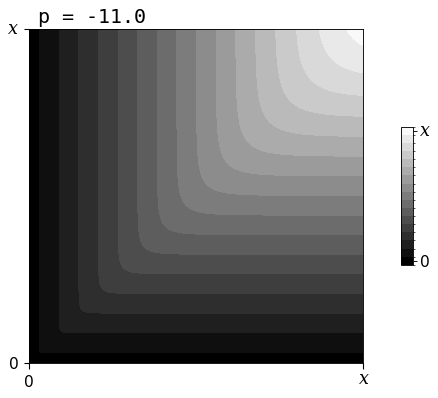

100%|████████████████████████████████████████████████████████████████████████████████████████████▊| 616/617 [01:23<00:00,  7.20it/s]

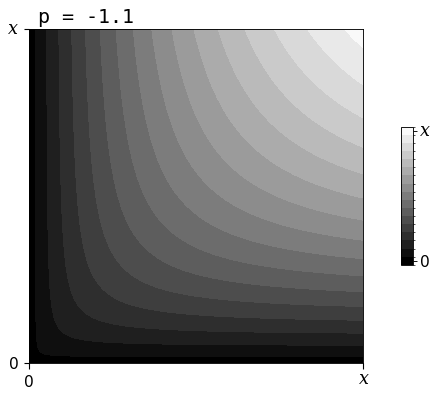

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 617/617 [01:23<00:00,  7.38it/s]


In [26]:
# render frames

all_frame_ps = list(set([
    p for anim in ANIMATIONS.values() for p in anim['frame_ps']
]))
generate_frames(tqdm.tqdm(all_frame_ps))

In [29]:
# compile frames into animated gifs

for i, (name, anim) in enumerate(ANIMATIONS.items()):
    print(f'reading {name}')
    frames = [
        Image.open(frame_file(anim_frame_p))
        for anim_frame_p
        in anim['frame_ps']
    ]
    print(f'writing {name}')
    frames[0].save(
        f'generated_visuals/animations/{i + 1}_{name}.png',
        format='png',
        append_images=tqdm.tqdm(frames[1:]),
        save_all=True,
        duration=[d*1000 for d in anim['durations']],
        loop=0, # never stop looping
    )

reading arith_to_harm
writing arith_to_harm


100%|████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 16160.82it/s]


reading harm_to_min
writing harm_to_min


100%|██████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 26509.57it/s]


reading arith_to_quad
writing arith_to_quad


100%|██████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 34276.15it/s]


reading quad_to_max
writing quad_to_max


100%|██████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 31988.86it/s]


reading whole_range
writing whole_range


100%|██████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:00<00:00, 72423.45it/s]
